In [72]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

# generate transitions

#  these are fixed
transitions_0 = np.eye(4)
transitions_1 = np.zeros([4,4])
transitions_1[:,-1] = 0.2
transitions_1[-1,-1] = 0

#  these are the ones we want to learn
indices = np.array([[0,1],
                  [0,2],
                  [1,0],
                  [1,2],
                  [2,0],
                  [2,1],
                  [3,0],
                  [3,1]])


transitions_1[indices[:,0],indices[:,1]] = 0.4
transitions_1[3,2] = 0.2
transitions_1

transitions = {0: transitions_0,
               1: transitions_1}

transitions[0], transitions[1]

(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([[0. , 0.4, 0.4, 0.2],
        [0.4, 0. , 0.4, 0.2],
        [0.4, 0.4, 0. , 0.2],
        [0.4, 0.4, 0.2, 0. ]]))

In [73]:
def print_progress(states):
    for i in states.keys():
        print(i, states[i].progress, states[i].completed)
        
def get_active_states(states, return_ix=False):
    d = {}
    for s in states.keys():
        if not states[s].completed:
            d[s] =   states[s]
    if return_ix:
        return np.array(list(d.keys()))
    return d


#  Basic reward function
class Reward:
    def __init__(self, states, streaks, streak_length, streak_reward, So_p_reward=0.9):
        self.streaks = streaks
        self.streak_length = streak_length
        self.last_streak_init = 0
        self.states = states
        self.streak_reward = streak_reward
        self.So_p_reward = So_p_reward
        
    def __call__(self, current_state_ix, action_history, n_tasks_completed):
        state = self.states[current_state_ix]
        if action_history[-1]:
            self.last_streak_init = len(action_history)
            return -1

        # if we stay, we might get a reward    
        if state.state_length < 1000: # if we are in task state
            if state.completed: # if task completed, get big money!
                return 100**(n_tasks_completed) + state.state_length
            else: 
                if self.streaks and (current_state_ix != 3):
                    a = action_history[self.last_streak_init:self.last_streak_init+self.streak_length]
                    if (np.sum(a) == 0) and len(a) == self.streak_length:
                        self.last_streak_init = self.last_streak_init+self.streak_length
                        return self.streak_reward
                return -1
        else: # if we are in other state
            v = npr.binomial(1, self.So_p_reward) # return random reward
#             return 2*(1-v) - v
            return 2*(v) - (1-v)


        
        
# def reward(state, action_history):
#     # if we just switched, always penalize
#     if action_history[-1]:
#         return -1
    
#     # if we stay, we might get a reward    
#     if state.state_length < 1000: # if we are in task state
#         if state.completed: # if task completed, get big money!
#             return 100**(self.n_tasks_completed) + state.state_length
#         else: 
#             return -1
#     else: # if we are in other state
#         v = npr.binomial(1, 0.9) # return random reward
#         return 2*(1-v) - v

    



In [74]:
class Task_Timer:
    def __init__(self, states, on_break, max_decrement=30):
        self.states = states
        self.on_break = on_break
        self.max_decrement = max_decrement
        
    def step(self, current_state_ix, action):
        states = get_active_states(self.states)
        states_ix = get_active_states(self.states, True)
    
        if action: # if we switched, decrement progress of all active states
            for s in states.keys():
                if states[s].n_decrement < self.max_decrement:
                    if not self.on_break:
                        states[s].progress = max(0, states[s].progress -1)
                    states[s].n_decrement += 1
                
        else:
            states[current_state_ix].progress += 1 # increment progress on current state
            
            if states[current_state_ix].progress >= states[current_state_ix].state_length-1: 
                states[current_state_ix].completed = True
                
            
            s_ = np.setdiff1d(states_ix, current_state_ix)
            for i in s_:
                if states[i].n_decrement < self.max_decrement:
                    if not self.on_break:
                        states[i].progress = max(0, states[i].progress-1)
                    states[i].n_decrement += 1
                

            
            
            
        

In [75]:
import numpy.random as npr
import numpy as np

class State:
    def __init__(self, state_length):
        self.state_length = state_length
        self.progress = 0
        self.completed = False
        self.n_decrement = 0

class MDP:
    def __init__(self, 
                 reward, 
                 task_timer, 
                 transitions, 
                 init_state=None, 
                 Break = False, 
                 break_length = 15,
                 Streaks = True, 
                 streak_length = 10,
                 streak_reward = 10,
                 So_reward_p = 0.1):
        '''
        transitions: ()
        init_state: (int)
        '''
        
        # Time Horizon is 8 hours
        self.T = 60*8 
        
        # init states
        self.Ss = State(60)
        self.Sm = State(120)
        self.Sl = State(240)
        self.So = State(10e9) # distracted
        self.states = {0: self.Ss,
                      1: self.Sm,
                      2: self.Sl,
                      3: self.So}
        
        
        self.total_reward = 0
        
        self.init_state = init_state
        if self.init_state is None:
            self.current_state_ix = npr.choice(3) # only start in task state
        else:
            self.current_state_ix = self.init_state
            
        self.transitions = transitions
        self.n_tasks_completed = 0
        
        
        self.Break = Break
        self.on_break = False
        self.break_counter = 0
        self.break_length = break_length
        
        self.task_timer = task_timer(self.states, self.on_break)
        
        
        self.Streaks = Streaks
        self.streak_length = streak_length
        self.streak_reward = streak_reward
        self.So_reward_p = So_reward_p

        self.reward = reward
        self.reward_fn = self.reward(self.states, 
                                self.Streaks, 
                                self.streak_length,
                               self.streak_reward,
                               self.So_reward_p)
        
        self.action_history = []
    
    def __call__(self, action):
        '''Take a step 
        0 is stay
        1 is transition'''
        self.action_history.append(action)
        if action:
            if self.on_break:
                self.on_break = False
                self.task_timer.on_break = False
            # get candidate transitions and probabilities
            s = get_active_states(self.states, True)
            self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
            p=self.transitions[1][self.current_state_ix, s]
            
            # reset n_decrement
            self.states[self.current_state_ix].n_decrement = 0
        
            # randomly sample
            self.current_state_ix = npr.choice(s, p=p)    
        else:
            if self.on_break and self.current_state_ix == 3:
                self.break_counter += 1
            
                if self.break_counter >= self.break_length: 
                    # done with break
                    s = get_active_states(self.states, True)
                    self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
                    p=self.transitions[1][self.current_state_ix, s]
                    self.current_state_ix = npr.choice(s, p=p)    
                    self.on_break = False
                    self.task_timer.on_break = False
                    
            pass
        
        self.task_timer.step(self.current_state_ix, action)          
        r = self.reward_fn(self.current_state_ix, self.action_history, self.n_tasks_completed)
        
        # if we complete the task, sample a new task
        if self.states[self.current_state_ix].completed:
            s = get_active_states(self.states, True)
            self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
            p = self.transitions[1][self.current_state_ix,s]
            self.current_state_ix = npr.choice(s, p=p)
            self.n_tasks_completed += 1
            
            if self.Break:
                self.current_state_ix = 3
                self.on_break = True
                self.task_timer.on_break = True
                self.break_counter = 0
                
            
        self.total_reward += r
        return self.current_state_ix, r
    
    def get_state_ix(self):
        return self.current_state_ix
    
    def get_state(self):
        return self.states[self.current_state_ix]
    
    def reset(self):
        self.Ss = State(60)
        self.Sm = State(120)
        self.Sl = State(240)
        self.So = State(10e9) # distracted
        self.states = {0: self.Ss,
                      1: self.Sm,
                      2: self.Sl,
                      3: self.So}
        
        
        self.total_reward = 0
        
        if self.init_state is None:
            self.current_state_ix = npr.choice(3) # only start in task state
        else:
            self.current_state_ix = self.init_state
            
        self.transitions = transitions
        self.n_tasks_completed = 0
        self.action_history = []
        
        self.on_break = False
        
        self.task_timer.states = self.states
        self.task_timer.on_break = self.on_break
        
        self.reward_fn.states = self.states


        
def normalize(p):
    return p/p.sum()

def fake_agent(s, r):
    # random action
    return npr.choice(2, p=[0.99, 0.01])


mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          None, 
          Break=False, 
          Streaks=False)
self = mdp
    
    

    
        
        

In [76]:
class Agent:
    def __init__(self, 
                 discount_factor = 0.9,
                 learning_rate = 0.9,
                 weight_1 = 0.2, 
                 weight_2 = 0.1, 
                 weight_3 = 0.2,
                 weight_4 = 0.1,
                 a = 0,
                 epsilon = 0.05):
        
        self.Qn = npr.random((4, 2))*0.2
        self.Qp = npr.random((4, 2))*0.2
        self.Q = npr.random((4, 2))

        self.weight_1 = weight_1
        self.weight_2 = weight_2
        self.weight_3 = weight_3
        self.weight_4 = weight_4
        
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        
        self.a = 0
        
        self.epsilon = epsilon
        

#     def choose_action(self, s, r):
#         s_idx = mdp.get_state_ix()
        
#         # TODO: check that not all states are complete
#         self.Q[s_idx, self.a] = self.weight_2 * self.Qp[s_idx, self.a] + self.weight_4 * self.Qn[s_idx, self.a]
#         self.a = np.argmax(self.Q[s_idx])
#         new_s,_ = mdp(self.a)
#         new_s_idx = mdp.get_state_ix()

#         self.Qp[s_idx, self.a] = self.weight_1 * self.Qp[s_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qp[new_s_idx]) - self.Qp[s_idx, self.a])
#         self.Qn[s_idx, self.a] = self.weight_3 * self.Qn[s_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qn[new_s_idx]) - self.Qn[s_idx, self.a])

#         return np.argmax(self.Q[s_idx]) 
    
    def choose_action(self, s_idx):
        p = np.random.random()
        if p < self.epsilon:
          return np.random.choice([0,1]) #explore
        else:
          return np.argmax(self.Q[s_idx]) #exploit
        
    def update(self, s0_idx, s1_idx, r):
        
        # TODO: check that not all states are complete
        self.Q[s0_idx, self.a] = self.weight_2 * self.Qp[s0_idx, self.a] + self.weight_4 * self.Qn[s0_idx, self.a]
        
        self.a = np.argmax(self.Q[s0_idx])

        self.Qp[s0_idx, self.a] = self.weight_1 * self.Qp[s0_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qp[s1_idx]) - self.Qp[s0_idx, self.a])
        self.Qn[s0_idx, self.a] = self.weight_3 * self.Qn[s0_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qn[s1_idx]) - self.Qn[s0_idx, self.a])

In [77]:
class Episodes:
    def __init__(self, mdp, agent, n_episodes, verbose=True):
        self.mdp = mdp
        self.agent = agent
        self.EPISODES_NUM = n_episodes
        self.prog = [[] for _ in range(self.EPISODES_NUM)]
        self.actions = [[] for _ in range(self.EPISODES_NUM)]
        self.states = [[] for _ in range(self.EPISODES_NUM)]
        self.rewards = [[] for _ in range(self.EPISODES_NUM)]
        self.on_break = [[] for _ in range(self.EPISODES_NUM)]
        self.score = [[] for _ in range(self.EPISODES_NUM)]
        self.time_horizon = 480
        
        self.verbose= verbose
        
        
    def run(self, ):
        if self.verbose:
            print(f"Running {self.EPISODES_NUM} episodes")
        for i in range(self.EPISODES_NUM):
            self.mdp.reset() # reset mdp for every episode
            
            s0 = self.mdp.get_state_ix()
            for j in range(self.time_horizon):

                a = self.agent.choose_action(s0)
                s1, r = self.mdp(a)
                s1 = self.mdp.get_state_ix()
                self.agent.update(s0, s1, r)
                s0 = s1

                p_ = [mdp.states[k].progress for k in range(4)]

                self.prog[i].append(p_)
                self.actions[i].append(a)
                self.states[i].append(self.mdp.current_state_ix)
                self.rewards[i].append(r)
                self.on_break[i].append(self.mdp.on_break)

                active_states = get_active_states(self.mdp.states,True)
                if len(active_states) == 1:
                    break
                    
            self.score[i] = np.sum(self.rewards[i])
            if self.verbose:
                print(f"\tEpisode: {i}\tScore: {self.score[i]}")

In [78]:
# mdp.states[0].progress


In [79]:
mdp(0)

(1, -1)

In [80]:

import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


t1 = time.time()
initial_state = 1

mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=True,
          break_length = 10,
          Streaks=False,
         streak_length=10)

agent = Agent(epsilon=0.1) # epsilon is the probability of "exploring" vs exploiting
n_episodes = 60
episode = Episodes(mdp, agent, n_episodes)
episode.run()
time.time() - t1

Running 60 episodes
	Episode: 0	Score: -197
	Episode: 1	Score: -418
	Episode: 2	Score: -77
	Episode: 3	Score: -390
	Episode: 4	Score: -378
	Episode: 5	Score: -417
	Episode: 6	Score: -337
	Episode: 7	Score: -360
	Episode: 8	Score: -393
	Episode: 9	Score: -378
	Episode: 10	Score: -348
	Episode: 11	Score: -339
	Episode: 12	Score: -304
	Episode: 13	Score: -393
	Episode: 14	Score: -402
	Episode: 15	Score: -399
	Episode: 16	Score: -390
	Episode: 17	Score: -414
	Episode: 18	Score: -414
	Episode: 19	Score: -426
	Episode: 20	Score: -411
	Episode: 21	Score: -411
	Episode: 22	Score: -345
	Episode: 23	Score: -384
	Episode: 24	Score: -369
	Episode: 25	Score: -313
	Episode: 26	Score: -313
	Episode: 27	Score: -354
	Episode: 28	Score: -310
	Episode: 29	Score: -289
	Episode: 30	Score: -426
	Episode: 31	Score: -286
	Episode: 32	Score: -384
	Episode: 33	Score: -378
	Episode: 34	Score: -411
	Episode: 35	Score: -405
	Episode: 36	Score: -367
	Episode: 37	Score: -423
	Episode: 38	Score: -417
	Episode: 39	Sco

1.4927046298980713

In [99]:
import random as rand
# n_samples for random search = 4,000
def RandomSearch(transitions, n_samples=4000):
    params = {}
    
    for i in range(n_samples):
        print(i)
        
        initial_state = rand.randrange(0,2)
        Break = bool(rand.getrandbits(1))
        break_length = rand.randrange(5,60,5)
        Streaks = bool(rand.getrandbits(1))
        streak_length = rand.randrange(10,90,5)
        transitions = {0: transitions_0,
               1: []}
        
        offtask = 0.2
        rand_1 = rand.uniform(0, 1-offtask)
        rand_2 = rand.uniform(0, 1-offtask)
        rand_3 = rand.uniform(0, 1-offtask)
        rand_4 = npr.dirichlet(np.ones(3),size=1)[0]
        
        transitions[1] = [[0., rand_1, 1-offtask-rand_1, offtask],
                              [rand_2, 0., 1-offtask-rand_2, offtask],
                              [rand_3, 1-offtask-rand_3, 0., offtask],
                              [rand_4[0], rand_4[1], rand_4[2], 0.]]

        mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=True,
          break_length = 10,
          Streaks=False,
          streak_length=10)
        print(transitions[1][0][3])
        agent = Agent(epsilon=0.1) # epsilon is the probability of "exploring" vs exploiting
        n_episodes = 50
        episode = Episodes(mdp, agent, n_episodes)
        episode.run()
        expected_score = np.median(episode.score)
        
        params[i] = {"transition parameter 1": rand_1,
                    "transition parameter 2": rand_2,
                    "transition parameter 3": rand_3,
                    "transition parameter 4": rand_4[0],
                    "transition parameter 5": rand_4[1],
                    "transition parameter 6": rand_4[2],
                    "break": Break,
                    "streaks": Streaks,
                    "break_length": break_length,
                    "streak_length": streak_length,
                    "expected score": expected_score}
        
    return params

In [100]:
import json

params = RandomSearch(transitions, 4000)
with open("random_search.json", "w") as write_file:
    json.dump(params, write_file, indent=4)

0
0.2
Running 50 episodes
	Episode: 0	Score: -402
	Episode: 1	Score: -357
	Episode: 2	Score: -318
	Episode: 3	Score: -342
	Episode: 4	Score: -345
	Episode: 5	Score: -348
	Episode: 6	Score: -369
	Episode: 7	Score: -366
	Episode: 8	Score: -363
	Episode: 9	Score: -396
	Episode: 10	Score: -357
	Episode: 11	Score: -348
	Episode: 12	Score: -339
	Episode: 13	Score: -369
	Episode: 14	Score: -336
	Episode: 15	Score: -363
	Episode: 16	Score: -309
	Episode: 17	Score: -372
	Episode: 18	Score: -342
	Episode: 19	Score: -360
	Episode: 20	Score: -324
	Episode: 21	Score: -327
	Episode: 22	Score: -342
	Episode: 23	Score: -342
	Episode: 24	Score: -336
	Episode: 25	Score: -330
	Episode: 26	Score: -309
	Episode: 27	Score: -366
	Episode: 28	Score: -363
	Episode: 29	Score: -354
	Episode: 30	Score: -303
	Episode: 31	Score: -360
	Episode: 32	Score: -330
	Episode: 33	Score: -345
	Episode: 34	Score: -372
	Episode: 35	Score: -360
	Episode: 36	Score: -345
	Episode: 37	Score: -306
	Episode: 38	Score: -342
	Episode:

	Episode: 28	Score: -360
	Episode: 29	Score: -351
	Episode: 30	Score: -345
	Episode: 31	Score: -333
	Episode: 32	Score: -354
	Episode: 33	Score: -351
	Episode: 34	Score: -354
	Episode: 35	Score: -375
	Episode: 36	Score: -357
	Episode: 37	Score: -363
	Episode: 38	Score: -369
	Episode: 39	Score: -375
	Episode: 40	Score: -357
	Episode: 41	Score: -411
	Episode: 42	Score: -417
	Episode: 43	Score: -327
	Episode: 44	Score: -369
	Episode: 45	Score: -354
	Episode: 46	Score: -324
	Episode: 47	Score: -399
	Episode: 48	Score: -363
	Episode: 49	Score: -354
7
0.2
Running 50 episodes
	Episode: 0	Score: -354
	Episode: 1	Score: -303
	Episode: 2	Score: -315
	Episode: 3	Score: -372
	Episode: 4	Score: -366
	Episode: 5	Score: -342
	Episode: 6	Score: -357
	Episode: 7	Score: -378
	Episode: 8	Score: -375
	Episode: 9	Score: -360
	Episode: 10	Score: -369
	Episode: 11	Score: -372
	Episode: 12	Score: -345
	Episode: 13	Score: -309
	Episode: 14	Score: -366
	Episode: 15	Score: -357
	Episode: 16	Score: -354
	Episode:

	Episode: 1	Score: -477
	Episode: 2	Score: -358
	Episode: 3	Score: -480
	Episode: 4	Score: -238
	Episode: 5	Score: -402
	Episode: 6	Score: -167
	Episode: 7	Score: -393
	Episode: 8	Score: -345
	Episode: 9	Score: -381
	Episode: 10	Score: -333
	Episode: 11	Score: -354
	Episode: 12	Score: -366
	Episode: 13	Score: -336
	Episode: 14	Score: -354
	Episode: 15	Score: -381
	Episode: 16	Score: -330
	Episode: 17	Score: -372
	Episode: 18	Score: -336
	Episode: 19	Score: -339
	Episode: 20	Score: -354
	Episode: 21	Score: -333
	Episode: 22	Score: -384
	Episode: 23	Score: -348
	Episode: 24	Score: -357
	Episode: 25	Score: -357
	Episode: 26	Score: -351
	Episode: 27	Score: -336
	Episode: 28	Score: -348
	Episode: 29	Score: -354
	Episode: 30	Score: -390
	Episode: 31	Score: -363
	Episode: 32	Score: -342
	Episode: 33	Score: -339
	Episode: 34	Score: -363
	Episode: 35	Score: -342
	Episode: 36	Score: -345
	Episode: 37	Score: -354
	Episode: 38	Score: -339
	Episode: 39	Score: -348
	Episode: 40	Score: -351
	Episode:

	Episode: 28	Score: -348
	Episode: 29	Score: -351
	Episode: 30	Score: -360
	Episode: 31	Score: -312
	Episode: 32	Score: -360
	Episode: 33	Score: -375
	Episode: 34	Score: -330
	Episode: 35	Score: -357
	Episode: 36	Score: -375
	Episode: 37	Score: -300
	Episode: 38	Score: -357
	Episode: 39	Score: -354
	Episode: 40	Score: -339
	Episode: 41	Score: -339
	Episode: 42	Score: -357
	Episode: 43	Score: -345
	Episode: 44	Score: -369
	Episode: 45	Score: -366
	Episode: 46	Score: -345
	Episode: 47	Score: -345
	Episode: 48	Score: -360
	Episode: 49	Score: -357
20
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: 10047
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -358
	Episode: 7	Score: -197
	Episode: 8	Score: -17
	Episode: 9	Score: -197
	Episode: 10	Score: -480
	Episode: 11	Score: -402
	Episode: 12	Score: -319
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode

	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -415
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -358
	Episode: 12	Score: -480
	Episode: 13	Score: -415
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -238
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -418
	Episode: 29	Score: -418
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -418
	Episode: 33	Score: -480
	Episode: 34	Score: -235
	Episode: 35	Score: -358
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -197
	Episode: 40	Score: -480
	Episode: 41	Score: -415
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -418
	Epis

	Episode: 33	Score: -372
	Episode: 34	Score: -357
	Episode: 35	Score: -375
	Episode: 36	Score: -294
	Episode: 37	Score: -357
	Episode: 38	Score: -366
	Episode: 39	Score: -366
	Episode: 40	Score: -381
	Episode: 41	Score: -360
	Episode: 42	Score: -366
	Episode: 43	Score: -360
	Episode: 44	Score: -354
	Episode: 45	Score: -345
	Episode: 46	Score: -372
	Episode: 47	Score: -339
	Episode: 48	Score: -342
	Episode: 49	Score: -354
33
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -477
	Episode: 5	Score: -235
	Episode: 6	Score: -480
	Episode: 7	Score: -358
	Episode: 8	Score: -477
	Episode: 9	Score: -358
	Episode: 10	Score: -238
	Episode: 11	Score: -358
	Episode: 12	Score: -415
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -238
	Episode: 18	Score: -417
	Episode: 19	Score: -366
	Episode: 20	Score: -315
	Episode: 21	Score: -330
	Episode

	Episode: 8	Score: -238
	Episode: 9	Score: -418
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -418
	Episode: 14	Score: -197
	Episode: 15	Score: -477
	Episode: 16	Score: -480
	Episode: 17	Score: -238
	Episode: 18	Score: -480
	Episode: 19	Score: -358
	Episode: 20	Score: -358
	Episode: 21	Score: -480
	Episode: 22	Score: -418
	Episode: 23	Score: -418
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -358
	Episode: 33	Score: -358
	Episode: 34	Score: -238
	Episode: 35	Score: -418
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -358
	Episode: 40	Score: -480
	Episode: 41	Score: -238
	Episode: 42	Score: -194
	Episode: 43	Score: -480
	Episode: 44	Score: -238
	Episode: 45	Score: -480
	Episode: 46	Score: -477
	Episode: 47	Score: -418
	E

	Episode: 39	Score: -357
	Episode: 40	Score: -327
	Episode: 41	Score: -363
	Episode: 42	Score: -342
	Episode: 43	Score: -357
	Episode: 44	Score: -357
	Episode: 45	Score: -357
	Episode: 46	Score: -342
	Episode: 47	Score: -354
	Episode: 48	Score: -330
	Episode: 49	Score: -312
46
0.2
Running 50 episodes
	Episode: 0	Score: -336
	Episode: 1	Score: -363
	Episode: 2	Score: -333
	Episode: 3	Score: -363
	Episode: 4	Score: -348
	Episode: 5	Score: -369
	Episode: 6	Score: -351
	Episode: 7	Score: -372
	Episode: 8	Score: -354
	Episode: 9	Score: -309
	Episode: 10	Score: -378
	Episode: 11	Score: -303
	Episode: 12	Score: -360
	Episode: 13	Score: -390
	Episode: 14	Score: -345
	Episode: 15	Score: -360
	Episode: 16	Score: -330
	Episode: 17	Score: -363
	Episode: 18	Score: -357
	Episode: 19	Score: -363
	Episode: 20	Score: -348
	Episode: 21	Score: -327
	Episode: 22	Score: -348
	Episode: 23	Score: -354
	Episode: 24	Score: -363
	Episode: 25	Score: -363
	Episode: 26	Score: -324
	Episode: 27	Score: -351
	Episode

	Episode: 19	Score: -197
	Episode: 20	Score: -480
	Episode: 21	Score: -477
	Episode: 22	Score: -77
	Episode: 23	Score: -405
	Episode: 24	Score: -339
	Episode: 25	Score: -372
	Episode: 26	Score: -372
	Episode: 27	Score: -348
	Episode: 28	Score: -348
	Episode: 29	Score: -324
	Episode: 30	Score: -339
	Episode: 31	Score: -366
	Episode: 32	Score: -351
	Episode: 33	Score: -357
	Episode: 34	Score: -351
	Episode: 35	Score: -348
	Episode: 36	Score: -354
	Episode: 37	Score: -372
	Episode: 38	Score: -363
	Episode: 39	Score: -363
	Episode: 40	Score: -348
	Episode: 41	Score: -348
	Episode: 42	Score: -348
	Episode: 43	Score: -339
	Episode: 44	Score: -321
	Episode: 45	Score: -351
	Episode: 46	Score: -351
	Episode: 47	Score: -369
	Episode: 48	Score: -369
	Episode: 49	Score: -324
53
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -477
	Episode: 2	Score: -238
	Episode: 3	Score: -358
	Episode: 4	Score: -480
	Episode: 5	Score: -358
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episod

	Episode: 43	Score: -372
	Episode: 44	Score: -354
	Episode: 45	Score: -372
	Episode: 46	Score: -345
	Episode: 47	Score: -366
	Episode: 48	Score: -378
	Episode: 49	Score: -372
59
0.2
Running 50 episodes
	Episode: 0	Score: -346
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -358
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -477
	Episode: 15	Score: -480
	Episode: 16	Score: -418
	Episode: 17	Score: -77
	Episode: 18	Score: -480
	Episode: 19	Score: -197
	Episode: 20	Score: -480
	Episode: 21	Score: -358
	Episode: 22	Score: -480
	Episode: 23	Score: -358
	Episode: 24	Score: -477
	Episode: 25	Score: -358
	Episode: 26	Score: -480
	Episode: 27	Score: -238
	Episode: 28	Score: -435
	Episode: 29	Score: -342
	Episode: 30	Score: -345
	Episode: 31	Score: -327
	Episode:

	Episode: 23	Score: -300
	Episode: 24	Score: -357
	Episode: 25	Score: -348
	Episode: 26	Score: -351
	Episode: 27	Score: -369
	Episode: 28	Score: -360
	Episode: 29	Score: -360
	Episode: 30	Score: -372
	Episode: 31	Score: -321
	Episode: 32	Score: -336
	Episode: 33	Score: -375
	Episode: 34	Score: -354
	Episode: 35	Score: -360
	Episode: 36	Score: -363
	Episode: 37	Score: -387
	Episode: 38	Score: -363
	Episode: 39	Score: -342
	Episode: 40	Score: -345
	Episode: 41	Score: -390
	Episode: 42	Score: -330
	Episode: 43	Score: -342
	Episode: 44	Score: -375
	Episode: 45	Score: -360
	Episode: 46	Score: -366
	Episode: 47	Score: -366
	Episode: 48	Score: -357
	Episode: 49	Score: -336
66
0.2
Running 50 episodes
	Episode: 0	Score: -402
	Episode: 1	Score: -318
	Episode: 2	Score: -351
	Episode: 3	Score: -378
	Episode: 4	Score: -360
	Episode: 5	Score: -357
	Episode: 6	Score: -345
	Episode: 7	Score: -372
	Episode: 8	Score: -357
	Episode: 9	Score: -351
	Episode: 10	Score: -339
	Episode: 11	Score: -330
	Episode

	Episode: 1	Score: -477
	Episode: 2	Score: -205
	Episode: 3	Score: -387
	Episode: 4	Score: -345
	Episode: 5	Score: -351
	Episode: 6	Score: -342
	Episode: 7	Score: -345
	Episode: 8	Score: -309
	Episode: 9	Score: -363
	Episode: 10	Score: -312
	Episode: 11	Score: -372
	Episode: 12	Score: -363
	Episode: 13	Score: -342
	Episode: 14	Score: -354
	Episode: 15	Score: -345
	Episode: 16	Score: -369
	Episode: 17	Score: -345
	Episode: 18	Score: -351
	Episode: 19	Score: -351
	Episode: 20	Score: -372
	Episode: 21	Score: -357
	Episode: 22	Score: -354
	Episode: 23	Score: -357
	Episode: 24	Score: -357
	Episode: 25	Score: -330
	Episode: 26	Score: -339
	Episode: 27	Score: -336
	Episode: 28	Score: -357
	Episode: 29	Score: -360
	Episode: 30	Score: -342
	Episode: 31	Score: -333
	Episode: 32	Score: -345
	Episode: 33	Score: -357
	Episode: 34	Score: -339
	Episode: 35	Score: -324
	Episode: 36	Score: -333
	Episode: 37	Score: -336
	Episode: 38	Score: -342
	Episode: 39	Score: -339
	Episode: 40	Score: -372
	Episode:

	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -418
	Episode: 33	Score: -474
	Episode: 34	Score: -358
	Episode: 35	Score: -477
	Episode: 36	Score: -480
	Episode: 37	Score: -415
	Episode: 38	Score: -238
	Episode: 39	Score: -480
	Episode: 40	Score: -358
	Episode: 41	Score: -358
	Episode: 42	Score: -418
	Episode: 43	Score: -480
	Episode: 44	Score: -477
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -418
79
0.2
Running 50 episodes
	Episode: 0	Score: -387
	Episode: 1	Score: -339
	Episode: 2	Score: -366
	Episode: 3	Score: -360
	Episode: 4	Score: -348
	Episode: 5	Score: -357
	Episode: 6	Score: -339
	Episode: 7	Score: -351
	Episode: 8	Score: -316
	Episode: 9	Score: -358
	Episode: 10	Score: -352
	Episode: 11	Score: -366
	Episode: 12	Score: -381
	Episode: 13	Score: -324
	Episode: 14	Score: -351
	Episode: 15	Score: -348
	Episode: 16	Score: -342
	Episode: 17	Score: -369
	Episode

	Episode: 2	Score: -345
	Episode: 3	Score: -336
	Episode: 4	Score: -324
	Episode: 5	Score: -339
	Episode: 6	Score: -339
	Episode: 7	Score: -366
	Episode: 8	Score: -378
	Episode: 9	Score: -369
	Episode: 10	Score: -351
	Episode: 11	Score: -345
	Episode: 12	Score: -354
	Episode: 13	Score: -348
	Episode: 14	Score: -348
	Episode: 15	Score: -336
	Episode: 16	Score: -372
	Episode: 17	Score: -375
	Episode: 18	Score: -351
	Episode: 19	Score: -372
	Episode: 20	Score: -357
	Episode: 21	Score: -366
	Episode: 22	Score: -342
	Episode: 23	Score: -345
	Episode: 24	Score: -372
	Episode: 25	Score: -321
	Episode: 26	Score: -342
	Episode: 27	Score: -342
	Episode: 28	Score: -345
	Episode: 29	Score: -351
	Episode: 30	Score: -348
	Episode: 31	Score: -312
	Episode: 32	Score: -348
	Episode: 33	Score: -348
	Episode: 34	Score: -381
	Episode: 35	Score: -375
	Episode: 36	Score: -351
	Episode: 37	Score: -306
	Episode: 38	Score: -339
	Episode: 39	Score: -324
	Episode: 40	Score: -333
	Episode: 41	Score: -333
	Episode

	Episode: 33	Score: -357
	Episode: 34	Score: -360
	Episode: 35	Score: -348
	Episode: 36	Score: -324
	Episode: 37	Score: -339
	Episode: 38	Score: -354
	Episode: 39	Score: -327
	Episode: 40	Score: -363
	Episode: 41	Score: -396
	Episode: 42	Score: -375
	Episode: 43	Score: -342
	Episode: 44	Score: -366
	Episode: 45	Score: -381
	Episode: 46	Score: -330
	Episode: 47	Score: -372
	Episode: 48	Score: -330
	Episode: 49	Score: -342
92
0.2
Running 50 episodes
	Episode: 0	Score: -366
	Episode: 1	Score: -351
	Episode: 2	Score: -462
	Episode: 3	Score: -238
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -358
	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -415
	Episode: 10	Score: -480
	Episode: 11	Score: -477
	Episode: 12	Score: -77
	Episode: 13	Score: -387
	Episode: 14	Score: -372
	Episode: 15	Score: -345
	Episode: 16	Score: -393
	Episode: 17	Score: -417
	Episode: 18	Score: -303
	Episode: 19	Score: -345
	Episode: 20	Score: -339
	Episode: 21	Score: -357
	Episode:

	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -415
	Episode: 17	Score: -480
	Episode: 18	Score: -197
	Episode: 19	Score: -238
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -194
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -480
	Episode: 27	Score: -77
	Episode: 28	Score: -197
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -14
	Episode: 32	Score: -477
	Episode: 33	Score: -480
	Episode: 34	Score: -197
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -418
	Episode: 38	Score: -418
	Episode: 39	Score: -418
	Episode: 40	Score: -238
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -358
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -277
	Episode: 47	Score: -414
	Episode: 48	Score: -318
	Episode: 49	Score: -381
99
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -238
	E

	Episode: 40	Score: -357
	Episode: 41	Score: -366
	Episode: 42	Score: -354
	Episode: 43	Score: -351
	Episode: 44	Score: -309
	Episode: 45	Score: -354
	Episode: 46	Score: -330
	Episode: 47	Score: -354
	Episode: 48	Score: -321
	Episode: 49	Score: -351
105
0.2
Running 50 episodes
	Episode: 0	Score: -456
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -477
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -358
	Episode: 9	Score: -480
	Episode: 10	Score: -238
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -194
	Episode: 17	Score: -17
	Episode: 18	Score: -358
	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -197
	Episode: 23	Score: -480
	Episode: 24	Score: -418
	Episode: 25	Score: -238
	Episode: 26	Score: -415
	Episode: 27	Score: -415
	Episode: 28	Score: -418
	Episode

	Episode: 17	Score: -363
	Episode: 18	Score: -348
	Episode: 19	Score: -297
	Episode: 20	Score: -375
	Episode: 21	Score: -378
	Episode: 22	Score: -342
	Episode: 23	Score: -363
	Episode: 24	Score: -342
	Episode: 25	Score: -384
	Episode: 26	Score: -363
	Episode: 27	Score: -324
	Episode: 28	Score: -333
	Episode: 29	Score: -324
	Episode: 30	Score: -297
	Episode: 31	Score: -336
	Episode: 32	Score: -366
	Episode: 33	Score: -330
	Episode: 34	Score: -354
	Episode: 35	Score: -393
	Episode: 36	Score: -348
	Episode: 37	Score: -318
	Episode: 38	Score: -327
	Episode: 39	Score: -363
	Episode: 40	Score: -351
	Episode: 41	Score: -312
	Episode: 42	Score: -345
	Episode: 43	Score: -345
	Episode: 44	Score: -354
	Episode: 45	Score: -363
	Episode: 46	Score: -339
	Episode: 47	Score: -345
	Episode: 48	Score: -324
	Episode: 49	Score: -345
112
0.2
Running 50 episodes
	Episode: 0	Score: -378
	Episode: 1	Score: -345
	Episode: 2	Score: -345
	Episode: 3	Score: -372
	Episode: 4	Score: -343
	Episode: 5	Score: -354
	Ep

	Episode: 44	Score: -77
	Episode: 45	Score: -418
	Episode: 46	Score: -477
	Episode: 47	Score: -197
	Episode: 48	Score: -480
	Episode: 49	Score: -477
118
0.2
Running 50 episodes
	Episode: 0	Score: -363
	Episode: 1	Score: -375
	Episode: 2	Score: -348
	Episode: 3	Score: -336
	Episode: 4	Score: -360
	Episode: 5	Score: -312
	Episode: 6	Score: -345
	Episode: 7	Score: -324
	Episode: 8	Score: -327
	Episode: 9	Score: -354
	Episode: 10	Score: -330
	Episode: 11	Score: -342
	Episode: 12	Score: -345
	Episode: 13	Score: -330
	Episode: 14	Score: -336
	Episode: 15	Score: -238
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -238
	Episode: 19	Score: -480
	Episode: 20	Score: -358
	Episode: 21	Score: -477
	Episode: 22	Score: -358
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -197
	Episode: 26	Score: -358
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -238
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode

	Episode: 20	Score: -418
	Episode: 21	Score: -238
	Episode: 22	Score: -480
	Episode: 23	Score: -197
	Episode: 24	Score: -358
	Episode: 25	Score: -418
	Episode: 26	Score: -418
	Episode: 27	Score: -477
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -477
	Episode: 31	Score: -474
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -477
	Episode: 37	Score: -480
	Episode: 38	Score: -477
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -238
	Episode: 42	Score: -358
	Episode: 43	Score: -238
	Episode: 44	Score: -480
	Episode: 45	Score: -418
	Episode: 46	Score: -418
	Episode: 47	Score: -358
	Episode: 48	Score: -480
	Episode: 49	Score: -480
125
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -412
	Episode: 2	Score: -480
	Episode: 3	Score: -358
	Episode: 4	Score: -358
	Episode: 5	Score: -480
	Episode: 6	Score: -223
	Episode: 7	Score: -378
	Episode: 8	Score: -360
	Episo

	Episode: 46	Score: -345
	Episode: 47	Score: -357
	Episode: 48	Score: -324
	Episode: 49	Score: -336
131
0.2
Running 50 episodes
	Episode: 0	Score: -417
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -393
	Episode: 5	Score: -378
	Episode: 6	Score: -360
	Episode: 7	Score: -354
	Episode: 8	Score: -348
	Episode: 9	Score: -342
	Episode: 10	Score: -351
	Episode: 11	Score: -315
	Episode: 12	Score: -357
	Episode: 13	Score: -315
	Episode: 14	Score: -339
	Episode: 15	Score: -402
	Episode: 16	Score: -357
	Episode: 17	Score: -321
	Episode: 18	Score: -348
	Episode: 19	Score: -375
	Episode: 20	Score: -369
	Episode: 21	Score: -354
	Episode: 22	Score: -351
	Episode: 23	Score: -381
	Episode: 24	Score: -313
	Episode: 25	Score: -363
	Episode: 26	Score: -378
	Episode: 27	Score: -357
	Episode: 28	Score: -309
	Episode: 29	Score: -372
	Episode: 30	Score: -238
	Episode: 31	Score: -331
	Episode: 32	Score: -390
	Episode: 33	Score: -417
	Episode: 34	Score: -408
	Episod

	Episode: 22	Score: -360
	Episode: 23	Score: -390
	Episode: 24	Score: -357
	Episode: 25	Score: -360
	Episode: 26	Score: -384
	Episode: 27	Score: -345
	Episode: 28	Score: -286
	Episode: 29	Score: -358
	Episode: 30	Score: -358
	Episode: 31	Score: -358
	Episode: 32	Score: -396
	Episode: 33	Score: -369
	Episode: 34	Score: -351
	Episode: 35	Score: -366
	Episode: 36	Score: -384
	Episode: 37	Score: -360
	Episode: 38	Score: -315
	Episode: 39	Score: -327
	Episode: 40	Score: -366
	Episode: 41	Score: -360
	Episode: 42	Score: -309
	Episode: 43	Score: -336
	Episode: 44	Score: -378
	Episode: 45	Score: -357
	Episode: 46	Score: -453
	Episode: 47	Score: -238
	Episode: 48	Score: -393
	Episode: 49	Score: -366
138
0.2
Running 50 episodes
	Episode: 0	Score: -378
	Episode: 1	Score: -322
	Episode: 2	Score: -403
	Episode: 3	Score: -197
	Episode: 4	Score: -366
	Episode: 5	Score: -360
	Episode: 6	Score: -330
	Episode: 7	Score: -339
	Episode: 8	Score: -327
	Episode: 9	Score: -339
	Episode: 10	Score: -363
	Episod

	Episode: 4	Score: -363
	Episode: 5	Score: -336
	Episode: 6	Score: -357
	Episode: 7	Score: -375
	Episode: 8	Score: -363
	Episode: 9	Score: -351
	Episode: 10	Score: -324
	Episode: 11	Score: -336
	Episode: 12	Score: -336
	Episode: 13	Score: -336
	Episode: 14	Score: -336
	Episode: 15	Score: -345
	Episode: 16	Score: -339
	Episode: 17	Score: -360
	Episode: 18	Score: -345
	Episode: 19	Score: -360
	Episode: 20	Score: -354
	Episode: 21	Score: -348
	Episode: 22	Score: -369
	Episode: 23	Score: -366
	Episode: 24	Score: -348
	Episode: 25	Score: -357
	Episode: 26	Score: -357
	Episode: 27	Score: -360
	Episode: 28	Score: -345
	Episode: 29	Score: -357
	Episode: 30	Score: -348
	Episode: 31	Score: -333
	Episode: 32	Score: -384
	Episode: 33	Score: -324
	Episode: 34	Score: -321
	Episode: 35	Score: -351
	Episode: 36	Score: -360
	Episode: 37	Score: -351
	Episode: 38	Score: -339
	Episode: 39	Score: -369
	Episode: 40	Score: -363
	Episode: 41	Score: -363
	Episode: 42	Score: -372
	Episode: 43	Score: -342
	Episo

	Episode: 31	Score: -360
	Episode: 32	Score: -339
	Episode: 33	Score: -360
	Episode: 34	Score: -354
	Episode: 35	Score: -315
	Episode: 36	Score: -366
	Episode: 37	Score: -357
	Episode: 38	Score: -348
	Episode: 39	Score: -360
	Episode: 40	Score: -390
	Episode: 41	Score: -357
	Episode: 42	Score: -330
	Episode: 43	Score: -303
	Episode: 44	Score: -378
	Episode: 45	Score: -327
	Episode: 46	Score: -336
	Episode: 47	Score: -327
	Episode: 48	Score: -375
	Episode: 49	Score: -354
151
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -418
	Episode: 2	Score: -480
	Episode: 3	Score: -418
	Episode: 4	Score: -418
	Episode: 5	Score: -197
	Episode: 6	Score: -477
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -214
	Episode: 12	Score: -351
	Episode: 13	Score: -327
	Episode: 14	Score: -375
	Episode: 15	Score: -366
	Episode: 16	Score: -312
	Episode: 17	Score: -303
	Episode: 18	Score: -345
	Episode: 19	Score: -342
	Episod

	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -358
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -477
	Episode: 14	Score: -480
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -235
	Episode: 25	Score: -480
	Episode: 26	Score: -358
	Episode: 27	Score: -480
	Episode: 28	Score: -418
	Episode: 29	Score: -358
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -238
	Episode: 38	Score: -480
	Episode: 39	Score: -477
	Episode: 40	Score: -477
	Episode: 41	Score: -480
	Episode: 42	Score: -358
	Episode: 43	Score: -402
	Episo

	Episode: 29	Score: -357
	Episode: 30	Score: -375
	Episode: 31	Score: -342
	Episode: 32	Score: -291
	Episode: 33	Score: -330
	Episode: 34	Score: -354
	Episode: 35	Score: -339
	Episode: 36	Score: -363
	Episode: 37	Score: -354
	Episode: 38	Score: -390
	Episode: 39	Score: -366
	Episode: 40	Score: -327
	Episode: 41	Score: -339
	Episode: 42	Score: -363
	Episode: 43	Score: -336
	Episode: 44	Score: -363
	Episode: 45	Score: -342
	Episode: 46	Score: -339
	Episode: 47	Score: -360
	Episode: 48	Score: -354
	Episode: 49	Score: -327
164
0.2
Running 50 episodes
	Episode: 0	Score: -336
	Episode: 1	Score: -372
	Episode: 2	Score: -354
	Episode: 3	Score: -357
	Episode: 4	Score: -348
	Episode: 5	Score: -369
	Episode: 6	Score: -372
	Episode: 7	Score: -378
	Episode: 8	Score: -345
	Episode: 9	Score: -333
	Episode: 10	Score: -330
	Episode: 11	Score: -393
	Episode: 12	Score: -357
	Episode: 13	Score: -384
	Episode: 14	Score: -324
	Episode: 15	Score: -348
	Episode: 16	Score: -351
	Episode: 17	Score: -366
	Episod

	Episode: 6	Score: -358
	Episode: 7	Score: -477
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -415
	Episode: 14	Score: -477
	Episode: 15	Score: -477
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -238
	Episode: 19	Score: -418
	Episode: 20	Score: -358
	Episode: 21	Score: -477
	Episode: 22	Score: -480
	Episode: 23	Score: -415
	Episode: 24	Score: -477
	Episode: 25	Score: -480
	Episode: 26	Score: -418
	Episode: 27	Score: -197
	Episode: 28	Score: -477
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -235
	Episode: 32	Score: -418
	Episode: 33	Score: -415
	Episode: 34	Score: -477
	Episode: 35	Score: -358
	Episode: 36	Score: -480
	Episode: 37	Score: -477
	Episode: 38	Score: -418
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -477
	Episode: 42	Score: -358
	Episode: 43	Score: -238
	Episode: 44	Score: -418
	Episode: 45	Score: -358
	Epi

	Episode: 31	Score: -366
	Episode: 32	Score: -345
	Episode: 33	Score: -354
	Episode: 34	Score: -360
	Episode: 35	Score: -342
	Episode: 36	Score: -324
	Episode: 37	Score: -333
	Episode: 38	Score: -321
	Episode: 39	Score: -354
	Episode: 40	Score: -321
	Episode: 41	Score: -351
	Episode: 42	Score: -354
	Episode: 43	Score: -354
	Episode: 44	Score: -357
	Episode: 45	Score: -342
	Episode: 46	Score: -330
	Episode: 47	Score: -324
	Episode: 48	Score: -345
	Episode: 49	Score: -360
177
0.2
Running 50 episodes
	Episode: 0	Score: -369
	Episode: 1	Score: -366
	Episode: 2	Score: -348
	Episode: 3	Score: -342
	Episode: 4	Score: -339
	Episode: 5	Score: -351
	Episode: 6	Score: -369
	Episode: 7	Score: -342
	Episode: 8	Score: -360
	Episode: 9	Score: -378
	Episode: 10	Score: -345
	Episode: 11	Score: -354
	Episode: 12	Score: -354
	Episode: 13	Score: -351
	Episode: 14	Score: -348
	Episode: 15	Score: -336
	Episode: 16	Score: -381
	Episode: 17	Score: -354
	Episode: 18	Score: -363
	Episode: 19	Score: -363
	Episod

	Episode: 6	Score: -366
	Episode: 7	Score: -330
	Episode: 8	Score: -321
	Episode: 9	Score: -351
	Episode: 10	Score: -378
	Episode: 11	Score: -339
	Episode: 12	Score: -333
	Episode: 13	Score: -345
	Episode: 14	Score: -363
	Episode: 15	Score: -357
	Episode: 16	Score: -354
	Episode: 17	Score: -357
	Episode: 18	Score: -384
	Episode: 19	Score: -357
	Episode: 20	Score: -381
	Episode: 21	Score: -351
	Episode: 22	Score: -333
	Episode: 23	Score: -348
	Episode: 24	Score: -345
	Episode: 25	Score: -345
	Episode: 26	Score: -351
	Episode: 27	Score: -312
	Episode: 28	Score: -369
	Episode: 29	Score: -369
	Episode: 30	Score: -345
	Episode: 31	Score: -333
	Episode: 32	Score: -378
	Episode: 33	Score: -351
	Episode: 34	Score: -357
	Episode: 35	Score: -357
	Episode: 36	Score: -351
	Episode: 37	Score: -384
	Episode: 38	Score: -333
	Episode: 39	Score: -345
	Episode: 40	Score: -333
	Episode: 41	Score: -357
	Episode: 42	Score: -369
	Episode: 43	Score: -354
	Episode: 44	Score: -369
	Episode: 45	Score: -342
	Epi

	Episode: 38	Score: -378
	Episode: 39	Score: -327
	Episode: 40	Score: -381
	Episode: 41	Score: -339
	Episode: 42	Score: -342
	Episode: 43	Score: -324
	Episode: 44	Score: -339
	Episode: 45	Score: -307
	Episode: 46	Score: -363
	Episode: 47	Score: -351
	Episode: 48	Score: -307
	Episode: 49	Score: -336
190
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -418
	Episode: 6	Score: -480
	Episode: 7	Score: -17
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -238
	Episode: 12	Score: -77
	Episode: 13	Score: -477
	Episode: 14	Score: -197
	Episode: 15	Score: -480
	Episode: 16	Score: -418
	Episode: 17	Score: -358
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -477
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -477
	Episode:

	Episode: 17	Score: -415
	Episode: 18	Score: -477
	Episode: 19	Score: -480
	Episode: 20	Score: -77
	Episode: 21	Score: -480
	Episode: 22	Score: -358
	Episode: 23	Score: -477
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -238
	Episode: 28	Score: -358
	Episode: 29	Score: -197
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -418
	Episode: 33	Score: -238
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -77
	Episode: 37	Score: -480
	Episode: 38	Score: -358
	Episode: 39	Score: -418
	Episode: 40	Score: -415
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -477
	Episode: 44	Score: -355
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -358
	Episode: 49	Score: -358
197
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -77
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episo

	Episode: 49	Score: -333
203
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -480
	Episode: 2	Score: -77
	Episode: 3	Score: -358
	Episode: 4	Score: -355
	Episode: 5	Score: -358
	Episode: 6	Score: -238
	Episode: 7	Score: -418
	Episode: 8	Score: -418
	Episode: 9	Score: -197
	Episode: 10	Score: -412
	Episode: 11	Score: -415
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -358
	Episode: 15	Score: -477
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -238
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -358
	Episode: 24	Score: -480
	Episode: 25	Score: -358
	Episode: 26	Score: -480
	Episode: 27	Score: -477
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -238
	Episode: 33	Score: -418
	Episode: 34	Score: -393
	Episode: 35	Score: -378
	Episode: 36	Score: -336
	Episode: 37	Score: -351
	Episode

	Episode: 29	Score: -345
	Episode: 30	Score: -366
	Episode: 31	Score: -396
	Episode: 32	Score: -348
	Episode: 33	Score: -360
	Episode: 34	Score: -363
	Episode: 35	Score: -351
	Episode: 36	Score: -348
	Episode: 37	Score: -318
	Episode: 38	Score: -339
	Episode: 39	Score: -327
	Episode: 40	Score: -339
	Episode: 41	Score: -345
	Episode: 42	Score: -375
	Episode: 43	Score: -333
	Episode: 44	Score: -318
	Episode: 45	Score: -327
	Episode: 46	Score: -327
	Episode: 47	Score: -327
	Episode: 48	Score: -336
	Episode: 49	Score: -354
210
0.2
Running 50 episodes
	Episode: 0	Score: -423
	Episode: 1	Score: -396
	Episode: 2	Score: -355
	Episode: 3	Score: -432
	Episode: 4	Score: -381
	Episode: 5	Score: -387
	Episode: 6	Score: -396
	Episode: 7	Score: -345
	Episode: 8	Score: -366
	Episode: 9	Score: -345
	Episode: 10	Score: -351
	Episode: 11	Score: -354
	Episode: 12	Score: -339
	Episode: 13	Score: -378
	Episode: 14	Score: -354
	Episode: 15	Score: -357
	Episode: 16	Score: -360
	Episode: 17	Score: -330
	Episod

	Episode: 5	Score: -480
	Episode: 6	Score: -474
	Episode: 7	Score: -415
	Episode: 8	Score: -418
	Episode: 9	Score: -358
	Episode: 10	Score: -358
	Episode: 11	Score: -480
	Episode: 12	Score: -77
	Episode: 13	Score: -197
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -358
	Episode: 18	Score: -211
	Episode: 19	Score: -313
	Episode: 20	Score: -375
	Episode: 21	Score: -372
	Episode: 22	Score: -348
	Episode: 23	Score: -297
	Episode: 24	Score: -363
	Episode: 25	Score: -363
	Episode: 26	Score: -324
	Episode: 27	Score: -345
	Episode: 28	Score: -330
	Episode: 29	Score: -366
	Episode: 30	Score: -345
	Episode: 31	Score: -339
	Episode: 32	Score: -339
	Episode: 33	Score: -327
	Episode: 34	Score: -336
	Episode: 35	Score: -354
	Episode: 36	Score: -360
	Episode: 37	Score: -372
	Episode: 38	Score: -334
	Episode: 39	Score: -348
	Episode: 40	Score: -369
	Episode: 41	Score: -339
	Episode: 42	Score: -351
	Episode: 43	Score: -318
	Episode: 44	Score: -378
	Episo

	Episode: 29	Score: -330
	Episode: 30	Score: -354
	Episode: 31	Score: -369
	Episode: 32	Score: -342
	Episode: 33	Score: -336
	Episode: 34	Score: -333
	Episode: 35	Score: -309
	Episode: 36	Score: -369
	Episode: 37	Score: -366
	Episode: 38	Score: -342
	Episode: 39	Score: -375
	Episode: 40	Score: -360
	Episode: 41	Score: -309
	Episode: 42	Score: -354
	Episode: 43	Score: -366
	Episode: 44	Score: -333
	Episode: 45	Score: -342
	Episode: 46	Score: -357
	Episode: 47	Score: -345
	Episode: 48	Score: -339
	Episode: 49	Score: -366
223
0.2
Running 50 episodes
	Episode: 0	Score: -381
	Episode: 1	Score: -363
	Episode: 2	Score: -363
	Episode: 3	Score: -327
	Episode: 4	Score: -363
	Episode: 5	Score: -348
	Episode: 6	Score: -348
	Episode: 7	Score: -369
	Episode: 8	Score: -354
	Episode: 9	Score: -381
	Episode: 10	Score: -363
	Episode: 11	Score: -351
	Episode: 12	Score: -372
	Episode: 13	Score: -366
	Episode: 14	Score: -345
	Episode: 15	Score: -363
	Episode: 16	Score: -339
	Episode: 17	Score: -324
	Episod

	Episode: 5	Score: -358
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -197
	Episode: 9	Score: -77
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -358
	Episode: 16	Score: -414
	Episode: 17	Score: -372
	Episode: 18	Score: -378
	Episode: 19	Score: -399
	Episode: 20	Score: -390
	Episode: 21	Score: -318
	Episode: 22	Score: -339
	Episode: 23	Score: -354
	Episode: 24	Score: -336
	Episode: 25	Score: -324
	Episode: 26	Score: -330
	Episode: 27	Score: -360
	Episode: 28	Score: -351
	Episode: 29	Score: -336
	Episode: 30	Score: -336
	Episode: 31	Score: -354
	Episode: 32	Score: -348
	Episode: 33	Score: -354
	Episode: 34	Score: -336
	Episode: 35	Score: -342
	Episode: 36	Score: -360
	Episode: 37	Score: -351
	Episode: 38	Score: -378
	Episode: 39	Score: -339
	Episode: 40	Score: -345
	Episode: 41	Score: -345
	Episode: 42	Score: -342
	Episode: 43	Score: -372
	Episode: 44	Score: -357
	Episo

	Episode: 31	Score: -345
	Episode: 32	Score: -354
	Episode: 33	Score: -363
	Episode: 34	Score: -345
	Episode: 35	Score: -333
	Episode: 36	Score: -351
	Episode: 37	Score: -312
	Episode: 38	Score: -384
	Episode: 39	Score: -348
	Episode: 40	Score: -336
	Episode: 41	Score: -384
	Episode: 42	Score: -318
	Episode: 43	Score: -357
	Episode: 44	Score: -369
	Episode: 45	Score: -327
	Episode: 46	Score: -333
	Episode: 47	Score: -363
	Episode: 48	Score: -366
	Episode: 49	Score: -375
236
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -477
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -474
	Episode: 7	Score: -351
	Episode: 8	Score: -354
	Episode: 9	Score: -354
	Episode: 10	Score: -330
	Episode: 11	Score: -342
	Episode: 12	Score: -333
	Episode: 13	Score: -363
	Episode: 14	Score: -357
	Episode: 15	Score: -369
	Episode: 16	Score: -327
	Episode: 17	Score: -345
	Episode: 18	Score: -336
	Episode: 19	Score: -342
	Episod

	Episode: 10	Score: -238
	Episode: 11	Score: -197
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -477
	Episode: 16	Score: -477
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -17
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -77
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -197
	Episode: 38	Score: -418
	Episode: 39	Score: -418
	Episode: 40	Score: -197
	Episode: 41	Score: -238
	Episode: 42	Score: -418
	Episode: 43	Score: -418
	Episode: 44	Score: -197
	Episode: 45	Score: -477
	Episode: 46	Score: -480
	Episode: 47	Score: -477
	Episode: 48	Score: -480
	Episode: 49	Score: -480
24

	Episode: 35	Score: -336
	Episode: 36	Score: -342
	Episode: 37	Score: -345
	Episode: 38	Score: -351
	Episode: 39	Score: -375
	Episode: 40	Score: -366
	Episode: 41	Score: -390
	Episode: 42	Score: -363
	Episode: 43	Score: -315
	Episode: 44	Score: -351
	Episode: 45	Score: -342
	Episode: 46	Score: -324
	Episode: 47	Score: -354
	Episode: 48	Score: -363
	Episode: 49	Score: -306
249
0.2
Running 50 episodes
	Episode: 0	Score: -354
	Episode: 1	Score: -369
	Episode: 2	Score: -327
	Episode: 3	Score: -342
	Episode: 4	Score: -357
	Episode: 5	Score: -348
	Episode: 6	Score: -363
	Episode: 7	Score: -351
	Episode: 8	Score: -357
	Episode: 9	Score: -303
	Episode: 10	Score: -381
	Episode: 11	Score: -387
	Episode: 12	Score: -324
	Episode: 13	Score: -366
	Episode: 14	Score: -309
	Episode: 15	Score: -354
	Episode: 16	Score: -384
	Episode: 17	Score: -330
	Episode: 18	Score: -372
	Episode: 19	Score: -351
	Episode: 20	Score: -318
	Episode: 21	Score: -324
	Episode: 22	Score: -366
	Episode: 23	Score: -330
	Episod

	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -238
	Episode: 22	Score: -418
	Episode: 23	Score: -197
	Episode: 24	Score: -418
	Episode: 25	Score: -418
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -477
	Episode: 29	Score: -197
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -238
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -358
	Episode: 38	Score: -418
	Episode: 39	Score: -480
	Episode: 40	Score: -77
	Episode: 41	Score: -418
	Episode: 42	Score: -358
	Episode: 43	Score: -358
	Episode: 44	Score: -480
	Episode: 45	Score: -238
	Episode: 46	Score: -438
	Episode: 47	Score: -345
	Episode: 48	Score: -366
	Episode: 49	Score: -351
256
0.2
Running 50 episodes
	Episode: 0	Score: -358
	Episode: 1	Score: -432
	Episode: 2	Score: -447
	Episode: 3	Score: -384
	E

	Episode: 40	Score: -387
	Episode: 41	Score: -378
	Episode: 42	Score: -375
	Episode: 43	Score: -345
	Episode: 44	Score: -342
	Episode: 45	Score: -369
	Episode: 46	Score: -357
	Episode: 47	Score: -384
	Episode: 48	Score: -366
	Episode: 49	Score: -336
262
0.2
Running 50 episodes
	Episode: 0	Score: -366
	Episode: 1	Score: -444
	Episode: 2	Score: -358
	Episode: 3	Score: -480
	Episode: 4	Score: -238
	Episode: 5	Score: -420
	Episode: 6	Score: -342
	Episode: 7	Score: -345
	Episode: 8	Score: -351
	Episode: 9	Score: -357
	Episode: 10	Score: -321
	Episode: 11	Score: -357
	Episode: 12	Score: -360
	Episode: 13	Score: -357
	Episode: 14	Score: -324
	Episode: 15	Score: -348
	Episode: 16	Score: -336
	Episode: 17	Score: -369
	Episode: 18	Score: -324
	Episode: 19	Score: -378
	Episode: 20	Score: -366
	Episode: 21	Score: -399
	Episode: 22	Score: -372
	Episode: 23	Score: -342
	Episode: 24	Score: -324
	Episode: 25	Score: -399
	Episode: 26	Score: -342
	Episode: 27	Score: -360
	Episode: 28	Score: -360
	Episod

	Episode: 17	Score: -418
	Episode: 18	Score: -355
	Episode: 19	Score: -197
	Episode: 20	Score: -412
	Episode: 21	Score: -238
	Episode: 22	Score: -197
	Episode: 23	Score: -358
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -238
	Episode: 27	Score: -418
	Episode: 28	Score: -480
	Episode: 29	Score: -197
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -238
	Episode: 33	Score: -358
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -197
	Episode: 37	Score: -480
	Episode: 38	Score: -238
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -197
	Episode: 42	Score: -238
	Episode: 43	Score: -480
	Episode: 44	Score: -197
	Episode: 45	Score: -477
	Episode: 46	Score: -480
	Episode: 47	Score: -418
	Episode: 48	Score: -480
	Episode: 49	Score: -480
269
0.2
Running 50 episodes
	Episode: 0	Score: -372
	Episode: 1	Score: -378
	Episode: 2	Score: -363
	Episode: 3	Score: -351
	Episode: 4	Score: -384
	Episode: 5	Score: -339
	Ep

	Episode: 42	Score: -324
	Episode: 43	Score: -315
	Episode: 44	Score: -336
	Episode: 45	Score: -351
	Episode: 46	Score: -327
	Episode: 47	Score: -336
	Episode: 48	Score: -339
	Episode: 49	Score: -324
275
0.2
Running 50 episodes
	Episode: 0	Score: -220
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -358
	Episode: 5	Score: -358
	Episode: 6	Score: -409
	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episode: 9	Score: -415
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -77
	Episode: 13	Score: -358
	Episode: 14	Score: -238
	Episode: 15	Score: -358
	Episode: 16	Score: -358
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -477
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -477
	Episode: 24	Score: -358
	Episode: 25	Score: -477
	Episode: 26	Score: -238
	Episode: 27	Score: -480
	Episode: 28	Score: -477
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode

	Episode: 20	Score: -369
	Episode: 21	Score: -369
	Episode: 22	Score: -342
	Episode: 23	Score: -342
	Episode: 24	Score: -369
	Episode: 25	Score: -369
	Episode: 26	Score: -360
	Episode: 27	Score: -330
	Episode: 28	Score: -333
	Episode: 29	Score: -342
	Episode: 30	Score: -351
	Episode: 31	Score: -375
	Episode: 32	Score: -363
	Episode: 33	Score: -378
	Episode: 34	Score: -339
	Episode: 35	Score: -318
	Episode: 36	Score: -339
	Episode: 37	Score: -351
	Episode: 38	Score: -336
	Episode: 39	Score: -324
	Episode: 40	Score: -351
	Episode: 41	Score: -360
	Episode: 42	Score: -378
	Episode: 43	Score: -321
	Episode: 44	Score: -345
	Episode: 45	Score: -372
	Episode: 46	Score: -342
	Episode: 47	Score: -357
	Episode: 48	Score: -354
	Episode: 49	Score: -336
282
0.2
Running 50 episodes
	Episode: 0	Score: -352
	Episode: 1	Score: -414
	Episode: 2	Score: -375
	Episode: 3	Score: -363
	Episode: 4	Score: -390
	Episode: 5	Score: -409
	Episode: 6	Score: -480
	Episode: 7	Score: -358
	Episode: 8	Score: -77
	Episod

	Episode: 49	Score: -339
288
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -238
	Episode: 3	Score: -399
	Episode: 4	Score: -327
	Episode: 5	Score: -396
	Episode: 6	Score: -345
	Episode: 7	Score: -330
	Episode: 8	Score: -348
	Episode: 9	Score: -348
	Episode: 10	Score: -363
	Episode: 11	Score: -351
	Episode: 12	Score: -360
	Episode: 13	Score: -327
	Episode: 14	Score: -351
	Episode: 15	Score: -339
	Episode: 16	Score: -348
	Episode: 17	Score: -360
	Episode: 18	Score: -348
	Episode: 19	Score: -357
	Episode: 20	Score: -336
	Episode: 21	Score: -345
	Episode: 22	Score: -390
	Episode: 23	Score: -318
	Episode: 24	Score: -324
	Episode: 25	Score: -360
	Episode: 26	Score: -363
	Episode: 27	Score: -354
	Episode: 28	Score: -375
	Episode: 29	Score: -357
	Episode: 30	Score: -357
	Episode: 31	Score: -324
	Episode: 32	Score: -342
	Episode: 33	Score: -351
	Episode: 34	Score: -372
	Episode: 35	Score: -375
	Episode: 36	Score: -330
	Episode: 37	Score: -357
	Episod

	Episode: 24	Score: -369
	Episode: 25	Score: -297
	Episode: 26	Score: -366
	Episode: 27	Score: -342
	Episode: 28	Score: -318
	Episode: 29	Score: -339
	Episode: 30	Score: -345
	Episode: 31	Score: -336
	Episode: 32	Score: -351
	Episode: 33	Score: -390
	Episode: 34	Score: -345
	Episode: 35	Score: -348
	Episode: 36	Score: -348
	Episode: 37	Score: -312
	Episode: 38	Score: -348
	Episode: 39	Score: -363
	Episode: 40	Score: -351
	Episode: 41	Score: -339
	Episode: 42	Score: -333
	Episode: 43	Score: -369
	Episode: 44	Score: -321
	Episode: 45	Score: -339
	Episode: 46	Score: -324
	Episode: 47	Score: -342
	Episode: 48	Score: -333
	Episode: 49	Score: -339
295
0.2
Running 50 episodes
	Episode: 0	Score: -378
	Episode: 1	Score: -322
	Episode: 2	Score: -360
	Episode: 3	Score: -357
	Episode: 4	Score: -363
	Episode: 5	Score: -354
	Episode: 6	Score: -351
	Episode: 7	Score: -315
	Episode: 8	Score: -354
	Episode: 9	Score: -369
	Episode: 10	Score: -378
	Episode: 11	Score: -345
	Episode: 12	Score: -369
	Episod

	Episode: 2	Score: -480
	Episode: 3	Score: -418
	Episode: 4	Score: -358
	Episode: 5	Score: -238
	Episode: 6	Score: -358
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -358
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -477
	Episode: 16	Score: -358
	Episode: 17	Score: -418
	Episode: 18	Score: -77
	Episode: 19	Score: -238
	Episode: 20	Score: -197
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode: 28	Score: -418
	Episode: 29	Score: -480
	Episode: 30	Score: -238
	Episode: 31	Score: -197
	Episode: 32	Score: -418
	Episode: 33	Score: -480
	Episode: 34	Score: -358
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -238
	Episode: 39	Score: -415
	Episode: 40	Score: -358
	Episode: 41	Score: -358
	Episode:

	Episode: 28	Score: -309
	Episode: 29	Score: -366
	Episode: 30	Score: -372
	Episode: 31	Score: -390
	Episode: 32	Score: -369
	Episode: 33	Score: -351
	Episode: 34	Score: -354
	Episode: 35	Score: -357
	Episode: 36	Score: -327
	Episode: 37	Score: -354
	Episode: 38	Score: -342
	Episode: 39	Score: -309
	Episode: 40	Score: -351
	Episode: 41	Score: -357
	Episode: 42	Score: -342
	Episode: 43	Score: -348
	Episode: 44	Score: -354
	Episode: 45	Score: -375
	Episode: 46	Score: -336
	Episode: 47	Score: -354
	Episode: 48	Score: -363
	Episode: 49	Score: -369
308
0.2
Running 50 episodes
	Episode: 0	Score: -354
	Episode: 1	Score: -351
	Episode: 2	Score: -363
	Episode: 3	Score: -390
	Episode: 4	Score: -315
	Episode: 5	Score: -369
	Episode: 6	Score: -342
	Episode: 7	Score: -327
	Episode: 8	Score: -336
	Episode: 9	Score: -330
	Episode: 10	Score: -408
	Episode: 11	Score: -459
	Episode: 12	Score: -358
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -477
	Episode: 16	Score: -415
	Episod

	Episode: 8	Score: -238
	Episode: 9	Score: -415
	Episode: 10	Score: -418
	Episode: 11	Score: -477
	Episode: 12	Score: -197
	Episode: 13	Score: -480
	Episode: 14	Score: -358
	Episode: 15	Score: -477
	Episode: 16	Score: -366
	Episode: 17	Score: -396
	Episode: 18	Score: -312
	Episode: 19	Score: -381
	Episode: 20	Score: -351
	Episode: 21	Score: -360
	Episode: 22	Score: -372
	Episode: 23	Score: -324
	Episode: 24	Score: -309
	Episode: 25	Score: -369
	Episode: 26	Score: -345
	Episode: 27	Score: -354
	Episode: 28	Score: -351
	Episode: 29	Score: -321
	Episode: 30	Score: -348
	Episode: 31	Score: -318
	Episode: 32	Score: -348
	Episode: 33	Score: -324
	Episode: 34	Score: -321
	Episode: 35	Score: -348
	Episode: 36	Score: -366
	Episode: 37	Score: -312
	Episode: 38	Score: -381
	Episode: 39	Score: -381
	Episode: 40	Score: -363
	Episode: 41	Score: -396
	Episode: 42	Score: -354
	Episode: 43	Score: -372
	Episode: 44	Score: -351
	Episode: 45	Score: -333
	Episode: 46	Score: -351
	Episode: 47	Score: -336
	E

	Episode: 32	Score: -369
	Episode: 33	Score: -342
	Episode: 34	Score: -369
	Episode: 35	Score: -351
	Episode: 36	Score: -369
	Episode: 37	Score: -375
	Episode: 38	Score: -354
	Episode: 39	Score: -336
	Episode: 40	Score: -366
	Episode: 41	Score: -372
	Episode: 42	Score: -333
	Episode: 43	Score: -363
	Episode: 44	Score: -360
	Episode: 45	Score: -387
	Episode: 46	Score: -357
	Episode: 47	Score: -366
	Episode: 48	Score: -363
	Episode: 49	Score: -303
321
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -238
	Episode: 2	Score: -480
	Episode: 3	Score: -340
	Episode: 4	Score: -378
	Episode: 5	Score: -372
	Episode: 6	Score: -360
	Episode: 7	Score: -333
	Episode: 8	Score: -339
	Episode: 9	Score: -375
	Episode: 10	Score: -366
	Episode: 11	Score: -304
	Episode: 12	Score: -378
	Episode: 13	Score: -321
	Episode: 14	Score: -339
	Episode: 15	Score: -354
	Episode: 16	Score: -345
	Episode: 17	Score: -372
	Episode: 18	Score: -381
	Episode: 19	Score: -402
	Episode: 20	Score: -345
	Episod

	Episode: 12	Score: -363
	Episode: 13	Score: -363
	Episode: 14	Score: -330
	Episode: 15	Score: -369
	Episode: 16	Score: -333
	Episode: 17	Score: -366
	Episode: 18	Score: -318
	Episode: 19	Score: -330
	Episode: 20	Score: -378
	Episode: 21	Score: -360
	Episode: 22	Score: -357
	Episode: 23	Score: -357
	Episode: 24	Score: -342
	Episode: 25	Score: -348
	Episode: 26	Score: -336
	Episode: 27	Score: -378
	Episode: 28	Score: -330
	Episode: 29	Score: -342
	Episode: 30	Score: -354
	Episode: 31	Score: -342
	Episode: 32	Score: -342
	Episode: 33	Score: -369
	Episode: 34	Score: -339
	Episode: 35	Score: -333
	Episode: 36	Score: -348
	Episode: 37	Score: -351
	Episode: 38	Score: -360
	Episode: 39	Score: -378
	Episode: 40	Score: -372
	Episode: 41	Score: -354
	Episode: 42	Score: -351
	Episode: 43	Score: -360
	Episode: 44	Score: -354
	Episode: 45	Score: -372
	Episode: 46	Score: -354
	Episode: 47	Score: -348
	Episode: 48	Score: -336
	Episode: 49	Score: -354
328
0.2
Running 50 episodes
	Episode: 0	Score: -44

	Episode: 43	Score: -351
	Episode: 44	Score: -375
	Episode: 45	Score: -336
	Episode: 46	Score: -354
	Episode: 47	Score: -381
	Episode: 48	Score: -363
	Episode: 49	Score: -390
334
0.2
Running 50 episodes
	Episode: 0	Score: -447
	Episode: 1	Score: -477
	Episode: 2	Score: -418
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -477
	Episode: 6	Score: -396
	Episode: 7	Score: -351
	Episode: 8	Score: -345
	Episode: 9	Score: -372
	Episode: 10	Score: -369
	Episode: 11	Score: -333
	Episode: 12	Score: -360
	Episode: 13	Score: -330
	Episode: 14	Score: -378
	Episode: 15	Score: -345
	Episode: 16	Score: -360
	Episode: 17	Score: -324
	Episode: 18	Score: -318
	Episode: 19	Score: -372
	Episode: 20	Score: -369
	Episode: 21	Score: -342
	Episode: 22	Score: -357
	Episode: 23	Score: -330
	Episode: 24	Score: -375
	Episode: 25	Score: -363
	Episode: 26	Score: -351
	Episode: 27	Score: -357
	Episode: 28	Score: -339
	Episode: 29	Score: -363
	Episode: 30	Score: -369
	Episode: 31	Score: -372
	Episod

	Episode: 24	Score: -348
	Episode: 25	Score: -378
	Episode: 26	Score: -363
	Episode: 27	Score: -333
	Episode: 28	Score: -369
	Episode: 29	Score: -333
	Episode: 30	Score: -366
	Episode: 31	Score: -324
	Episode: 32	Score: -360
	Episode: 33	Score: -360
	Episode: 34	Score: -366
	Episode: 35	Score: -348
	Episode: 36	Score: -366
	Episode: 37	Score: -372
	Episode: 38	Score: -354
	Episode: 39	Score: -351
	Episode: 40	Score: -351
	Episode: 41	Score: -312
	Episode: 42	Score: -330
	Episode: 43	Score: -363
	Episode: 44	Score: -387
	Episode: 45	Score: -381
	Episode: 46	Score: -345
	Episode: 47	Score: -354
	Episode: 48	Score: -357
	Episode: 49	Score: -321
341
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -235
	Episode: 3	Score: -480
	Episode: 4	Score: -415
	Episode: 5	Score: -480
	Episode: 6	Score: -396
	Episode: 7	Score: -363
	Episode: 8	Score: -336
	Episode: 9	Score: -354
	Episode: 10	Score: -333
	Episode: 11	Score: -342
	Episode: 12	Score: -345
	Episod

347
0.2
Running 50 episodes
	Episode: 0	Score: -238
	Episode: 1	Score: -408
	Episode: 2	Score: -339
	Episode: 3	Score: -330
	Episode: 4	Score: -348
	Episode: 5	Score: -351
	Episode: 6	Score: -363
	Episode: 7	Score: -366
	Episode: 8	Score: -357
	Episode: 9	Score: -330
	Episode: 10	Score: -324
	Episode: 11	Score: -351
	Episode: 12	Score: -360
	Episode: 13	Score: -351
	Episode: 14	Score: -315
	Episode: 15	Score: -339
	Episode: 16	Score: -333
	Episode: 17	Score: -354
	Episode: 18	Score: -342
	Episode: 19	Score: -342
	Episode: 20	Score: -279
	Episode: 21	Score: -378
	Episode: 22	Score: -348
	Episode: 23	Score: -297
	Episode: 24	Score: -345
	Episode: 25	Score: -336
	Episode: 26	Score: -345
	Episode: 27	Score: -369
	Episode: 28	Score: -384
	Episode: 29	Score: -351
	Episode: 30	Score: -348
	Episode: 31	Score: -351
	Episode: 32	Score: -348
	Episode: 33	Score: -366
	Episode: 34	Score: -321
	Episode: 35	Score: -369
	Episode: 36	Score: -324
	Episode: 37	Score: -357
	Episode: 38	Score: -363
	Episod

	Episode: 26	Score: -358
	Episode: 27	Score: -474
	Episode: 28	Score: -480
	Episode: 29	Score: -238
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -358
	Episode: 33	Score: -418
	Episode: 34	Score: -415
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -418
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -358
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -238
	Episode: 44	Score: -197
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -77
	Episode: 48	Score: -358
	Episode: 49	Score: -480
354
0.2
Running 50 episodes
	Episode: 0	Score: -438
	Episode: 1	Score: -415
	Episode: 2	Score: -333
	Episode: 3	Score: -348
	Episode: 4	Score: -333
	Episode: 5	Score: -333
	Episode: 6	Score: -384
	Episode: 7	Score: -354
	Episode: 8	Score: -369
	Episode: 9	Score: -348
	Episode: 10	Score: -312
	Episode: 11	Score: -327
	Episode: 12	Score: -360
	Episode: 13	Score: -348
	Episode: 14	Score: -354
	Episode

	Episode: 8	Score: -388
	Episode: 9	Score: -238
	Episode: 10	Score: -429
	Episode: 11	Score: -360
	Episode: 12	Score: -363
	Episode: 13	Score: -363
	Episode: 14	Score: -294
	Episode: 15	Score: -324
	Episode: 16	Score: -354
	Episode: 17	Score: -327
	Episode: 18	Score: -351
	Episode: 19	Score: -381
	Episode: 20	Score: -327
	Episode: 21	Score: -354
	Episode: 22	Score: -348
	Episode: 23	Score: -327
	Episode: 24	Score: -366
	Episode: 25	Score: -363
	Episode: 26	Score: -345
	Episode: 27	Score: -381
	Episode: 28	Score: -360
	Episode: 29	Score: -369
	Episode: 30	Score: -333
	Episode: 31	Score: -357
	Episode: 32	Score: -396
	Episode: 33	Score: -321
	Episode: 34	Score: -345
	Episode: 35	Score: -360
	Episode: 36	Score: -336
	Episode: 37	Score: -336
	Episode: 38	Score: -336
	Episode: 39	Score: -354
	Episode: 40	Score: -357
	Episode: 41	Score: -366
	Episode: 42	Score: -384
	Episode: 43	Score: -366
	Episode: 44	Score: -321
	Episode: 45	Score: -363
	Episode: 46	Score: -360
	Episode: 47	Score: -372
	E

	Episode: 37	Score: -309
	Episode: 38	Score: -351
	Episode: 39	Score: -357
	Episode: 40	Score: -342
	Episode: 41	Score: -312
	Episode: 42	Score: -369
	Episode: 43	Score: -369
	Episode: 44	Score: -339
	Episode: 45	Score: -330
	Episode: 46	Score: -345
	Episode: 47	Score: -360
	Episode: 48	Score: -369
	Episode: 49	Score: -348
367
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -418
	Episode: 2	Score: -418
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -77
	Episode: 12	Score: -197
	Episode: 13	Score: -477
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -418
	Episode: 17	Score: -477
	Episode: 18	Score: -415
	Episode: 19	Score: -480
	Episode: 20	Score: -238
	Episode: 21	Score: -197
	Episode: 22	Score: -480
	Episode: 23	Score: -462
	Episode: 24	Score: -480
	Episode: 25	Score: -235
	Episode

	Episode: 11	Score: -358
	Episode: 12	Score: -415
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -477
	Episode: 16	Score: -480
	Episode: 17	Score: -415
	Episode: 18	Score: -415
	Episode: 19	Score: -77
	Episode: 20	Score: -358
	Episode: 21	Score: -480
	Episode: 22	Score: -358
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -77
	Episode: 33	Score: -358
	Episode: 34	Score: -480
	Episode: 35	Score: -415
	Episode: 36	Score: -480
	Episode: 37	Score: -197
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -238
	Episode: 43	Score: -418
	Episode: 44	Score: -418
	Episode: 45	Score: -477
	Episode: 46	Score: -194
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -480
374
0.2
Running 50 episodes

	Episode: 39	Score: -480
	Episode: 40	Score: -358
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -418
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -358
	Episode: 47	Score: -418
	Episode: 48	Score: -480
	Episode: 49	Score: -480
380
0.2
Running 50 episodes
	Episode: 0	Score: -232
	Episode: 1	Score: -418
	Episode: 2	Score: -465
	Episode: 3	Score: -418
	Episode: 4	Score: -418
	Episode: 5	Score: -358
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -477
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -235
	Episode: 16	Score: -480
	Episode: 17	Score: -194
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -358
	Episode: 23	Score: -480
	Episode: 24	Score: -17
	Episode: 25	Score: -418
	Episode: 26	Score: -480
	Episode: 27	Score: -197
	Episode

	Episode: 15	Score: -345
	Episode: 16	Score: -357
	Episode: 17	Score: -348
	Episode: 18	Score: -393
	Episode: 19	Score: -369
	Episode: 20	Score: -363
	Episode: 21	Score: -354
	Episode: 22	Score: -348
	Episode: 23	Score: -348
	Episode: 24	Score: -366
	Episode: 25	Score: -342
	Episode: 26	Score: -327
	Episode: 27	Score: -372
	Episode: 28	Score: -354
	Episode: 29	Score: -342
	Episode: 30	Score: -324
	Episode: 31	Score: -372
	Episode: 32	Score: -366
	Episode: 33	Score: -324
	Episode: 34	Score: -369
	Episode: 35	Score: -339
	Episode: 36	Score: -348
	Episode: 37	Score: -363
	Episode: 38	Score: -354
	Episode: 39	Score: -360
	Episode: 40	Score: -354
	Episode: 41	Score: -336
	Episode: 42	Score: -330
	Episode: 43	Score: -348
	Episode: 44	Score: -318
	Episode: 45	Score: -342
	Episode: 46	Score: -372
	Episode: 47	Score: -354
	Episode: 48	Score: -321
	Episode: 49	Score: -363
387
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -480
	Episode: 2	Score: -418
	Episode: 3	Score: -358
	

	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -418
	Episode: 46	Score: -358
	Episode: 47	Score: -480
	Episode: 48	Score: -418
	Episode: 49	Score: -238
393
0.2
Running 50 episodes
	Episode: 0	Score: -456
	Episode: 1	Score: -77
	Episode: 2	Score: -369
	Episode: 3	Score: -396
	Episode: 4	Score: -369
	Episode: 5	Score: -360
	Episode: 6	Score: -360
	Episode: 7	Score: -363
	Episode: 8	Score: -375
	Episode: 9	Score: -357
	Episode: 10	Score: -327
	Episode: 11	Score: -357
	Episode: 12	Score: -354
	Episode: 13	Score: -330
	Episode: 14	Score: -309
	Episode: 15	Score: -345
	Episode: 16	Score: -372
	Episode: 17	Score: -357
	Episode: 18	Score: -381
	Episode: 19	Score: -336
	Episode: 20	Score: -324
	Episode: 21	Score: -378
	Episode: 22	Score: -315
	Episode: 23	Score: -333
	Episode: 24	Score: -384
	Episode: 25	Score: -342
	Episode: 26	Score: -351
	Episode: 27	Score: -345
	Episode: 28	Score: -336
	Episode: 29	Score: -336
	Episode: 30	Score: -345
	Episode: 31	Score: -330
	Episode

	Episode: 18	Score: -309
	Episode: 19	Score: -354
	Episode: 20	Score: -366
	Episode: 21	Score: -348
	Episode: 22	Score: -351
	Episode: 23	Score: -378
	Episode: 24	Score: -342
	Episode: 25	Score: -342
	Episode: 26	Score: -363
	Episode: 27	Score: -336
	Episode: 28	Score: -348
	Episode: 29	Score: -333
	Episode: 30	Score: -372
	Episode: 31	Score: -363
	Episode: 32	Score: -324
	Episode: 33	Score: -357
	Episode: 34	Score: -375
	Episode: 35	Score: -345
	Episode: 36	Score: -363
	Episode: 37	Score: -372
	Episode: 38	Score: -354
	Episode: 39	Score: -351
	Episode: 40	Score: -339
	Episode: 41	Score: -360
	Episode: 42	Score: -366
	Episode: 43	Score: -339
	Episode: 44	Score: -378
	Episode: 45	Score: -360
	Episode: 46	Score: -333
	Episode: 47	Score: -348
	Episode: 48	Score: -324
	Episode: 49	Score: -324
400
0.2
Running 50 episodes
	Episode: 0	Score: -381
	Episode: 1	Score: -312
	Episode: 2	Score: -336
	Episode: 3	Score: -354
	Episode: 4	Score: -372
	Episode: 5	Score: -357
	Episode: 6	Score: -339
	Epi

	Episode: 43	Score: -354
	Episode: 44	Score: -354
	Episode: 45	Score: -330
	Episode: 46	Score: -351
	Episode: 47	Score: -348
	Episode: 48	Score: -378
	Episode: 49	Score: -330
406
0.2
Running 50 episodes
	Episode: 0	Score: -333
	Episode: 1	Score: -342
	Episode: 2	Score: -360
	Episode: 3	Score: -315
	Episode: 4	Score: -360
	Episode: 5	Score: -363
	Episode: 6	Score: -354
	Episode: 7	Score: -363
	Episode: 8	Score: -357
	Episode: 9	Score: -315
	Episode: 10	Score: -336
	Episode: 11	Score: -342
	Episode: 12	Score: -372
	Episode: 13	Score: -351
	Episode: 14	Score: -342
	Episode: 15	Score: -321
	Episode: 16	Score: -351
	Episode: 17	Score: -351
	Episode: 18	Score: -366
	Episode: 19	Score: -342
	Episode: 20	Score: -360
	Episode: 21	Score: -348
	Episode: 22	Score: -375
	Episode: 23	Score: -369
	Episode: 24	Score: -369
	Episode: 25	Score: -384
	Episode: 26	Score: -378
	Episode: 27	Score: -324
	Episode: 28	Score: -324
	Episode: 29	Score: -351
	Episode: 30	Score: -357
	Episode: 31	Score: -369
	Episod

	Episode: 18	Score: -378
	Episode: 19	Score: -396
	Episode: 20	Score: -324
	Episode: 21	Score: -360
	Episode: 22	Score: -342
	Episode: 23	Score: -363
	Episode: 24	Score: -333
	Episode: 25	Score: -372
	Episode: 26	Score: -324
	Episode: 27	Score: -348
	Episode: 28	Score: -363
	Episode: 29	Score: -336
	Episode: 30	Score: -369
	Episode: 31	Score: -333
	Episode: 32	Score: -360
	Episode: 33	Score: -357
	Episode: 34	Score: -363
	Episode: 35	Score: -360
	Episode: 36	Score: -318
	Episode: 37	Score: -330
	Episode: 38	Score: -378
	Episode: 39	Score: -351
	Episode: 40	Score: -345
	Episode: 41	Score: -324
	Episode: 42	Score: -351
	Episode: 43	Score: -342
	Episode: 44	Score: -372
	Episode: 45	Score: -378
	Episode: 46	Score: -360
	Episode: 47	Score: -357
	Episode: 48	Score: -360
	Episode: 49	Score: -363
413
0.2
Running 50 episodes
	Episode: 0	Score: -420
	Episode: 1	Score: -480
	Episode: 2	Score: -477
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -477
	Episode: 6	Score: -194
	Epi

	Episode: 43	Score: -354
	Episode: 44	Score: -336
	Episode: 45	Score: -438
	Episode: 46	Score: -289
	Episode: 47	Score: -357
	Episode: 48	Score: -363
	Episode: 49	Score: -351
419
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -238
	Episode: 3	Score: -480
	Episode: 4	Score: -468
	Episode: 5	Score: -384
	Episode: 6	Score: -354
	Episode: 7	Score: -345
	Episode: 8	Score: -345
	Episode: 9	Score: -327
	Episode: 10	Score: -330
	Episode: 11	Score: -357
	Episode: 12	Score: -333
	Episode: 13	Score: -351
	Episode: 14	Score: -360
	Episode: 15	Score: -366
	Episode: 16	Score: -339
	Episode: 17	Score: -369
	Episode: 18	Score: -375
	Episode: 19	Score: -339
	Episode: 20	Score: -348
	Episode: 21	Score: -306
	Episode: 22	Score: -348
	Episode: 23	Score: -360
	Episode: 24	Score: -369
	Episode: 25	Score: -336
	Episode: 26	Score: -363
	Episode: 27	Score: -372
	Episode: 28	Score: -330
	Episode: 29	Score: -324
	Episode: 30	Score: -369
	Episode: 31	Score: -354
	Episod

	Episode: 17	Score: -351
	Episode: 18	Score: -369
	Episode: 19	Score: -360
	Episode: 20	Score: -360
	Episode: 21	Score: -363
	Episode: 22	Score: -384
	Episode: 23	Score: -348
	Episode: 24	Score: -351
	Episode: 25	Score: -378
	Episode: 26	Score: -384
	Episode: 27	Score: -375
	Episode: 28	Score: -363
	Episode: 29	Score: -375
	Episode: 30	Score: -333
	Episode: 31	Score: -372
	Episode: 32	Score: -357
	Episode: 33	Score: -351
	Episode: 34	Score: -351
	Episode: 35	Score: -375
	Episode: 36	Score: -381
	Episode: 37	Score: -336
	Episode: 38	Score: -339
	Episode: 39	Score: -324
	Episode: 40	Score: -354
	Episode: 41	Score: -375
	Episode: 42	Score: -351
	Episode: 43	Score: -363
	Episode: 44	Score: -333
	Episode: 45	Score: -381
	Episode: 46	Score: -345
	Episode: 47	Score: -393
	Episode: 48	Score: -348
	Episode: 49	Score: -354
426
0.2
Running 50 episodes
	Episode: 0	Score: -360
	Episode: 1	Score: -351
	Episode: 2	Score: -342
	Episode: 3	Score: -399
	Episode: 4	Score: -327
	Episode: 5	Score: -366
	Ep

	Episode: 44	Score: -418
	Episode: 45	Score: -418
	Episode: 46	Score: -480
	Episode: 47	Score: -418
	Episode: 48	Score: -418
	Episode: 49	Score: -480
432
0.2
Running 50 episodes
	Episode: 0	Score: -435
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -358
	Episode: 6	Score: -480
	Episode: 7	Score: -415
	Episode: 8	Score: -77
	Episode: 9	Score: -358
	Episode: 10	Score: -480
	Episode: 11	Score: -358
	Episode: 12	Score: -238
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -197
	Episode: 17	Score: -480
	Episode: 18	Score: -238
	Episode: 19	Score: -358
	Episode: 20	Score: -418
	Episode: 21	Score: -238
	Episode: 22	Score: -358
	Episode: 23	Score: -197
	Episode: 24	Score: -77
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -358
	Episode: 28	Score: -415
	Episode: 29	Score: -197
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -358
	Episode:

	Episode: 21	Score: -418
	Episode: 22	Score: -418
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -358
	Episode: 28	Score: -480
	Episode: 29	Score: -415
	Episode: 30	Score: -415
	Episode: 31	Score: -238
	Episode: 32	Score: -358
	Episode: 33	Score: -358
	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -418
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -197
	Episode: 41	Score: -480
	Episode: 42	Score: -477
	Episode: 43	Score: -418
	Episode: 44	Score: -238
	Episode: 45	Score: -480
	Episode: 46	Score: -358
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -480
439
0.2
Running 50 episodes
	Episode: 0	Score: -432
	Episode: 1	Score: -412
	Episode: 2	Score: -418
	Episode: 3	Score: -480
	Episode: 4	Score: -77
	Episode: 5	Score: -358
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -412
	Episode: 9	Score: -480
	Episode

0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -384
	Episode: 2	Score: -321
	Episode: 3	Score: -336
	Episode: 4	Score: -345
	Episode: 5	Score: -327
	Episode: 6	Score: -399
	Episode: 7	Score: -345
	Episode: 8	Score: -363
	Episode: 9	Score: -348
	Episode: 10	Score: -345
	Episode: 11	Score: -300
	Episode: 12	Score: -357
	Episode: 13	Score: -342
	Episode: 14	Score: -333
	Episode: 15	Score: -348
	Episode: 16	Score: -348
	Episode: 17	Score: -351
	Episode: 18	Score: -339
	Episode: 19	Score: -294
	Episode: 20	Score: -339
	Episode: 21	Score: -372
	Episode: 22	Score: -369
	Episode: 23	Score: -354
	Episode: 24	Score: -351
	Episode: 25	Score: -366
	Episode: 26	Score: -354
	Episode: 27	Score: -297
	Episode: 28	Score: -378
	Episode: 29	Score: -360
	Episode: 30	Score: -351
	Episode: 31	Score: -372
	Episode: 32	Score: -336
	Episode: 33	Score: -366
	Episode: 34	Score: -351
	Episode: 35	Score: -360
	Episode: 36	Score: -342
	Episode: 37	Score: -354
	Episode: 38	Score: -333
	Episode: 3

	Episode: 30	Score: -351
	Episode: 31	Score: -348
	Episode: 32	Score: -321
	Episode: 33	Score: -381
	Episode: 34	Score: -345
	Episode: 35	Score: -351
	Episode: 36	Score: -342
	Episode: 37	Score: -327
	Episode: 38	Score: -348
	Episode: 39	Score: -336
	Episode: 40	Score: -354
	Episode: 41	Score: -336
	Episode: 42	Score: -360
	Episode: 43	Score: -333
	Episode: 44	Score: -366
	Episode: 45	Score: -351
	Episode: 46	Score: -369
	Episode: 47	Score: -345
	Episode: 48	Score: -336
	Episode: 49	Score: -342
452
0.2
Running 50 episodes
	Episode: 0	Score: -357
	Episode: 1	Score: -411
	Episode: 2	Score: -352
	Episode: 3	Score: -363
	Episode: 4	Score: -399
	Episode: 5	Score: -351
	Episode: 6	Score: -369
	Episode: 7	Score: -321
	Episode: 8	Score: -348
	Episode: 9	Score: -372
	Episode: 10	Score: -372
	Episode: 11	Score: -459
	Episode: 12	Score: -358
	Episode: 13	Score: -364
	Episode: 14	Score: -322
	Episode: 15	Score: -381
	Episode: 16	Score: -357
	Episode: 17	Score: -372
	Episode: 18	Score: -345
	Episod

	Episode: 7	Score: -351
	Episode: 8	Score: -360
	Episode: 9	Score: -354
	Episode: 10	Score: -327
	Episode: 11	Score: -369
	Episode: 12	Score: -351
	Episode: 13	Score: -354
	Episode: 14	Score: -354
	Episode: 15	Score: -339
	Episode: 16	Score: -333
	Episode: 17	Score: -318
	Episode: 18	Score: -342
	Episode: 19	Score: -357
	Episode: 20	Score: -354
	Episode: 21	Score: -303
	Episode: 22	Score: -339
	Episode: 23	Score: -354
	Episode: 24	Score: -345
	Episode: 25	Score: -336
	Episode: 26	Score: -366
	Episode: 27	Score: -348
	Episode: 28	Score: -300
	Episode: 29	Score: -357
	Episode: 30	Score: -372
	Episode: 31	Score: -309
	Episode: 32	Score: -348
	Episode: 33	Score: -363
	Episode: 34	Score: -387
	Episode: 35	Score: -366
	Episode: 36	Score: -363
	Episode: 37	Score: -351
	Episode: 38	Score: -348
	Episode: 39	Score: -333
	Episode: 40	Score: -348
	Episode: 41	Score: -357
	Episode: 42	Score: -363
	Episode: 43	Score: -294
	Episode: 44	Score: -369
	Episode: 45	Score: -375
	Episode: 46	Score: -351
	Ep

	Episode: 33	Score: -346
	Episode: 34	Score: -372
	Episode: 35	Score: -372
	Episode: 36	Score: -351
	Episode: 37	Score: -366
	Episode: 38	Score: -363
	Episode: 39	Score: -303
	Episode: 40	Score: -312
	Episode: 41	Score: -348
	Episode: 42	Score: -363
	Episode: 43	Score: -351
	Episode: 44	Score: -345
	Episode: 45	Score: -318
	Episode: 46	Score: -345
	Episode: 47	Score: -342
	Episode: 48	Score: -333
	Episode: 49	Score: -318
465
0.2
Running 50 episodes
	Episode: 0	Score: -441
	Episode: 1	Score: -417
	Episode: 2	Score: -229
	Episode: 3	Score: -462
	Episode: 4	Score: -360
	Episode: 5	Score: -312
	Episode: 6	Score: -357
	Episode: 7	Score: -360
	Episode: 8	Score: -354
	Episode: 9	Score: -324
	Episode: 10	Score: -354
	Episode: 11	Score: -315
	Episode: 12	Score: -348
	Episode: 13	Score: -393
	Episode: 14	Score: -339
	Episode: 15	Score: -360
	Episode: 16	Score: -363
	Episode: 17	Score: -321
	Episode: 18	Score: -345
	Episode: 19	Score: -375
	Episode: 20	Score: -351
	Episode: 21	Score: -333
	Episod

	Episode: 10	Score: -358
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -418
	Episode: 14	Score: -238
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -197
	Episode: 21	Score: -480
	Episode: 22	Score: -418
	Episode: 23	Score: -418
	Episode: 24	Score: -358
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -358
	Episode: 28	Score: -77
	Episode: 29	Score: -197
	Episode: 30	Score: -238
	Episode: 31	Score: -358
	Episode: 32	Score: -402
	Episode: 33	Score: -372
	Episode: 34	Score: -345
	Episode: 35	Score: -357
	Episode: 36	Score: -354
	Episode: 37	Score: -369
	Episode: 38	Score: -303
	Episode: 39	Score: -330
	Episode: 40	Score: -348
	Episode: 41	Score: -336
	Episode: 42	Score: -318
	Episode: 43	Score: -381
	Episode: 44	Score: -354
	Episode: 45	Score: -378
	Episode: 46	Score: -363
	Episode: 47	Score: -345
	Episode: 48	Score: -342
	Episode: 49	Score: -300
4

	Episode: 42	Score: -372
	Episode: 43	Score: -357
	Episode: 44	Score: -351
	Episode: 45	Score: -345
	Episode: 46	Score: -360
	Episode: 47	Score: -330
	Episode: 48	Score: -381
	Episode: 49	Score: -372
478
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -381
	Episode: 4	Score: -393
	Episode: 5	Score: -360
	Episode: 6	Score: -348
	Episode: 7	Score: -351
	Episode: 8	Score: -381
	Episode: 9	Score: -357
	Episode: 10	Score: -360
	Episode: 11	Score: -378
	Episode: 12	Score: -351
	Episode: 13	Score: -366
	Episode: 14	Score: -354
	Episode: 15	Score: -333
	Episode: 16	Score: -345
	Episode: 17	Score: -336
	Episode: 18	Score: -351
	Episode: 19	Score: -354
	Episode: 20	Score: -342
	Episode: 21	Score: -357
	Episode: 22	Score: -363
	Episode: 23	Score: -333
	Episode: 24	Score: -345
	Episode: 25	Score: -366
	Episode: 26	Score: -339
	Episode: 27	Score: -363
	Episode: 28	Score: -336
	Episode: 29	Score: -366
	Episode: 30	Score: -327
	Episod

	Episode: 15	Score: -375
	Episode: 16	Score: -339
	Episode: 17	Score: -325
	Episode: 18	Score: -363
	Episode: 19	Score: -324
	Episode: 20	Score: -349
	Episode: 21	Score: -330
	Episode: 22	Score: -357
	Episode: 23	Score: -354
	Episode: 24	Score: -366
	Episode: 25	Score: -400
	Episode: 26	Score: -471
	Episode: 27	Score: -480
	Episode: 28	Score: -373
	Episode: 29	Score: -321
	Episode: 30	Score: -330
	Episode: 31	Score: -339
	Episode: 32	Score: -387
	Episode: 33	Score: -354
	Episode: 34	Score: -360
	Episode: 35	Score: -321
	Episode: 36	Score: -330
	Episode: 37	Score: -306
	Episode: 38	Score: -357
	Episode: 39	Score: -372
	Episode: 40	Score: -342
	Episode: 41	Score: -366
	Episode: 42	Score: -357
	Episode: 43	Score: -339
	Episode: 44	Score: -375
	Episode: 45	Score: -372
	Episode: 46	Score: -342
	Episode: 47	Score: -366
	Episode: 48	Score: -372
	Episode: 49	Score: -360
485
0.2
Running 50 episodes
	Episode: 0	Score: -366
	Episode: 1	Score: -354
	Episode: 2	Score: -360
	Episode: 3	Score: -318
	

	Episode: 39	Score: -330
	Episode: 40	Score: -351
	Episode: 41	Score: -360
	Episode: 42	Score: -333
	Episode: 43	Score: -327
	Episode: 44	Score: -348
	Episode: 45	Score: -375
	Episode: 46	Score: -378
	Episode: 47	Score: -351
	Episode: 48	Score: -369
	Episode: 49	Score: -366
491
0.2
Running 50 episodes
	Episode: 0	Score: -369
	Episode: 1	Score: -337
	Episode: 2	Score: -358
	Episode: 3	Score: -418
	Episode: 4	Score: -415
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -77
	Episode: 8	Score: -358
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -418
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -238
	Episode: 23	Score: -358
	Episode: 24	Score: -480
	Episode: 25	Score: -358
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode

	Episode: 19	Score: -384
	Episode: 20	Score: -315
	Episode: 21	Score: -348
	Episode: 22	Score: -384
	Episode: 23	Score: -360
	Episode: 24	Score: -366
	Episode: 25	Score: -333
	Episode: 26	Score: -351
	Episode: 27	Score: -342
	Episode: 28	Score: -342
	Episode: 29	Score: -315
	Episode: 30	Score: -348
	Episode: 31	Score: -375
	Episode: 32	Score: -375
	Episode: 33	Score: -378
	Episode: 34	Score: -378
	Episode: 35	Score: -333
	Episode: 36	Score: -351
	Episode: 37	Score: -327
	Episode: 38	Score: -336
	Episode: 39	Score: -336
	Episode: 40	Score: -339
	Episode: 41	Score: -351
	Episode: 42	Score: -330
	Episode: 43	Score: -333
	Episode: 44	Score: -336
	Episode: 45	Score: -357
	Episode: 46	Score: -351
	Episode: 47	Score: -354
	Episode: 48	Score: -339
	Episode: 49	Score: -369
498
0.2
Running 50 episodes
	Episode: 0	Score: -399
	Episode: 1	Score: -354
	Episode: 2	Score: -327
	Episode: 3	Score: -327
	Episode: 4	Score: -360
	Episode: 5	Score: -232
	Episode: 6	Score: -355
	Episode: 7	Score: -480
	Epis

Running 50 episodes
	Episode: 0	Score: -387
	Episode: 1	Score: -372
	Episode: 2	Score: -348
	Episode: 3	Score: -342
	Episode: 4	Score: -375
	Episode: 5	Score: -378
	Episode: 6	Score: -345
	Episode: 7	Score: -435
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -238
	Episode: 11	Score: -477
	Episode: 12	Score: -418
	Episode: 13	Score: -197
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -358
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -238
	Episode: 20	Score: -358
	Episode: 21	Score: -462
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -238
	Episode: 27	Score: -197
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -418
	Episode: 31	Score: -238
	Episode: 32	Score: -480
	Episode: 33	Score: -358
	Episode: 34	Score: -197
	Episode: 35	Score: -77
	Episode: 36	Score: -477
	Episode: 37	Score: -480
	Episode: 38	Score: -355
	Episode: 39	Sco

	Episode: 25	Score: -348
	Episode: 26	Score: -354
	Episode: 27	Score: -357
	Episode: 28	Score: -351
	Episode: 29	Score: -339
	Episode: 30	Score: -360
	Episode: 31	Score: -321
	Episode: 32	Score: -348
	Episode: 33	Score: -363
	Episode: 34	Score: -321
	Episode: 35	Score: -360
	Episode: 36	Score: -363
	Episode: 37	Score: -336
	Episode: 38	Score: -366
	Episode: 39	Score: -321
	Episode: 40	Score: -369
	Episode: 41	Score: -357
	Episode: 42	Score: -324
	Episode: 43	Score: -345
	Episode: 44	Score: -378
	Episode: 45	Score: -360
	Episode: 46	Score: -348
	Episode: 47	Score: -354
	Episode: 48	Score: -366
	Episode: 49	Score: -354
511
0.2
Running 50 episodes
	Episode: 0	Score: -324
	Episode: 1	Score: -327
	Episode: 2	Score: -366
	Episode: 3	Score: -369
	Episode: 4	Score: -336
	Episode: 5	Score: -324
	Episode: 6	Score: -354
	Episode: 7	Score: -339
	Episode: 8	Score: -342
	Episode: 9	Score: -354
	Episode: 10	Score: -354
	Episode: 11	Score: -336
	Episode: 12	Score: -375
	Episode: 13	Score: -336
	Episod

	Episode: 2	Score: -336
	Episode: 3	Score: -333
	Episode: 4	Score: -321
	Episode: 5	Score: -351
	Episode: 6	Score: -354
	Episode: 7	Score: -339
	Episode: 8	Score: -339
	Episode: 9	Score: -327
	Episode: 10	Score: -369
	Episode: 11	Score: -336
	Episode: 12	Score: -351
	Episode: 13	Score: -330
	Episode: 14	Score: -354
	Episode: 15	Score: -354
	Episode: 16	Score: -351
	Episode: 17	Score: -327
	Episode: 18	Score: -381
	Episode: 19	Score: -369
	Episode: 20	Score: -360
	Episode: 21	Score: -351
	Episode: 22	Score: -348
	Episode: 23	Score: -342
	Episode: 24	Score: -366
	Episode: 25	Score: -315
	Episode: 26	Score: -357
	Episode: 27	Score: -321
	Episode: 28	Score: -342
	Episode: 29	Score: -369
	Episode: 30	Score: -339
	Episode: 31	Score: -336
	Episode: 32	Score: -339
	Episode: 33	Score: -366
	Episode: 34	Score: -381
	Episode: 35	Score: -339
	Episode: 36	Score: -378
	Episode: 37	Score: -351
	Episode: 38	Score: -330
	Episode: 39	Score: -336
	Episode: 40	Score: -342
	Episode: 41	Score: -330
	Episode

	Episode: 32	Score: -363
	Episode: 33	Score: -363
	Episode: 34	Score: -348
	Episode: 35	Score: -327
	Episode: 36	Score: -348
	Episode: 37	Score: -366
	Episode: 38	Score: -360
	Episode: 39	Score: -363
	Episode: 40	Score: -339
	Episode: 41	Score: -342
	Episode: 42	Score: -366
	Episode: 43	Score: -354
	Episode: 44	Score: -351
	Episode: 45	Score: -333
	Episode: 46	Score: -369
	Episode: 47	Score: -342
	Episode: 48	Score: -342
	Episode: 49	Score: -366
524
0.2
Running 50 episodes
	Episode: 0	Score: -402
	Episode: 1	Score: -417
	Episode: 2	Score: -238
	Episode: 3	Score: -480
	Episode: 4	Score: -197
	Episode: 5	Score: -238
	Episode: 6	Score: -418
	Episode: 7	Score: -477
	Episode: 8	Score: -480
	Episode: 9	Score: -379
	Episode: 10	Score: -369
	Episode: 11	Score: -393
	Episode: 12	Score: -363
	Episode: 13	Score: -348
	Episode: 14	Score: -313
	Episode: 15	Score: -363
	Episode: 16	Score: -351
	Episode: 17	Score: -197
	Episode: 18	Score: -418
	Episode: 19	Score: -355
	Episode: 20	Score: -418
	Episod

	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -477
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -77
	Episode: 15	Score: -197
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -477
	Episode: 20	Score: -358
	Episode: 21	Score: -480
	Episode: 22	Score: -418
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -480
	Episode: 27	Score: -477
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -418
	Episode: 36	Score: -480
	Episode: 37	Score: -358
	Episode: 38	Score: -238
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -418
	Episode: 42	Score: -17
	Episode: 43	Score: -418
	Episode: 44	Score: -480
	Episod

	Episode: 30	Score: -238
	Episode: 31	Score: -415
	Episode: 32	Score: -418
	Episode: 33	Score: -238
	Episode: 34	Score: -387
	Episode: 35	Score: -297
	Episode: 36	Score: -339
	Episode: 37	Score: -342
	Episode: 38	Score: -315
	Episode: 39	Score: -333
	Episode: 40	Score: -318
	Episode: 41	Score: -351
	Episode: 42	Score: -336
	Episode: 43	Score: -360
	Episode: 44	Score: -333
	Episode: 45	Score: -345
	Episode: 46	Score: -357
	Episode: 47	Score: -345
	Episode: 48	Score: -348
	Episode: 49	Score: -345
537
0.2
Running 50 episodes
	Episode: 0	Score: -375
	Episode: 1	Score: -459
	Episode: 2	Score: -480
	Episode: 3	Score: -477
	Episode: 4	Score: -17
	Episode: 5	Score: -441
	Episode: 6	Score: -357
	Episode: 7	Score: -363
	Episode: 8	Score: -363
	Episode: 9	Score: -387
	Episode: 10	Score: -360
	Episode: 11	Score: -339
	Episode: 12	Score: -333
	Episode: 13	Score: -351
	Episode: 14	Score: -357
	Episode: 15	Score: -372
	Episode: 16	Score: -360
	Episode: 17	Score: -354
	Episode: 18	Score: -312
	Episode

	Episode: 7	Score: -390
	Episode: 8	Score: -336
	Episode: 9	Score: -336
	Episode: 10	Score: -408
	Episode: 11	Score: -378
	Episode: 12	Score: -336
	Episode: 13	Score: -318
	Episode: 14	Score: -324
	Episode: 15	Score: -378
	Episode: 16	Score: -330
	Episode: 17	Score: -321
	Episode: 18	Score: -342
	Episode: 19	Score: -330
	Episode: 20	Score: -354
	Episode: 21	Score: -342
	Episode: 22	Score: -360
	Episode: 23	Score: -372
	Episode: 24	Score: -351
	Episode: 25	Score: -360
	Episode: 26	Score: -360
	Episode: 27	Score: -381
	Episode: 28	Score: -378
	Episode: 29	Score: -408
	Episode: 30	Score: -342
	Episode: 31	Score: -351
	Episode: 32	Score: -357
	Episode: 33	Score: -378
	Episode: 34	Score: -330
	Episode: 35	Score: -330
	Episode: 36	Score: -366
	Episode: 37	Score: -384
	Episode: 38	Score: -357
	Episode: 39	Score: -345
	Episode: 40	Score: -354
	Episode: 41	Score: -333
	Episode: 42	Score: -354
	Episode: 43	Score: -369
	Episode: 44	Score: -351
	Episode: 45	Score: -366
	Episode: 46	Score: -330
	Ep

	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -238
	Episode: 36	Score: -358
	Episode: 37	Score: -197
	Episode: 38	Score: -358
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -418
	Episode: 45	Score: -480
	Episode: 46	Score: -238
	Episode: 47	Score: -480
	Episode: 48	Score: -358
	Episode: 49	Score: -418
550
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -358
	Episode: 4	Score: -418
	Episode: 5	Score: -238
	Episode: 6	Score: -477
	Episode: 7	Score: -197
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -375
	Episode: 11	Score: -369
	Episode: 12	Score: -348
	Episode: 13	Score: -330
	Episode: 14	Score: -309
	Episode: 15	Score: -297
	Episode: 16	Score: -369
	Episode: 17	Score: -342
	Episode: 18	Score: -360
	Episode: 19	Score: -387
	Episode: 20	Score: -378
	Episode: 21	Score: -369
	Episod

	Episode: 8	Score: -351
	Episode: 9	Score: -336
	Episode: 10	Score: -345
	Episode: 11	Score: -351
	Episode: 12	Score: -366
	Episode: 13	Score: -315
	Episode: 14	Score: -363
	Episode: 15	Score: -309
	Episode: 16	Score: -348
	Episode: 17	Score: -330
	Episode: 18	Score: -357
	Episode: 19	Score: -357
	Episode: 20	Score: -399
	Episode: 21	Score: -363
	Episode: 22	Score: -375
	Episode: 23	Score: -375
	Episode: 24	Score: -405
	Episode: 25	Score: -390
	Episode: 26	Score: -369
	Episode: 27	Score: -363
	Episode: 28	Score: -333
	Episode: 29	Score: -336
	Episode: 30	Score: -354
	Episode: 31	Score: -345
	Episode: 32	Score: -372
	Episode: 33	Score: -339
	Episode: 34	Score: -360
	Episode: 35	Score: -351
	Episode: 36	Score: -351
	Episode: 37	Score: -375
	Episode: 38	Score: -357
	Episode: 39	Score: -333
	Episode: 40	Score: -360
	Episode: 41	Score: -372
	Episode: 42	Score: -366
	Episode: 43	Score: -330
	Episode: 44	Score: -357
	Episode: 45	Score: -345
	Episode: 46	Score: -369
	Episode: 47	Score: -372
	E

	Episode: 32	Score: -336
	Episode: 33	Score: -363
	Episode: 34	Score: -387
	Episode: 35	Score: -348
	Episode: 36	Score: -348
	Episode: 37	Score: -333
	Episode: 38	Score: -339
	Episode: 39	Score: -375
	Episode: 40	Score: -312
	Episode: 41	Score: -372
	Episode: 42	Score: -354
	Episode: 43	Score: -327
	Episode: 44	Score: -333
	Episode: 45	Score: -363
	Episode: 46	Score: -366
	Episode: 47	Score: -378
	Episode: 48	Score: -360
	Episode: 49	Score: -330
563
0.2
Running 50 episodes
	Episode: 0	Score: -450
	Episode: 1	Score: -358
	Episode: 2	Score: -418
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -412
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -238
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episod

	Episode: 8	Score: -351
	Episode: 9	Score: -351
	Episode: 10	Score: -324
	Episode: 11	Score: -342
	Episode: 12	Score: -375
	Episode: 13	Score: -351
	Episode: 14	Score: -333
	Episode: 15	Score: -363
	Episode: 16	Score: -339
	Episode: 17	Score: -348
	Episode: 18	Score: -354
	Episode: 19	Score: -339
	Episode: 20	Score: -336
	Episode: 21	Score: -345
	Episode: 22	Score: -336
	Episode: 23	Score: -309
	Episode: 24	Score: -372
	Episode: 25	Score: -369
	Episode: 26	Score: -363
	Episode: 27	Score: -336
	Episode: 28	Score: -351
	Episode: 29	Score: -378
	Episode: 30	Score: -309
	Episode: 31	Score: -345
	Episode: 32	Score: -339
	Episode: 33	Score: -369
	Episode: 34	Score: -363
	Episode: 35	Score: -342
	Episode: 36	Score: -354
	Episode: 37	Score: -333
	Episode: 38	Score: -354
	Episode: 39	Score: -345
	Episode: 40	Score: -345
	Episode: 41	Score: -333
	Episode: 42	Score: -336
	Episode: 43	Score: -351
	Episode: 44	Score: -357
	Episode: 45	Score: -327
	Episode: 46	Score: -333
	Episode: 47	Score: -285
	E

	Episode: 34	Score: -390
	Episode: 35	Score: -390
	Episode: 36	Score: -313
	Episode: 37	Score: -369
	Episode: 38	Score: -363
	Episode: 39	Score: -348
	Episode: 40	Score: -375
	Episode: 41	Score: -330
	Episode: 42	Score: -378
	Episode: 43	Score: -357
	Episode: 44	Score: -327
	Episode: 45	Score: -348
	Episode: 46	Score: -357
	Episode: 47	Score: -357
	Episode: 48	Score: -333
	Episode: 49	Score: -357
576
0.2
Running 50 episodes
	Episode: 0	Score: -358
	Episode: 1	Score: -375
	Episode: 2	Score: -384
	Episode: 3	Score: -322
	Episode: 4	Score: -480
	Episode: 5	Score: -477
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -197
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -477
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -197
	Episode: 19	Score: -77
	Episode: 20	Score: -358
	Episode: 21	Score: -197
	Episode: 22	Score: -418
	Episode

	Episode: 11	Score: -324
	Episode: 12	Score: -345
	Episode: 13	Score: -327
	Episode: 14	Score: -342
	Episode: 15	Score: -318
	Episode: 16	Score: -360
	Episode: 17	Score: -324
	Episode: 18	Score: -366
	Episode: 19	Score: -354
	Episode: 20	Score: -330
	Episode: 21	Score: -360
	Episode: 22	Score: -363
	Episode: 23	Score: -342
	Episode: 24	Score: -354
	Episode: 25	Score: -345
	Episode: 26	Score: -324
	Episode: 27	Score: -378
	Episode: 28	Score: -357
	Episode: 29	Score: -381
	Episode: 30	Score: -348
	Episode: 31	Score: -354
	Episode: 32	Score: -345
	Episode: 33	Score: -330
	Episode: 34	Score: -342
	Episode: 35	Score: -348
	Episode: 36	Score: -348
	Episode: 37	Score: -357
	Episode: 38	Score: -366
	Episode: 39	Score: -333
	Episode: 40	Score: -339
	Episode: 41	Score: -372
	Episode: 42	Score: -336
	Episode: 43	Score: -366
	Episode: 44	Score: -366
	Episode: 45	Score: -375
	Episode: 46	Score: -348
	Episode: 47	Score: -387
	Episode: 48	Score: -363
	Episode: 49	Score: -327
583
0.2
Running 50 episod

	Episode: 36	Score: -238
	Episode: 37	Score: -418
	Episode: 38	Score: -480
	Episode: 39	Score: -197
	Episode: 40	Score: -480
	Episode: 41	Score: -418
	Episode: 42	Score: -197
	Episode: 43	Score: -238
	Episode: 44	Score: -358
	Episode: 45	Score: -418
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -358
589
0.2
Running 50 episodes
	Episode: 0	Score: -363
	Episode: 1	Score: -363
	Episode: 2	Score: -342
	Episode: 3	Score: -384
	Episode: 4	Score: -369
	Episode: 5	Score: -351
	Episode: 6	Score: -303
	Episode: 7	Score: -357
	Episode: 8	Score: -366
	Episode: 9	Score: -390
	Episode: 10	Score: -336
	Episode: 11	Score: -348
	Episode: 12	Score: -363
	Episode: 13	Score: -372
	Episode: 14	Score: -357
	Episode: 15	Score: -339
	Episode: 16	Score: -351
	Episode: 17	Score: -348
	Episode: 18	Score: -357
	Episode: 19	Score: -345
	Episode: 20	Score: -318
	Episode: 21	Score: -357
	Episode: 22	Score: -363
	Episode: 23	Score: -363
	Episode: 24	Score: -396
	Episod

	Episode: 16	Score: -197
	Episode: 17	Score: -77
	Episode: 18	Score: -197
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -477
	Episode: 24	Score: -480
	Episode: 25	Score: -197
	Episode: 26	Score: -412
	Episode: 27	Score: -468
	Episode: 28	Score: -414
	Episode: 29	Score: -381
	Episode: 30	Score: -399
	Episode: 31	Score: -378
	Episode: 32	Score: -354
	Episode: 33	Score: -357
	Episode: 34	Score: -366
	Episode: 35	Score: -339
	Episode: 36	Score: -345
	Episode: 37	Score: -393
	Episode: 38	Score: -354
	Episode: 39	Score: -381
	Episode: 40	Score: -348
	Episode: 41	Score: -366
	Episode: 42	Score: -375
	Episode: 43	Score: -342
	Episode: 44	Score: -354
	Episode: 45	Score: -354
	Episode: 46	Score: -360
	Episode: 47	Score: -354
	Episode: 48	Score: -345
	Episode: 49	Score: -300
596
0.2
Running 50 episodes
	Episode: 0	Score: -354
	Episode: 1	Score: -312
	Episode: 2	Score: -333
	Episode: 3	Score: -348
	Episode: 4	Score: -324
	Ep

	Episode: 47	Score: -418
	Episode: 48	Score: -418
	Episode: 49	Score: -418
602
0.2
Running 50 episodes
	Episode: 0	Score: -354
	Episode: 1	Score: -348
	Episode: 2	Score: -345
	Episode: 3	Score: -372
	Episode: 4	Score: -348
	Episode: 5	Score: -357
	Episode: 6	Score: -294
	Episode: 7	Score: -351
	Episode: 8	Score: -342
	Episode: 9	Score: -459
	Episode: 10	Score: -358
	Episode: 11	Score: -355
	Episode: 12	Score: -450
	Episode: 13	Score: -333
	Episode: 14	Score: -351
	Episode: 15	Score: -342
	Episode: 16	Score: -369
	Episode: 17	Score: -366
	Episode: 18	Score: -348
	Episode: 19	Score: -333
	Episode: 20	Score: -348
	Episode: 21	Score: -390
	Episode: 22	Score: -339
	Episode: 23	Score: -360
	Episode: 24	Score: -366
	Episode: 25	Score: -345
	Episode: 26	Score: -363
	Episode: 27	Score: -348
	Episode: 28	Score: -312
	Episode: 29	Score: -354
	Episode: 30	Score: -339
	Episode: 31	Score: -363
	Episode: 32	Score: -369
	Episode: 33	Score: -330
	Episode: 34	Score: -375
	Episode: 35	Score: -360
	Episod

	Episode: 27	Score: -480
	Episode: 28	Score: -418
	Episode: 29	Score: -418
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -358
	Episode: 34	Score: -480
	Episode: 35	Score: -238
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -197
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -197
	Episode: 43	Score: -477
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -238
	Episode: 47	Score: -418
	Episode: 48	Score: -418
	Episode: 49	Score: -358
609
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -77
	Episode: 2	Score: -381
	Episode: 3	Score: -390
	Episode: 4	Score: -348
	Episode: 5	Score: -357
	Episode: 6	Score: -339
	Episode: 7	Score: -342
	Episode: 8	Score: -366
	Episode: 9	Score: -378
	Episode: 10	Score: -375
	Episode: 11	Score: -402
	Episode: 12	Score: -321
	Episode: 13	Score: -354
	Episode: 14	Score: -321
	Episode: 15	Score: -336
	Episode

	Episode: 4	Score: -348
	Episode: 5	Score: -339
	Episode: 6	Score: -366
	Episode: 7	Score: -348
	Episode: 8	Score: -366
	Episode: 9	Score: -369
	Episode: 10	Score: -351
	Episode: 11	Score: -312
	Episode: 12	Score: -372
	Episode: 13	Score: -318
	Episode: 14	Score: -366
	Episode: 15	Score: -354
	Episode: 16	Score: -363
	Episode: 17	Score: -372
	Episode: 18	Score: -354
	Episode: 19	Score: -345
	Episode: 20	Score: -378
	Episode: 21	Score: -342
	Episode: 22	Score: -378
	Episode: 23	Score: -342
	Episode: 24	Score: -339
	Episode: 25	Score: -354
	Episode: 26	Score: -363
	Episode: 27	Score: -369
	Episode: 28	Score: -345
	Episode: 29	Score: -330
	Episode: 30	Score: -369
	Episode: 31	Score: -363
	Episode: 32	Score: -375
	Episode: 33	Score: -372
	Episode: 34	Score: -336
	Episode: 35	Score: -342
	Episode: 36	Score: -348
	Episode: 37	Score: -336
	Episode: 38	Score: -354
	Episode: 39	Score: -345
	Episode: 40	Score: -378
	Episode: 41	Score: -378
	Episode: 42	Score: -354
	Episode: 43	Score: -345
	Episo

	Episode: 36	Score: -363
	Episode: 37	Score: -333
	Episode: 38	Score: -378
	Episode: 39	Score: -339
	Episode: 40	Score: -348
	Episode: 41	Score: -336
	Episode: 42	Score: -342
	Episode: 43	Score: -354
	Episode: 44	Score: -360
	Episode: 45	Score: -357
	Episode: 46	Score: -369
	Episode: 47	Score: -357
	Episode: 48	Score: -348
	Episode: 49	Score: -357
622
0.2
Running 50 episodes
	Episode: 0	Score: -391
	Episode: 1	Score: -393
	Episode: 2	Score: -345
	Episode: 3	Score: -363
	Episode: 4	Score: -339
	Episode: 5	Score: -324
	Episode: 6	Score: -375
	Episode: 7	Score: -366
	Episode: 8	Score: -378
	Episode: 9	Score: -363
	Episode: 10	Score: -342
	Episode: 11	Score: -363
	Episode: 12	Score: -336
	Episode: 13	Score: -327
	Episode: 14	Score: -375
	Episode: 15	Score: -366
	Episode: 16	Score: -387
	Episode: 17	Score: -354
	Episode: 18	Score: -315
	Episode: 19	Score: -318
	Episode: 20	Score: -354
	Episode: 21	Score: -330
	Episode: 22	Score: -300
	Episode: 23	Score: -354
	Episode: 24	Score: -363
	Episod

	Episode: 16	Score: -372
	Episode: 17	Score: -366
	Episode: 18	Score: -360
	Episode: 19	Score: -324
	Episode: 20	Score: -390
	Episode: 21	Score: -352
	Episode: 22	Score: -378
	Episode: 23	Score: -280
	Episode: 24	Score: -360
	Episode: 25	Score: -348
	Episode: 26	Score: -330
	Episode: 27	Score: -396
	Episode: 28	Score: -313
	Episode: 29	Score: -384
	Episode: 30	Score: -357
	Episode: 31	Score: -396
	Episode: 32	Score: -369
	Episode: 33	Score: -351
	Episode: 34	Score: -378
	Episode: 35	Score: -366
	Episode: 36	Score: -330
	Episode: 37	Score: -348
	Episode: 38	Score: -339
	Episode: 39	Score: -298
	Episode: 40	Score: -327
	Episode: 41	Score: -384
	Episode: 42	Score: -354
	Episode: 43	Score: -309
	Episode: 44	Score: -289
	Episode: 45	Score: -298
	Episode: 46	Score: -375
	Episode: 47	Score: -366
	Episode: 48	Score: -316
	Episode: 49	Score: -384
629
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -238
	Episode: 2	Score: -477
	Episode: 3	Score: -477
	Episode: 4	Score: -480
	E

	Episode: 41	Score: -418
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -415
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -480
635
0.2
Running 50 episodes
	Episode: 0	Score: -378
	Episode: 1	Score: -354
	Episode: 2	Score: -345
	Episode: 3	Score: -333
	Episode: 4	Score: -378
	Episode: 5	Score: -330
	Episode: 6	Score: -366
	Episode: 7	Score: -369
	Episode: 8	Score: -375
	Episode: 9	Score: -351
	Episode: 10	Score: -369
	Episode: 11	Score: -360
	Episode: 12	Score: -354
	Episode: 13	Score: -357
	Episode: 14	Score: -387
	Episode: 15	Score: -369
	Episode: 16	Score: -351
	Episode: 17	Score: -315
	Episode: 18	Score: -378
	Episode: 19	Score: -333
	Episode: 20	Score: -351
	Episode: 21	Score: -342
	Episode: 22	Score: -351
	Episode: 23	Score: -342
	Episode: 24	Score: -348
	Episode: 25	Score: -339
	Episode: 26	Score: -348
	Episode: 27	Score: -351
	Episode: 28	Score: -324
	Episode: 29	Score: -381
	Episod

	Episode: 20	Score: -366
	Episode: 21	Score: -390
	Episode: 22	Score: -372
	Episode: 23	Score: -351
	Episode: 24	Score: -324
	Episode: 25	Score: -378
	Episode: 26	Score: -351
	Episode: 27	Score: -348
	Episode: 28	Score: -351
	Episode: 29	Score: -336
	Episode: 30	Score: -360
	Episode: 31	Score: -339
	Episode: 32	Score: -375
	Episode: 33	Score: -339
	Episode: 34	Score: -345
	Episode: 35	Score: -294
	Episode: 36	Score: -354
	Episode: 37	Score: -339
	Episode: 38	Score: -339
	Episode: 39	Score: -360
	Episode: 40	Score: -387
	Episode: 41	Score: -363
	Episode: 42	Score: -354
	Episode: 43	Score: -351
	Episode: 44	Score: -363
	Episode: 45	Score: -360
	Episode: 46	Score: -363
	Episode: 47	Score: -339
	Episode: 48	Score: -309
	Episode: 49	Score: -366
642
0.2
Running 50 episodes
	Episode: 0	Score: -381
	Episode: 1	Score: -450
	Episode: 2	Score: -358
	Episode: 3	Score: -480
	Episode: 4	Score: -415
	Episode: 5	Score: -238
	Episode: 6	Score: -197
	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episo

	Episode: 1	Score: -339
	Episode: 2	Score: -363
	Episode: 3	Score: -321
	Episode: 4	Score: -315
	Episode: 5	Score: -351
	Episode: 6	Score: -348
	Episode: 7	Score: -339
	Episode: 8	Score: -360
	Episode: 9	Score: -357
	Episode: 10	Score: -399
	Episode: 11	Score: -345
	Episode: 12	Score: -345
	Episode: 13	Score: -363
	Episode: 14	Score: -375
	Episode: 15	Score: -345
	Episode: 16	Score: -345
	Episode: 17	Score: -348
	Episode: 18	Score: -303
	Episode: 19	Score: -333
	Episode: 20	Score: -312
	Episode: 21	Score: -330
	Episode: 22	Score: -336
	Episode: 23	Score: -333
	Episode: 24	Score: -339
	Episode: 25	Score: -333
	Episode: 26	Score: -348
	Episode: 27	Score: -477
	Episode: 28	Score: -358
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -358
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -235
	Episode: 35	Score: -197
	Episode: 36	Score: -77
	Episode: 37	Score: -355
	Episode: 38	Score: -477
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 

	Episode: 27	Score: -480
	Episode: 28	Score: -238
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -477
	Episode: 32	Score: -412
	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -477
	Episode: 36	Score: -480
	Episode: 37	Score: -358
	Episode: 38	Score: -411
	Episode: 39	Score: -372
	Episode: 40	Score: -435
	Episode: 41	Score: -366
	Episode: 42	Score: -393
	Episode: 43	Score: -342
	Episode: 44	Score: -324
	Episode: 45	Score: -336
	Episode: 46	Score: -366
	Episode: 47	Score: -357
	Episode: 48	Score: -348
	Episode: 49	Score: -348
655
0.2
Running 50 episodes
	Episode: 0	Score: -405
	Episode: 1	Score: -396
	Episode: 2	Score: -480
	Episode: 3	Score: -358
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -355
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -376
	Episode: 12	Score: -348
	Episode: 13	Score: -313
	Episode: 14	Score: -381
	Episode: 15	Score: -369
	Episod

	Episode: 2	Score: -447
	Episode: 3	Score: -358
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -197
	Episode: 11	Score: -477
	Episode: 12	Score: -197
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -77
	Episode: 16	Score: -480
	Episode: 17	Score: -358
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -477
	Episode: 22	Score: -418
	Episode: 23	Score: -480
	Episode: 24	Score: -235
	Episode: 25	Score: -358
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -238
	Episode: 30	Score: -358
	Episode: 31	Score: -418
	Episode: 32	Score: -418
	Episode: 33	Score: -358
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -358
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -418
	Episode: 40	Score: -358
	Episode: 41	Score: -480
	Episode:

	Episode: 29	Score: -358
	Episode: 30	Score: -418
	Episode: 31	Score: -238
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -477
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -418
	Episode: 38	Score: -477
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -358
	Episode: 42	Score: -378
	Episode: 43	Score: -357
	Episode: 44	Score: -357
	Episode: 45	Score: -321
	Episode: 46	Score: -354
	Episode: 47	Score: -333
	Episode: 48	Score: -378
	Episode: 49	Score: -306
668
0.2
Running 50 episodes
	Episode: 0	Score: -432
	Episode: 1	Score: -402
	Episode: 2	Score: -415
	Episode: 3	Score: -480
	Episode: 4	Score: -477
	Episode: 5	Score: -418
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -358
	Episode: 11	Score: -77
	Episode: 12	Score: -355
	Episode: 13	Score: -480
	Episode: 14	Score: -197
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode

	Episode: 6	Score: -358
	Episode: 7	Score: -418
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -358
	Episode: 11	Score: -480
	Episode: 12	Score: -414
	Episode: 13	Score: -375
	Episode: 14	Score: -357
	Episode: 15	Score: -366
	Episode: 16	Score: -360
	Episode: 17	Score: -378
	Episode: 18	Score: -378
	Episode: 19	Score: -384
	Episode: 20	Score: -333
	Episode: 21	Score: -354
	Episode: 22	Score: -322
	Episode: 23	Score: -342
	Episode: 24	Score: -366
	Episode: 25	Score: -351
	Episode: 26	Score: -336
	Episode: 27	Score: -345
	Episode: 28	Score: -369
	Episode: 29	Score: -369
	Episode: 30	Score: -342
	Episode: 31	Score: -351
	Episode: 32	Score: -372
	Episode: 33	Score: -357
	Episode: 34	Score: -363
	Episode: 35	Score: -342
	Episode: 36	Score: -312
	Episode: 37	Score: -333
	Episode: 38	Score: -345
	Episode: 39	Score: -324
	Episode: 40	Score: -354
	Episode: 41	Score: -354
	Episode: 42	Score: -348
	Episode: 43	Score: -372
	Episode: 44	Score: -336
	Episode: 45	Score: -354
	Epi

	Episode: 35	Score: -354
	Episode: 36	Score: -378
	Episode: 37	Score: -339
	Episode: 38	Score: -351
	Episode: 39	Score: -351
	Episode: 40	Score: -339
	Episode: 41	Score: -357
	Episode: 42	Score: -360
	Episode: 43	Score: -366
	Episode: 44	Score: -342
	Episode: 45	Score: -354
	Episode: 46	Score: -330
	Episode: 47	Score: -327
	Episode: 48	Score: -351
	Episode: 49	Score: -360
681
0.2
Running 50 episodes
	Episode: 0	Score: -450
	Episode: 1	Score: -480
	Episode: 2	Score: -17
	Episode: 3	Score: -418
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -474
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -418
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -358
	Episode: 17	Score: -418
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -77
	Episode: 23	Score: -358
	Episode:

	Episode: 13	Score: -339
	Episode: 14	Score: -336
	Episode: 15	Score: -390
	Episode: 16	Score: -414
	Episode: 17	Score: -408
	Episode: 18	Score: -360
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -358
	Episode: 22	Score: -355
	Episode: 23	Score: -235
	Episode: 24	Score: -366
	Episode: 25	Score: -399
	Episode: 26	Score: -390
	Episode: 27	Score: -339
	Episode: 28	Score: -330
	Episode: 29	Score: -369
	Episode: 30	Score: -342
	Episode: 31	Score: -369
	Episode: 32	Score: -342
	Episode: 33	Score: -378
	Episode: 34	Score: -336
	Episode: 35	Score: -333
	Episode: 36	Score: -336
	Episode: 37	Score: -387
	Episode: 38	Score: -363
	Episode: 39	Score: -345
	Episode: 40	Score: -384
	Episode: 41	Score: -336
	Episode: 42	Score: -354
	Episode: 43	Score: -354
	Episode: 44	Score: -351
	Episode: 45	Score: -363
	Episode: 46	Score: -321
	Episode: 47	Score: -345
	Episode: 48	Score: -375
	Episode: 49	Score: -351
688
0.2
Running 50 episodes
	Episode: 0	Score: -453
	Episode: 1	Score: -418

	Episode: 41	Score: -348
	Episode: 42	Score: -366
	Episode: 43	Score: -324
	Episode: 44	Score: -366
	Episode: 45	Score: -336
	Episode: 46	Score: -330
	Episode: 47	Score: -369
	Episode: 48	Score: -354
	Episode: 49	Score: -354
694
0.2
Running 50 episodes
	Episode: 0	Score: -354
	Episode: 1	Score: -315
	Episode: 2	Score: -354
	Episode: 3	Score: -333
	Episode: 4	Score: -357
	Episode: 5	Score: -339
	Episode: 6	Score: -363
	Episode: 7	Score: -408
	Episode: 8	Score: -378
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -238
	Episode: 16	Score: -480
	Episode: 17	Score: -358
	Episode: 18	Score: -358
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -477
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episod

	Episode: 17	Score: -345
	Episode: 18	Score: -354
	Episode: 19	Score: -351
	Episode: 20	Score: -327
	Episode: 21	Score: -333
	Episode: 22	Score: -351
	Episode: 23	Score: -351
	Episode: 24	Score: -330
	Episode: 25	Score: -342
	Episode: 26	Score: -318
	Episode: 27	Score: -360
	Episode: 28	Score: -384
	Episode: 29	Score: -336
	Episode: 30	Score: -375
	Episode: 31	Score: -357
	Episode: 32	Score: -375
	Episode: 33	Score: -360
	Episode: 34	Score: -333
	Episode: 35	Score: -351
	Episode: 36	Score: -324
	Episode: 37	Score: -342
	Episode: 38	Score: -354
	Episode: 39	Score: -366
	Episode: 40	Score: -318
	Episode: 41	Score: -351
	Episode: 42	Score: -384
	Episode: 43	Score: -354
	Episode: 44	Score: -366
	Episode: 45	Score: -345
	Episode: 46	Score: -339
	Episode: 47	Score: -357
	Episode: 48	Score: -357
	Episode: 49	Score: -360
701
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -418
	Episode: 2	Score: -477
	Episode: 3	Score: -418
	Episode: 4	Score: -77
	Episode: 5	Score: -480
	Epi

	Episode: 44	Score: -324
	Episode: 45	Score: -369
	Episode: 46	Score: -357
	Episode: 47	Score: -316
	Episode: 48	Score: -340
	Episode: 49	Score: -375
707
0.2
Running 50 episodes
	Episode: 0	Score: -339
	Episode: 1	Score: -345
	Episode: 2	Score: -360
	Episode: 3	Score: -327
	Episode: 4	Score: -360
	Episode: 5	Score: -348
	Episode: 6	Score: -375
	Episode: 7	Score: -351
	Episode: 8	Score: -378
	Episode: 9	Score: -336
	Episode: 10	Score: -363
	Episode: 11	Score: -378
	Episode: 12	Score: -372
	Episode: 13	Score: -327
	Episode: 14	Score: -339
	Episode: 15	Score: -351
	Episode: 16	Score: -351
	Episode: 17	Score: -336
	Episode: 18	Score: -339
	Episode: 19	Score: -366
	Episode: 20	Score: -360
	Episode: 21	Score: -369
	Episode: 22	Score: -321
	Episode: 23	Score: -378
	Episode: 24	Score: -348
	Episode: 25	Score: -363
	Episode: 26	Score: -351
	Episode: 27	Score: -357
	Episode: 28	Score: -369
	Episode: 29	Score: -351
	Episode: 30	Score: -357
	Episode: 31	Score: -348
	Episode: 32	Score: -327
	Episod

	Episode: 17	Score: -358
	Episode: 18	Score: -480
	Episode: 19	Score: -477
	Episode: 20	Score: -477
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -77
	Episode: 24	Score: -358
	Episode: 25	Score: -358
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -415
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -235
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -358
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -480
	Episode: 42	Score: -418
	Episode: 43	Score: -480
	Episode: 44	Score: -197
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -238
	Episode: 48	Score: -480
	Episode: 49	Score: -480
714
0.2
Running 50 episodes
	Episode: 0	Score: -342
	Episode: 1	Score: -333
	Episode: 2	Score: -339
	Episode: 3	Score: -354
	Episode: 4	Score: -369
	Episode: 5	Score: -366
	Epi

	Episode: 47	Score: -480
	Episode: 48	Score: -418
	Episode: 49	Score: -418
720
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -358
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -358
	Episode: 8	Score: -238
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -358
	Episode: 12	Score: -480
	Episode: 13	Score: -238
	Episode: 14	Score: -358
	Episode: 15	Score: -418
	Episode: 16	Score: -77
	Episode: 17	Score: -197
	Episode: 18	Score: -358
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -418
	Episode: 23	Score: -480
	Episode: 24	Score: -415
	Episode: 25	Score: -358
	Episode: 26	Score: -238
	Episode: 27	Score: -197
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -358
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -77
	Episode: 35	Score: -197
	Episode:

	Episode: 27	Score: -354
	Episode: 28	Score: -324
	Episode: 29	Score: -336
	Episode: 30	Score: -354
	Episode: 31	Score: -381
	Episode: 32	Score: -345
	Episode: 33	Score: -327
	Episode: 34	Score: -369
	Episode: 35	Score: -330
	Episode: 36	Score: -381
	Episode: 37	Score: -342
	Episode: 38	Score: -354
	Episode: 39	Score: -315
	Episode: 40	Score: -345
	Episode: 41	Score: -336
	Episode: 42	Score: -336
	Episode: 43	Score: -354
	Episode: 44	Score: -354
	Episode: 45	Score: -336
	Episode: 46	Score: -309
	Episode: 47	Score: -366
	Episode: 48	Score: -348
	Episode: 49	Score: -351
727
0.2
Running 50 episodes
	Episode: 0	Score: -342
	Episode: 1	Score: -351
	Episode: 2	Score: -336
	Episode: 3	Score: -321
	Episode: 4	Score: -351
	Episode: 5	Score: -345
	Episode: 6	Score: -312
	Episode: 7	Score: -360
	Episode: 8	Score: -357
	Episode: 9	Score: -354
	Episode: 10	Score: -357
	Episode: 11	Score: -372
	Episode: 12	Score: -342
	Episode: 13	Score: -345
	Episode: 14	Score: -375
	Episode: 15	Score: -351
	Episod

	Episode: 7	Score: -372
	Episode: 8	Score: -381
	Episode: 9	Score: -357
	Episode: 10	Score: -369
	Episode: 11	Score: -366
	Episode: 12	Score: -324
	Episode: 13	Score: -351
	Episode: 14	Score: -354
	Episode: 15	Score: -360
	Episode: 16	Score: -378
	Episode: 17	Score: -378
	Episode: 18	Score: -345
	Episode: 19	Score: -354
	Episode: 20	Score: -357
	Episode: 21	Score: -366
	Episode: 22	Score: -330
	Episode: 23	Score: -387
	Episode: 24	Score: -381
	Episode: 25	Score: -369
	Episode: 26	Score: -366
	Episode: 27	Score: -360
	Episode: 28	Score: -363
	Episode: 29	Score: -360
	Episode: 30	Score: -366
	Episode: 31	Score: -336
	Episode: 32	Score: -360
	Episode: 33	Score: -360
	Episode: 34	Score: -330
	Episode: 35	Score: -321
	Episode: 36	Score: -333
	Episode: 37	Score: -354
	Episode: 38	Score: -357
	Episode: 39	Score: -321
	Episode: 40	Score: -339
	Episode: 41	Score: -360
	Episode: 42	Score: -351
	Episode: 43	Score: -333
	Episode: 44	Score: -384
	Episode: 45	Score: -339
	Episode: 46	Score: -342
	Ep

	Episode: 31	Score: -381
	Episode: 32	Score: -333
	Episode: 33	Score: -333
	Episode: 34	Score: -342
	Episode: 35	Score: -381
	Episode: 36	Score: -384
	Episode: 37	Score: -348
	Episode: 38	Score: -381
	Episode: 39	Score: -336
	Episode: 40	Score: -333
	Episode: 41	Score: -342
	Episode: 42	Score: -390
	Episode: 43	Score: -342
	Episode: 44	Score: -351
	Episode: 45	Score: -354
	Episode: 46	Score: -357
	Episode: 47	Score: -357
	Episode: 48	Score: -339
	Episode: 49	Score: -339
740
0.2
Running 50 episodes
	Episode: 0	Score: -406
	Episode: 1	Score: -480
	Episode: 2	Score: -336
	Episode: 3	Score: -366
	Episode: 4	Score: -330
	Episode: 5	Score: -339
	Episode: 6	Score: -336
	Episode: 7	Score: -345
	Episode: 8	Score: -360
	Episode: 9	Score: -378
	Episode: 10	Score: -336
	Episode: 11	Score: -351
	Episode: 12	Score: -348
	Episode: 13	Score: -354
	Episode: 14	Score: -360
	Episode: 15	Score: -384
	Episode: 16	Score: -339
	Episode: 17	Score: -345
	Episode: 18	Score: -327
	Episode: 19	Score: -351
	Episod

	Episode: 7	Score: -333
	Episode: 8	Score: -381
	Episode: 9	Score: -348
	Episode: 10	Score: -348
	Episode: 11	Score: -357
	Episode: 12	Score: -375
	Episode: 13	Score: -339
	Episode: 14	Score: -363
	Episode: 15	Score: -381
	Episode: 16	Score: -366
	Episode: 17	Score: -324
	Episode: 18	Score: -375
	Episode: 19	Score: -369
	Episode: 20	Score: -357
	Episode: 21	Score: -333
	Episode: 22	Score: -348
	Episode: 23	Score: -348
	Episode: 24	Score: -327
	Episode: 25	Score: -363
	Episode: 26	Score: -354
	Episode: 27	Score: -348
	Episode: 28	Score: -336
	Episode: 29	Score: -339
	Episode: 30	Score: -378
	Episode: 31	Score: -339
	Episode: 32	Score: -384
	Episode: 33	Score: -375
	Episode: 34	Score: -357
	Episode: 35	Score: -342
	Episode: 36	Score: -366
	Episode: 37	Score: -306
	Episode: 38	Score: -366
	Episode: 39	Score: -360
	Episode: 40	Score: -357
	Episode: 41	Score: -354
	Episode: 42	Score: -375
	Episode: 43	Score: -336
	Episode: 44	Score: -354
	Episode: 45	Score: -339
	Episode: 46	Score: -348
	Ep

	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -415
	Episode: 37	Score: -238
	Episode: 38	Score: -14
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -358
	Episode: 42	Score: -418
	Episode: 43	Score: -418
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -358
	Episode: 48	Score: -477
	Episode: 49	Score: -480
753
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -238
	Episode: 2	Score: -418
	Episode: 3	Score: -418
	Episode: 4	Score: -197
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -238
	Episode: 9	Score: -197
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -366
	Episode: 13	Score: -360
	Episode: 14	Score: -327
	Episode: 15	Score: -324
	Episode: 16	Score: -330
	Episode: 17	Score: -357
	Episode: 18	Score: -324
	Episode: 19	Score: -348
	Episode

	Episode: 8	Score: -348
	Episode: 9	Score: -390
	Episode: 10	Score: -348
	Episode: 11	Score: -354
	Episode: 12	Score: -372
	Episode: 13	Score: -318
	Episode: 14	Score: -357
	Episode: 15	Score: -318
	Episode: 16	Score: -327
	Episode: 17	Score: -363
	Episode: 18	Score: -345
	Episode: 19	Score: -390
	Episode: 20	Score: -339
	Episode: 21	Score: -327
	Episode: 22	Score: -348
	Episode: 23	Score: -363
	Episode: 24	Score: -378
	Episode: 25	Score: -315
	Episode: 26	Score: -336
	Episode: 27	Score: -351
	Episode: 28	Score: -372
	Episode: 29	Score: -375
	Episode: 30	Score: -330
	Episode: 31	Score: -357
	Episode: 32	Score: -363
	Episode: 33	Score: -354
	Episode: 34	Score: -339
	Episode: 35	Score: -396
	Episode: 36	Score: -330
	Episode: 37	Score: -387
	Episode: 38	Score: -336
	Episode: 39	Score: -360
	Episode: 40	Score: -339
	Episode: 41	Score: -318
	Episode: 42	Score: -357
	Episode: 43	Score: -339
	Episode: 44	Score: -342
	Episode: 45	Score: -345
	Episode: 46	Score: -366
	Episode: 47	Score: -342
	E

	Episode: 40	Score: -358
	Episode: 41	Score: -77
	Episode: 42	Score: -358
	Episode: 43	Score: -197
	Episode: 44	Score: -418
	Episode: 45	Score: -418
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -480
766
0.2
Running 50 episodes
	Episode: 0	Score: -369
	Episode: 1	Score: -345
	Episode: 2	Score: -384
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -197
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -355
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -77
	Episode: 17	Score: -402
	Episode: 18	Score: -363
	Episode: 19	Score: -414
	Episode: 20	Score: -286
	Episode: 21	Score: -295
	Episode: 22	Score: -396
	Episode: 23	Score: -360
	Episode: 24	Score: -354
	Episode: 25	Score: -342
	Episode: 26	Score: -369
	Episode: 27	Score: -339
	Episode: 28	Score: -321
	Episode:

	Episode: 16	Score: -358
	Episode: 17	Score: -211
	Episode: 18	Score: -438
	Episode: 19	Score: -408
	Episode: 20	Score: -384
	Episode: 21	Score: -348
	Episode: 22	Score: -327
	Episode: 23	Score: -330
	Episode: 24	Score: -327
	Episode: 25	Score: -351
	Episode: 26	Score: -378
	Episode: 27	Score: -321
	Episode: 28	Score: -354
	Episode: 29	Score: -366
	Episode: 30	Score: -372
	Episode: 31	Score: -366
	Episode: 32	Score: -348
	Episode: 33	Score: -384
	Episode: 34	Score: -345
	Episode: 35	Score: -333
	Episode: 36	Score: -354
	Episode: 37	Score: -342
	Episode: 38	Score: -363
	Episode: 39	Score: -375
	Episode: 40	Score: -345
	Episode: 41	Score: -375
	Episode: 42	Score: -378
	Episode: 43	Score: -351
	Episode: 44	Score: -318
	Episode: 45	Score: -342
	Episode: 46	Score: -345
	Episode: 47	Score: -375
	Episode: 48	Score: -342
	Episode: 49	Score: -348
773
0.2
Running 50 episodes
	Episode: 0	Score: -420
	Episode: 1	Score: -351
	Episode: 2	Score: -354
	Episode: 3	Score: -372
	Episode: 4	Score: -327
	E

	Episode: 46	Score: -418
	Episode: 47	Score: -238
	Episode: 48	Score: -477
	Episode: 49	Score: -358
779
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -477
	Episode: 3	Score: -238
	Episode: 4	Score: -418
	Episode: 5	Score: -358
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -418
	Episode: 9	Score: -197
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -77
	Episode: 16	Score: -197
	Episode: 17	Score: -480
	Episode: 18	Score: -441
	Episode: 19	Score: -360
	Episode: 20	Score: -351
	Episode: 21	Score: -357
	Episode: 22	Score: -303
	Episode: 23	Score: -336
	Episode: 24	Score: -378
	Episode: 25	Score: -315
	Episode: 26	Score: -369
	Episode: 27	Score: -342
	Episode: 28	Score: -351
	Episode: 29	Score: -351
	Episode: 30	Score: -384
	Episode: 31	Score: -345
	Episode: 32	Score: -372
	Episode: 33	Score: -339
	Episode: 34	Score: -318
	Episode

	Episode: 19	Score: -354
	Episode: 20	Score: -342
	Episode: 21	Score: -309
	Episode: 22	Score: -336
	Episode: 23	Score: -348
	Episode: 24	Score: -369
	Episode: 25	Score: -348
	Episode: 26	Score: -345
	Episode: 27	Score: -345
	Episode: 28	Score: -366
	Episode: 29	Score: -324
	Episode: 30	Score: -333
	Episode: 31	Score: -318
	Episode: 32	Score: -321
	Episode: 33	Score: -381
	Episode: 34	Score: -342
	Episode: 35	Score: -357
	Episode: 36	Score: -330
	Episode: 37	Score: -357
	Episode: 38	Score: -306
	Episode: 39	Score: -375
	Episode: 40	Score: -372
	Episode: 41	Score: -351
	Episode: 42	Score: -384
	Episode: 43	Score: -327
	Episode: 44	Score: -354
	Episode: 45	Score: -378
	Episode: 46	Score: -360
	Episode: 47	Score: -339
	Episode: 48	Score: -369
	Episode: 49	Score: -339
786
0.2
Running 50 episodes
	Episode: 0	Score: -429
	Episode: 1	Score: -438
	Episode: 2	Score: -480
	Episode: 3	Score: -418
	Episode: 4	Score: -238
	Episode: 5	Score: -418
	Episode: 6	Score: -480
	Episode: 7	Score: -197
	Epis

	Episode: 49	Score: -363
792
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -355
	Episode: 2	Score: -480
	Episode: 3	Score: -358
	Episode: 4	Score: -415
	Episode: 5	Score: -480
	Episode: 6	Score: -405
	Episode: 7	Score: -351
	Episode: 8	Score: -348
	Episode: 9	Score: -348
	Episode: 10	Score: -372
	Episode: 11	Score: -378
	Episode: 12	Score: -366
	Episode: 13	Score: -324
	Episode: 14	Score: -357
	Episode: 15	Score: -378
	Episode: 16	Score: -351
	Episode: 17	Score: -336
	Episode: 18	Score: -342
	Episode: 19	Score: -345
	Episode: 20	Score: -342
	Episode: 21	Score: -357
	Episode: 22	Score: -345
	Episode: 23	Score: -369
	Episode: 24	Score: -372
	Episode: 25	Score: -339
	Episode: 26	Score: -342
	Episode: 27	Score: -360
	Episode: 28	Score: -360
	Episode: 29	Score: -330
	Episode: 30	Score: -339
	Episode: 31	Score: -327
	Episode: 32	Score: -363
	Episode: 33	Score: -339
	Episode: 34	Score: -324
	Episode: 35	Score: -378
	Episode: 36	Score: -354
	Episode: 37	Score: -381
	Episod

	Episode: 26	Score: -333
	Episode: 27	Score: -339
	Episode: 28	Score: -351
	Episode: 29	Score: -354
	Episode: 30	Score: -327
	Episode: 31	Score: -342
	Episode: 32	Score: -294
	Episode: 33	Score: -315
	Episode: 34	Score: -321
	Episode: 35	Score: -348
	Episode: 36	Score: -348
	Episode: 37	Score: -354
	Episode: 38	Score: -369
	Episode: 39	Score: -339
	Episode: 40	Score: -315
	Episode: 41	Score: -351
	Episode: 42	Score: -366
	Episode: 43	Score: -354
	Episode: 44	Score: -321
	Episode: 45	Score: -324
	Episode: 46	Score: -342
	Episode: 47	Score: -360
	Episode: 48	Score: -339
	Episode: 49	Score: -339
799
0.2
Running 50 episodes
	Episode: 0	Score: -360
	Episode: 1	Score: -318
	Episode: 2	Score: -345
	Episode: 3	Score: -318
	Episode: 4	Score: -339
	Episode: 5	Score: -327
	Episode: 6	Score: -477
	Episode: 7	Score: -304
	Episode: 8	Score: -354
	Episode: 9	Score: -357
	Episode: 10	Score: -357
	Episode: 11	Score: -348
	Episode: 12	Score: -330
	Episode: 13	Score: -351
	Episode: 14	Score: -357
	Episod

	Episode: 8	Score: -351
	Episode: 9	Score: -351
	Episode: 10	Score: -327
	Episode: 11	Score: -345
	Episode: 12	Score: -378
	Episode: 13	Score: -331
	Episode: 14	Score: -390
	Episode: 15	Score: -342
	Episode: 16	Score: -307
	Episode: 17	Score: -324
	Episode: 18	Score: -348
	Episode: 19	Score: -366
	Episode: 20	Score: -378
	Episode: 21	Score: -312
	Episode: 22	Score: -333
	Episode: 23	Score: -318
	Episode: 24	Score: -363
	Episode: 25	Score: -351
	Episode: 26	Score: -360
	Episode: 27	Score: -357
	Episode: 28	Score: -354
	Episode: 29	Score: -348
	Episode: 30	Score: -321
	Episode: 31	Score: -324
	Episode: 32	Score: -348
	Episode: 33	Score: -318
	Episode: 34	Score: -381
	Episode: 35	Score: -303
	Episode: 36	Score: -345
	Episode: 37	Score: -366
	Episode: 38	Score: -375
	Episode: 39	Score: -306
	Episode: 40	Score: -327
	Episode: 41	Score: -345
	Episode: 42	Score: -360
	Episode: 43	Score: -324
	Episode: 44	Score: -354
	Episode: 45	Score: -345
	Episode: 46	Score: -381
	Episode: 47	Score: -339
	E

	Episode: 33	Score: -366
	Episode: 34	Score: -345
	Episode: 35	Score: -354
	Episode: 36	Score: -369
	Episode: 37	Score: -360
	Episode: 38	Score: -345
	Episode: 39	Score: -336
	Episode: 40	Score: -333
	Episode: 41	Score: -348
	Episode: 42	Score: -336
	Episode: 43	Score: -333
	Episode: 44	Score: -384
	Episode: 45	Score: -336
	Episode: 46	Score: -324
	Episode: 47	Score: -366
	Episode: 48	Score: -321
	Episode: 49	Score: -357
812
0.2
Running 50 episodes
	Episode: 0	Score: -415
	Episode: 1	Score: -358
	Episode: 2	Score: -387
	Episode: 3	Score: -387
	Episode: 4	Score: -348
	Episode: 5	Score: -330
	Episode: 6	Score: -351
	Episode: 7	Score: -363
	Episode: 8	Score: -363
	Episode: 9	Score: -330
	Episode: 10	Score: -333
	Episode: 11	Score: -342
	Episode: 12	Score: -348
	Episode: 13	Score: -363
	Episode: 14	Score: -348
	Episode: 15	Score: -375
	Episode: 16	Score: -372
	Episode: 17	Score: -363
	Episode: 18	Score: -369
	Episode: 19	Score: -372
	Episode: 20	Score: -372
	Episode: 21	Score: -348
	Episod

	Episode: 6	Score: -405
	Episode: 7	Score: -333
	Episode: 8	Score: -369
	Episode: 9	Score: -348
	Episode: 10	Score: -357
	Episode: 11	Score: -351
	Episode: 12	Score: -363
	Episode: 13	Score: -345
	Episode: 14	Score: -360
	Episode: 15	Score: -342
	Episode: 16	Score: -327
	Episode: 17	Score: -354
	Episode: 18	Score: -366
	Episode: 19	Score: -357
	Episode: 20	Score: -333
	Episode: 21	Score: -363
	Episode: 22	Score: -366
	Episode: 23	Score: -342
	Episode: 24	Score: -357
	Episode: 25	Score: -327
	Episode: 26	Score: -369
	Episode: 27	Score: -333
	Episode: 28	Score: -390
	Episode: 29	Score: -357
	Episode: 30	Score: -318
	Episode: 31	Score: -351
	Episode: 32	Score: -324
	Episode: 33	Score: -321
	Episode: 34	Score: -348
	Episode: 35	Score: -348
	Episode: 36	Score: -360
	Episode: 37	Score: -360
	Episode: 38	Score: -330
	Episode: 39	Score: -315
	Episode: 40	Score: -375
	Episode: 41	Score: -357
	Episode: 42	Score: -339
	Episode: 43	Score: -333
	Episode: 44	Score: -390
	Episode: 45	Score: -363
	Epi

	Episode: 36	Score: -378
	Episode: 37	Score: -360
	Episode: 38	Score: -372
	Episode: 39	Score: -315
	Episode: 40	Score: -327
	Episode: 41	Score: -354
	Episode: 42	Score: -348
	Episode: 43	Score: -366
	Episode: 44	Score: -375
	Episode: 45	Score: -348
	Episode: 46	Score: -345
	Episode: 47	Score: -357
	Episode: 48	Score: -348
	Episode: 49	Score: -333
825
0.2
Running 50 episodes
	Episode: 0	Score: -367
	Episode: 1	Score: -358
	Episode: 2	Score: -358
	Episode: 3	Score: -77
	Episode: 4	Score: -477
	Episode: 5	Score: -480
	Episode: 6	Score: -77
	Episode: 7	Score: -358
	Episode: 8	Score: -418
	Episode: 9	Score: -418
	Episode: 10	Score: -238
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -387
	Episode: 15	Score: -394
	Episode: 16	Score: -358
	Episode: 17	Score: -418
	Episode: 18	Score: -480
	Episode: 19	Score: -238
	Episode: 20	Score: -197
	Episode: 21	Score: -358
	Episode: 22	Score: -418
	Episode: 23	Score: -477
	Episode: 24	Score: -480
	Episode:

	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -238
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -418
	Episode: 16	Score: -477
	Episode: 17	Score: -480
	Episode: 18	Score: -358
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -415
	Episode: 24	Score: -480
	Episode: 25	Score: -358
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -418
	Episode: 29	Score: -480
	Episode: 30	Score: -238
	Episode: 31	Score: -480
	Episode: 32	Score: -418
	Episode: 33	Score: -415
	Episode: 34	Score: -358
	Episode: 35	Score: -415
	Episode: 36	Score: -480
	Episode: 37	Score: -418
	Episode: 38	Score: -358
	Episode: 39	Score: -477
	Episode: 40	Score: -418
	Episode: 41	Score: -355
	Episode: 42	Score: -238
	Episode: 43	Score: -480
	Episode: 44	Score: -418
	Episode: 45	Score: -358
	Episode: 46	Score: -480
	Episode: 47	Score: -418
	Episode: 48	Score: -480
	

	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -474
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -238
	Episode: 44	Score: -418
	Episode: 45	Score: -415
	Episode: 46	Score: -480
	Episode: 47	Score: -358
	Episode: 48	Score: -477
	Episode: 49	Score: -480
838
0.2
Running 50 episodes
	Episode: 0	Score: -387
	Episode: 1	Score: -351
	Episode: 2	Score: -336
	Episode: 3	Score: -354
	Episode: 4	Score: -348
	Episode: 5	Score: -357
	Episode: 6	Score: -357
	Episode: 7	Score: -366
	Episode: 8	Score: -351
	Episode: 9	Score: -345
	Episode: 10	Score: -339
	Episode: 11	Score: -366
	Episode: 12	Score: -339
	Episode: 13	Score: -339
	Episode: 14	Score: -351
	Episode: 15	Score: -345
	Episode: 16	Score: -372
	Episode: 17	Score: -339
	Episode: 18	Score: -318
	Episode: 19	Score: -378
	Episode: 20	Score: -345
	Episode: 21	Score: -339
	Episode: 22	Score: -354
	Episode: 23	Score: -387
	Episode: 24	Score: -339
	Episode: 25	Score: -354
	Episode: 26	Score: -342
	Episod

	Episode: 14	Score: -375
	Episode: 15	Score: -327
	Episode: 16	Score: -372
	Episode: 17	Score: -342
	Episode: 18	Score: -351
	Episode: 19	Score: -333
	Episode: 20	Score: -372
	Episode: 21	Score: -324
	Episode: 22	Score: -366
	Episode: 23	Score: -318
	Episode: 24	Score: -321
	Episode: 25	Score: -381
	Episode: 26	Score: -363
	Episode: 27	Score: -366
	Episode: 28	Score: -327
	Episode: 29	Score: -351
	Episode: 30	Score: -336
	Episode: 31	Score: -327
	Episode: 32	Score: -336
	Episode: 33	Score: -336
	Episode: 34	Score: -366
	Episode: 35	Score: -363
	Episode: 36	Score: -309
	Episode: 37	Score: -345
	Episode: 38	Score: -351
	Episode: 39	Score: -336
	Episode: 40	Score: -342
	Episode: 41	Score: -372
	Episode: 42	Score: -372
	Episode: 43	Score: -333
	Episode: 44	Score: -372
	Episode: 45	Score: -306
	Episode: 46	Score: -345
	Episode: 47	Score: -339
	Episode: 48	Score: -351
	Episode: 49	Score: -360
845
0.2
Running 50 episodes
	Episode: 0	Score: -379
	Episode: 1	Score: -354
	Episode: 2	Score: -342


	Episode: 39	Score: -354
	Episode: 40	Score: -333
	Episode: 41	Score: -351
	Episode: 42	Score: -348
	Episode: 43	Score: -360
	Episode: 44	Score: -318
	Episode: 45	Score: -351
	Episode: 46	Score: -366
	Episode: 47	Score: -327
	Episode: 48	Score: -342
	Episode: 49	Score: -354
851
0.2
Running 50 episodes
	Episode: 0	Score: -378
	Episode: 1	Score: -309
	Episode: 2	Score: -330
	Episode: 3	Score: -336
	Episode: 4	Score: -351
	Episode: 5	Score: -345
	Episode: 6	Score: -369
	Episode: 7	Score: -363
	Episode: 8	Score: -345
	Episode: 9	Score: -363
	Episode: 10	Score: -363
	Episode: 11	Score: -375
	Episode: 12	Score: -363
	Episode: 13	Score: -324
	Episode: 14	Score: -342
	Episode: 15	Score: -381
	Episode: 16	Score: -333
	Episode: 17	Score: -330
	Episode: 18	Score: -345
	Episode: 19	Score: -363
	Episode: 20	Score: -333
	Episode: 21	Score: -348
	Episode: 22	Score: -318
	Episode: 23	Score: -369
	Episode: 24	Score: -351
	Episode: 25	Score: -306
	Episode: 26	Score: -339
	Episode: 27	Score: -375
	Episod

	Episode: 19	Score: -384
	Episode: 20	Score: -372
	Episode: 21	Score: -354
	Episode: 22	Score: -351
	Episode: 23	Score: -339
	Episode: 24	Score: -360
	Episode: 25	Score: -306
	Episode: 26	Score: -351
	Episode: 27	Score: -384
	Episode: 28	Score: -348
	Episode: 29	Score: -348
	Episode: 30	Score: -360
	Episode: 31	Score: -384
	Episode: 32	Score: -333
	Episode: 33	Score: -315
	Episode: 34	Score: -396
	Episode: 35	Score: -363
	Episode: 36	Score: -366
	Episode: 37	Score: -345
	Episode: 38	Score: -336
	Episode: 39	Score: -348
	Episode: 40	Score: -366
	Episode: 41	Score: -345
	Episode: 42	Score: -357
	Episode: 43	Score: -396
	Episode: 44	Score: -333
	Episode: 45	Score: -315
	Episode: 46	Score: -339
	Episode: 47	Score: -315
	Episode: 48	Score: -363
	Episode: 49	Score: -327
858
0.2
Running 50 episodes
	Episode: 0	Score: -354
	Episode: 1	Score: -351
	Episode: 2	Score: -354
	Episode: 3	Score: -321
	Episode: 4	Score: -342
	Episode: 5	Score: -357
	Episode: 6	Score: -342
	Episode: 7	Score: -360
	Epis

	Episode: 46	Score: -480
	Episode: 47	Score: -477
	Episode: 48	Score: -238
	Episode: 49	Score: -415
864
0.2
Running 50 episodes
	Episode: 0	Score: -418
	Episode: 1	Score: -418
	Episode: 2	Score: -191
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -477
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -415
	Episode: 16	Score: -194
	Episode: 17	Score: -358
	Episode: 18	Score: -235
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -358
	Episode: 23	Score: -418
	Episode: 24	Score: -480
	Episode: 25	Score: -238
	Episode: 26	Score: -418
	Episode: 27	Score: -415
	Episode: 28	Score: -418
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -197
	Episod

	Episode: 27	Score: -366
	Episode: 28	Score: -369
	Episode: 29	Score: -333
	Episode: 30	Score: -345
	Episode: 31	Score: -375
	Episode: 32	Score: -354
	Episode: 33	Score: -312
	Episode: 34	Score: -312
	Episode: 35	Score: -354
	Episode: 36	Score: -360
	Episode: 37	Score: -357
	Episode: 38	Score: -351
	Episode: 39	Score: -357
	Episode: 40	Score: -357
	Episode: 41	Score: -399
	Episode: 42	Score: -345
	Episode: 43	Score: -354
	Episode: 44	Score: -354
	Episode: 45	Score: -360
	Episode: 46	Score: -339
	Episode: 47	Score: -360
	Episode: 48	Score: -393
	Episode: 49	Score: -357
871
0.2
Running 50 episodes
	Episode: 0	Score: -447
	Episode: 1	Score: -238
	Episode: 2	Score: -480
	Episode: 3	Score: -358
	Episode: 4	Score: -418
	Episode: 5	Score: -358
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -415
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -415
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episod

	Episode: 3	Score: -366
	Episode: 4	Score: -342
	Episode: 5	Score: -342
	Episode: 6	Score: -333
	Episode: 7	Score: -372
	Episode: 8	Score: -351
	Episode: 9	Score: -357
	Episode: 10	Score: -351
	Episode: 11	Score: -324
	Episode: 12	Score: -369
	Episode: 13	Score: -390
	Episode: 14	Score: -351
	Episode: 15	Score: -357
	Episode: 16	Score: -342
	Episode: 17	Score: -369
	Episode: 18	Score: -336
	Episode: 19	Score: -372
	Episode: 20	Score: -339
	Episode: 21	Score: -357
	Episode: 22	Score: -348
	Episode: 23	Score: -360
	Episode: 24	Score: -360
	Episode: 25	Score: -363
	Episode: 26	Score: -357
	Episode: 27	Score: -375
	Episode: 28	Score: -366
	Episode: 29	Score: -339
	Episode: 30	Score: -324
	Episode: 31	Score: -354
	Episode: 32	Score: -351
	Episode: 33	Score: -351
	Episode: 34	Score: -333
	Episode: 35	Score: -357
	Episode: 36	Score: -318
	Episode: 37	Score: -336
	Episode: 38	Score: -396
	Episode: 39	Score: -351
	Episode: 40	Score: -342
	Episode: 41	Score: -315
	Episode: 42	Score: -357
	Episod

	Episode: 32	Score: -321
	Episode: 33	Score: -342
	Episode: 34	Score: -357
	Episode: 35	Score: -348
	Episode: 36	Score: -330
	Episode: 37	Score: -369
	Episode: 38	Score: -321
	Episode: 39	Score: -360
	Episode: 40	Score: -345
	Episode: 41	Score: -354
	Episode: 42	Score: -360
	Episode: 43	Score: -357
	Episode: 44	Score: -330
	Episode: 45	Score: -384
	Episode: 46	Score: -321
	Episode: 47	Score: -375
	Episode: 48	Score: -366
	Episode: 49	Score: -321
884
0.2
Running 50 episodes
	Episode: 0	Score: -396
	Episode: 1	Score: -348
	Episode: 2	Score: -357
	Episode: 3	Score: -301
	Episode: 4	Score: -289
	Episode: 5	Score: -366
	Episode: 6	Score: -188
	Episode: 7	Score: -480
	Episode: 8	Score: -238
	Episode: 9	Score: -480
	Episode: 10	Score: -358
	Episode: 11	Score: -480
	Episode: 12	Score: -358
	Episode: 13	Score: -418
	Episode: 14	Score: -77
	Episode: 15	Score: -480
	Episode: 16	Score: -197
	Episode: 17	Score: -412
	Episode: 18	Score: -358
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode

	Episode: 6	Score: -418
	Episode: 7	Score: -74
	Episode: 8	Score: -477
	Episode: 9	Score: -358
	Episode: 10	Score: -480
	Episode: 11	Score: -197
	Episode: 12	Score: -197
	Episode: 13	Score: -480
	Episode: 14	Score: -238
	Episode: 15	Score: -402
	Episode: 16	Score: -393
	Episode: 17	Score: -363
	Episode: 18	Score: -354
	Episode: 19	Score: -327
	Episode: 20	Score: -366
	Episode: 21	Score: -348
	Episode: 22	Score: -381
	Episode: 23	Score: -363
	Episode: 24	Score: -375
	Episode: 25	Score: -345
	Episode: 26	Score: -378
	Episode: 27	Score: -354
	Episode: 28	Score: -369
	Episode: 29	Score: -351
	Episode: 30	Score: -354
	Episode: 31	Score: -342
	Episode: 32	Score: -369
	Episode: 33	Score: -327
	Episode: 34	Score: -339
	Episode: 35	Score: -345
	Episode: 36	Score: -342
	Episode: 37	Score: -381
	Episode: 38	Score: -351
	Episode: 39	Score: -360
	Episode: 40	Score: -348
	Episode: 41	Score: -360
	Episode: 42	Score: -366
	Episode: 43	Score: -342
	Episode: 44	Score: -345
	Episode: 45	Score: -372
	Epis

	Episode: 37	Score: -363
	Episode: 38	Score: -324
	Episode: 39	Score: -315
	Episode: 40	Score: -336
	Episode: 41	Score: -339
	Episode: 42	Score: -339
	Episode: 43	Score: -327
	Episode: 44	Score: -327
	Episode: 45	Score: -351
	Episode: 46	Score: -378
	Episode: 47	Score: -333
	Episode: 48	Score: -309
	Episode: 49	Score: -348
897
0.2
Running 50 episodes
	Episode: 0	Score: -444
	Episode: 1	Score: -191
	Episode: 2	Score: -396
	Episode: 3	Score: -342
	Episode: 4	Score: -378
	Episode: 5	Score: -378
	Episode: 6	Score: -378
	Episode: 7	Score: -354
	Episode: 8	Score: -351
	Episode: 9	Score: -357
	Episode: 10	Score: -349
	Episode: 11	Score: -348
	Episode: 12	Score: -420
	Episode: 13	Score: -74
	Episode: 14	Score: -384
	Episode: 15	Score: -378
	Episode: 16	Score: -313
	Episode: 17	Score: -337
	Episode: 18	Score: -348
	Episode: 19	Score: -342
	Episode: 20	Score: -381
	Episode: 21	Score: -369
	Episode: 22	Score: -387
	Episode: 23	Score: -339
	Episode: 24	Score: -342
	Episode: 25	Score: -321
	Episode

	Episode: 18	Score: -336
	Episode: 19	Score: -321
	Episode: 20	Score: -303
	Episode: 21	Score: -375
	Episode: 22	Score: -366
	Episode: 23	Score: -339
	Episode: 24	Score: -363
	Episode: 25	Score: -324
	Episode: 26	Score: -321
	Episode: 27	Score: -336
	Episode: 28	Score: -336
	Episode: 29	Score: -345
	Episode: 30	Score: -339
	Episode: 31	Score: -354
	Episode: 32	Score: -345
	Episode: 33	Score: -315
	Episode: 34	Score: -339
	Episode: 35	Score: -327
	Episode: 36	Score: -312
	Episode: 37	Score: -372
	Episode: 38	Score: -357
	Episode: 39	Score: -327
	Episode: 40	Score: -342
	Episode: 41	Score: -363
	Episode: 42	Score: -363
	Episode: 43	Score: -345
	Episode: 44	Score: -357
	Episode: 45	Score: -342
	Episode: 46	Score: -363
	Episode: 47	Score: -363
	Episode: 48	Score: -363
	Episode: 49	Score: -378
904
0.2
Running 50 episodes
	Episode: 0	Score: -415
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -418
	Epi

	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -412
	Episode: 49	Score: -477
910
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -474
	Episode: 3	Score: -418
	Episode: 4	Score: -197
	Episode: 5	Score: -235
	Episode: 6	Score: -418
	Episode: 7	Score: -418
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -197
	Episode: 12	Score: -418
	Episode: 13	Score: -238
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -418
	Episode: 17	Score: -418
	Episode: 18	Score: -358
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -197
	Episode: 24	Score: -238
	Episode: 25	Score: -480
	Episode: 26	Score: -415
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -358
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episod

	Episode: 17	Score: -480
	Episode: 18	Score: -358
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -197
	Episode: 29	Score: -480
	Episode: 30	Score: -17
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -194
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -415
	Episode: 38	Score: -480
	Episode: 39	Score: -358
	Episode: 40	Score: -477
	Episode: 41	Score: -480
	Episode: 42	Score: -415
	Episode: 43	Score: -480
	Episode: 44	Score: -418
	Episode: 45	Score: -477
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -238
	Episode: 49	Score: -480
917
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -417
	Episode: 3	Score: -444
	Episode: 4	Score: -418
	Episode: 5	Score: -197
	Epi

	Episode: 42	Score: -333
	Episode: 43	Score: -324
	Episode: 44	Score: -381
	Episode: 45	Score: -360
	Episode: 46	Score: -315
	Episode: 47	Score: -348
	Episode: 48	Score: -360
	Episode: 49	Score: -321
923
0.2
Running 50 episodes
	Episode: 0	Score: -468
	Episode: 1	Score: -232
	Episode: 2	Score: -418
	Episode: 3	Score: -197
	Episode: 4	Score: -477
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episode: 9	Score: -358
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -238
	Episode: 15	Score: -480
	Episode: 16	Score: -358
	Episode: 17	Score: -197
	Episode: 18	Score: -77
	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -477
	Episode: 23	Score: -480
	Episode: 24	Score: -358
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -480
	Episode

	Episode: 22	Score: -354
	Episode: 23	Score: -297
	Episode: 24	Score: -381
	Episode: 25	Score: -393
	Episode: 26	Score: -333
	Episode: 27	Score: -378
	Episode: 28	Score: -351
	Episode: 29	Score: -345
	Episode: 30	Score: -390
	Episode: 31	Score: -357
	Episode: 32	Score: -378
	Episode: 33	Score: -318
	Episode: 34	Score: -345
	Episode: 35	Score: -378
	Episode: 36	Score: -345
	Episode: 37	Score: -348
	Episode: 38	Score: -372
	Episode: 39	Score: -360
	Episode: 40	Score: -327
	Episode: 41	Score: -327
	Episode: 42	Score: -369
	Episode: 43	Score: -363
	Episode: 44	Score: -369
	Episode: 45	Score: -345
	Episode: 46	Score: -372
	Episode: 47	Score: -324
	Episode: 48	Score: -360
	Episode: 49	Score: -336
930
0.2
Running 50 episodes
	Episode: 0	Score: -354
	Episode: 1	Score: -360
	Episode: 2	Score: -336
	Episode: 3	Score: -366
	Episode: 4	Score: -348
	Episode: 5	Score: -336
	Episode: 6	Score: -363
	Episode: 7	Score: -348
	Episode: 8	Score: -378
	Episode: 9	Score: -349
	Episode: 10	Score: -369
	Episod

	Episode: 49	Score: -351
936
0.2
Running 50 episodes
	Episode: 0	Score: -412
	Episode: 1	Score: -238
	Episode: 2	Score: -418
	Episode: 3	Score: -418
	Episode: 4	Score: -418
	Episode: 5	Score: -418
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -358
	Episode: 9	Score: -238
	Episode: 10	Score: -480
	Episode: 11	Score: -358
	Episode: 12	Score: -418
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -238
	Episode: 20	Score: -358
	Episode: 21	Score: -480
	Episode: 22	Score: -358
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -77
	Episode: 27	Score: -358
	Episode: 28	Score: -480
	Episode: 29	Score: -358
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -325
	Episode: 33	Score: -399
	Episode: 34	Score: -399
	Episode: 35	Score: -354
	Episode: 36	Score: -333
	Episode: 37	Score: -357
	Episode

	Episode: 30	Score: -375
	Episode: 31	Score: -342
	Episode: 32	Score: -351
	Episode: 33	Score: -345
	Episode: 34	Score: -357
	Episode: 35	Score: -339
	Episode: 36	Score: -375
	Episode: 37	Score: -321
	Episode: 38	Score: -375
	Episode: 39	Score: -369
	Episode: 40	Score: -327
	Episode: 41	Score: -330
	Episode: 42	Score: -354
	Episode: 43	Score: -357
	Episode: 44	Score: -369
	Episode: 45	Score: -333
	Episode: 46	Score: -324
	Episode: 47	Score: -357
	Episode: 48	Score: -357
	Episode: 49	Score: -339
943
0.2
Running 50 episodes
	Episode: 0	Score: -399
	Episode: 1	Score: -384
	Episode: 2	Score: -354
	Episode: 3	Score: -357
	Episode: 4	Score: -363
	Episode: 5	Score: -366
	Episode: 6	Score: -336
	Episode: 7	Score: -381
	Episode: 8	Score: -357
	Episode: 9	Score: -468
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -477
	Episode: 15	Score: -480
	Episode: 16	Score: -235
	Episode: 17	Score: -393
	Episode: 18	Score: -333
	Episod

	Episode: 7	Score: -336
	Episode: 8	Score: -321
	Episode: 9	Score: -327
	Episode: 10	Score: -339
	Episode: 11	Score: -381
	Episode: 12	Score: -336
	Episode: 13	Score: -381
	Episode: 14	Score: -351
	Episode: 15	Score: -300
	Episode: 16	Score: -357
	Episode: 17	Score: -348
	Episode: 18	Score: -360
	Episode: 19	Score: -378
	Episode: 20	Score: -300
	Episode: 21	Score: -327
	Episode: 22	Score: -360
	Episode: 23	Score: -357
	Episode: 24	Score: -354
	Episode: 25	Score: -375
	Episode: 26	Score: -327
	Episode: 27	Score: -339
	Episode: 28	Score: -351
	Episode: 29	Score: -363
	Episode: 30	Score: -330
	Episode: 31	Score: -336
	Episode: 32	Score: -333
	Episode: 33	Score: -345
	Episode: 34	Score: -348
	Episode: 35	Score: -369
	Episode: 36	Score: -357
	Episode: 37	Score: -336
	Episode: 38	Score: -366
	Episode: 39	Score: -351
	Episode: 40	Score: -396
	Episode: 41	Score: -360
	Episode: 42	Score: -366
	Episode: 43	Score: -360
	Episode: 44	Score: -339
	Episode: 45	Score: -339
	Episode: 46	Score: -339
	Ep

	Episode: 36	Score: -339
	Episode: 37	Score: -360
	Episode: 38	Score: -339
	Episode: 39	Score: -363
	Episode: 40	Score: -327
	Episode: 41	Score: -336
	Episode: 42	Score: -330
	Episode: 43	Score: -351
	Episode: 44	Score: -381
	Episode: 45	Score: -366
	Episode: 46	Score: -351
	Episode: 47	Score: -342
	Episode: 48	Score: -339
	Episode: 49	Score: -336
956
0.2
Running 50 episodes
	Episode: 0	Score: -360
	Episode: 1	Score: -363
	Episode: 2	Score: -369
	Episode: 3	Score: -378
	Episode: 4	Score: -345
	Episode: 5	Score: -327
	Episode: 6	Score: -342
	Episode: 7	Score: -342
	Episode: 8	Score: -333
	Episode: 9	Score: -351
	Episode: 10	Score: -345
	Episode: 11	Score: -339
	Episode: 12	Score: -351
	Episode: 13	Score: -327
	Episode: 14	Score: -342
	Episode: 15	Score: -351
	Episode: 16	Score: -342
	Episode: 17	Score: -336
	Episode: 18	Score: -324
	Episode: 19	Score: -369
	Episode: 20	Score: -372
	Episode: 21	Score: -372
	Episode: 22	Score: -324
	Episode: 23	Score: -369
	Episode: 24	Score: -345
	Episod

	Episode: 10	Score: -357
	Episode: 11	Score: -330
	Episode: 12	Score: -366
	Episode: 13	Score: -378
	Episode: 14	Score: -354
	Episode: 15	Score: -336
	Episode: 16	Score: -375
	Episode: 17	Score: -348
	Episode: 18	Score: -378
	Episode: 19	Score: -366
	Episode: 20	Score: -327
	Episode: 21	Score: -351
	Episode: 22	Score: -357
	Episode: 23	Score: -384
	Episode: 24	Score: -375
	Episode: 25	Score: -336
	Episode: 26	Score: -369
	Episode: 27	Score: -360
	Episode: 28	Score: -366
	Episode: 29	Score: -333
	Episode: 30	Score: -360
	Episode: 31	Score: -372
	Episode: 32	Score: -342
	Episode: 33	Score: -369
	Episode: 34	Score: -381
	Episode: 35	Score: -336
	Episode: 36	Score: -321
	Episode: 37	Score: -348
	Episode: 38	Score: -414
	Episode: 39	Score: -348
	Episode: 40	Score: -363
	Episode: 41	Score: -345
	Episode: 42	Score: -357
	Episode: 43	Score: -351
	Episode: 44	Score: -342
	Episode: 45	Score: -324
	Episode: 46	Score: -357
	Episode: 47	Score: -345
	Episode: 48	Score: -342
	Episode: 49	Score: -194


	Episode: 41	Score: -477
	Episode: 42	Score: -358
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -415
	Episode: 46	Score: -214
	Episode: 47	Score: -396
	Episode: 48	Score: -369
	Episode: 49	Score: -348
969
0.2
Running 50 episodes
	Episode: 0	Score: -465
	Episode: 1	Score: -378
	Episode: 2	Score: -378
	Episode: 3	Score: -363
	Episode: 4	Score: -327
	Episode: 5	Score: -357
	Episode: 6	Score: -330
	Episode: 7	Score: -375
	Episode: 8	Score: -321
	Episode: 9	Score: -327
	Episode: 10	Score: -342
	Episode: 11	Score: -381
	Episode: 12	Score: -357
	Episode: 13	Score: -375
	Episode: 14	Score: -345
	Episode: 15	Score: -357
	Episode: 16	Score: -363
	Episode: 17	Score: -330
	Episode: 18	Score: -330
	Episode: 19	Score: -369
	Episode: 20	Score: -336
	Episode: 21	Score: -339
	Episode: 22	Score: -357
	Episode: 23	Score: -327
	Episode: 24	Score: -354
	Episode: 25	Score: -369
	Episode: 26	Score: -345
	Episode: 27	Score: -348
	Episode: 28	Score: -327
	Episode: 29	Score: -369
	Episod

	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -418
	Episode: 20	Score: -358
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -352
	Episode: 25	Score: -414
	Episode: 26	Score: -352
	Episode: 27	Score: -402
	Episode: 28	Score: -420
	Episode: 29	Score: -384
	Episode: 30	Score: -378
	Episode: 31	Score: -390
	Episode: 32	Score: -336
	Episode: 33	Score: -312
	Episode: 34	Score: -336
	Episode: 35	Score: -375
	Episode: 36	Score: -324
	Episode: 37	Score: -336
	Episode: 38	Score: -333
	Episode: 39	Score: -312
	Episode: 40	Score: -357
	Episode: 41	Score: -333
	Episode: 42	Score: -366
	Episode: 43	Score: -348
	Episode: 44	Score: -321
	Episode: 45	Score: -348
	Episode: 46	Score: -336
	Episode: 47	Score: -321
	Episode: 48	Score: -333
	Episode: 49	Score: -369
976
0.2
Running 50 episodes
	Episode: 0	Score: -375
	Episode: 1	Score: -333
	Episode: 2	Score: -321
	Episode: 3	Score: -333
	Episode: 4	Score: -357
	Episode: 5	Score: -354
	Ep

	Episode: 42	Score: -372
	Episode: 43	Score: -360
	Episode: 44	Score: -345
	Episode: 45	Score: -378
	Episode: 46	Score: -357
	Episode: 47	Score: -354
	Episode: 48	Score: -360
	Episode: 49	Score: -357
982
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -418
	Episode: 3	Score: -480
	Episode: 4	Score: -197
	Episode: 5	Score: -480
	Episode: 6	Score: -358
	Episode: 7	Score: -387
	Episode: 8	Score: -348
	Episode: 9	Score: -369
	Episode: 10	Score: -363
	Episode: 11	Score: -324
	Episode: 12	Score: -348
	Episode: 13	Score: -348
	Episode: 14	Score: -324
	Episode: 15	Score: -351
	Episode: 16	Score: -327
	Episode: 17	Score: -348
	Episode: 18	Score: -375
	Episode: 19	Score: -342
	Episode: 20	Score: -375
	Episode: 21	Score: -333
	Episode: 22	Score: -354
	Episode: 23	Score: -357
	Episode: 24	Score: -357
	Episode: 25	Score: -306
	Episode: 26	Score: -345
	Episode: 27	Score: -354
	Episode: 28	Score: -351
	Episode: 29	Score: -321
	Episode: 30	Score: -363
	Episod

	Episode: 20	Score: -480
	Episode: 21	Score: -358
	Episode: 22	Score: -238
	Episode: 23	Score: -358
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -197
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -238
	Episode: 40	Score: -358
	Episode: 41	Score: -418
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -418
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -418
	Episode: 48	Score: -480
	Episode: 49	Score: -358
989
0.2
Running 50 episodes
	Episode: 0	Score: -372
	Episode: 1	Score: -354
	Episode: 2	Score: -309
	Episode: 3	Score: -342
	Episode: 4	Score: -324
	Episode: 5	Score: -345
	Episode: 6	Score: -393
	Episode: 7	Score: -315
	Episode: 8	Score: -324
	Episo

	Episode: 48	Score: -357
	Episode: 49	Score: -342
995
0.2
Running 50 episodes
	Episode: 0	Score: -471
	Episode: 1	Score: -418
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -358
	Episode: 9	Score: -197
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -235
	Episode: 15	Score: -358
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -238
	Episode: 24	Score: -480
	Episode: 25	Score: -358
	Episode: 26	Score: -480
	Episode: 27	Score: -477
	Episode: 28	Score: -418
	Episode: 29	Score: -418
	Episode: 30	Score: -415
	Episode: 31	Score: -480
	Episode: 32	Score: -313
	Episode: 33	Score: -378
	Episode: 34	Score: -363
	Episode: 35	Score: -348
	Episode: 36	Score: -366
	Episod

	Episode: 25	Score: -354
	Episode: 26	Score: -375
	Episode: 27	Score: -369
	Episode: 28	Score: -348
	Episode: 29	Score: -357
	Episode: 30	Score: -360
	Episode: 31	Score: -318
	Episode: 32	Score: -387
	Episode: 33	Score: -345
	Episode: 34	Score: -297
	Episode: 35	Score: -354
	Episode: 36	Score: -363
	Episode: 37	Score: -339
	Episode: 38	Score: -342
	Episode: 39	Score: -348
	Episode: 40	Score: -366
	Episode: 41	Score: -390
	Episode: 42	Score: -336
	Episode: 43	Score: -354
	Episode: 44	Score: -327
	Episode: 45	Score: -336
	Episode: 46	Score: -360
	Episode: 47	Score: -363
	Episode: 48	Score: -357
	Episode: 49	Score: -357
1002
0.2
Running 50 episodes
	Episode: 0	Score: -387
	Episode: 1	Score: -342
	Episode: 2	Score: -312
	Episode: 3	Score: -333
	Episode: 4	Score: -342
	Episode: 5	Score: -339
	Episode: 6	Score: -345
	Episode: 7	Score: -351
	Episode: 8	Score: -357
	Episode: 9	Score: -363
	Episode: 10	Score: -354
	Episode: 11	Score: -324
	Episode: 12	Score: -354
	Episode: 13	Score: -351
	Episo

	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -194
	Episode: 6	Score: -477
	Episode: 7	Score: -480
	Episode: 8	Score: -415
	Episode: 9	Score: -358
	Episode: 10	Score: -418
	Episode: 11	Score: -477
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -477
	Episode: 15	Score: -477
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -238
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -358
	Episode: 26	Score: -238
	Episode: 27	Score: -197
	Episode: 28	Score: -355
	Episode: 29	Score: -480
	Episode: 30	Score: -477
	Episode: 31	Score: -77
	Episode: 32	Score: -423
	Episode: 33	Score: -366
	Episode: 34	Score: -387
	Episode: 35	Score: -372
	Episode: 36	Score: -333
	Episode: 37	Score: -363
	Episode: 38	Score: -378
	Episode: 39	Score: -363
	Episode: 40	Score: -333
	Episode: 41	Score: -333
	Episode: 42	Score: -354
	Episode

	Episode: 29	Score: -321
	Episode: 30	Score: -339
	Episode: 31	Score: -351
	Episode: 32	Score: -351
	Episode: 33	Score: -378
	Episode: 34	Score: -339
	Episode: 35	Score: -348
	Episode: 36	Score: -360
	Episode: 37	Score: -354
	Episode: 38	Score: -366
	Episode: 39	Score: -339
	Episode: 40	Score: -330
	Episode: 41	Score: -330
	Episode: 42	Score: -345
	Episode: 43	Score: -330
	Episode: 44	Score: -351
	Episode: 45	Score: -336
	Episode: 46	Score: -378
	Episode: 47	Score: -357
	Episode: 48	Score: -366
	Episode: 49	Score: -366
1015
0.2
Running 50 episodes
	Episode: 0	Score: -345
	Episode: 1	Score: -330
	Episode: 2	Score: -345
	Episode: 3	Score: -357
	Episode: 4	Score: -381
	Episode: 5	Score: -360
	Episode: 6	Score: -348
	Episode: 7	Score: -339
	Episode: 8	Score: -342
	Episode: 9	Score: -357
	Episode: 10	Score: -348
	Episode: 11	Score: -330
	Episode: 12	Score: -339
	Episode: 13	Score: -167
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episo

	Episode: 8	Score: -366
	Episode: 9	Score: -336
	Episode: 10	Score: -321
	Episode: 11	Score: -348
	Episode: 12	Score: -363
	Episode: 13	Score: -354
	Episode: 14	Score: -342
	Episode: 15	Score: -342
	Episode: 16	Score: -378
	Episode: 17	Score: -348
	Episode: 18	Score: -360
	Episode: 19	Score: -351
	Episode: 20	Score: -360
	Episode: 21	Score: -324
	Episode: 22	Score: -345
	Episode: 23	Score: -345
	Episode: 24	Score: -366
	Episode: 25	Score: -357
	Episode: 26	Score: -339
	Episode: 27	Score: -405
	Episode: 28	Score: -345
	Episode: 29	Score: -336
	Episode: 30	Score: -357
	Episode: 31	Score: -321
	Episode: 32	Score: -369
	Episode: 33	Score: -327
	Episode: 34	Score: -360
	Episode: 35	Score: -297
	Episode: 36	Score: -327
	Episode: 37	Score: -351
	Episode: 38	Score: -348
	Episode: 39	Score: -390
	Episode: 40	Score: -342
	Episode: 41	Score: -360
	Episode: 42	Score: -357
	Episode: 43	Score: -351
	Episode: 44	Score: -321
	Episode: 45	Score: -393
	Episode: 46	Score: -327
	Episode: 47	Score: -336
	E

	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -415
	Episode: 43	Score: -480
	Episode: 44	Score: -418
	Episode: 45	Score: -197
	Episode: 46	Score: -77
	Episode: 47	Score: -358
	Episode: 48	Score: -477
	Episode: 49	Score: -480
1028
0.2
Running 50 episodes
	Episode: 0	Score: -462
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -238
	Episode: 4	Score: -355
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episode: 9	Score: -355
	Episode: 10	Score: -480
	Episode: 11	Score: -477
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -307
	Episode: 15	Score: -351
	Episode: 16	Score: -381
	Episode: 17	Score: -369
	Episode: 18	Score: -354
	Episode: 19	Score: -310
	Episode: 20	Score: -354
	Episode: 21	Score: -342
	Episode: 22	Score: -345
	Episode: 23	Score: -357
	Episode: 24	Score: -381
	Episode: 25	Score: -357
	Episode: 26	Score: -333
	Episode: 27	Score: -342
	Episode: 28	Score: -360
	Episod

	Episode: 19	Score: -375
	Episode: 20	Score: -309
	Episode: 21	Score: -342
	Episode: 22	Score: -369
	Episode: 23	Score: -330
	Episode: 24	Score: -366
	Episode: 25	Score: -339
	Episode: 26	Score: -351
	Episode: 27	Score: -360
	Episode: 28	Score: -348
	Episode: 29	Score: -321
	Episode: 30	Score: -360
	Episode: 31	Score: -378
	Episode: 32	Score: -372
	Episode: 33	Score: -342
	Episode: 34	Score: -360
	Episode: 35	Score: -384
	Episode: 36	Score: -354
	Episode: 37	Score: -372
	Episode: 38	Score: -378
	Episode: 39	Score: -363
	Episode: 40	Score: -360
	Episode: 41	Score: -351
	Episode: 42	Score: -318
	Episode: 43	Score: -378
	Episode: 44	Score: -354
	Episode: 45	Score: -348
	Episode: 46	Score: -330
	Episode: 47	Score: -351
	Episode: 48	Score: -366
	Episode: 49	Score: -393
1035
0.2
Running 50 episodes
	Episode: 0	Score: -348
	Episode: 1	Score: -366
	Episode: 2	Score: -369
	Episode: 3	Score: -360
	Episode: 4	Score: -336
	Episode: 5	Score: -342
	Episode: 6	Score: -381
	Episode: 7	Score: -360
	Epi

	Episode: 48	Score: -330
	Episode: 49	Score: -369
1041
0.2
Running 50 episodes
	Episode: 0	Score: -444
	Episode: 1	Score: -474
	Episode: 2	Score: -477
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -238
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -477
	Episode: 9	Score: -358
	Episode: 10	Score: -77
	Episode: 11	Score: -358
	Episode: 12	Score: -480
	Episode: 13	Score: -197
	Episode: 14	Score: -477
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -238
	Episode: 19	Score: -477
	Episode: 20	Score: -418
	Episode: 21	Score: -358
	Episode: 22	Score: -238
	Episode: 23	Score: -197
	Episode: 24	Score: -418
	Episode: 25	Score: -418
	Episode: 26	Score: -417
	Episode: 27	Score: -393
	Episode: 28	Score: -366
	Episode: 29	Score: -345
	Episode: 30	Score: -384
	Episode: 31	Score: -342
	Episode: 32	Score: -369
	Episode: 33	Score: -357
	Episode: 34	Score: -339
	Episode: 35	Score: -333
	Episode: 36	Score: -369
	Episod

	Episode: 25	Score: -480
	Episode: 26	Score: -238
	Episode: 27	Score: -435
	Episode: 28	Score: -390
	Episode: 29	Score: -366
	Episode: 30	Score: -369
	Episode: 31	Score: -381
	Episode: 32	Score: -342
	Episode: 33	Score: -354
	Episode: 34	Score: -348
	Episode: 35	Score: -327
	Episode: 36	Score: -354
	Episode: 37	Score: -345
	Episode: 38	Score: -336
	Episode: 39	Score: -351
	Episode: 40	Score: -363
	Episode: 41	Score: -342
	Episode: 42	Score: -366
	Episode: 43	Score: -351
	Episode: 44	Score: -324
	Episode: 45	Score: -336
	Episode: 46	Score: -393
	Episode: 47	Score: -381
	Episode: 48	Score: -363
	Episode: 49	Score: -360
1048
0.2
Running 50 episodes
	Episode: 0	Score: -358
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -238
	Episode: 5	Score: -197
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -358
	Episode: 12	Score: -17
	Episode: 13	Score: -418
	Episod

	Episode: 1	Score: -348
	Episode: 2	Score: -342
	Episode: 3	Score: -318
	Episode: 4	Score: -333
	Episode: 5	Score: -354
	Episode: 6	Score: -342
	Episode: 7	Score: -351
	Episode: 8	Score: -369
	Episode: 9	Score: -345
	Episode: 10	Score: -333
	Episode: 11	Score: -336
	Episode: 12	Score: -327
	Episode: 13	Score: -324
	Episode: 14	Score: -360
	Episode: 15	Score: -357
	Episode: 16	Score: -336
	Episode: 17	Score: -345
	Episode: 18	Score: -306
	Episode: 19	Score: -357
	Episode: 20	Score: -375
	Episode: 21	Score: -378
	Episode: 22	Score: -336
	Episode: 23	Score: -312
	Episode: 24	Score: -345
	Episode: 25	Score: -342
	Episode: 26	Score: -357
	Episode: 27	Score: -351
	Episode: 28	Score: -345
	Episode: 29	Score: -348
	Episode: 30	Score: -339
	Episode: 31	Score: -387
	Episode: 32	Score: -357
	Episode: 33	Score: -366
	Episode: 34	Score: -387
	Episode: 35	Score: -345
	Episode: 36	Score: -360
	Episode: 37	Score: -369
	Episode: 38	Score: -372
	Episode: 39	Score: -351
	Episode: 40	Score: -354
	Episode:

	Episode: 33	Score: -381
	Episode: 34	Score: -345
	Episode: 35	Score: -369
	Episode: 36	Score: -363
	Episode: 37	Score: -318
	Episode: 38	Score: -366
	Episode: 39	Score: -339
	Episode: 40	Score: -354
	Episode: 41	Score: -342
	Episode: 42	Score: -369
	Episode: 43	Score: -354
	Episode: 44	Score: -333
	Episode: 45	Score: -351
	Episode: 46	Score: -351
	Episode: 47	Score: -375
	Episode: 48	Score: -324
	Episode: 49	Score: -366
1061
0.2
Running 50 episodes
	Episode: 0	Score: -405
	Episode: 1	Score: -480
	Episode: 2	Score: -400
	Episode: 3	Score: -474
	Episode: 4	Score: -197
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -238
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -477
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -358
	Episode: 17	Score: -197
	Episode: 18	Score: -480
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episo

	Episode: 14	Score: -360
	Episode: 15	Score: -339
	Episode: 16	Score: -366
	Episode: 17	Score: -336
	Episode: 18	Score: -345
	Episode: 19	Score: -360
	Episode: 20	Score: -342
	Episode: 21	Score: -369
	Episode: 22	Score: -339
	Episode: 23	Score: -339
	Episode: 24	Score: -315
	Episode: 25	Score: -357
	Episode: 26	Score: -342
	Episode: 27	Score: -348
	Episode: 28	Score: -345
	Episode: 29	Score: -327
	Episode: 30	Score: -330
	Episode: 31	Score: -354
	Episode: 32	Score: -348
	Episode: 33	Score: -348
	Episode: 34	Score: -342
	Episode: 35	Score: -372
	Episode: 36	Score: -357
	Episode: 37	Score: -336
	Episode: 38	Score: -366
	Episode: 39	Score: -342
	Episode: 40	Score: -369
	Episode: 41	Score: -360
	Episode: 42	Score: -384
	Episode: 43	Score: -351
	Episode: 44	Score: -372
	Episode: 45	Score: -357
	Episode: 46	Score: -381
	Episode: 47	Score: -360
	Episode: 48	Score: -387
	Episode: 49	Score: -197
1068
0.2
Running 50 episodes
	Episode: 0	Score: -390
	Episode: 1	Score: -369
	Episode: 2	Score: -369

	Episode: 46	Score: -348
	Episode: 47	Score: -351
	Episode: 48	Score: -348
	Episode: 49	Score: -372
1074
0.2
Running 50 episodes
	Episode: 0	Score: -435
	Episode: 1	Score: -17
	Episode: 2	Score: -238
	Episode: 3	Score: -408
	Episode: 4	Score: -372
	Episode: 5	Score: -363
	Episode: 6	Score: -354
	Episode: 7	Score: -384
	Episode: 8	Score: -381
	Episode: 9	Score: -336
	Episode: 10	Score: -342
	Episode: 11	Score: -348
	Episode: 12	Score: -345
	Episode: 13	Score: -351
	Episode: 14	Score: -339
	Episode: 15	Score: -357
	Episode: 16	Score: -348
	Episode: 17	Score: -336
	Episode: 18	Score: -348
	Episode: 19	Score: -372
	Episode: 20	Score: -360
	Episode: 21	Score: -342
	Episode: 22	Score: -345
	Episode: 23	Score: -348
	Episode: 24	Score: -369
	Episode: 25	Score: -354
	Episode: 26	Score: -384
	Episode: 27	Score: -357
	Episode: 28	Score: -348
	Episode: 29	Score: -369
	Episode: 30	Score: -351
	Episode: 31	Score: -363
	Episode: 32	Score: -330
	Episode: 33	Score: -366
	Episode: 34	Score: -369
	Episod

	Episode: 24	Score: -351
	Episode: 25	Score: -375
	Episode: 26	Score: -321
	Episode: 27	Score: -366
	Episode: 28	Score: -348
	Episode: 29	Score: -363
	Episode: 30	Score: -366
	Episode: 31	Score: -363
	Episode: 32	Score: -345
	Episode: 33	Score: -336
	Episode: 34	Score: -312
	Episode: 35	Score: -357
	Episode: 36	Score: -345
	Episode: 37	Score: -354
	Episode: 38	Score: -336
	Episode: 39	Score: -360
	Episode: 40	Score: -339
	Episode: 41	Score: -327
	Episode: 42	Score: -348
	Episode: 43	Score: -345
	Episode: 44	Score: -324
	Episode: 45	Score: -351
	Episode: 46	Score: -369
	Episode: 47	Score: -348
	Episode: 48	Score: -330
	Episode: 49	Score: -360
1081
0.2
Running 50 episodes
	Episode: 0	Score: -327
	Episode: 1	Score: -327
	Episode: 2	Score: -348
	Episode: 3	Score: -354
	Episode: 4	Score: -375
	Episode: 5	Score: -369
	Episode: 6	Score: -336
	Episode: 7	Score: -354
	Episode: 8	Score: -336
	Episode: 9	Score: -357
	Episode: 10	Score: -366
	Episode: 11	Score: -339
	Episode: 12	Score: -327
	Episo

	Episode: 3	Score: -312
	Episode: 4	Score: -366
	Episode: 5	Score: -372
	Episode: 6	Score: -309
	Episode: 7	Score: -342
	Episode: 8	Score: -333
	Episode: 9	Score: -345
	Episode: 10	Score: -330
	Episode: 11	Score: -348
	Episode: 12	Score: -348
	Episode: 13	Score: -342
	Episode: 14	Score: -336
	Episode: 15	Score: -378
	Episode: 16	Score: -375
	Episode: 17	Score: -348
	Episode: 18	Score: -348
	Episode: 19	Score: -366
	Episode: 20	Score: -327
	Episode: 21	Score: -330
	Episode: 22	Score: -366
	Episode: 23	Score: -372
	Episode: 24	Score: -321
	Episode: 25	Score: -387
	Episode: 26	Score: -378
	Episode: 27	Score: -351
	Episode: 28	Score: -348
	Episode: 29	Score: -357
	Episode: 30	Score: -342
	Episode: 31	Score: -339
	Episode: 32	Score: -327
	Episode: 33	Score: -333
	Episode: 34	Score: -300
	Episode: 35	Score: -363
	Episode: 36	Score: -354
	Episode: 37	Score: -360
	Episode: 38	Score: -357
	Episode: 39	Score: -366
	Episode: 40	Score: -354
	Episode: 41	Score: -357
	Episode: 42	Score: -363
	Episod

	Episode: 35	Score: -357
	Episode: 36	Score: -363
	Episode: 37	Score: -360
	Episode: 38	Score: -345
	Episode: 39	Score: -321
	Episode: 40	Score: -360
	Episode: 41	Score: -375
	Episode: 42	Score: -405
	Episode: 43	Score: -357
	Episode: 44	Score: -375
	Episode: 45	Score: -321
	Episode: 46	Score: -363
	Episode: 47	Score: -354
	Episode: 48	Score: -348
	Episode: 49	Score: -357
1094
0.2
Running 50 episodes
	Episode: 0	Score: -417
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -393
	Episode: 4	Score: -348
	Episode: 5	Score: -330
	Episode: 6	Score: -348
	Episode: 7	Score: -354
	Episode: 8	Score: -330
	Episode: 9	Score: -339
	Episode: 10	Score: -375
	Episode: 11	Score: -330
	Episode: 12	Score: -369
	Episode: 13	Score: -351
	Episode: 14	Score: -375
	Episode: 15	Score: -363
	Episode: 16	Score: -348
	Episode: 17	Score: -336
	Episode: 18	Score: -321
	Episode: 19	Score: -345
	Episode: 20	Score: -303
	Episode: 21	Score: -345
	Episode: 22	Score: -354
	Episode: 23	Score: -333
	Episo

	Episode: 12	Score: -351
	Episode: 13	Score: -372
	Episode: 14	Score: -345
	Episode: 15	Score: -307
	Episode: 16	Score: -375
	Episode: 17	Score: -396
	Episode: 18	Score: -348
	Episode: 19	Score: -342
	Episode: 20	Score: -346
	Episode: 21	Score: -351
	Episode: 22	Score: -348
	Episode: 23	Score: -307
	Episode: 24	Score: -372
	Episode: 25	Score: -375
	Episode: 26	Score: -321
	Episode: 27	Score: -366
	Episode: 28	Score: -357
	Episode: 29	Score: -286
	Episode: 30	Score: -354
	Episode: 31	Score: -366
	Episode: 32	Score: -357
	Episode: 33	Score: -348
	Episode: 34	Score: -369
	Episode: 35	Score: -357
	Episode: 36	Score: -348
	Episode: 37	Score: -354
	Episode: 38	Score: -360
	Episode: 39	Score: -351
	Episode: 40	Score: -315
	Episode: 41	Score: -381
	Episode: 42	Score: -348
	Episode: 43	Score: -345
	Episode: 44	Score: -330
	Episode: 45	Score: -339
	Episode: 46	Score: -348
	Episode: 47	Score: -324
	Episode: 48	Score: -360
	Episode: 49	Score: -348
1101
0.2
Running 50 episodes
	Episode: 0	Score: -4

	Episode: 44	Score: -333
	Episode: 45	Score: -363
	Episode: 46	Score: -351
	Episode: 47	Score: -387
	Episode: 48	Score: -346
	Episode: 49	Score: -340
1107
0.2
Running 50 episodes
	Episode: 0	Score: -444
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -477
	Episode: 4	Score: -358
	Episode: 5	Score: -465
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -358
	Episode: 13	Score: -197
	Episode: 14	Score: -480
	Episode: 15	Score: -238
	Episode: 16	Score: -477
	Episode: 17	Score: -480
	Episode: 18	Score: -197
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -238
	Episode: 22	Score: -480
	Episode: 23	Score: -358
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -17
	Episode: 29	Score: -390
	Episode: 30	Score: -348
	Episode: 31	Score: -390
	Episode: 32	Score: -387
	Episod

	Episode: 19	Score: -342
	Episode: 20	Score: -312
	Episode: 21	Score: -339
	Episode: 22	Score: -348
	Episode: 23	Score: -381
	Episode: 24	Score: -354
	Episode: 25	Score: -411
	Episode: 26	Score: -408
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -358
	Episode: 31	Score: -358
	Episode: 32	Score: -238
	Episode: 33	Score: -197
	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -238
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -480
	Episode: 42	Score: -358
	Episode: 43	Score: -418
	Episode: 44	Score: -418
	Episode: 45	Score: -418
	Episode: 46	Score: -477
	Episode: 47	Score: -480
	Episode: 48	Score: -77
	Episode: 49	Score: -197
1114
0.2
Running 50 episodes
	Episode: 0	Score: -471
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -415
	Episode: 6	Score: -477
	Episode: 7	Score: -480
	Epis

	Episode: 43	Score: -336
	Episode: 44	Score: -354
	Episode: 45	Score: -372
	Episode: 46	Score: -345
	Episode: 47	Score: -351
	Episode: 48	Score: -360
	Episode: 49	Score: -354
1120
0.2
Running 50 episodes
	Episode: 0	Score: -336
	Episode: 1	Score: -342
	Episode: 2	Score: -348
	Episode: 3	Score: -366
	Episode: 4	Score: -372
	Episode: 5	Score: -327
	Episode: 6	Score: -345
	Episode: 7	Score: -336
	Episode: 8	Score: -378
	Episode: 9	Score: -354
	Episode: 10	Score: -360
	Episode: 11	Score: -360
	Episode: 12	Score: -342
	Episode: 13	Score: -366
	Episode: 14	Score: -372
	Episode: 15	Score: -366
	Episode: 16	Score: -330
	Episode: 17	Score: -327
	Episode: 18	Score: -354
	Episode: 19	Score: -330
	Episode: 20	Score: -369
	Episode: 21	Score: -345
	Episode: 22	Score: -330
	Episode: 23	Score: -327
	Episode: 24	Score: -372
	Episode: 25	Score: -315
	Episode: 26	Score: -363
	Episode: 27	Score: -369
	Episode: 28	Score: -375
	Episode: 29	Score: -342
	Episode: 30	Score: -321
	Episode: 31	Score: -360
	Episo

	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -238
	Episode: 26	Score: -197
	Episode: 27	Score: -355
	Episode: 28	Score: -418
	Episode: 29	Score: -418
	Episode: 30	Score: -238
	Episode: 31	Score: -415
	Episode: 32	Score: -418
	Episode: 33	Score: -418
	Episode: 34	Score: -477
	Episode: 35	Score: -480
	Episode: 36	Score: -358
	Episode: 37	Score: -418
	Episode: 38	Score: -480
	Episode: 39	Score: -358
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -74
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -355
	Episode: 46	Score: -238
	Episode: 47	Score: -480
	Episode: 48	Score: -358
	Episode: 49	Score: -418
1127
0.2
Running 50 episodes
	Episode: 0	Score: -387
	Episode: 1	Score: -351
	Episode: 2	Score: -360
	Episode: 3	Score: -346
	Episode: 4	Score: -197
	Episode: 5	Score: -384
	Episode: 6	Score: -348
	Episode: 7	Score: -348
	Episode: 8	Score: -333
	Episode: 9	Score: -360
	Episod

	Episode: 46	Score: -480
	Episode: 47	Score: -358
	Episode: 48	Score: -480
	Episode: 49	Score: -477
1133
0.2
Running 50 episodes
	Episode: 0	Score: -354
	Episode: 1	Score: -366
	Episode: 2	Score: -384
	Episode: 3	Score: -348
	Episode: 4	Score: -339
	Episode: 5	Score: -339
	Episode: 6	Score: -336
	Episode: 7	Score: -369
	Episode: 8	Score: -354
	Episode: 9	Score: -303
	Episode: 10	Score: -372
	Episode: 11	Score: -315
	Episode: 12	Score: -345
	Episode: 13	Score: -372
	Episode: 14	Score: -369
	Episode: 15	Score: -336
	Episode: 16	Score: -357
	Episode: 17	Score: -354
	Episode: 18	Score: -366
	Episode: 19	Score: -327
	Episode: 20	Score: -390
	Episode: 21	Score: -348
	Episode: 22	Score: -402
	Episode: 23	Score: -348
	Episode: 24	Score: -378
	Episode: 25	Score: -351
	Episode: 26	Score: -339
	Episode: 27	Score: -354
	Episode: 28	Score: -324
	Episode: 29	Score: -339
	Episode: 30	Score: -351
	Episode: 31	Score: -366
	Episode: 32	Score: -354
	Episode: 33	Score: -342
	Episode: 34	Score: -375
	Episo

	Episode: 26	Score: -358
	Episode: 27	Score: -358
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -480
	Episode: 31	Score: -465
	Episode: 32	Score: -438
	Episode: 33	Score: -77
	Episode: 34	Score: -348
	Episode: 35	Score: -348
	Episode: 36	Score: -304
	Episode: 37	Score: -363
	Episode: 38	Score: -378
	Episode: 39	Score: -387
	Episode: 40	Score: -354
	Episode: 41	Score: -333
	Episode: 42	Score: -360
	Episode: 43	Score: -333
	Episode: 44	Score: -357
	Episode: 45	Score: -369
	Episode: 46	Score: -330
	Episode: 47	Score: -345
	Episode: 48	Score: -345
	Episode: 49	Score: -360
1140
0.2
Running 50 episodes
	Episode: 0	Score: -355
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -355
	Episode: 5	Score: -480
	Episode: 6	Score: -238
	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -418
	Episode: 14	Score: -197
	Episod

	Episode: 1	Score: -387
	Episode: 2	Score: -441
	Episode: 3	Score: -238
	Episode: 4	Score: -354
	Episode: 5	Score: -348
	Episode: 6	Score: -339
	Episode: 7	Score: -312
	Episode: 8	Score: -327
	Episode: 9	Score: -312
	Episode: 10	Score: -357
	Episode: 11	Score: -318
	Episode: 12	Score: -327
	Episode: 13	Score: -381
	Episode: 14	Score: -342
	Episode: 15	Score: -372
	Episode: 16	Score: -369
	Episode: 17	Score: -357
	Episode: 18	Score: -303
	Episode: 19	Score: -348
	Episode: 20	Score: -372
	Episode: 21	Score: -363
	Episode: 22	Score: -300
	Episode: 23	Score: -363
	Episode: 24	Score: -381
	Episode: 25	Score: -342
	Episode: 26	Score: -372
	Episode: 27	Score: -345
	Episode: 28	Score: -354
	Episode: 29	Score: -354
	Episode: 30	Score: -339
	Episode: 31	Score: -321
	Episode: 32	Score: -315
	Episode: 33	Score: -369
	Episode: 34	Score: -345
	Episode: 35	Score: -324
	Episode: 36	Score: -360
	Episode: 37	Score: -363
	Episode: 38	Score: -378
	Episode: 39	Score: -351
	Episode: 40	Score: -360
	Episode:

	Episode: 28	Score: -480
	Episode: 29	Score: -415
	Episode: 30	Score: -418
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -238
	Episode: 35	Score: -334
	Episode: 36	Score: -411
	Episode: 37	Score: -411
	Episode: 38	Score: -354
	Episode: 39	Score: -333
	Episode: 40	Score: -354
	Episode: 41	Score: -330
	Episode: 42	Score: -330
	Episode: 43	Score: -369
	Episode: 44	Score: -333
	Episode: 45	Score: -339
	Episode: 46	Score: -354
	Episode: 47	Score: -363
	Episode: 48	Score: -357
	Episode: 49	Score: -366
1153
0.2
Running 50 episodes
	Episode: 0	Score: -348
	Episode: 1	Score: -357
	Episode: 2	Score: -348
	Episode: 3	Score: -387
	Episode: 4	Score: -333
	Episode: 5	Score: -351
	Episode: 6	Score: -336
	Episode: 7	Score: -369
	Episode: 8	Score: -342
	Episode: 9	Score: -345
	Episode: 10	Score: -372
	Episode: 11	Score: -336
	Episode: 12	Score: -348
	Episode: 13	Score: -336
	Episode: 14	Score: -333
	Episode: 15	Score: -375
	Episode: 16	Score: -390
	Episo

	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -17
	Episode: 11	Score: -375
	Episode: 12	Score: -357
	Episode: 13	Score: -366
	Episode: 14	Score: -336
	Episode: 15	Score: -315
	Episode: 16	Score: -351
	Episode: 17	Score: -321
	Episode: 18	Score: -330
	Episode: 19	Score: -354
	Episode: 20	Score: -366
	Episode: 21	Score: -345
	Episode: 22	Score: -354
	Episode: 23	Score: -351
	Episode: 24	Score: -345
	Episode: 25	Score: -357
	Episode: 26	Score: -342
	Episode: 27	Score: -378
	Episode: 28	Score: -309
	Episode: 29	Score: -357
	Episode: 30	Score: -342
	Episode: 31	Score: -357
	Episode: 32	Score: -357
	Episode: 33	Score: -345
	Episode: 34	Score: -336
	Episode: 35	Score: -348
	Episode: 36	Score: -369
	Episode: 37	Score: -303
	Episode: 38	Score: -336
	Episode: 39	Score: -336
	Episode: 40	Score: -312
	Episode: 41	Score: -363
	Episode: 42	Score: -330
	Episode: 43	Score: -384
	Episode: 44	Score: -357
	Episode: 45	Score: -348
	Episode: 46	Score: -348
	Episode: 47	Score: -366
	Ep

	Episode: 32	Score: -351
	Episode: 33	Score: -372
	Episode: 34	Score: -351
	Episode: 35	Score: -342
	Episode: 36	Score: -354
	Episode: 37	Score: -342
	Episode: 38	Score: -366
	Episode: 39	Score: -330
	Episode: 40	Score: -315
	Episode: 41	Score: -348
	Episode: 42	Score: -363
	Episode: 43	Score: -351
	Episode: 44	Score: -345
	Episode: 45	Score: -342
	Episode: 46	Score: -345
	Episode: 47	Score: -330
	Episode: 48	Score: -366
	Episode: 49	Score: -354
1166
0.2
Running 50 episodes
	Episode: 0	Score: -468
	Episode: 1	Score: -480
	Episode: 2	Score: -418
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -355
	Episode: 6	Score: -238
	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -358
	Episode: 10	Score: -235
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -477
	Episode: 14	Score: -480
	Episode: 15	Score: -418
	Episode: 16	Score: -358
	Episode: 17	Score: -418
	Episode: 18	Score: -194
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episo

	Episode: 13	Score: -309
	Episode: 14	Score: -342
	Episode: 15	Score: -357
	Episode: 16	Score: -345
	Episode: 17	Score: -348
	Episode: 18	Score: -348
	Episode: 19	Score: -366
	Episode: 20	Score: -321
	Episode: 21	Score: -351
	Episode: 22	Score: -372
	Episode: 23	Score: -345
	Episode: 24	Score: -336
	Episode: 25	Score: -366
	Episode: 26	Score: -369
	Episode: 27	Score: -357
	Episode: 28	Score: -360
	Episode: 29	Score: -339
	Episode: 30	Score: -378
	Episode: 31	Score: -342
	Episode: 32	Score: -336
	Episode: 33	Score: -342
	Episode: 34	Score: -330
	Episode: 35	Score: -330
	Episode: 36	Score: -369
	Episode: 37	Score: -330
	Episode: 38	Score: -372
	Episode: 39	Score: -363
	Episode: 40	Score: -381
	Episode: 41	Score: -345
	Episode: 42	Score: -333
	Episode: 43	Score: -363
	Episode: 44	Score: -354
	Episode: 45	Score: -357
	Episode: 46	Score: -375
	Episode: 47	Score: -351
	Episode: 48	Score: -324
	Episode: 49	Score: -324
1173
0.2
Running 50 episodes
	Episode: 0	Score: -385
	Episode: 1	Score: -40

	Episode: 41	Score: -345
	Episode: 42	Score: -366
	Episode: 43	Score: -339
	Episode: 44	Score: -354
	Episode: 45	Score: -363
	Episode: 46	Score: -387
	Episode: 47	Score: -357
	Episode: 48	Score: -339
	Episode: 49	Score: -354
1179
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -358
	Episode: 2	Score: -477
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -197
	Episode: 12	Score: -17
	Episode: 13	Score: -480
	Episode: 14	Score: -77
	Episode: 15	Score: -387
	Episode: 16	Score: -375
	Episode: 17	Score: -369
	Episode: 18	Score: -345
	Episode: 19	Score: -333
	Episode: 20	Score: -378
	Episode: 21	Score: -345
	Episode: 22	Score: -348
	Episode: 23	Score: -345
	Episode: 24	Score: -303
	Episode: 25	Score: -363
	Episode: 26	Score: -345
	Episode: 27	Score: -351
	Episode: 28	Score: -354
	Episode: 29	Score: -333
	Episode

	Episode: 16	Score: -342
	Episode: 17	Score: -348
	Episode: 18	Score: -351
	Episode: 19	Score: -363
	Episode: 20	Score: -372
	Episode: 21	Score: -348
	Episode: 22	Score: -357
	Episode: 23	Score: -357
	Episode: 24	Score: -348
	Episode: 25	Score: -351
	Episode: 26	Score: -354
	Episode: 27	Score: -351
	Episode: 28	Score: -351
	Episode: 29	Score: -369
	Episode: 30	Score: -378
	Episode: 31	Score: -357
	Episode: 32	Score: -354
	Episode: 33	Score: -366
	Episode: 34	Score: -330
	Episode: 35	Score: -342
	Episode: 36	Score: -351
	Episode: 37	Score: -351
	Episode: 38	Score: -330
	Episode: 39	Score: -348
	Episode: 40	Score: -348
	Episode: 41	Score: -330
	Episode: 42	Score: -351
	Episode: 43	Score: -351
	Episode: 44	Score: -363
	Episode: 45	Score: -366
	Episode: 46	Score: -384
	Episode: 47	Score: -360
	Episode: 48	Score: -342
	Episode: 49	Score: -372
1186
0.2
Running 50 episodes
	Episode: 0	Score: -351
	Episode: 1	Score: -363
	Episode: 2	Score: -381
	Episode: 3	Score: -342
	Episode: 4	Score: -333
	

	Episode: 43	Score: -418
	Episode: 44	Score: -238
	Episode: 45	Score: -355
	Episode: 46	Score: -418
	Episode: 47	Score: -358
	Episode: 48	Score: -480
	Episode: 49	Score: -418
1192
0.2
Running 50 episodes
	Episode: 0	Score: -444
	Episode: 1	Score: -372
	Episode: 2	Score: -429
	Episode: 3	Score: -358
	Episode: 4	Score: -238
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -477
	Episode: 8	Score: -418
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -358
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -238
	Episode: 16	Score: -418
	Episode: 17	Score: -415
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -358
	Episode: 24	Score: -415
	Episode: 25	Score: -480
	Episode: 26	Score: -358
	Episode: 27	Score: -480
	Episode: 28	Score: -238
	Episode: 29	Score: -480
	Episode: 30	Score: -415
	Episode: 31	Score: -418
	Episo

	Episode: 20	Score: -351
	Episode: 21	Score: -360
	Episode: 22	Score: -333
	Episode: 23	Score: -306
	Episode: 24	Score: -342
	Episode: 25	Score: -336
	Episode: 26	Score: -330
	Episode: 27	Score: -387
	Episode: 28	Score: -360
	Episode: 29	Score: -372
	Episode: 30	Score: -357
	Episode: 31	Score: -363
	Episode: 32	Score: -369
	Episode: 33	Score: -357
	Episode: 34	Score: -345
	Episode: 35	Score: -366
	Episode: 36	Score: -387
	Episode: 37	Score: -360
	Episode: 38	Score: -351
	Episode: 39	Score: -381
	Episode: 40	Score: -363
	Episode: 41	Score: -307
	Episode: 42	Score: -381
	Episode: 43	Score: -360
	Episode: 44	Score: -369
	Episode: 45	Score: -354
	Episode: 46	Score: -342
	Episode: 47	Score: -363
	Episode: 48	Score: -363
	Episode: 49	Score: -360
1199
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -477
	Episode: 4	Score: -480
	Episode: 5	Score: -358
	Episode: 6	Score: -418
	Episode: 7	Score: -477
	Episode: 8	Score: -197
	Epis

	Episode: 44	Score: -375
	Episode: 45	Score: -342
	Episode: 46	Score: -354
	Episode: 47	Score: -327
	Episode: 48	Score: -378
	Episode: 49	Score: -357
1205
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -223
	Episode: 2	Score: -369
	Episode: 3	Score: -393
	Episode: 4	Score: -354
	Episode: 5	Score: -360
	Episode: 6	Score: -336
	Episode: 7	Score: -375
	Episode: 8	Score: -330
	Episode: 9	Score: -345
	Episode: 10	Score: -315
	Episode: 11	Score: -393
	Episode: 12	Score: -339
	Episode: 13	Score: -360
	Episode: 14	Score: -357
	Episode: 15	Score: -384
	Episode: 16	Score: -363
	Episode: 17	Score: -348
	Episode: 18	Score: -333
	Episode: 19	Score: -375
	Episode: 20	Score: -372
	Episode: 21	Score: -348
	Episode: 22	Score: -366
	Episode: 23	Score: -330
	Episode: 24	Score: -327
	Episode: 25	Score: -360
	Episode: 26	Score: -354
	Episode: 27	Score: -342
	Episode: 28	Score: -333
	Episode: 29	Score: -345
	Episode: 30	Score: -327
	Episode: 31	Score: -324
	Episode: 32	Score: -354
	Episo

	Episode: 21	Score: -375
	Episode: 22	Score: -363
	Episode: 23	Score: -345
	Episode: 24	Score: -345
	Episode: 25	Score: -360
	Episode: 26	Score: -381
	Episode: 27	Score: -348
	Episode: 28	Score: -336
	Episode: 29	Score: -345
	Episode: 30	Score: -366
	Episode: 31	Score: -336
	Episode: 32	Score: -330
	Episode: 33	Score: -372
	Episode: 34	Score: -351
	Episode: 35	Score: -357
	Episode: 36	Score: -312
	Episode: 37	Score: -354
	Episode: 38	Score: -324
	Episode: 39	Score: -333
	Episode: 40	Score: -408
	Episode: 41	Score: -351
	Episode: 42	Score: -354
	Episode: 43	Score: -345
	Episode: 44	Score: -381
	Episode: 45	Score: -339
	Episode: 46	Score: -327
	Episode: 47	Score: -321
	Episode: 48	Score: -336
	Episode: 49	Score: -333
1212
0.2
Running 50 episodes
	Episode: 0	Score: -327
	Episode: 1	Score: -339
	Episode: 2	Score: -360
	Episode: 3	Score: -342
	Episode: 4	Score: -294
	Episode: 5	Score: -366
	Episode: 6	Score: -330
	Episode: 7	Score: -318
	Episode: 8	Score: -342
	Episode: 9	Score: -369
	Episo

	Episode: 46	Score: -345
	Episode: 47	Score: -354
	Episode: 48	Score: -348
	Episode: 49	Score: -327
1218
0.2
Running 50 episodes
	Episode: 0	Score: -345
	Episode: 1	Score: -330
	Episode: 2	Score: -354
	Episode: 3	Score: -369
	Episode: 4	Score: -348
	Episode: 5	Score: -342
	Episode: 6	Score: -327
	Episode: 7	Score: -330
	Episode: 8	Score: -330
	Episode: 9	Score: -357
	Episode: 10	Score: -327
	Episode: 11	Score: -333
	Episode: 12	Score: -354
	Episode: 13	Score: -345
	Episode: 14	Score: -336
	Episode: 15	Score: -351
	Episode: 16	Score: -390
	Episode: 17	Score: -357
	Episode: 18	Score: -348
	Episode: 19	Score: -363
	Episode: 20	Score: -312
	Episode: 21	Score: -372
	Episode: 22	Score: -351
	Episode: 23	Score: -333
	Episode: 24	Score: -339
	Episode: 25	Score: -381
	Episode: 26	Score: -360
	Episode: 27	Score: -360
	Episode: 28	Score: -351
	Episode: 29	Score: -348
	Episode: 30	Score: -336
	Episode: 31	Score: -375
	Episode: 32	Score: -315
	Episode: 33	Score: -360
	Episode: 34	Score: -375
	Episo

	Episode: 22	Score: -357
	Episode: 23	Score: -348
	Episode: 24	Score: -327
	Episode: 25	Score: -330
	Episode: 26	Score: -327
	Episode: 27	Score: -372
	Episode: 28	Score: -366
	Episode: 29	Score: -360
	Episode: 30	Score: -363
	Episode: 31	Score: -339
	Episode: 32	Score: -339
	Episode: 33	Score: -324
	Episode: 34	Score: -345
	Episode: 35	Score: -348
	Episode: 36	Score: -336
	Episode: 37	Score: -357
	Episode: 38	Score: -345
	Episode: 39	Score: -351
	Episode: 40	Score: -357
	Episode: 41	Score: -321
	Episode: 42	Score: -348
	Episode: 43	Score: -357
	Episode: 44	Score: -333
	Episode: 45	Score: -339
	Episode: 46	Score: -363
	Episode: 47	Score: -327
	Episode: 48	Score: -372
	Episode: 49	Score: -336
1225
0.2
Running 50 episodes
	Episode: 0	Score: -351
	Episode: 1	Score: -345
	Episode: 2	Score: -348
	Episode: 3	Score: -357
	Episode: 4	Score: -351
	Episode: 5	Score: -348
	Episode: 6	Score: -378
	Episode: 7	Score: -354
	Episode: 8	Score: -405
	Episode: 9	Score: -340
	Episode: 10	Score: -390
	Episo

1231
0.2
Running 50 episodes
	Episode: 0	Score: -330
	Episode: 1	Score: -339
	Episode: 2	Score: -357
	Episode: 3	Score: -360
	Episode: 4	Score: -348
	Episode: 5	Score: -348
	Episode: 6	Score: -366
	Episode: 7	Score: -345
	Episode: 8	Score: -348
	Episode: 9	Score: -357
	Episode: 10	Score: -372
	Episode: 11	Score: -354
	Episode: 12	Score: -384
	Episode: 13	Score: -345
	Episode: 14	Score: -357
	Episode: 15	Score: -339
	Episode: 16	Score: -330
	Episode: 17	Score: -330
	Episode: 18	Score: -363
	Episode: 19	Score: -351
	Episode: 20	Score: -360
	Episode: 21	Score: -366
	Episode: 22	Score: -324
	Episode: 23	Score: -333
	Episode: 24	Score: -381
	Episode: 25	Score: -327
	Episode: 26	Score: -354
	Episode: 27	Score: -339
	Episode: 28	Score: -372
	Episode: 29	Score: -366
	Episode: 30	Score: -339
	Episode: 31	Score: -357
	Episode: 32	Score: -360
	Episode: 33	Score: -366
	Episode: 34	Score: -327
	Episode: 35	Score: -333
	Episode: 36	Score: -354
	Episode: 37	Score: -381
	Episode: 38	Score: -324
	Episo

	Episode: 28	Score: -378
	Episode: 29	Score: -387
	Episode: 30	Score: -360
	Episode: 31	Score: -369
	Episode: 32	Score: -366
	Episode: 33	Score: -351
	Episode: 34	Score: -354
	Episode: 35	Score: -402
	Episode: 36	Score: -351
	Episode: 37	Score: -342
	Episode: 38	Score: -318
	Episode: 39	Score: -369
	Episode: 40	Score: -330
	Episode: 41	Score: -357
	Episode: 42	Score: -315
	Episode: 43	Score: -354
	Episode: 44	Score: -327
	Episode: 45	Score: -351
	Episode: 46	Score: -348
	Episode: 47	Score: -339
	Episode: 48	Score: -291
	Episode: 49	Score: -351
1238
0.2
Running 50 episodes
	Episode: 0	Score: -366
	Episode: 1	Score: -363
	Episode: 2	Score: -360
	Episode: 3	Score: -366
	Episode: 4	Score: -345
	Episode: 5	Score: -375
	Episode: 6	Score: -366
	Episode: 7	Score: -321
	Episode: 8	Score: -339
	Episode: 9	Score: -375
	Episode: 10	Score: -339
	Episode: 11	Score: -342
	Episode: 12	Score: -366
	Episode: 13	Score: -339
	Episode: 14	Score: -324
	Episode: 15	Score: -342
	Episode: 16	Score: -348
	Episo

	Episode: 7	Score: -354
	Episode: 8	Score: -354
	Episode: 9	Score: -366
	Episode: 10	Score: -378
	Episode: 11	Score: -342
	Episode: 12	Score: -351
	Episode: 13	Score: -363
	Episode: 14	Score: -348
	Episode: 15	Score: -306
	Episode: 16	Score: -318
	Episode: 17	Score: -348
	Episode: 18	Score: -369
	Episode: 19	Score: -387
	Episode: 20	Score: -342
	Episode: 21	Score: -381
	Episode: 22	Score: -324
	Episode: 23	Score: -348
	Episode: 24	Score: -330
	Episode: 25	Score: -360
	Episode: 26	Score: -312
	Episode: 27	Score: -357
	Episode: 28	Score: -399
	Episode: 29	Score: -342
	Episode: 30	Score: -354
	Episode: 31	Score: -369
	Episode: 32	Score: -378
	Episode: 33	Score: -354
	Episode: 34	Score: -339
	Episode: 35	Score: -357
	Episode: 36	Score: -345
	Episode: 37	Score: -369
	Episode: 38	Score: -360
	Episode: 39	Score: -366
	Episode: 40	Score: -384
	Episode: 41	Score: -336
	Episode: 42	Score: -360
	Episode: 43	Score: -354
	Episode: 44	Score: -348
	Episode: 45	Score: -333
	Episode: 46	Score: -354
	Ep

	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -477
	Episode: 46	Score: -477
	Episode: 47	Score: -480
	Episode: 48	Score: -418
	Episode: 49	Score: -480
1251
0.2
Running 50 episodes
	Episode: 0	Score: -354
	Episode: 1	Score: -351
	Episode: 2	Score: -336
	Episode: 3	Score: -351
	Episode: 4	Score: -357
	Episode: 5	Score: -360
	Episode: 6	Score: -381
	Episode: 7	Score: -357
	Episode: 8	Score: -336
	Episode: 9	Score: -387
	Episode: 10	Score: -318
	Episode: 11	Score: -342
	Episode: 12	Score: -363
	Episode: 13	Score: -351
	Episode: 14	Score: -363
	Episode: 15	Score: -330
	Episode: 16	Score: -369
	Episode: 17	Score: -330
	Episode: 18	Score: -360
	Episode: 19	Score: -405
	Episode: 20	Score: -363
	Episode: 21	Score: -381
	Episode: 22	Score: -354
	Episo

	Episode: 8	Score: -357
	Episode: 9	Score: -375
	Episode: 10	Score: -363
	Episode: 11	Score: -366
	Episode: 12	Score: -369
	Episode: 13	Score: -372
	Episode: 14	Score: -384
	Episode: 15	Score: -238
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -355
	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -197
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -238
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -197
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -238
	Episode: 38	Score: -480
	Episode: 39	Score: -418
	Episode: 40	Score: -238
	Episode: 41	Score: -418
	Episode: 42	Score: -381
	Episode: 43	Score: -336
	Episode: 44	Score: -384
	Episode: 45	Score: -345
	Episode: 46	Score: -339
	Episode: 47	Score: -354
	E

	Episode: 36	Score: -360
	Episode: 37	Score: -345
	Episode: 38	Score: -363
	Episode: 39	Score: -348
	Episode: 40	Score: -351
	Episode: 41	Score: -363
	Episode: 42	Score: -300
	Episode: 43	Score: -369
	Episode: 44	Score: -354
	Episode: 45	Score: -333
	Episode: 46	Score: -354
	Episode: 47	Score: -333
	Episode: 48	Score: -354
	Episode: 49	Score: -324
1264
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -415
	Episode: 4	Score: -480
	Episode: 5	Score: -358
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -194
	Episode: 13	Score: -480
	Episode: 14	Score: -238
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -358
	Episode: 18	Score: -418
	Episode: 19	Score: -418
	Episode: 20	Score: -477
	Episode: 21	Score: -480
	Episode: 22	Score: -197
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episo

	Episode: 11	Score: -381
	Episode: 12	Score: -348
	Episode: 13	Score: -339
	Episode: 14	Score: -315
	Episode: 15	Score: -327
	Episode: 16	Score: -363
	Episode: 17	Score: -354
	Episode: 18	Score: -369
	Episode: 19	Score: -357
	Episode: 20	Score: -348
	Episode: 21	Score: -363
	Episode: 22	Score: -345
	Episode: 23	Score: -333
	Episode: 24	Score: -348
	Episode: 25	Score: -372
	Episode: 26	Score: -310
	Episode: 27	Score: -390
	Episode: 28	Score: -330
	Episode: 29	Score: -357
	Episode: 30	Score: -351
	Episode: 31	Score: -321
	Episode: 32	Score: -339
	Episode: 33	Score: -348
	Episode: 34	Score: -357
	Episode: 35	Score: -351
	Episode: 36	Score: -336
	Episode: 37	Score: -357
	Episode: 38	Score: -339
	Episode: 39	Score: -345
	Episode: 40	Score: -363
	Episode: 41	Score: -381
	Episode: 42	Score: -336
	Episode: 43	Score: -354
	Episode: 44	Score: -336
	Episode: 45	Score: -354
	Episode: 46	Score: -345
	Episode: 47	Score: -339
	Episode: 48	Score: -357
	Episode: 49	Score: -384
1271
0.2
Running 50 episo

	Episode: 35	Score: -378
	Episode: 36	Score: -366
	Episode: 37	Score: -363
	Episode: 38	Score: -354
	Episode: 39	Score: -363
	Episode: 40	Score: -345
	Episode: 41	Score: -324
	Episode: 42	Score: -372
	Episode: 43	Score: -348
	Episode: 44	Score: -348
	Episode: 45	Score: -384
	Episode: 46	Score: -354
	Episode: 47	Score: -351
	Episode: 48	Score: -360
	Episode: 49	Score: -345
1277
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -358
	Episode: 2	Score: -358
	Episode: 3	Score: -418
	Episode: 4	Score: -418
	Episode: 5	Score: -77
	Episode: 6	Score: -396
	Episode: 7	Score: -369
	Episode: 8	Score: -321
	Episode: 9	Score: -384
	Episode: 10	Score: -345
	Episode: 11	Score: -372
	Episode: 12	Score: -357
	Episode: 13	Score: -324
	Episode: 14	Score: -381
	Episode: 15	Score: -339
	Episode: 16	Score: -345
	Episode: 17	Score: -330
	Episode: 18	Score: -372
	Episode: 19	Score: -357
	Episode: 20	Score: -357
	Episode: 21	Score: -330
	Episode: 22	Score: -312
	Episode: 23	Score: -351
	Episod

	Episode: 15	Score: -390
	Episode: 16	Score: -375
	Episode: 17	Score: -345
	Episode: 18	Score: -357
	Episode: 19	Score: -339
	Episode: 20	Score: -363
	Episode: 21	Score: -354
	Episode: 22	Score: -363
	Episode: 23	Score: -393
	Episode: 24	Score: -363
	Episode: 25	Score: -366
	Episode: 26	Score: -357
	Episode: 27	Score: -396
	Episode: 28	Score: -357
	Episode: 29	Score: -354
	Episode: 30	Score: -357
	Episode: 31	Score: -354
	Episode: 32	Score: -357
	Episode: 33	Score: -381
	Episode: 34	Score: -345
	Episode: 35	Score: -357
	Episode: 36	Score: -321
	Episode: 37	Score: -336
	Episode: 38	Score: -351
	Episode: 39	Score: -384
	Episode: 40	Score: -339
	Episode: 41	Score: -303
	Episode: 42	Score: -369
	Episode: 43	Score: -363
	Episode: 44	Score: -327
	Episode: 45	Score: -396
	Episode: 46	Score: -348
	Episode: 47	Score: -327
	Episode: 48	Score: -369
	Episode: 49	Score: -360
1284
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -418


	Episode: 43	Score: -354
	Episode: 44	Score: -351
	Episode: 45	Score: -381
	Episode: 46	Score: -336
	Episode: 47	Score: -333
	Episode: 48	Score: -342
	Episode: 49	Score: -354
1290
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -238
	Episode: 2	Score: -355
	Episode: 3	Score: -363
	Episode: 4	Score: -390
	Episode: 5	Score: -310
	Episode: 6	Score: -351
	Episode: 7	Score: -333
	Episode: 8	Score: -336
	Episode: 9	Score: -363
	Episode: 10	Score: -354
	Episode: 11	Score: -339
	Episode: 12	Score: -348
	Episode: 13	Score: -336
	Episode: 14	Score: -324
	Episode: 15	Score: -372
	Episode: 16	Score: -372
	Episode: 17	Score: -342
	Episode: 18	Score: -354
	Episode: 19	Score: -360
	Episode: 20	Score: -369
	Episode: 21	Score: -336
	Episode: 22	Score: -327
	Episode: 23	Score: -390
	Episode: 24	Score: -345
	Episode: 25	Score: -363
	Episode: 26	Score: -363
	Episode: 27	Score: -375
	Episode: 28	Score: -333
	Episode: 29	Score: -324
	Episode: 30	Score: -324
	Episode: 31	Score: -321
	Episo

	Episode: 21	Score: -384
	Episode: 22	Score: -399
	Episode: 23	Score: -297
	Episode: 24	Score: -318
	Episode: 25	Score: -348
	Episode: 26	Score: -351
	Episode: 27	Score: -312
	Episode: 28	Score: -321
	Episode: 29	Score: -312
	Episode: 30	Score: -339
	Episode: 31	Score: -351
	Episode: 32	Score: -351
	Episode: 33	Score: -360
	Episode: 34	Score: -372
	Episode: 35	Score: -366
	Episode: 36	Score: -354
	Episode: 37	Score: -381
	Episode: 38	Score: -336
	Episode: 39	Score: -327
	Episode: 40	Score: -354
	Episode: 41	Score: -336
	Episode: 42	Score: -339
	Episode: 43	Score: -345
	Episode: 44	Score: -372
	Episode: 45	Score: -342
	Episode: 46	Score: -339
	Episode: 47	Score: -366
	Episode: 48	Score: -354
	Episode: 49	Score: -357
1297
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -418
	Episode: 2	Score: -358
	Episode: 3	Score: -480
	Episode: 4	Score: -358
	Episode: 5	Score: -414
	Episode: 6	Score: -372
	Episode: 7	Score: -369
	Episode: 8	Score: -393
	Episode: 9	Score: -381
	Episo

	Episode: 49	Score: -357
1303
0.2
Running 50 episodes
	Episode: 0	Score: -456
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -238
	Episode: 6	Score: -438
	Episode: 7	Score: -390
	Episode: 8	Score: -357
	Episode: 9	Score: -357
	Episode: 10	Score: -342
	Episode: 11	Score: -342
	Episode: 12	Score: -369
	Episode: 13	Score: -330
	Episode: 14	Score: -378
	Episode: 15	Score: -345
	Episode: 16	Score: -360
	Episode: 17	Score: -324
	Episode: 18	Score: -336
	Episode: 19	Score: -342
	Episode: 20	Score: -345
	Episode: 21	Score: -363
	Episode: 22	Score: -342
	Episode: 23	Score: -333
	Episode: 24	Score: -360
	Episode: 25	Score: -372
	Episode: 26	Score: -360
	Episode: 27	Score: -384
	Episode: 28	Score: -396
	Episode: 29	Score: -354
	Episode: 30	Score: -357
	Episode: 31	Score: -330
	Episode: 32	Score: -357
	Episode: 33	Score: -339
	Episode: 34	Score: -342
	Episode: 35	Score: -342
	Episode: 36	Score: -330
	Episode: 37	Score: -327
	Episo

	Episode: 24	Score: -197
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -358
	Episode: 29	Score: -477
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -197
	Episode: 36	Score: -480
	Episode: 37	Score: -193
	Episode: 38	Score: -441
	Episode: 39	Score: -348
	Episode: 40	Score: -360
	Episode: 41	Score: -354
	Episode: 42	Score: -318
	Episode: 43	Score: -375
	Episode: 44	Score: -366
	Episode: 45	Score: -336
	Episode: 46	Score: -363
	Episode: 47	Score: -378
	Episode: 48	Score: -345
	Episode: 49	Score: -372
1310
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -197
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episo

	Episode: 1	Score: -348
	Episode: 2	Score: -351
	Episode: 3	Score: -369
	Episode: 4	Score: -339
	Episode: 5	Score: -351
	Episode: 6	Score: -330
	Episode: 7	Score: -348
	Episode: 8	Score: -348
	Episode: 9	Score: -348
	Episode: 10	Score: -360
	Episode: 11	Score: -351
	Episode: 12	Score: -339
	Episode: 13	Score: -297
	Episode: 14	Score: -363
	Episode: 15	Score: -342
	Episode: 16	Score: -345
	Episode: 17	Score: -339
	Episode: 18	Score: -336
	Episode: 19	Score: -363
	Episode: 20	Score: -345
	Episode: 21	Score: -348
	Episode: 22	Score: -369
	Episode: 23	Score: -342
	Episode: 24	Score: -366
	Episode: 25	Score: -375
	Episode: 26	Score: -372
	Episode: 27	Score: -345
	Episode: 28	Score: -363
	Episode: 29	Score: -342
	Episode: 30	Score: -369
	Episode: 31	Score: -333
	Episode: 32	Score: -333
	Episode: 33	Score: -348
	Episode: 34	Score: -381
	Episode: 35	Score: -336
	Episode: 36	Score: -357
	Episode: 37	Score: -357
	Episode: 38	Score: -348
	Episode: 39	Score: -345
	Episode: 40	Score: -360
	Episode:

	Episode: 29	Score: -480
	Episode: 30	Score: -358
	Episode: 31	Score: -477
	Episode: 32	Score: -418
	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -358
	Episode: 40	Score: -358
	Episode: 41	Score: -480
	Episode: 42	Score: -238
	Episode: 43	Score: -418
	Episode: 44	Score: -480
	Episode: 45	Score: -238
	Episode: 46	Score: -415
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -418
1323
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -358
	Episode: 2	Score: -418
	Episode: 3	Score: -358
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -477
	Episode: 7	Score: -415
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -474
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episo

	Episode: 7	Score: -477
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -474
	Episode: 11	Score: -480
	Episode: 12	Score: -358
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -418
	Episode: 16	Score: -477
	Episode: 17	Score: -238
	Episode: 18	Score: -480
	Episode: 19	Score: -358
	Episode: 20	Score: -405
	Episode: 21	Score: -366
	Episode: 22	Score: -372
	Episode: 23	Score: -351
	Episode: 24	Score: -333
	Episode: 25	Score: -363
	Episode: 26	Score: -324
	Episode: 27	Score: -336
	Episode: 28	Score: -372
	Episode: 29	Score: -345
	Episode: 30	Score: -351
	Episode: 31	Score: -375
	Episode: 32	Score: -363
	Episode: 33	Score: -345
	Episode: 34	Score: -345
	Episode: 35	Score: -321
	Episode: 36	Score: -369
	Episode: 37	Score: -372
	Episode: 38	Score: -339
	Episode: 39	Score: -357
	Episode: 40	Score: -339
	Episode: 41	Score: -345
	Episode: 42	Score: -354
	Episode: 43	Score: -381
	Episode: 44	Score: -384
	Episode: 45	Score: -274
	Episode: 46	Score: -354
	Ep

	Episode: 35	Score: -327
	Episode: 36	Score: -363
	Episode: 37	Score: -378
	Episode: 38	Score: -327
	Episode: 39	Score: -318
	Episode: 40	Score: -345
	Episode: 41	Score: -372
	Episode: 42	Score: -384
	Episode: 43	Score: -363
	Episode: 44	Score: -321
	Episode: 45	Score: -333
	Episode: 46	Score: -348
	Episode: 47	Score: -339
	Episode: 48	Score: -348
	Episode: 49	Score: -363
1336
0.2
Running 50 episodes
	Episode: 0	Score: -390
	Episode: 1	Score: -315
	Episode: 2	Score: -342
	Episode: 3	Score: -324
	Episode: 4	Score: -333
	Episode: 5	Score: -357
	Episode: 6	Score: -354
	Episode: 7	Score: -339
	Episode: 8	Score: -339
	Episode: 9	Score: -348
	Episode: 10	Score: -333
	Episode: 11	Score: -321
	Episode: 12	Score: -312
	Episode: 13	Score: -351
	Episode: 14	Score: -363
	Episode: 15	Score: -363
	Episode: 16	Score: -348
	Episode: 17	Score: -312
	Episode: 18	Score: -348
	Episode: 19	Score: -303
	Episode: 20	Score: -375
	Episode: 21	Score: -324
	Episode: 22	Score: -375
	Episode: 23	Score: -321
	Episo

	Episode: 10	Score: -339
	Episode: 11	Score: -339
	Episode: 12	Score: -345
	Episode: 13	Score: -345
	Episode: 14	Score: -387
	Episode: 15	Score: -369
	Episode: 16	Score: -378
	Episode: 17	Score: -351
	Episode: 18	Score: -351
	Episode: 19	Score: -342
	Episode: 20	Score: -339
	Episode: 21	Score: -363
	Episode: 22	Score: -360
	Episode: 23	Score: -375
	Episode: 24	Score: -345
	Episode: 25	Score: -339
	Episode: 26	Score: -360
	Episode: 27	Score: -318
	Episode: 28	Score: -345
	Episode: 29	Score: -369
	Episode: 30	Score: -390
	Episode: 31	Score: -345
	Episode: 32	Score: -313
	Episode: 33	Score: -384
	Episode: 34	Score: -336
	Episode: 35	Score: -354
	Episode: 36	Score: -292
	Episode: 37	Score: -372
	Episode: 38	Score: -345
	Episode: 39	Score: -158
	Episode: 40	Score: -390
	Episode: 41	Score: -384
	Episode: 42	Score: -348
	Episode: 43	Score: -396
	Episode: 44	Score: -337
	Episode: 45	Score: -369
	Episode: 46	Score: -408
	Episode: 47	Score: -369
	Episode: 48	Score: -336
	Episode: 49	Score: -369


	Episode: 36	Score: -351
	Episode: 37	Score: -354
	Episode: 38	Score: -336
	Episode: 39	Score: -378
	Episode: 40	Score: -342
	Episode: 41	Score: -318
	Episode: 42	Score: -306
	Episode: 43	Score: -375
	Episode: 44	Score: -378
	Episode: 45	Score: -363
	Episode: 46	Score: -351
	Episode: 47	Score: -357
	Episode: 48	Score: -372
	Episode: 49	Score: -315
1349
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -358
	Episode: 4	Score: -238
	Episode: 5	Score: -480
	Episode: 6	Score: -418
	Episode: 7	Score: -418
	Episode: 8	Score: -197
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -238
	Episode: 15	Score: -480
	Episode: 16	Score: -358
	Episode: 17	Score: -480
	Episode: 18	Score: -358
	Episode: 19	Score: -418
	Episode: 20	Score: -77
	Episode: 21	Score: -197
	Episode: 22	Score: -415
	Episode: 23	Score: -480
	Episode: 24	Score: -238
	Episod

	Episode: 15	Score: -327
	Episode: 16	Score: -357
	Episode: 17	Score: -285
	Episode: 18	Score: -348
	Episode: 19	Score: -342
	Episode: 20	Score: -390
	Episode: 21	Score: -333
	Episode: 22	Score: -357
	Episode: 23	Score: -342
	Episode: 24	Score: -354
	Episode: 25	Score: -345
	Episode: 26	Score: -342
	Episode: 27	Score: -390
	Episode: 28	Score: -360
	Episode: 29	Score: -321
	Episode: 30	Score: -357
	Episode: 31	Score: -354
	Episode: 32	Score: -369
	Episode: 33	Score: -324
	Episode: 34	Score: -360
	Episode: 35	Score: -378
	Episode: 36	Score: -372
	Episode: 37	Score: -360
	Episode: 38	Score: -363
	Episode: 39	Score: -312
	Episode: 40	Score: -348
	Episode: 41	Score: -366
	Episode: 42	Score: -348
	Episode: 43	Score: -351
	Episode: 44	Score: -318
	Episode: 45	Score: -372
	Episode: 46	Score: -366
	Episode: 47	Score: -381
	Episode: 48	Score: -375
	Episode: 49	Score: -336
1356
0.2
Running 50 episodes
	Episode: 0	Score: -408
	Episode: 1	Score: -378
	Episode: 2	Score: -453
	Episode: 3	Score: -480


	Episode: 42	Score: -348
	Episode: 43	Score: -324
	Episode: 44	Score: -375
	Episode: 45	Score: -366
	Episode: 46	Score: -315
	Episode: 47	Score: -354
	Episode: 48	Score: -336
	Episode: 49	Score: -336
1362
0.2
Running 50 episodes
	Episode: 0	Score: -229
	Episode: 1	Score: -477
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -358
	Episode: 5	Score: -310
	Episode: 6	Score: -418
	Episode: 7	Score: -418
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -358
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -235
	Episode: 14	Score: -477
	Episode: 15	Score: -477
	Episode: 16	Score: -238
	Episode: 17	Score: -197
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -238
	Episode: 23	Score: -197
	Episode: 24	Score: -415
	Episode: 25	Score: -480
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode: 28	Score: -477
	Episode: 29	Score: -480
	Episode: 30	Score: -477
	Episo

	Episode: 18	Score: -480
	Episode: 19	Score: -418
	Episode: 20	Score: -418
	Episode: 21	Score: -418
	Episode: 22	Score: -477
	Episode: 23	Score: -358
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -418
	Episode: 29	Score: -238
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -358
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -418
	Episode: 40	Score: -238
	Episode: 41	Score: -197
	Episode: 42	Score: -480
	Episode: 43	Score: -418
	Episode: 44	Score: -480
	Episode: 45	Score: -418
	Episode: 46	Score: -480
	Episode: 47	Score: -415
	Episode: 48	Score: -480
	Episode: 49	Score: -358
1369
0.2
Running 50 episodes
	Episode: 0	Score: -465
	Episode: 1	Score: -375
	Episode: 2	Score: -339
	Episode: 3	Score: -375
	Episode: 4	Score: -345
	Episode: 5	Score: -327
	Episode: 6	Score: -333
	Ep

	Episode: 43	Score: -354
	Episode: 44	Score: -357
	Episode: 45	Score: -369
	Episode: 46	Score: -372
	Episode: 47	Score: -336
	Episode: 48	Score: -369
	Episode: 49	Score: -387
1375
0.2
Running 50 episodes
	Episode: 0	Score: -456
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -238
	Episode: 8	Score: -381
	Episode: 9	Score: -354
	Episode: 10	Score: -393
	Episode: 11	Score: -348
	Episode: 12	Score: -342
	Episode: 13	Score: -327
	Episode: 14	Score: -348
	Episode: 15	Score: -327
	Episode: 16	Score: -345
	Episode: 17	Score: -354
	Episode: 18	Score: -303
	Episode: 19	Score: -393
	Episode: 20	Score: -363
	Episode: 21	Score: -363
	Episode: 22	Score: -363
	Episode: 23	Score: -369
	Episode: 24	Score: -393
	Episode: 25	Score: -357
	Episode: 26	Score: -354
	Episode: 27	Score: -312
	Episode: 28	Score: -342
	Episode: 29	Score: -354
	Episode: 30	Score: -366
	Episode: 31	Score: -357
	Episo

	Episode: 23	Score: -354
	Episode: 24	Score: -342
	Episode: 25	Score: -348
	Episode: 26	Score: -336
	Episode: 27	Score: -351
	Episode: 28	Score: -318
	Episode: 29	Score: -351
	Episode: 30	Score: -366
	Episode: 31	Score: -333
	Episode: 32	Score: -363
	Episode: 33	Score: -351
	Episode: 34	Score: -354
	Episode: 35	Score: -396
	Episode: 36	Score: -366
	Episode: 37	Score: -315
	Episode: 38	Score: -390
	Episode: 39	Score: -330
	Episode: 40	Score: -363
	Episode: 41	Score: -339
	Episode: 42	Score: -324
	Episode: 43	Score: -357
	Episode: 44	Score: -366
	Episode: 45	Score: -330
	Episode: 46	Score: -345
	Episode: 47	Score: -321
	Episode: 48	Score: -372
	Episode: 49	Score: -360
1382
0.2
Running 50 episodes
	Episode: 0	Score: -345
	Episode: 1	Score: -351
	Episode: 2	Score: -351
	Episode: 3	Score: -366
	Episode: 4	Score: -339
	Episode: 5	Score: -360
	Episode: 6	Score: -327
	Episode: 7	Score: -354
	Episode: 8	Score: -417
	Episode: 9	Score: -355
	Episode: 10	Score: -235
	Episode: 11	Score: -17
	Episod

	Episode: 1	Score: -235
	Episode: 2	Score: -418
	Episode: 3	Score: -197
	Episode: 4	Score: -358
	Episode: 5	Score: -418
	Episode: 6	Score: -238
	Episode: 7	Score: -418
	Episode: 8	Score: -358
	Episode: 9	Score: -358
	Episode: 10	Score: -477
	Episode: 11	Score: -418
	Episode: 12	Score: -418
	Episode: 13	Score: -418
	Episode: 14	Score: -358
	Episode: 15	Score: -480
	Episode: 16	Score: -477
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -77
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -418
	Episode: 33	Score: -358
	Episode: 34	Score: -477
	Episode: 35	Score: -418
	Episode: 36	Score: -238
	Episode: 37	Score: -418
	Episode: 38	Score: -197
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 

	Episode: 29	Score: -381
	Episode: 30	Score: -357
	Episode: 31	Score: -360
	Episode: 32	Score: -336
	Episode: 33	Score: -360
	Episode: 34	Score: -330
	Episode: 35	Score: -357
	Episode: 36	Score: -321
	Episode: 37	Score: -336
	Episode: 38	Score: -351
	Episode: 39	Score: -342
	Episode: 40	Score: -348
	Episode: 41	Score: -300
	Episode: 42	Score: -357
	Episode: 43	Score: -363
	Episode: 44	Score: -366
	Episode: 45	Score: -333
	Episode: 46	Score: -324
	Episode: 47	Score: -348
	Episode: 48	Score: -348
	Episode: 49	Score: -369
1395
0.2
Running 50 episodes
	Episode: 0	Score: -432
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -358
	Episode: 5	Score: -238
	Episode: 6	Score: -351
	Episode: 7	Score: -396
	Episode: 8	Score: -315
	Episode: 9	Score: -381
	Episode: 10	Score: -324
	Episode: 11	Score: -363
	Episode: 12	Score: -327
	Episode: 13	Score: -381
	Episode: 14	Score: -369
	Episode: 15	Score: -351
	Episode: 16	Score: -369
	Episode: 17	Score: -345
	Episo

	Episode: 5	Score: -351
	Episode: 6	Score: -357
	Episode: 7	Score: -309
	Episode: 8	Score: -330
	Episode: 9	Score: -339
	Episode: 10	Score: -321
	Episode: 11	Score: -339
	Episode: 12	Score: -387
	Episode: 13	Score: -351
	Episode: 14	Score: -354
	Episode: 15	Score: -333
	Episode: 16	Score: -387
	Episode: 17	Score: -348
	Episode: 18	Score: -369
	Episode: 19	Score: -351
	Episode: 20	Score: -336
	Episode: 21	Score: -360
	Episode: 22	Score: -366
	Episode: 23	Score: -348
	Episode: 24	Score: -366
	Episode: 25	Score: -360
	Episode: 26	Score: -354
	Episode: 27	Score: -333
	Episode: 28	Score: -339
	Episode: 29	Score: -348
	Episode: 30	Score: -363
	Episode: 31	Score: -327
	Episode: 32	Score: -351
	Episode: 33	Score: -360
	Episode: 34	Score: -345
	Episode: 35	Score: -345
	Episode: 36	Score: -372
	Episode: 37	Score: -360
	Episode: 38	Score: -351
	Episode: 39	Score: -321
	Episode: 40	Score: -351
	Episode: 41	Score: -318
	Episode: 42	Score: -372
	Episode: 43	Score: -333
	Episode: 44	Score: -375
	Epis

	Episode: 29	Score: -318
	Episode: 30	Score: -339
	Episode: 31	Score: -342
	Episode: 32	Score: -291
	Episode: 33	Score: -342
	Episode: 34	Score: -324
	Episode: 35	Score: -348
	Episode: 36	Score: -339
	Episode: 37	Score: -357
	Episode: 38	Score: -369
	Episode: 39	Score: -357
	Episode: 40	Score: -342
	Episode: 41	Score: -321
	Episode: 42	Score: -354
	Episode: 43	Score: -366
	Episode: 44	Score: -348
	Episode: 45	Score: -351
	Episode: 46	Score: -342
	Episode: 47	Score: -375
	Episode: 48	Score: -351
	Episode: 49	Score: -333
1408
0.2
Running 50 episodes
	Episode: 0	Score: -418
	Episode: 1	Score: -415
	Episode: 2	Score: -480
	Episode: 3	Score: -415
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -415
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -418
	Episode: 13	Score: -355
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -238
	Episo

	Episode: 4	Score: -360
	Episode: 5	Score: -351
	Episode: 6	Score: -321
	Episode: 7	Score: -354
	Episode: 8	Score: -360
	Episode: 9	Score: -366
	Episode: 10	Score: -381
	Episode: 11	Score: -342
	Episode: 12	Score: -351
	Episode: 13	Score: -342
	Episode: 14	Score: -345
	Episode: 15	Score: -309
	Episode: 16	Score: -354
	Episode: 17	Score: -360
	Episode: 18	Score: -348
	Episode: 19	Score: -336
	Episode: 20	Score: -372
	Episode: 21	Score: -333
	Episode: 22	Score: -345
	Episode: 23	Score: -357
	Episode: 24	Score: -378
	Episode: 25	Score: -363
	Episode: 26	Score: -360
	Episode: 27	Score: -354
	Episode: 28	Score: -345
	Episode: 29	Score: -375
	Episode: 30	Score: -390
	Episode: 31	Score: -360
	Episode: 32	Score: -357
	Episode: 33	Score: -348
	Episode: 34	Score: -378
	Episode: 35	Score: -378
	Episode: 36	Score: -327
	Episode: 37	Score: -333
	Episode: 38	Score: -321
	Episode: 39	Score: -354
	Episode: 40	Score: -360
	Episode: 41	Score: -321
	Episode: 42	Score: -348
	Episode: 43	Score: -348
	Episo

	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -197
	Episode: 31	Score: -477
	Episode: 32	Score: -77
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -418
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -358
	Episode: 43	Score: -415
	Episode: 44	Score: -418
	Episode: 45	Score: -415
	Episode: 46	Score: -355
	Episode: 47	Score: -418
	Episode: 48	Score: -480
	Episode: 49	Score: -480
1421
0.2
Running 50 episodes
	Episode: 0	Score: -345
	Episode: 1	Score: -360
	Episode: 2	Score: -378
	Episode: 3	Score: -303
	Episode: 4	Score: -348
	Episode: 5	Score: -345
	Episode: 6	Score: -342
	Episode: 7	Score: -342
	Episode: 8	Score: -333
	Episode: 9	Score: -342
	Episode: 10	Score: -324
	Episode: 11	Score: -402
	Episode: 12	Score: -357
	Episode: 13	Score: -351
	Episode: 14	Score: -351
	Episode: 15	Score: -333
	Episode: 16	Score: -333
	Episod

	Episode: 6	Score: -415
	Episode: 7	Score: -197
	Episode: 8	Score: -77
	Episode: 9	Score: -418
	Episode: 10	Score: -418
	Episode: 11	Score: -358
	Episode: 12	Score: -480
	Episode: 13	Score: -477
	Episode: 14	Score: -197
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -238
	Episode: 21	Score: -480
	Episode: 22	Score: -197
	Episode: 23	Score: -480
	Episode: 24	Score: -477
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -238
	Episode: 30	Score: -358
	Episode: 31	Score: -358
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -355
	Episode: 35	Score: -418
	Episode: 36	Score: -477
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -238
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Epis

	Episode: 36	Score: -342
	Episode: 37	Score: -321
	Episode: 38	Score: -342
	Episode: 39	Score: -336
	Episode: 40	Score: -309
	Episode: 41	Score: -324
	Episode: 42	Score: -375
	Episode: 43	Score: -381
	Episode: 44	Score: -333
	Episode: 45	Score: -342
	Episode: 46	Score: -363
	Episode: 47	Score: -348
	Episode: 48	Score: -357
	Episode: 49	Score: -339
1434
0.2
Running 50 episodes
	Episode: 0	Score: -369
	Episode: 1	Score: -351
	Episode: 2	Score: -357
	Episode: 3	Score: -339
	Episode: 4	Score: -351
	Episode: 5	Score: -339
	Episode: 6	Score: -345
	Episode: 7	Score: -366
	Episode: 8	Score: -336
	Episode: 9	Score: -360
	Episode: 10	Score: -348
	Episode: 11	Score: -363
	Episode: 12	Score: -345
	Episode: 13	Score: -348
	Episode: 14	Score: -324
	Episode: 15	Score: -384
	Episode: 16	Score: -354
	Episode: 17	Score: -354
	Episode: 18	Score: -354
	Episode: 19	Score: -360
	Episode: 20	Score: -327
	Episode: 21	Score: -339
	Episode: 22	Score: -345
	Episode: 23	Score: -360
	Episode: 24	Score: -327
	Episo

	Episode: 16	Score: -339
	Episode: 17	Score: -351
	Episode: 18	Score: -378
	Episode: 19	Score: -339
	Episode: 20	Score: -360
	Episode: 21	Score: -345
	Episode: 22	Score: -381
	Episode: 23	Score: -339
	Episode: 24	Score: -330
	Episode: 25	Score: -348
	Episode: 26	Score: -327
	Episode: 27	Score: -366
	Episode: 28	Score: -306
	Episode: 29	Score: -345
	Episode: 30	Score: -378
	Episode: 31	Score: -342
	Episode: 32	Score: -333
	Episode: 33	Score: -342
	Episode: 34	Score: -333
	Episode: 35	Score: -366
	Episode: 36	Score: -357
	Episode: 37	Score: -360
	Episode: 38	Score: -345
	Episode: 39	Score: -333
	Episode: 40	Score: -354
	Episode: 41	Score: -351
	Episode: 42	Score: -333
	Episode: 43	Score: -360
	Episode: 44	Score: -369
	Episode: 45	Score: -333
	Episode: 46	Score: -333
	Episode: 47	Score: -381
	Episode: 48	Score: -321
	Episode: 49	Score: -375
1441
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -358
	Episode: 2	Score: -412
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	

	Episode: 45	Score: -336
	Episode: 46	Score: -375
	Episode: 47	Score: -348
	Episode: 48	Score: -360
	Episode: 49	Score: -366
1447
0.2
Running 50 episodes
	Episode: 0	Score: -372
	Episode: 1	Score: -369
	Episode: 2	Score: -336
	Episode: 3	Score: -324
	Episode: 4	Score: -333
	Episode: 5	Score: -372
	Episode: 6	Score: -375
	Episode: 7	Score: -369
	Episode: 8	Score: -360
	Episode: 9	Score: -360
	Episode: 10	Score: -333
	Episode: 11	Score: -348
	Episode: 12	Score: -360
	Episode: 13	Score: -342
	Episode: 14	Score: -321
	Episode: 15	Score: -336
	Episode: 16	Score: -342
	Episode: 17	Score: -336
	Episode: 18	Score: -318
	Episode: 19	Score: -363
	Episode: 20	Score: -348
	Episode: 21	Score: -372
	Episode: 22	Score: -366
	Episode: 23	Score: -312
	Episode: 24	Score: -375
	Episode: 25	Score: -375
	Episode: 26	Score: -345
	Episode: 27	Score: -345
	Episode: 28	Score: -369
	Episode: 29	Score: -381
	Episode: 30	Score: -333
	Episode: 31	Score: -336
	Episode: 32	Score: -360
	Episode: 33	Score: -348
	Episo

	Episode: 25	Score: -372
	Episode: 26	Score: -336
	Episode: 27	Score: -393
	Episode: 28	Score: -339
	Episode: 29	Score: -375
	Episode: 30	Score: -381
	Episode: 31	Score: -348
	Episode: 32	Score: -366
	Episode: 33	Score: -360
	Episode: 34	Score: -354
	Episode: 35	Score: -336
	Episode: 36	Score: -360
	Episode: 37	Score: -333
	Episode: 38	Score: -348
	Episode: 39	Score: -321
	Episode: 40	Score: -390
	Episode: 41	Score: -357
	Episode: 42	Score: -360
	Episode: 43	Score: -357
	Episode: 44	Score: -381
	Episode: 45	Score: -333
	Episode: 46	Score: -333
	Episode: 47	Score: -333
	Episode: 48	Score: -360
	Episode: 49	Score: -315
1454
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -229
	Episode: 2	Score: -426
	Episode: 3	Score: -363
	Episode: 4	Score: -378
	Episode: 5	Score: -342
	Episode: 6	Score: -366
	Episode: 7	Score: -336
	Episode: 8	Score: -351
	Episode: 9	Score: -357
	Episode: 10	Score: -342
	Episode: 11	Score: -363
	Episode: 12	Score: -369
	Episode: 13	Score: -375
	Episo

	Episode: 1	Score: -405
	Episode: 2	Score: -399
	Episode: 3	Score: -328
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -474
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -415
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -358
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -77
	Episode: 23	Score: -358
	Episode: 24	Score: -358
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -17
	Episode: 35	Score: -415
	Episode: 36	Score: -477
	Episode: 37	Score: -418
	Episode: 38	Score: -418
	Episode: 39	Score: -238
	Episode: 40	Score: -418
	Episode: 4

	Episode: 27	Score: -357
	Episode: 28	Score: -354
	Episode: 29	Score: -360
	Episode: 30	Score: -366
	Episode: 31	Score: -336
	Episode: 32	Score: -357
	Episode: 33	Score: -372
	Episode: 34	Score: -333
	Episode: 35	Score: -366
	Episode: 36	Score: -339
	Episode: 37	Score: -360
	Episode: 38	Score: -333
	Episode: 39	Score: -342
	Episode: 40	Score: -318
	Episode: 41	Score: -318
	Episode: 42	Score: -324
	Episode: 43	Score: -342
	Episode: 44	Score: -330
	Episode: 45	Score: -357
	Episode: 46	Score: -336
	Episode: 47	Score: -381
	Episode: 48	Score: -324
	Episode: 49	Score: -375
1467
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -197
	Episode: 4	Score: -480
	Episode: 5	Score: -477
	Episode: 6	Score: -480
	Episode: 7	Score: -235
	Episode: 8	Score: -415
	Episode: 9	Score: -418
	Episode: 10	Score: -358
	Episode: 11	Score: -418
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -477
	Episode: 15	Score: -480
	Episo

	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -358
	Episode: 10	Score: -418
	Episode: 11	Score: -418
	Episode: 12	Score: -418
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -355
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -238
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -418
	Episode: 25	Score: -355
	Episode: 26	Score: -418
	Episode: 27	Score: -418
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -238
	Episode: 31	Score: -358
	Episode: 32	Score: -197
	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -238
	Episode: 36	Score: -197
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -477
	Episode: 40	Score: -477
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -238
	Episode: 44	Score: -414
	Episode: 45	Score: -372
	Episode: 46	Score: -357
	Ep

	Episode: 36	Score: -354
	Episode: 37	Score: -360
	Episode: 38	Score: -348
	Episode: 39	Score: -393
	Episode: 40	Score: -327
	Episode: 41	Score: -342
	Episode: 42	Score: -360
	Episode: 43	Score: -330
	Episode: 44	Score: -276
	Episode: 45	Score: -366
	Episode: 46	Score: -366
	Episode: 47	Score: -330
	Episode: 48	Score: -333
	Episode: 49	Score: -381
1480
0.2
Running 50 episodes
	Episode: 0	Score: -415
	Episode: 1	Score: -418
	Episode: 2	Score: -367
	Episode: 3	Score: -324
	Episode: 4	Score: -348
	Episode: 5	Score: -330
	Episode: 6	Score: -357
	Episode: 7	Score: -360
	Episode: 8	Score: -339
	Episode: 9	Score: -354
	Episode: 10	Score: -351
	Episode: 11	Score: -336
	Episode: 12	Score: -381
	Episode: 13	Score: -333
	Episode: 14	Score: -360
	Episode: 15	Score: -375
	Episode: 16	Score: -357
	Episode: 17	Score: -315
	Episode: 18	Score: -342
	Episode: 19	Score: -336
	Episode: 20	Score: -339
	Episode: 21	Score: -366
	Episode: 22	Score: -336
	Episode: 23	Score: -342
	Episode: 24	Score: -351
	Episo

	Episode: 9	Score: -369
	Episode: 10	Score: -369
	Episode: 11	Score: -351
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -418
	Episode: 15	Score: -418
	Episode: 16	Score: -358
	Episode: 17	Score: -480
	Episode: 18	Score: -238
	Episode: 19	Score: -307
	Episode: 20	Score: -360
	Episode: 21	Score: -348
	Episode: 22	Score: -342
	Episode: 23	Score: -351
	Episode: 24	Score: -390
	Episode: 25	Score: -369
	Episode: 26	Score: -387
	Episode: 27	Score: -348
	Episode: 28	Score: -369
	Episode: 29	Score: -339
	Episode: 30	Score: -324
	Episode: 31	Score: -393
	Episode: 32	Score: -348
	Episode: 33	Score: -342
	Episode: 34	Score: -348
	Episode: 35	Score: -345
	Episode: 36	Score: -354
	Episode: 37	Score: -342
	Episode: 38	Score: -351
	Episode: 39	Score: -342
	Episode: 40	Score: -351
	Episode: 41	Score: -348
	Episode: 42	Score: -342
	Episode: 43	Score: -327
	Episode: 44	Score: -312
	Episode: 45	Score: -348
	Episode: 46	Score: -339
	Episode: 47	Score: -351
	Episode: 48	Score: -351
	

	Episode: 33	Score: -357
	Episode: 34	Score: -357
	Episode: 35	Score: -339
	Episode: 36	Score: -342
	Episode: 37	Score: -318
	Episode: 38	Score: -348
	Episode: 39	Score: -327
	Episode: 40	Score: -345
	Episode: 41	Score: -372
	Episode: 42	Score: -342
	Episode: 43	Score: -342
	Episode: 44	Score: -351
	Episode: 45	Score: -369
	Episode: 46	Score: -339
	Episode: 47	Score: -351
	Episode: 48	Score: -351
	Episode: 49	Score: -351
1493
0.2
Running 50 episodes
	Episode: 0	Score: -468
	Episode: 1	Score: -238
	Episode: 2	Score: -402
	Episode: 3	Score: -384
	Episode: 4	Score: -330
	Episode: 5	Score: -345
	Episode: 6	Score: -330
	Episode: 7	Score: -333
	Episode: 8	Score: -336
	Episode: 9	Score: -336
	Episode: 10	Score: -378
	Episode: 11	Score: -324
	Episode: 12	Score: -354
	Episode: 13	Score: -351
	Episode: 14	Score: -351
	Episode: 15	Score: -354
	Episode: 16	Score: -375
	Episode: 17	Score: -297
	Episode: 18	Score: -348
	Episode: 19	Score: -372
	Episode: 20	Score: -342
	Episode: 21	Score: -315
	Episo

	Episode: 14	Score: -351
	Episode: 15	Score: -324
	Episode: 16	Score: -354
	Episode: 17	Score: -339
	Episode: 18	Score: -339
	Episode: 19	Score: -378
	Episode: 20	Score: -387
	Episode: 21	Score: -360
	Episode: 22	Score: -333
	Episode: 23	Score: -324
	Episode: 24	Score: -330
	Episode: 25	Score: -348
	Episode: 26	Score: -360
	Episode: 27	Score: -333
	Episode: 28	Score: -369
	Episode: 29	Score: -405
	Episode: 30	Score: -375
	Episode: 31	Score: -333
	Episode: 32	Score: -360
	Episode: 33	Score: -360
	Episode: 34	Score: -348
	Episode: 35	Score: -333
	Episode: 36	Score: -339
	Episode: 37	Score: -327
	Episode: 38	Score: -342
	Episode: 39	Score: -348
	Episode: 40	Score: -324
	Episode: 41	Score: -366
	Episode: 42	Score: -354
	Episode: 43	Score: -360
	Episode: 44	Score: -387
	Episode: 45	Score: -312
	Episode: 46	Score: -339
	Episode: 47	Score: -360
	Episode: 48	Score: -324
	Episode: 49	Score: -333
1500
0.2
Running 50 episodes
	Episode: 0	Score: -408
	Episode: 1	Score: -322
	Episode: 2	Score: -358

	Episode: 42	Score: -358
	Episode: 43	Score: -480
	Episode: 44	Score: -418
	Episode: 45	Score: -477
	Episode: 46	Score: -358
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -480
1506
0.2
Running 50 episodes
	Episode: 0	Score: -390
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -415
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -238
	Episode: 8	Score: -197
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -238
	Episode: 18	Score: -378
	Episode: 19	Score: -357
	Episode: 20	Score: -348
	Episode: 21	Score: -345
	Episode: 22	Score: -345
	Episode: 23	Score: -381
	Episode: 24	Score: -324
	Episode: 25	Score: -369
	Episode: 26	Score: -366
	Episode: 27	Score: -351
	Episode: 28	Score: -330
	Episode: 29	Score: -339
	Episode: 30	Score: -366
	Episo

	Episode: 19	Score: -418
	Episode: 20	Score: -418
	Episode: 21	Score: -358
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -358
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -477
	Episode: 31	Score: -480
	Episode: 32	Score: -418
	Episode: 33	Score: -480
	Episode: 34	Score: -238
	Episode: 35	Score: -418
	Episode: 36	Score: -480
	Episode: 37	Score: -197
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -77
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -418
	Episode: 44	Score: -480
	Episode: 45	Score: -197
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -358
1513
0.2
Running 50 episodes
	Episode: 0	Score: -355
	Episode: 1	Score: -238
	Episode: 2	Score: -480
	Episode: 3	Score: -459
	Episode: 4	Score: -355
	Episode: 5	Score: -238
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Epis

	Episode: 49	Score: -480
1519
0.2
Running 50 episodes
	Episode: 0	Score: -387
	Episode: 1	Score: -378
	Episode: 2	Score: -366
	Episode: 3	Score: -339
	Episode: 4	Score: -357
	Episode: 5	Score: -360
	Episode: 6	Score: -327
	Episode: 7	Score: -366
	Episode: 8	Score: -342
	Episode: 9	Score: -363
	Episode: 10	Score: -336
	Episode: 11	Score: -336
	Episode: 12	Score: -318
	Episode: 13	Score: -336
	Episode: 14	Score: -357
	Episode: 15	Score: -348
	Episode: 16	Score: -351
	Episode: 17	Score: -363
	Episode: 18	Score: -330
	Episode: 19	Score: -339
	Episode: 20	Score: -345
	Episode: 21	Score: -351
	Episode: 22	Score: -330
	Episode: 23	Score: -336
	Episode: 24	Score: -318
	Episode: 25	Score: -354
	Episode: 26	Score: -363
	Episode: 27	Score: -336
	Episode: 28	Score: -372
	Episode: 29	Score: -369
	Episode: 30	Score: -357
	Episode: 31	Score: -360
	Episode: 32	Score: -336
	Episode: 33	Score: -354
	Episode: 34	Score: -321
	Episode: 35	Score: -342
	Episode: 36	Score: -393
	Episode: 37	Score: -318
	Episo

	Episode: 30	Score: -345
	Episode: 31	Score: -345
	Episode: 32	Score: -357
	Episode: 33	Score: -363
	Episode: 34	Score: -336
	Episode: 35	Score: -339
	Episode: 36	Score: -363
	Episode: 37	Score: -345
	Episode: 38	Score: -351
	Episode: 39	Score: -348
	Episode: 40	Score: -360
	Episode: 41	Score: -360
	Episode: 42	Score: -321
	Episode: 43	Score: -336
	Episode: 44	Score: -354
	Episode: 45	Score: -357
	Episode: 46	Score: -378
	Episode: 47	Score: -369
	Episode: 48	Score: -321
	Episode: 49	Score: -336
1526
0.2
Running 50 episodes
	Episode: 0	Score: -387
	Episode: 1	Score: -360
	Episode: 2	Score: -348
	Episode: 3	Score: -318
	Episode: 4	Score: -354
	Episode: 5	Score: -324
	Episode: 6	Score: -387
	Episode: 7	Score: -360
	Episode: 8	Score: -381
	Episode: 9	Score: -354
	Episode: 10	Score: -357
	Episode: 11	Score: -330
	Episode: 12	Score: -357
	Episode: 13	Score: -381
	Episode: 14	Score: -345
	Episode: 15	Score: -369
	Episode: 16	Score: -345
	Episode: 17	Score: -372
	Episode: 18	Score: -333
	Episo

	Episode: 8	Score: -339
	Episode: 9	Score: -372
	Episode: 10	Score: -309
	Episode: 11	Score: -387
	Episode: 12	Score: -324
	Episode: 13	Score: -348
	Episode: 14	Score: -330
	Episode: 15	Score: -354
	Episode: 16	Score: -372
	Episode: 17	Score: -336
	Episode: 18	Score: -357
	Episode: 19	Score: -354
	Episode: 20	Score: -354
	Episode: 21	Score: -342
	Episode: 22	Score: -384
	Episode: 23	Score: -366
	Episode: 24	Score: -357
	Episode: 25	Score: -324
	Episode: 26	Score: -369
	Episode: 27	Score: -342
	Episode: 28	Score: -351
	Episode: 29	Score: -333
	Episode: 30	Score: -351
	Episode: 31	Score: -327
	Episode: 32	Score: -369
	Episode: 33	Score: -351
	Episode: 34	Score: -333
	Episode: 35	Score: -366
	Episode: 36	Score: -339
	Episode: 37	Score: -351
	Episode: 38	Score: -387
	Episode: 39	Score: -378
	Episode: 40	Score: -378
	Episode: 41	Score: -357
	Episode: 42	Score: -336
	Episode: 43	Score: -375
	Episode: 44	Score: -324
	Episode: 45	Score: -309
	Episode: 46	Score: -339
	Episode: 47	Score: -324
	E

	Episode: 39	Score: -327
	Episode: 40	Score: -369
	Episode: 41	Score: -348
	Episode: 42	Score: -360
	Episode: 43	Score: -333
	Episode: 44	Score: -351
	Episode: 45	Score: -366
	Episode: 46	Score: -351
	Episode: 47	Score: -351
	Episode: 48	Score: -348
	Episode: 49	Score: -375
1539
0.2
Running 50 episodes
	Episode: 0	Score: -453
	Episode: 1	Score: -77
	Episode: 2	Score: -355
	Episode: 3	Score: -345
	Episode: 4	Score: -360
	Episode: 5	Score: -420
	Episode: 6	Score: -366
	Episode: 7	Score: -348
	Episode: 8	Score: -327
	Episode: 9	Score: -375
	Episode: 10	Score: -351
	Episode: 11	Score: -360
	Episode: 12	Score: -348
	Episode: 13	Score: -330
	Episode: 14	Score: -372
	Episode: 15	Score: -333
	Episode: 16	Score: -351
	Episode: 17	Score: -402
	Episode: 18	Score: -375
	Episode: 19	Score: -363
	Episode: 20	Score: -363
	Episode: 21	Score: -327
	Episode: 22	Score: -336
	Episode: 23	Score: -357
	Episode: 24	Score: -348
	Episode: 25	Score: -339
	Episode: 26	Score: -354
	Episode: 27	Score: -336
	Episod

	Episode: 17	Score: -375
	Episode: 18	Score: -360
	Episode: 19	Score: -321
	Episode: 20	Score: -309
	Episode: 21	Score: -366
	Episode: 22	Score: -363
	Episode: 23	Score: -345
	Episode: 24	Score: -348
	Episode: 25	Score: -345
	Episode: 26	Score: -354
	Episode: 27	Score: -357
	Episode: 28	Score: -354
	Episode: 29	Score: -384
	Episode: 30	Score: -342
	Episode: 31	Score: -336
	Episode: 32	Score: -357
	Episode: 33	Score: -345
	Episode: 34	Score: -378
	Episode: 35	Score: -357
	Episode: 36	Score: -321
	Episode: 37	Score: -363
	Episode: 38	Score: -345
	Episode: 39	Score: -366
	Episode: 40	Score: -339
	Episode: 41	Score: -372
	Episode: 42	Score: -321
	Episode: 43	Score: -351
	Episode: 44	Score: -342
	Episode: 45	Score: -321
	Episode: 46	Score: -333
	Episode: 47	Score: -360
	Episode: 48	Score: -354
	Episode: 49	Score: -345
1546
0.2
Running 50 episodes
	Episode: 0	Score: -366
	Episode: 1	Score: -363
	Episode: 2	Score: -358
	Episode: 3	Score: -238
	Episode: 4	Score: -331
	Episode: 5	Score: -372
	E

	Episode: 49	Score: -342
1552
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -378
	Episode: 6	Score: -366
	Episode: 7	Score: -390
	Episode: 8	Score: -354
	Episode: 9	Score: -336
	Episode: 10	Score: -330
	Episode: 11	Score: -345
	Episode: 12	Score: -360
	Episode: 13	Score: -348
	Episode: 14	Score: -327
	Episode: 15	Score: -339
	Episode: 16	Score: -363
	Episode: 17	Score: -345
	Episode: 18	Score: -318
	Episode: 19	Score: -360
	Episode: 20	Score: -342
	Episode: 21	Score: -369
	Episode: 22	Score: -312
	Episode: 23	Score: -330
	Episode: 24	Score: -345
	Episode: 25	Score: -348
	Episode: 26	Score: -312
	Episode: 27	Score: -363
	Episode: 28	Score: -333
	Episode: 29	Score: -360
	Episode: 30	Score: -360
	Episode: 31	Score: -387
	Episode: 32	Score: -366
	Episode: 33	Score: -360
	Episode: 34	Score: -357
	Episode: 35	Score: -345
	Episode: 36	Score: -360
	Episode: 37	Score: -330
	Episo

	Episode: 26	Score: -366
	Episode: 27	Score: -348
	Episode: 28	Score: -357
	Episode: 29	Score: -378
	Episode: 30	Score: -339
	Episode: 31	Score: -324
	Episode: 32	Score: -327
	Episode: 33	Score: -318
	Episode: 34	Score: -375
	Episode: 35	Score: -372
	Episode: 36	Score: -369
	Episode: 37	Score: -333
	Episode: 38	Score: -330
	Episode: 39	Score: -363
	Episode: 40	Score: -351
	Episode: 41	Score: -336
	Episode: 42	Score: -354
	Episode: 43	Score: -375
	Episode: 44	Score: -360
	Episode: 45	Score: -363
	Episode: 46	Score: -354
	Episode: 47	Score: -354
	Episode: 48	Score: -339
	Episode: 49	Score: -369
1559
0.2
Running 50 episodes
	Episode: 0	Score: -235
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -197
	Episode: 5	Score: -358
	Episode: 6	Score: -477
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -238
	Episode: 10	Score: -429
	Episode: 11	Score: -390
	Episode: 12	Score: -384
	Episode: 13	Score: -384
	Episode: 14	Score: -321
	Episo

	Episode: 6	Score: -238
	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -358
	Episode: 11	Score: -480
	Episode: 12	Score: -77
	Episode: 13	Score: -358
	Episode: 14	Score: -358
	Episode: 15	Score: -480
	Episode: 16	Score: -418
	Episode: 17	Score: -418
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -238
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -477
	Episode: 24	Score: -418
	Episode: 25	Score: -197
	Episode: 26	Score: -418
	Episode: 27	Score: -477
	Episode: 28	Score: -477
	Episode: 29	Score: -477
	Episode: 30	Score: -415
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -358
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -197
	Episode: 39	Score: -418
	Episode: 40	Score: -238
	Episode: 41	Score: -358
	Episode: 42	Score: -418
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Epis

	Episode: 35	Score: -336
	Episode: 36	Score: -327
	Episode: 37	Score: -357
	Episode: 38	Score: -351
	Episode: 39	Score: -366
	Episode: 40	Score: -345
	Episode: 41	Score: -372
	Episode: 42	Score: -330
	Episode: 43	Score: -354
	Episode: 44	Score: -351
	Episode: 45	Score: -387
	Episode: 46	Score: -327
	Episode: 47	Score: -345
	Episode: 48	Score: -321
	Episode: 49	Score: -324
1572
0.2
Running 50 episodes
	Episode: 0	Score: -393
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -358
	Episode: 4	Score: -480
	Episode: 5	Score: -465
	Episode: 6	Score: -381
	Episode: 7	Score: -390
	Episode: 8	Score: -477
	Episode: 9	Score: -480
	Episode: 10	Score: -358
	Episode: 11	Score: -77
	Episode: 12	Score: -355
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -358
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -477
	Episode: 22	Score: -480
	Episode: 23	Score: -77
	Episode

	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -415
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -379
	Episode: 17	Score: -318
	Episode: 18	Score: -304
	Episode: 19	Score: -366
	Episode: 20	Score: -339
	Episode: 21	Score: -328
	Episode: 22	Score: -345
	Episode: 23	Score: -369
	Episode: 24	Score: -360
	Episode: 25	Score: -384
	Episode: 26	Score: -354
	Episode: 27	Score: -378
	Episode: 28	Score: -366
	Episode: 29	Score: -354
	Episode: 30	Score: -327
	Episode: 31	Score: -327
	Episode: 32	Score: -375
	Episode: 33	Score: -342
	Episode: 34	Score: -339
	Episode: 35	Score: -342
	Episode: 36	Score: -354
	Episode: 37	Score: -318
	Episode: 38	Score: -342
	Episode: 39	Score: -345
	Episode: 40	Score: -369
	Episode: 41	Score: -312
	Episode: 42	Score: -348
	Episode: 43	Score: -381
	Episode: 44	Score: -348
	Episode: 45	Score: -339
	Episode: 46	Score: -366
	Episode: 47	Score: -357
	Episode: 48	Score: -363
	Episode: 49	Score: -330


	Episode: 34	Score: -333
	Episode: 35	Score: -363
	Episode: 36	Score: -345
	Episode: 37	Score: -360
	Episode: 38	Score: -336
	Episode: 39	Score: -351
	Episode: 40	Score: -309
	Episode: 41	Score: -315
	Episode: 42	Score: -303
	Episode: 43	Score: -369
	Episode: 44	Score: -354
	Episode: 45	Score: -351
	Episode: 46	Score: -363
	Episode: 47	Score: -357
	Episode: 48	Score: -351
	Episode: 49	Score: -333
1585
0.2
Running 50 episodes
	Episode: 0	Score: -369
	Episode: 1	Score: -321
	Episode: 2	Score: -318
	Episode: 3	Score: -354
	Episode: 4	Score: -381
	Episode: 5	Score: -348
	Episode: 6	Score: -348
	Episode: 7	Score: -330
	Episode: 8	Score: -357
	Episode: 9	Score: -357
	Episode: 10	Score: -324
	Episode: 11	Score: -378
	Episode: 12	Score: -309
	Episode: 13	Score: -336
	Episode: 14	Score: -333
	Episode: 15	Score: -321
	Episode: 16	Score: -342
	Episode: 17	Score: -357
	Episode: 18	Score: -351
	Episode: 19	Score: -366
	Episode: 20	Score: -351
	Episode: 21	Score: -321
	Episode: 22	Score: -351
	Episo

	Episode: 13	Score: -342
	Episode: 14	Score: -345
	Episode: 15	Score: -300
	Episode: 16	Score: -354
	Episode: 17	Score: -363
	Episode: 18	Score: -381
	Episode: 19	Score: -369
	Episode: 20	Score: -357
	Episode: 21	Score: -318
	Episode: 22	Score: -351
	Episode: 23	Score: -366
	Episode: 24	Score: -333
	Episode: 25	Score: -351
	Episode: 26	Score: -333
	Episode: 27	Score: -351
	Episode: 28	Score: -354
	Episode: 29	Score: -342
	Episode: 30	Score: -300
	Episode: 31	Score: -342
	Episode: 32	Score: -342
	Episode: 33	Score: -342
	Episode: 34	Score: -327
	Episode: 35	Score: -360
	Episode: 36	Score: -357
	Episode: 37	Score: -354
	Episode: 38	Score: -345
	Episode: 39	Score: -351
	Episode: 40	Score: -357
	Episode: 41	Score: -354
	Episode: 42	Score: -360
	Episode: 43	Score: -375
	Episode: 44	Score: -384
	Episode: 45	Score: -390
	Episode: 46	Score: -369
	Episode: 47	Score: -345
	Episode: 48	Score: -375
	Episode: 49	Score: -351
1592
0.2
Running 50 episodes
	Episode: 0	Score: -354
	Episode: 1	Score: -33

	Episode: 42	Score: -480
	Episode: 43	Score: -238
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -355
1598
0.2
Running 50 episodes
	Episode: 0	Score: -468
	Episode: 1	Score: -418
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -415
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -238
	Episode: 15	Score: -358
	Episode: 16	Score: -480
	Episode: 17	Score: -238
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -358
	Episode: 24	Score: -358
	Episode: 25	Score: -480
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode: 28	Score: -238
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episo

	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -418
	Episode: 25	Score: -415
	Episode: 26	Score: -480
	Episode: 27	Score: -418
	Episode: 28	Score: -418
	Episode: 29	Score: -355
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -480
	Episode: 40	Score: -238
	Episode: 41	Score: -418
	Episode: 42	Score: -418
	Episode: 43	Score: -480
	Episode: 44	Score: -358
	Episode: 45	Score: -358
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -418
1605
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -238
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -194
	E

	Episode: 49	Score: -360
1611
0.2
Running 50 episodes
	Episode: 0	Score: -384
	Episode: 1	Score: -384
	Episode: 2	Score: -357
	Episode: 3	Score: -354
	Episode: 4	Score: -348
	Episode: 5	Score: -327
	Episode: 6	Score: -235
	Episode: 7	Score: -358
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -197
	Episode: 11	Score: -480
	Episode: 12	Score: -232
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -358
	Episode: 16	Score: -418
	Episode: 17	Score: -418
	Episode: 18	Score: -477
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -418
	Episode: 23	Score: -480
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -415
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -358
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episo

	Episode: 25	Score: -330
	Episode: 26	Score: -366
	Episode: 27	Score: -357
	Episode: 28	Score: -360
	Episode: 29	Score: -351
	Episode: 30	Score: -342
	Episode: 31	Score: -327
	Episode: 32	Score: -381
	Episode: 33	Score: -363
	Episode: 34	Score: -309
	Episode: 35	Score: -324
	Episode: 36	Score: -357
	Episode: 37	Score: -303
	Episode: 38	Score: -360
	Episode: 39	Score: -381
	Episode: 40	Score: -321
	Episode: 41	Score: -360
	Episode: 42	Score: -336
	Episode: 43	Score: -330
	Episode: 44	Score: -336
	Episode: 45	Score: -418
	Episode: 46	Score: -480
	Episode: 47	Score: -477
	Episode: 48	Score: -480
	Episode: 49	Score: -480
1618
0.2
Running 50 episodes
	Episode: 0	Score: -415
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -418
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -238
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episo

	Episode: 6	Score: -358
	Episode: 7	Score: -238
	Episode: 8	Score: -358
	Episode: 9	Score: -418
	Episode: 10	Score: -358
	Episode: 11	Score: -480
	Episode: 12	Score: -477
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -197
	Episode: 19	Score: -77
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -358
	Episode: 24	Score: -197
	Episode: 25	Score: -474
	Episode: 26	Score: -480
	Episode: 27	Score: -77
	Episode: 28	Score: -480
	Episode: 29	Score: -358
	Episode: 30	Score: -477
	Episode: 31	Score: -358
	Episode: 32	Score: -480
	Episode: 33	Score: -358
	Episode: 34	Score: -480
	Episode: 35	Score: -238
	Episode: 36	Score: -197
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -77
	Episode: 40	Score: -358
	Episode: 41	Score: -480
	Episode: 42	Score: -358
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episod

	Episode: 35	Score: -375
	Episode: 36	Score: -354
	Episode: 37	Score: -363
	Episode: 38	Score: -321
	Episode: 39	Score: -354
	Episode: 40	Score: -321
	Episode: 41	Score: -339
	Episode: 42	Score: -330
	Episode: 43	Score: -375
	Episode: 44	Score: -354
	Episode: 45	Score: -324
	Episode: 46	Score: -381
	Episode: 47	Score: -336
	Episode: 48	Score: -339
	Episode: 49	Score: -363
1631
0.2
Running 50 episodes
	Episode: 0	Score: -372
	Episode: 1	Score: -339
	Episode: 2	Score: -318
	Episode: 3	Score: -459
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -415
	Episode: 7	Score: -480
	Episode: 8	Score: -238
	Episode: 9	Score: -197
	Episode: 10	Score: -480
	Episode: 11	Score: -355
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -238
	Episode: 16	Score: -77
	Episode: 17	Score: -474
	Episode: 18	Score: -480
	Episode: 19	Score: -358
	Episode: 20	Score: -480
	Episode: 21	Score: -358
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episod

	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -358
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -226
	Episode: 14	Score: -360
	Episode: 15	Score: -319
	Episode: 16	Score: -396
	Episode: 17	Score: -307
	Episode: 18	Score: -318
	Episode: 19	Score: -372
	Episode: 20	Score: -345
	Episode: 21	Score: -390
	Episode: 22	Score: -348
	Episode: 23	Score: -375
	Episode: 24	Score: -366
	Episode: 25	Score: -345
	Episode: 26	Score: -372
	Episode: 27	Score: -339
	Episode: 28	Score: -348
	Episode: 29	Score: -348
	Episode: 30	Score: -348
	Episode: 31	Score: -378
	Episode: 32	Score: -348
	Episode: 33	Score: -390
	Episode: 34	Score: -339
	Episode: 35	Score: -357
	Episode: 36	Score: -348
	Episode: 37	Score: -318
	Episode: 38	Score: -330
	Episode: 39	Score: -336
	Episode: 40	Score: -375
	Episode: 41	Score: -357
	Episode: 42	Score: -351
	Episode: 43	Score: -348
	Episode: 44	Score: -351
	Episode: 45	Score: -333
	Episode: 46	Score: -321
	Episode: 47	Score: -357
	E

	Episode: 35	Score: -339
	Episode: 36	Score: -324
	Episode: 37	Score: -360
	Episode: 38	Score: -363
	Episode: 39	Score: -366
	Episode: 40	Score: -366
	Episode: 41	Score: -378
	Episode: 42	Score: -348
	Episode: 43	Score: -369
	Episode: 44	Score: -372
	Episode: 45	Score: -345
	Episode: 46	Score: -354
	Episode: 47	Score: -366
	Episode: 48	Score: -342
	Episode: 49	Score: -378
1644
0.2
Running 50 episodes
	Episode: 0	Score: -447
	Episode: 1	Score: -480
	Episode: 2	Score: -235
	Episode: 3	Score: -384
	Episode: 4	Score: -354
	Episode: 5	Score: -456
	Episode: 6	Score: -480
	Episode: 7	Score: -477
	Episode: 8	Score: -197
	Episode: 9	Score: -480
	Episode: 10	Score: -477
	Episode: 11	Score: -480
	Episode: 12	Score: -77
	Episode: 13	Score: -355
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -358
	Episode: 17	Score: -418
	Episode: 18	Score: -418
	Episode: 19	Score: -418
	Episode: 20	Score: -197
	Episode: 21	Score: -480
	Episode: 22	Score: -77
	Episode: 23	Score: -480
	Episode

	Episode: 11	Score: -351
	Episode: 12	Score: -348
	Episode: 13	Score: -306
	Episode: 14	Score: -366
	Episode: 15	Score: -339
	Episode: 16	Score: -342
	Episode: 17	Score: -330
	Episode: 18	Score: -339
	Episode: 19	Score: -342
	Episode: 20	Score: -348
	Episode: 21	Score: -336
	Episode: 22	Score: -315
	Episode: 23	Score: -351
	Episode: 24	Score: -333
	Episode: 25	Score: -348
	Episode: 26	Score: -369
	Episode: 27	Score: -372
	Episode: 28	Score: -327
	Episode: 29	Score: -354
	Episode: 30	Score: -381
	Episode: 31	Score: -354
	Episode: 32	Score: -327
	Episode: 33	Score: -366
	Episode: 34	Score: -330
	Episode: 35	Score: -333
	Episode: 36	Score: -333
	Episode: 37	Score: -354
	Episode: 38	Score: -357
	Episode: 39	Score: -345
	Episode: 40	Score: -381
	Episode: 41	Score: -390
	Episode: 42	Score: -420
	Episode: 43	Score: -351
	Episode: 44	Score: -411
	Episode: 45	Score: -390
	Episode: 46	Score: -387
	Episode: 47	Score: -372
	Episode: 48	Score: -363
	Episode: 49	Score: -384
1651
0.2
Running 50 episo

	Episode: 35	Score: -345
	Episode: 36	Score: -366
	Episode: 37	Score: -298
	Episode: 38	Score: -375
	Episode: 39	Score: -378
	Episode: 40	Score: -342
	Episode: 41	Score: -357
	Episode: 42	Score: -357
	Episode: 43	Score: -351
	Episode: 44	Score: -333
	Episode: 45	Score: -372
	Episode: 46	Score: -351
	Episode: 47	Score: -363
	Episode: 48	Score: -375
	Episode: 49	Score: -348
1657
0.2
Running 50 episodes
	Episode: 0	Score: -375
	Episode: 1	Score: -336
	Episode: 2	Score: -351
	Episode: 3	Score: -357
	Episode: 4	Score: -366
	Episode: 5	Score: -387
	Episode: 6	Score: -354
	Episode: 7	Score: -348
	Episode: 8	Score: -345
	Episode: 9	Score: -324
	Episode: 10	Score: -330
	Episode: 11	Score: -369
	Episode: 12	Score: -351
	Episode: 13	Score: -363
	Episode: 14	Score: -321
	Episode: 15	Score: -381
	Episode: 16	Score: -387
	Episode: 17	Score: -375
	Episode: 18	Score: -366
	Episode: 19	Score: -369
	Episode: 20	Score: -351
	Episode: 21	Score: -357
	Episode: 22	Score: -375
	Episode: 23	Score: -357
	Episo

	Episode: 9	Score: -348
	Episode: 10	Score: -357
	Episode: 11	Score: -354
	Episode: 12	Score: -384
	Episode: 13	Score: -375
	Episode: 14	Score: -459
	Episode: 15	Score: -477
	Episode: 16	Score: -477
	Episode: 17	Score: -477
	Episode: 18	Score: -480
	Episode: 19	Score: -477
	Episode: 20	Score: -418
	Episode: 21	Score: -358
	Episode: 22	Score: -358
	Episode: 23	Score: -418
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -235
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -358
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -477
	Episode: 36	Score: -477
	Episode: 37	Score: -418
	Episode: 38	Score: -480
	Episode: 39	Score: -418
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -355
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -412
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	

	Episode: 33	Score: -348
	Episode: 34	Score: -351
	Episode: 35	Score: -351
	Episode: 36	Score: -387
	Episode: 37	Score: -357
	Episode: 38	Score: -336
	Episode: 39	Score: -384
	Episode: 40	Score: -327
	Episode: 41	Score: -315
	Episode: 42	Score: -387
	Episode: 43	Score: -342
	Episode: 44	Score: -363
	Episode: 45	Score: -369
	Episode: 46	Score: -306
	Episode: 47	Score: -330
	Episode: 48	Score: -345
	Episode: 49	Score: -327
1670
0.2
Running 50 episodes
	Episode: 0	Score: -471
	Episode: 1	Score: -480
	Episode: 2	Score: -471
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -358
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -477
	Episode: 15	Score: -480
	Episode: 16	Score: -358
	Episode: 17	Score: -474
	Episode: 18	Score: -366
	Episode: 19	Score: -339
	Episode: 20	Score: -336
	Episode: 21	Score: -363
	Episo

	Episode: 11	Score: -477
	Episode: 12	Score: -418
	Episode: 13	Score: -477
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -238
	Episode: 17	Score: -480
	Episode: 18	Score: -358
	Episode: 19	Score: -423
	Episode: 20	Score: -295
	Episode: 21	Score: -387
	Episode: 22	Score: -372
	Episode: 23	Score: -351
	Episode: 24	Score: -384
	Episode: 25	Score: -375
	Episode: 26	Score: -321
	Episode: 27	Score: -336
	Episode: 28	Score: -360
	Episode: 29	Score: -333
	Episode: 30	Score: -348
	Episode: 31	Score: -366
	Episode: 32	Score: -339
	Episode: 33	Score: -372
	Episode: 34	Score: -339
	Episode: 35	Score: -333
	Episode: 36	Score: -351
	Episode: 37	Score: -348
	Episode: 38	Score: -360
	Episode: 39	Score: -333
	Episode: 40	Score: -393
	Episode: 41	Score: -357
	Episode: 42	Score: -369
	Episode: 43	Score: -345
	Episode: 44	Score: -336
	Episode: 45	Score: -315
	Episode: 46	Score: -375
	Episode: 47	Score: -333
	Episode: 48	Score: -336
	Episode: 49	Score: -327
1677
0.2
Running 50 episo

	Episode: 42	Score: -339
	Episode: 43	Score: -339
	Episode: 44	Score: -315
	Episode: 45	Score: -309
	Episode: 46	Score: -363
	Episode: 47	Score: -369
	Episode: 48	Score: -339
	Episode: 49	Score: -354
1683
0.2
Running 50 episodes
	Episode: 0	Score: -432
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -415
	Episode: 8	Score: -418
	Episode: 9	Score: -238
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -355
	Episode: 13	Score: -480
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -415
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -238
	Episode: 28	Score: -197
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episo

	Episode: 15	Score: -369
	Episode: 16	Score: -372
	Episode: 17	Score: -351
	Episode: 18	Score: -297
	Episode: 19	Score: -354
	Episode: 20	Score: -378
	Episode: 21	Score: -327
	Episode: 22	Score: -348
	Episode: 23	Score: -318
	Episode: 24	Score: -342
	Episode: 25	Score: -345
	Episode: 26	Score: -351
	Episode: 27	Score: -384
	Episode: 28	Score: -336
	Episode: 29	Score: -381
	Episode: 30	Score: -369
	Episode: 31	Score: -372
	Episode: 32	Score: -342
	Episode: 33	Score: -336
	Episode: 34	Score: -372
	Episode: 35	Score: -345
	Episode: 36	Score: -345
	Episode: 37	Score: -339
	Episode: 38	Score: -366
	Episode: 39	Score: -357
	Episode: 40	Score: -360
	Episode: 41	Score: -327
	Episode: 42	Score: -336
	Episode: 43	Score: -357
	Episode: 44	Score: -372
	Episode: 45	Score: -369
	Episode: 46	Score: -336
	Episode: 47	Score: -324
	Episode: 48	Score: -357
	Episode: 49	Score: -342
1690
0.2
Running 50 episodes
	Episode: 0	Score: -360
	Episode: 1	Score: -351
	Episode: 2	Score: -342
	Episode: 3	Score: -315


	Episode: 45	Score: -363
	Episode: 46	Score: -381
	Episode: 47	Score: -354
	Episode: 48	Score: -324
	Episode: 49	Score: -327
1696
0.2
Running 50 episodes
	Episode: 0	Score: -360
	Episode: 1	Score: -348
	Episode: 2	Score: -345
	Episode: 3	Score: -348
	Episode: 4	Score: -318
	Episode: 5	Score: -369
	Episode: 6	Score: -357
	Episode: 7	Score: -327
	Episode: 8	Score: -342
	Episode: 9	Score: -348
	Episode: 10	Score: -369
	Episode: 11	Score: -330
	Episode: 12	Score: -369
	Episode: 13	Score: -357
	Episode: 14	Score: -369
	Episode: 15	Score: -309
	Episode: 16	Score: -357
	Episode: 17	Score: -330
	Episode: 18	Score: -387
	Episode: 19	Score: -330
	Episode: 20	Score: -315
	Episode: 21	Score: -360
	Episode: 22	Score: -351
	Episode: 23	Score: -357
	Episode: 24	Score: -363
	Episode: 25	Score: -363
	Episode: 26	Score: -333
	Episode: 27	Score: -333
	Episode: 28	Score: -336
	Episode: 29	Score: -351
	Episode: 30	Score: -345
	Episode: 31	Score: -360
	Episode: 32	Score: -366
	Episode: 33	Score: -381
	Episo

	Episode: 21	Score: -372
	Episode: 22	Score: -351
	Episode: 23	Score: -372
	Episode: 24	Score: -330
	Episode: 25	Score: -330
	Episode: 26	Score: -336
	Episode: 27	Score: -342
	Episode: 28	Score: -336
	Episode: 29	Score: -354
	Episode: 30	Score: -321
	Episode: 31	Score: -315
	Episode: 32	Score: -354
	Episode: 33	Score: -381
	Episode: 34	Score: -357
	Episode: 35	Score: -351
	Episode: 36	Score: -372
	Episode: 37	Score: -339
	Episode: 38	Score: -366
	Episode: 39	Score: -336
	Episode: 40	Score: -300
	Episode: 41	Score: -330
	Episode: 42	Score: -339
	Episode: 43	Score: -363
	Episode: 44	Score: -381
	Episode: 45	Score: -351
	Episode: 46	Score: -363
	Episode: 47	Score: -336
	Episode: 48	Score: -330
	Episode: 49	Score: -360
1703
0.2
Running 50 episodes
	Episode: 0	Score: -444
	Episode: 1	Score: -358
	Episode: 2	Score: -381
	Episode: 3	Score: -384
	Episode: 4	Score: -402
	Episode: 5	Score: -390
	Episode: 6	Score: -378
	Episode: 7	Score: -369
	Episode: 8	Score: -313
	Episode: 9	Score: -366
	Episo

	Episode: 49	Score: -355
1709
0.2
Running 50 episodes
	Episode: 0	Score: -348
	Episode: 1	Score: -366
	Episode: 2	Score: -339
	Episode: 3	Score: -384
	Episode: 4	Score: -342
	Episode: 5	Score: -348
	Episode: 6	Score: -381
	Episode: 7	Score: -360
	Episode: 8	Score: -342
	Episode: 9	Score: -327
	Episode: 10	Score: -378
	Episode: 11	Score: -330
	Episode: 12	Score: -354
	Episode: 13	Score: -354
	Episode: 14	Score: -351
	Episode: 15	Score: -363
	Episode: 16	Score: -351
	Episode: 17	Score: -360
	Episode: 18	Score: -327
	Episode: 19	Score: -369
	Episode: 20	Score: -348
	Episode: 21	Score: -336
	Episode: 22	Score: -354
	Episode: 23	Score: -360
	Episode: 24	Score: -348
	Episode: 25	Score: -315
	Episode: 26	Score: -339
	Episode: 27	Score: -378
	Episode: 28	Score: -354
	Episode: 29	Score: -336
	Episode: 30	Score: -387
	Episode: 31	Score: -336
	Episode: 32	Score: -357
	Episode: 33	Score: -330
	Episode: 34	Score: -348
	Episode: 35	Score: -381
	Episode: 36	Score: -333
	Episode: 37	Score: -351
	Episo

	Episode: 28	Score: -358
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -477
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -238
	Episode: 38	Score: -358
	Episode: 39	Score: -358
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -418
	Episode: 43	Score: -418
	Episode: 44	Score: -355
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -418
	Episode: 49	Score: -238
1716
0.2
Running 50 episodes
	Episode: 0	Score: -415
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -456
	Episode: 4	Score: -358
	Episode: 5	Score: -480
	Episode: 6	Score: -418
	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -432
	Episode: 15	Score: -319
	Episode: 16	Score: -369
	Episo

	Episode: 4	Score: -327
	Episode: 5	Score: -339
	Episode: 6	Score: -327
	Episode: 7	Score: -348
	Episode: 8	Score: -354
	Episode: 9	Score: -351
	Episode: 10	Score: -336
	Episode: 11	Score: -384
	Episode: 12	Score: -381
	Episode: 13	Score: -381
	Episode: 14	Score: -327
	Episode: 15	Score: -366
	Episode: 16	Score: -378
	Episode: 17	Score: -336
	Episode: 18	Score: -339
	Episode: 19	Score: -354
	Episode: 20	Score: -417
	Episode: 21	Score: -351
	Episode: 22	Score: -360
	Episode: 23	Score: -333
	Episode: 24	Score: -342
	Episode: 25	Score: -369
	Episode: 26	Score: -354
	Episode: 27	Score: -342
	Episode: 28	Score: -351
	Episode: 29	Score: -357
	Episode: 30	Score: -336
	Episode: 31	Score: -363
	Episode: 32	Score: -342
	Episode: 33	Score: -366
	Episode: 34	Score: -339
	Episode: 35	Score: -345
	Episode: 36	Score: -324
	Episode: 37	Score: -357
	Episode: 38	Score: -333
	Episode: 39	Score: -351
	Episode: 40	Score: -357
	Episode: 41	Score: -339
	Episode: 42	Score: -333
	Episode: 43	Score: -297
	Episo

	Episode: 31	Score: -378
	Episode: 32	Score: -327
	Episode: 33	Score: -357
	Episode: 34	Score: -372
	Episode: 35	Score: -351
	Episode: 36	Score: -351
	Episode: 37	Score: -372
	Episode: 38	Score: -372
	Episode: 39	Score: -342
	Episode: 40	Score: -384
	Episode: 41	Score: -318
	Episode: 42	Score: -369
	Episode: 43	Score: -366
	Episode: 44	Score: -312
	Episode: 45	Score: -333
	Episode: 46	Score: -366
	Episode: 47	Score: -363
	Episode: 48	Score: -336
	Episode: 49	Score: -348
1729
0.2
Running 50 episodes
	Episode: 0	Score: -372
	Episode: 1	Score: -387
	Episode: 2	Score: -342
	Episode: 3	Score: -357
	Episode: 4	Score: -345
	Episode: 5	Score: -363
	Episode: 6	Score: -354
	Episode: 7	Score: -315
	Episode: 8	Score: -360
	Episode: 9	Score: -381
	Episode: 10	Score: -381
	Episode: 11	Score: -366
	Episode: 12	Score: -345
	Episode: 13	Score: -366
	Episode: 14	Score: -330
	Episode: 15	Score: -348
	Episode: 16	Score: -369
	Episode: 17	Score: -369
	Episode: 18	Score: -363
	Episode: 19	Score: -342
	Episo

	Episode: 6	Score: -480
	Episode: 7	Score: -238
	Episode: 8	Score: -358
	Episode: 9	Score: -423
	Episode: 10	Score: -405
	Episode: 11	Score: -375
	Episode: 12	Score: -390
	Episode: 13	Score: -351
	Episode: 14	Score: -354
	Episode: 15	Score: -339
	Episode: 16	Score: -357
	Episode: 17	Score: -333
	Episode: 18	Score: -354
	Episode: 19	Score: -345
	Episode: 20	Score: -366
	Episode: 21	Score: -372
	Episode: 22	Score: -330
	Episode: 23	Score: -339
	Episode: 24	Score: -360
	Episode: 25	Score: -345
	Episode: 26	Score: -354
	Episode: 27	Score: -333
	Episode: 28	Score: -330
	Episode: 29	Score: -345
	Episode: 30	Score: -360
	Episode: 31	Score: -342
	Episode: 32	Score: -357
	Episode: 33	Score: -360
	Episode: 34	Score: -336
	Episode: 35	Score: -378
	Episode: 36	Score: -357
	Episode: 37	Score: -378
	Episode: 38	Score: -369
	Episode: 39	Score: -354
	Episode: 40	Score: -345
	Episode: 41	Score: -321
	Episode: 42	Score: -348
	Episode: 43	Score: -336
	Episode: 44	Score: -348
	Episode: 45	Score: -366
	Epi

	Episode: 34	Score: -363
	Episode: 35	Score: -336
	Episode: 36	Score: -336
	Episode: 37	Score: -324
	Episode: 38	Score: -363
	Episode: 39	Score: -354
	Episode: 40	Score: -348
	Episode: 41	Score: -321
	Episode: 42	Score: -372
	Episode: 43	Score: -390
	Episode: 44	Score: -315
	Episode: 45	Score: -357
	Episode: 46	Score: -375
	Episode: 47	Score: -339
	Episode: 48	Score: -327
	Episode: 49	Score: -333
1742
0.2
Running 50 episodes
	Episode: 0	Score: -459
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -197
	Episode: 4	Score: -480
	Episode: 5	Score: -477
	Episode: 6	Score: -238
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -415
	Episode: 10	Score: -358
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -477
	Episode: 20	Score: -418
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episo

	Episode: 12	Score: -480
	Episode: 13	Score: -358
	Episode: 14	Score: -480
	Episode: 15	Score: -333
	Episode: 16	Score: -333
	Episode: 17	Score: -357
	Episode: 18	Score: -363
	Episode: 19	Score: -384
	Episode: 20	Score: -345
	Episode: 21	Score: -339
	Episode: 22	Score: -327
	Episode: 23	Score: -357
	Episode: 24	Score: -351
	Episode: 25	Score: -369
	Episode: 26	Score: -327
	Episode: 27	Score: -369
	Episode: 28	Score: -387
	Episode: 29	Score: -300
	Episode: 30	Score: -363
	Episode: 31	Score: -363
	Episode: 32	Score: -354
	Episode: 33	Score: -339
	Episode: 34	Score: -339
	Episode: 35	Score: -339
	Episode: 36	Score: -369
	Episode: 37	Score: -324
	Episode: 38	Score: -375
	Episode: 39	Score: -348
	Episode: 40	Score: -351
	Episode: 41	Score: -357
	Episode: 42	Score: -351
	Episode: 43	Score: -342
	Episode: 44	Score: -345
	Episode: 45	Score: -333
	Episode: 46	Score: -366
	Episode: 47	Score: -360
	Episode: 48	Score: -348
	Episode: 49	Score: -363
1749
0.2
Running 50 episodes
	Episode: 0	Score: -3

	Episode: 41	Score: -348
	Episode: 42	Score: -384
	Episode: 43	Score: -321
	Episode: 44	Score: -372
	Episode: 45	Score: -375
	Episode: 46	Score: -339
	Episode: 47	Score: -363
	Episode: 48	Score: -351
	Episode: 49	Score: -354
1755
0.2
Running 50 episodes
	Episode: 0	Score: -345
	Episode: 1	Score: -360
	Episode: 2	Score: -357
	Episode: 3	Score: -360
	Episode: 4	Score: -330
	Episode: 5	Score: -345
	Episode: 6	Score: -348
	Episode: 7	Score: -342
	Episode: 8	Score: -378
	Episode: 9	Score: -333
	Episode: 10	Score: -345
	Episode: 11	Score: -330
	Episode: 12	Score: -348
	Episode: 13	Score: -351
	Episode: 14	Score: -324
	Episode: 15	Score: -366
	Episode: 16	Score: -363
	Episode: 17	Score: -372
	Episode: 18	Score: -348
	Episode: 19	Score: -312
	Episode: 20	Score: -342
	Episode: 21	Score: -357
	Episode: 22	Score: -354
	Episode: 23	Score: -357
	Episode: 24	Score: -372
	Episode: 25	Score: -342
	Episode: 26	Score: -342
	Episode: 27	Score: -339
	Episode: 28	Score: -345
	Episode: 29	Score: -327
	Episo

	Episode: 20	Score: -327
	Episode: 21	Score: -336
	Episode: 22	Score: -315
	Episode: 23	Score: -318
	Episode: 24	Score: -369
	Episode: 25	Score: -357
	Episode: 26	Score: -318
	Episode: 27	Score: -378
	Episode: 28	Score: -351
	Episode: 29	Score: -384
	Episode: 30	Score: -366
	Episode: 31	Score: -357
	Episode: 32	Score: -357
	Episode: 33	Score: -327
	Episode: 34	Score: -345
	Episode: 35	Score: -357
	Episode: 36	Score: -357
	Episode: 37	Score: -345
	Episode: 38	Score: -435
	Episode: 39	Score: -418
	Episode: 40	Score: -418
	Episode: 41	Score: -211
	Episode: 42	Score: -340
	Episode: 43	Score: -348
	Episode: 44	Score: -360
	Episode: 45	Score: -345
	Episode: 46	Score: -303
	Episode: 47	Score: -345
	Episode: 48	Score: -363
	Episode: 49	Score: -363
1762
0.2
Running 50 episodes
	Episode: 0	Score: -378
	Episode: 1	Score: -351
	Episode: 2	Score: -345
	Episode: 3	Score: -342
	Episode: 4	Score: -306
	Episode: 5	Score: -363
	Episode: 6	Score: -354
	Episode: 7	Score: -318
	Episode: 8	Score: -366
	Epis

	Episode: 1	Score: -360
	Episode: 2	Score: -354
	Episode: 3	Score: -333
	Episode: 4	Score: -339
	Episode: 5	Score: -339
	Episode: 6	Score: -384
	Episode: 7	Score: -199
	Episode: 8	Score: -378
	Episode: 9	Score: -351
	Episode: 10	Score: -330
	Episode: 11	Score: -333
	Episode: 12	Score: -360
	Episode: 13	Score: -354
	Episode: 14	Score: -369
	Episode: 15	Score: -339
	Episode: 16	Score: -369
	Episode: 17	Score: -348
	Episode: 18	Score: -366
	Episode: 19	Score: -363
	Episode: 20	Score: -345
	Episode: 21	Score: -351
	Episode: 22	Score: -363
	Episode: 23	Score: -354
	Episode: 24	Score: -384
	Episode: 25	Score: -345
	Episode: 26	Score: -333
	Episode: 27	Score: -357
	Episode: 28	Score: -342
	Episode: 29	Score: -342
	Episode: 30	Score: -354
	Episode: 31	Score: -375
	Episode: 32	Score: -360
	Episode: 33	Score: -375
	Episode: 34	Score: -345
	Episode: 35	Score: -345
	Episode: 36	Score: -369
	Episode: 37	Score: -345
	Episode: 38	Score: -321
	Episode: 39	Score: -312
	Episode: 40	Score: -366
	Episode:

	Episode: 27	Score: -333
	Episode: 28	Score: -309
	Episode: 29	Score: -348
	Episode: 30	Score: -348
	Episode: 31	Score: -306
	Episode: 32	Score: -351
	Episode: 33	Score: -336
	Episode: 34	Score: -381
	Episode: 35	Score: -369
	Episode: 36	Score: -354
	Episode: 37	Score: -339
	Episode: 38	Score: -363
	Episode: 39	Score: -345
	Episode: 40	Score: -318
	Episode: 41	Score: -339
	Episode: 42	Score: -351
	Episode: 43	Score: -348
	Episode: 44	Score: -324
	Episode: 45	Score: -345
	Episode: 46	Score: -345
	Episode: 47	Score: -363
	Episode: 48	Score: -336
	Episode: 49	Score: -369
1775
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -77
	Episode: 2	Score: -197
	Episode: 3	Score: -477
	Episode: 4	Score: -480
	Episode: 5	Score: -358
	Episode: 6	Score: -480
	Episode: 7	Score: -415
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -474
	Episode: 14	Score: -238
	Episode: 15	Score: -418
	Episod

	Episode: 7	Score: -369
	Episode: 8	Score: -348
	Episode: 9	Score: -366
	Episode: 10	Score: -339
	Episode: 11	Score: -366
	Episode: 12	Score: -315
	Episode: 13	Score: -348
	Episode: 14	Score: -369
	Episode: 15	Score: -375
	Episode: 16	Score: -327
	Episode: 17	Score: -330
	Episode: 18	Score: -378
	Episode: 19	Score: -342
	Episode: 20	Score: -360
	Episode: 21	Score: -360
	Episode: 22	Score: -342
	Episode: 23	Score: -339
	Episode: 24	Score: -330
	Episode: 25	Score: -339
	Episode: 26	Score: -372
	Episode: 27	Score: -375
	Episode: 28	Score: -375
	Episode: 29	Score: -330
	Episode: 30	Score: -336
	Episode: 31	Score: -360
	Episode: 32	Score: -360
	Episode: 33	Score: -330
	Episode: 34	Score: -342
	Episode: 35	Score: -369
	Episode: 36	Score: -354
	Episode: 37	Score: -286
	Episode: 38	Score: -360
	Episode: 39	Score: -316
	Episode: 40	Score: -378
	Episode: 41	Score: -366
	Episode: 42	Score: -378
	Episode: 43	Score: -289
	Episode: 44	Score: -330
	Episode: 45	Score: -348
	Episode: 46	Score: -336
	Ep

	Episode: 34	Score: -378
	Episode: 35	Score: -345
	Episode: 36	Score: -375
	Episode: 37	Score: -372
	Episode: 38	Score: -333
	Episode: 39	Score: -345
	Episode: 40	Score: -336
	Episode: 41	Score: -345
	Episode: 42	Score: -369
	Episode: 43	Score: -342
	Episode: 44	Score: -399
	Episode: 45	Score: -387
	Episode: 46	Score: -396
	Episode: 47	Score: -283
	Episode: 48	Score: -372
	Episode: 49	Score: -417
1788
0.2
Running 50 episodes
	Episode: 0	Score: -456
	Episode: 1	Score: -77
	Episode: 2	Score: -358
	Episode: 3	Score: -418
	Episode: 4	Score: -375
	Episode: 5	Score: -375
	Episode: 6	Score: -339
	Episode: 7	Score: -351
	Episode: 8	Score: -351
	Episode: 9	Score: -339
	Episode: 10	Score: -348
	Episode: 11	Score: -366
	Episode: 12	Score: -327
	Episode: 13	Score: -357
	Episode: 14	Score: -345
	Episode: 15	Score: -333
	Episode: 16	Score: -378
	Episode: 17	Score: -345
	Episode: 18	Score: -363
	Episode: 19	Score: -348
	Episode: 20	Score: -339
	Episode: 21	Score: -351
	Episode: 22	Score: -378
	Episod

	Episode: 15	Score: -197
	Episode: 16	Score: -412
	Episode: 17	Score: -418
	Episode: 18	Score: -418
	Episode: 19	Score: -197
	Episode: 20	Score: -238
	Episode: 21	Score: -480
	Episode: 22	Score: -358
	Episode: 23	Score: -480
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -238
	Episode: 27	Score: -418
	Episode: 28	Score: -418
	Episode: 29	Score: -197
	Episode: 30	Score: -415
	Episode: 31	Score: -77
	Episode: 32	Score: -358
	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -418
	Episode: 43	Score: -480
	Episode: 44	Score: -17
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -358
1795
0.2
Running 50 episodes
	Episode: 0	Score: -232
	Episode: 1	Score: -418
	Episode: 2	Score: -415
	Episode: 3	Score: -197
	E

	Episode: 46	Score: -360
	Episode: 47	Score: -333
	Episode: 48	Score: -357
	Episode: 49	Score: -327
1801
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -477
	Episode: 3	Score: -238
	Episode: 4	Score: -197
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -382
	Episode: 9	Score: -474
	Episode: 10	Score: -238
	Episode: 11	Score: -358
	Episode: 12	Score: -480
	Episode: 13	Score: -477
	Episode: 14	Score: -480
	Episode: 15	Score: -477
	Episode: 16	Score: -358
	Episode: 17	Score: -77
	Episode: 18	Score: -358
	Episode: 19	Score: -418
	Episode: 20	Score: -358
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -238
	Episode: 24	Score: -346
	Episode: 25	Score: -384
	Episode: 26	Score: -381
	Episode: 27	Score: -402
	Episode: 28	Score: -363
	Episode: 29	Score: -336
	Episode: 30	Score: -321
	Episode: 31	Score: -330
	Episode: 32	Score: -354
	Episode: 33	Score: -354
	Episode: 34	Score: -339
	Episod

	Episode: 22	Score: -339
	Episode: 23	Score: -372
	Episode: 24	Score: -381
	Episode: 25	Score: -375
	Episode: 26	Score: -333
	Episode: 27	Score: -327
	Episode: 28	Score: -348
	Episode: 29	Score: -372
	Episode: 30	Score: -348
	Episode: 31	Score: -351
	Episode: 32	Score: -360
	Episode: 33	Score: -366
	Episode: 34	Score: -342
	Episode: 35	Score: -309
	Episode: 36	Score: -354
	Episode: 37	Score: -360
	Episode: 38	Score: -351
	Episode: 39	Score: -354
	Episode: 40	Score: -363
	Episode: 41	Score: -357
	Episode: 42	Score: -333
	Episode: 43	Score: -303
	Episode: 44	Score: -348
	Episode: 45	Score: -351
	Episode: 46	Score: -330
	Episode: 47	Score: -363
	Episode: 48	Score: -354
	Episode: 49	Score: -363
1808
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -358
	Episode: 7	Score: -197
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episo

	Episode: 2	Score: -358
	Episode: 3	Score: -417
	Episode: 4	Score: -432
	Episode: 5	Score: -405
	Episode: 6	Score: -354
	Episode: 7	Score: -390
	Episode: 8	Score: -336
	Episode: 9	Score: -351
	Episode: 10	Score: -327
	Episode: 11	Score: -348
	Episode: 12	Score: -378
	Episode: 13	Score: -339
	Episode: 14	Score: -366
	Episode: 15	Score: -354
	Episode: 16	Score: -339
	Episode: 17	Score: -360
	Episode: 18	Score: -327
	Episode: 19	Score: -336
	Episode: 20	Score: -345
	Episode: 21	Score: -324
	Episode: 22	Score: -363
	Episode: 23	Score: -333
	Episode: 24	Score: -339
	Episode: 25	Score: -378
	Episode: 26	Score: -360
	Episode: 27	Score: -357
	Episode: 28	Score: -330
	Episode: 29	Score: -366
	Episode: 30	Score: -336
	Episode: 31	Score: -375
	Episode: 32	Score: -348
	Episode: 33	Score: -369
	Episode: 34	Score: -381
	Episode: 35	Score: -324
	Episode: 36	Score: -360
	Episode: 37	Score: -354
	Episode: 38	Score: -354
	Episode: 39	Score: -354
	Episode: 40	Score: -348
	Episode: 41	Score: -342
	Episode

	Episode: 33	Score: -321
	Episode: 34	Score: -342
	Episode: 35	Score: -366
	Episode: 36	Score: -369
	Episode: 37	Score: -366
	Episode: 38	Score: -360
	Episode: 39	Score: -351
	Episode: 40	Score: -357
	Episode: 41	Score: -351
	Episode: 42	Score: -351
	Episode: 43	Score: -348
	Episode: 44	Score: -387
	Episode: 45	Score: -351
	Episode: 46	Score: -357
	Episode: 47	Score: -336
	Episode: 48	Score: -336
	Episode: 49	Score: -351
1821
0.2
Running 50 episodes
	Episode: 0	Score: -426
	Episode: 1	Score: -477
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -418
	Episode: 7	Score: -358
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -238
	Episode: 11	Score: -418
	Episode: 12	Score: -418
	Episode: 13	Score: -418
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -358
	Episode: 17	Score: -238
	Episode: 18	Score: -358
	Episode: 19	Score: -480
	Episode: 20	Score: -415
	Episode: 21	Score: -480
	Episo

	Episode: 9	Score: -339
	Episode: 10	Score: -342
	Episode: 11	Score: -312
	Episode: 12	Score: -360
	Episode: 13	Score: -366
	Episode: 14	Score: -357
	Episode: 15	Score: -378
	Episode: 16	Score: -303
	Episode: 17	Score: -321
	Episode: 18	Score: -345
	Episode: 19	Score: -348
	Episode: 20	Score: -327
	Episode: 21	Score: -336
	Episode: 22	Score: -351
	Episode: 23	Score: -342
	Episode: 24	Score: -348
	Episode: 25	Score: -348
	Episode: 26	Score: -330
	Episode: 27	Score: -348
	Episode: 28	Score: -393
	Episode: 29	Score: -351
	Episode: 30	Score: -342
	Episode: 31	Score: -354
	Episode: 32	Score: -327
	Episode: 33	Score: -318
	Episode: 34	Score: -363
	Episode: 35	Score: -333
	Episode: 36	Score: -348
	Episode: 37	Score: -363
	Episode: 38	Score: -354
	Episode: 39	Score: -348
	Episode: 40	Score: -351
	Episode: 41	Score: -363
	Episode: 42	Score: -336
	Episode: 43	Score: -357
	Episode: 44	Score: -372
	Episode: 45	Score: -342
	Episode: 46	Score: -324
	Episode: 47	Score: -351
	Episode: 48	Score: -354
	

	Episode: 35	Score: -342
	Episode: 36	Score: -375
	Episode: 37	Score: -342
	Episode: 38	Score: -363
	Episode: 39	Score: -339
	Episode: 40	Score: -315
	Episode: 41	Score: -354
	Episode: 42	Score: -342
	Episode: 43	Score: -363
	Episode: 44	Score: -327
	Episode: 45	Score: -324
	Episode: 46	Score: -354
	Episode: 47	Score: -363
	Episode: 48	Score: -372
	Episode: 49	Score: -384
1834
0.2
Running 50 episodes
	Episode: 0	Score: -238
	Episode: 1	Score: -480
	Episode: 2	Score: -477
	Episode: 3	Score: -77
	Episode: 4	Score: -402
	Episode: 5	Score: -321
	Episode: 6	Score: -342
	Episode: 7	Score: -348
	Episode: 8	Score: -378
	Episode: 9	Score: -348
	Episode: 10	Score: -375
	Episode: 11	Score: -333
	Episode: 12	Score: -390
	Episode: 13	Score: -318
	Episode: 14	Score: -336
	Episode: 15	Score: -294
	Episode: 16	Score: -348
	Episode: 17	Score: -375
	Episode: 18	Score: -387
	Episode: 19	Score: -330
	Episode: 20	Score: -324
	Episode: 21	Score: -357
	Episode: 22	Score: -369
	Episode: 23	Score: -354
	Episod

	Episode: 15	Score: -357
	Episode: 16	Score: -363
	Episode: 17	Score: -351
	Episode: 18	Score: -351
	Episode: 19	Score: -345
	Episode: 20	Score: -327
	Episode: 21	Score: -342
	Episode: 22	Score: -354
	Episode: 23	Score: -384
	Episode: 24	Score: -306
	Episode: 25	Score: -324
	Episode: 26	Score: -369
	Episode: 27	Score: -330
	Episode: 28	Score: -348
	Episode: 29	Score: -348
	Episode: 30	Score: -339
	Episode: 31	Score: -360
	Episode: 32	Score: -327
	Episode: 33	Score: -375
	Episode: 34	Score: -345
	Episode: 35	Score: -360
	Episode: 36	Score: -345
	Episode: 37	Score: -363
	Episode: 38	Score: -315
	Episode: 39	Score: -324
	Episode: 40	Score: -306
	Episode: 41	Score: -363
	Episode: 42	Score: -348
	Episode: 43	Score: -363
	Episode: 44	Score: -354
	Episode: 45	Score: -342
	Episode: 46	Score: -363
	Episode: 47	Score: -369
	Episode: 48	Score: -339
	Episode: 49	Score: -315
1841
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -418
	Episode: 2	Score: -418
	Episode: 3	Score: -372


	Episode: 47	Score: -342
	Episode: 48	Score: -321
	Episode: 49	Score: -345
1847
0.2
Running 50 episodes
	Episode: 0	Score: -462
	Episode: 1	Score: -477
	Episode: 2	Score: -480
	Episode: 3	Score: -238
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -197
	Episode: 11	Score: -197
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -477
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -238
	Episode: 20	Score: -396
	Episode: 21	Score: -342
	Episode: 22	Score: -408
	Episode: 23	Score: -384
	Episode: 24	Score: -339
	Episode: 25	Score: -363
	Episode: 26	Score: -375
	Episode: 27	Score: -351
	Episode: 28	Score: -348
	Episode: 29	Score: -339
	Episode: 30	Score: -357
	Episode: 31	Score: -348
	Episode: 32	Score: -348
	Episode: 33	Score: -366
	Episode: 34	Score: -336
	Episode: 35	Score: -348
	Episo

	Episode: 26	Score: -321
	Episode: 27	Score: -360
	Episode: 28	Score: -345
	Episode: 29	Score: -354
	Episode: 30	Score: -348
	Episode: 31	Score: -378
	Episode: 32	Score: -351
	Episode: 33	Score: -336
	Episode: 34	Score: -372
	Episode: 35	Score: -336
	Episode: 36	Score: -357
	Episode: 37	Score: -381
	Episode: 38	Score: -366
	Episode: 39	Score: -372
	Episode: 40	Score: -360
	Episode: 41	Score: -384
	Episode: 42	Score: -345
	Episode: 43	Score: -375
	Episode: 44	Score: -351
	Episode: 45	Score: -372
	Episode: 46	Score: -330
	Episode: 47	Score: -345
	Episode: 48	Score: -369
	Episode: 49	Score: -342
1854
0.2
Running 50 episodes
	Episode: 0	Score: -471
	Episode: 1	Score: -480
	Episode: 2	Score: -412
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episode: 9	Score: -197
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -415
	Episode: 13	Score: -77
	Episode: 14	Score: -418
	Episod

	Episode: 3	Score: -420
	Episode: 4	Score: -375
	Episode: 5	Score: -387
	Episode: 6	Score: -342
	Episode: 7	Score: -342
	Episode: 8	Score: -354
	Episode: 9	Score: -348
	Episode: 10	Score: -372
	Episode: 11	Score: -378
	Episode: 12	Score: -363
	Episode: 13	Score: -378
	Episode: 14	Score: -378
	Episode: 15	Score: -363
	Episode: 16	Score: -333
	Episode: 17	Score: -357
	Episode: 18	Score: -360
	Episode: 19	Score: -351
	Episode: 20	Score: -366
	Episode: 21	Score: -357
	Episode: 22	Score: -339
	Episode: 23	Score: -393
	Episode: 24	Score: -363
	Episode: 25	Score: -375
	Episode: 26	Score: -363
	Episode: 27	Score: -354
	Episode: 28	Score: -306
	Episode: 29	Score: -363
	Episode: 30	Score: -339
	Episode: 31	Score: -351
	Episode: 32	Score: -363
	Episode: 33	Score: -330
	Episode: 34	Score: -348
	Episode: 35	Score: -363
	Episode: 36	Score: -324
	Episode: 37	Score: -360
	Episode: 38	Score: -354
	Episode: 39	Score: -354
	Episode: 40	Score: -342
	Episode: 41	Score: -339
	Episode: 42	Score: -342
	Episod

	Episode: 33	Score: -360
	Episode: 34	Score: -351
	Episode: 35	Score: -345
	Episode: 36	Score: -336
	Episode: 37	Score: -339
	Episode: 38	Score: -333
	Episode: 39	Score: -354
	Episode: 40	Score: -363
	Episode: 41	Score: -339
	Episode: 42	Score: -342
	Episode: 43	Score: -345
	Episode: 44	Score: -339
	Episode: 45	Score: -324
	Episode: 46	Score: -348
	Episode: 47	Score: -381
	Episode: 48	Score: -375
	Episode: 49	Score: -360
1867
0.2
Running 50 episodes
	Episode: 0	Score: -384
	Episode: 1	Score: -358
	Episode: 2	Score: -418
	Episode: 3	Score: -418
	Episode: 4	Score: -418
	Episode: 5	Score: -418
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -358
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -418
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episo

	Episode: 13	Score: -197
	Episode: 14	Score: -77
	Episode: 15	Score: -197
	Episode: 16	Score: -197
	Episode: 17	Score: -415
	Episode: 18	Score: -477
	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -418
	Episode: 23	Score: -238
	Episode: 24	Score: -358
	Episode: 25	Score: -480
	Episode: 26	Score: -358
	Episode: 27	Score: -420
	Episode: 28	Score: -384
	Episode: 29	Score: -357
	Episode: 30	Score: -324
	Episode: 31	Score: -333
	Episode: 32	Score: -348
	Episode: 33	Score: -384
	Episode: 34	Score: -339
	Episode: 35	Score: -312
	Episode: 36	Score: -327
	Episode: 37	Score: -366
	Episode: 38	Score: -327
	Episode: 39	Score: -336
	Episode: 40	Score: -342
	Episode: 41	Score: -345
	Episode: 42	Score: -348
	Episode: 43	Score: -342
	Episode: 44	Score: -360
	Episode: 45	Score: -375
	Episode: 46	Score: -336
	Episode: 47	Score: -351
	Episode: 48	Score: -333
	Episode: 49	Score: -360
1874
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -471

	Episode: 41	Score: -14
	Episode: 42	Score: -418
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -415
	Episode: 48	Score: -418
	Episode: 49	Score: -74
1880
0.2
Running 50 episodes
	Episode: 0	Score: -456
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -17
	Episode: 4	Score: -405
	Episode: 5	Score: -390
	Episode: 6	Score: -363
	Episode: 7	Score: -351
	Episode: 8	Score: -375
	Episode: 9	Score: -369
	Episode: 10	Score: -366
	Episode: 11	Score: -315
	Episode: 12	Score: -339
	Episode: 13	Score: -363
	Episode: 14	Score: -357
	Episode: 15	Score: -309
	Episode: 16	Score: -318
	Episode: 17	Score: -339
	Episode: 18	Score: -351
	Episode: 19	Score: -348
	Episode: 20	Score: -321
	Episode: 21	Score: -390
	Episode: 22	Score: -369
	Episode: 23	Score: -339
	Episode: 24	Score: -381
	Episode: 25	Score: -345
	Episode: 26	Score: -366
	Episode: 27	Score: -378
	Episode: 28	Score: -339
	Episode: 29	Score: -345
	Episode:

	Episode: 17	Score: -345
	Episode: 18	Score: -363
	Episode: 19	Score: -333
	Episode: 20	Score: -360
	Episode: 21	Score: -351
	Episode: 22	Score: -345
	Episode: 23	Score: -345
	Episode: 24	Score: -342
	Episode: 25	Score: -345
	Episode: 26	Score: -363
	Episode: 27	Score: -360
	Episode: 28	Score: -363
	Episode: 29	Score: -345
	Episode: 30	Score: -369
	Episode: 31	Score: -354
	Episode: 32	Score: -333
	Episode: 33	Score: -348
	Episode: 34	Score: -354
	Episode: 35	Score: -360
	Episode: 36	Score: -384
	Episode: 37	Score: -345
	Episode: 38	Score: -315
	Episode: 39	Score: -393
	Episode: 40	Score: -372
	Episode: 41	Score: -351
	Episode: 42	Score: -345
	Episode: 43	Score: -381
	Episode: 44	Score: -339
	Episode: 45	Score: -345
	Episode: 46	Score: -360
	Episode: 47	Score: -348
	Episode: 48	Score: -369
	Episode: 49	Score: -318
1887
0.2
Running 50 episodes
	Episode: 0	Score: -357
	Episode: 1	Score: -336
	Episode: 2	Score: -345
	Episode: 3	Score: -357
	Episode: 4	Score: -348
	Episode: 5	Score: -393
	E

	Episode: 44	Score: -342
	Episode: 45	Score: -327
	Episode: 46	Score: -357
	Episode: 47	Score: -345
	Episode: 48	Score: -318
	Episode: 49	Score: -375
1893
0.2
Running 50 episodes
	Episode: 0	Score: -390
	Episode: 1	Score: -429
	Episode: 2	Score: -480
	Episode: 3	Score: -238
	Episode: 4	Score: -480
	Episode: 5	Score: -197
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -418
	Episode: 14	Score: -238
	Episode: 15	Score: -358
	Episode: 16	Score: -418
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -358
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -418
	Episode: 23	Score: -418
	Episode: 24	Score: -480
	Episode: 25	Score: -342
	Episode: 26	Score: -348
	Episode: 27	Score: -363
	Episode: 28	Score: -369
	Episode: 29	Score: -345
	Episode: 30	Score: -363
	Episode: 31	Score: -336
	Episode: 32	Score: -354
	Episo

	Episode: 23	Score: -372
	Episode: 24	Score: -354
	Episode: 25	Score: -333
	Episode: 26	Score: -336
	Episode: 27	Score: -366
	Episode: 28	Score: -354
	Episode: 29	Score: -360
	Episode: 30	Score: -345
	Episode: 31	Score: -369
	Episode: 32	Score: -369
	Episode: 33	Score: -333
	Episode: 34	Score: -345
	Episode: 35	Score: -321
	Episode: 36	Score: -369
	Episode: 37	Score: -333
	Episode: 38	Score: -378
	Episode: 39	Score: -357
	Episode: 40	Score: -390
	Episode: 41	Score: -360
	Episode: 42	Score: -339
	Episode: 43	Score: -321
	Episode: 44	Score: -384
	Episode: 45	Score: -339
	Episode: 46	Score: -354
	Episode: 47	Score: -351
	Episode: 48	Score: -357
	Episode: 49	Score: -333
1900
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -238
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -238
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -412
	Episode: 8	Score: -480
	Episode: 9	Score: -238
	Episode: 10	Score: -197
	Episode: 11	Score: -358
	Episo

	Episode: 48	Score: -339
	Episode: 49	Score: -354
1906
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -418
	Episode: 3	Score: -415
	Episode: 4	Score: -358
	Episode: 5	Score: -405
	Episode: 6	Score: -381
	Episode: 7	Score: -348
	Episode: 8	Score: -357
	Episode: 9	Score: -336
	Episode: 10	Score: -363
	Episode: 11	Score: -342
	Episode: 12	Score: -357
	Episode: 13	Score: -354
	Episode: 14	Score: -363
	Episode: 15	Score: -339
	Episode: 16	Score: -342
	Episode: 17	Score: -336
	Episode: 18	Score: -351
	Episode: 19	Score: -381
	Episode: 20	Score: -345
	Episode: 21	Score: -384
	Episode: 22	Score: -348
	Episode: 23	Score: -336
	Episode: 24	Score: -336
	Episode: 25	Score: -369
	Episode: 26	Score: -351
	Episode: 27	Score: -375
	Episode: 28	Score: -336
	Episode: 29	Score: -339
	Episode: 30	Score: -321
	Episode: 31	Score: -354
	Episode: 32	Score: -354
	Episode: 33	Score: -393
	Episode: 34	Score: -357
	Episode: 35	Score: -345
	Episode: 36	Score: -381
	Episo

	Episode: 23	Score: -366
	Episode: 24	Score: -354
	Episode: 25	Score: -297
	Episode: 26	Score: -327
	Episode: 27	Score: -360
	Episode: 28	Score: -357
	Episode: 29	Score: -327
	Episode: 30	Score: -378
	Episode: 31	Score: -363
	Episode: 32	Score: -345
	Episode: 33	Score: -339
	Episode: 34	Score: -378
	Episode: 35	Score: -336
	Episode: 36	Score: -369
	Episode: 37	Score: -363
	Episode: 38	Score: -321
	Episode: 39	Score: -390
	Episode: 40	Score: -372
	Episode: 41	Score: -342
	Episode: 42	Score: -369
	Episode: 43	Score: -348
	Episode: 44	Score: -363
	Episode: 45	Score: -348
	Episode: 46	Score: -357
	Episode: 47	Score: -357
	Episode: 48	Score: -336
	Episode: 49	Score: -339
1913
0.2
Running 50 episodes
	Episode: 0	Score: -345
	Episode: 1	Score: -321
	Episode: 2	Score: -330
	Episode: 3	Score: -354
	Episode: 4	Score: -327
	Episode: 5	Score: -339
	Episode: 6	Score: -351
	Episode: 7	Score: -321
	Episode: 8	Score: -357
	Episode: 9	Score: -357
	Episode: 10	Score: -351
	Episode: 11	Score: -336
	Episo

	Episode: 2	Score: -324
	Episode: 3	Score: -369
	Episode: 4	Score: -369
	Episode: 5	Score: -375
	Episode: 6	Score: -345
	Episode: 7	Score: -354
	Episode: 8	Score: -354
	Episode: 9	Score: -375
	Episode: 10	Score: -366
	Episode: 11	Score: -321
	Episode: 12	Score: -351
	Episode: 13	Score: -345
	Episode: 14	Score: -333
	Episode: 15	Score: -342
	Episode: 16	Score: -339
	Episode: 17	Score: -351
	Episode: 18	Score: -339
	Episode: 19	Score: -339
	Episode: 20	Score: -342
	Episode: 21	Score: -333
	Episode: 22	Score: -363
	Episode: 23	Score: -363
	Episode: 24	Score: -315
	Episode: 25	Score: -345
	Episode: 26	Score: -378
	Episode: 27	Score: -339
	Episode: 28	Score: -378
	Episode: 29	Score: -342
	Episode: 30	Score: -366
	Episode: 31	Score: -333
	Episode: 32	Score: -342
	Episode: 33	Score: -345
	Episode: 34	Score: -357
	Episode: 35	Score: -387
	Episode: 36	Score: -363
	Episode: 37	Score: -312
	Episode: 38	Score: -360
	Episode: 39	Score: -351
	Episode: 40	Score: -348
	Episode: 41	Score: -321
	Episode

	Episode: 34	Score: -321
	Episode: 35	Score: -321
	Episode: 36	Score: -351
	Episode: 37	Score: -315
	Episode: 38	Score: -354
	Episode: 39	Score: -348
	Episode: 40	Score: -378
	Episode: 41	Score: -324
	Episode: 42	Score: -315
	Episode: 43	Score: -324
	Episode: 44	Score: -357
	Episode: 45	Score: -318
	Episode: 46	Score: -348
	Episode: 47	Score: -354
	Episode: 48	Score: -321
	Episode: 49	Score: -369
1926
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -418
	Episode: 4	Score: -474
	Episode: 5	Score: -358
	Episode: 6	Score: -418
	Episode: 7	Score: -235
	Episode: 8	Score: -197
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -477
	Episode: 14	Score: -418
	Episode: 15	Score: -384
	Episode: 16	Score: -298
	Episode: 17	Score: -426
	Episode: 18	Score: -408
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -238
	Episode: 22	Score: -480
	Episo

	Episode: 13	Score: -333
	Episode: 14	Score: -378
	Episode: 15	Score: -360
	Episode: 16	Score: -381
	Episode: 17	Score: -357
	Episode: 18	Score: -351
	Episode: 19	Score: -318
	Episode: 20	Score: -351
	Episode: 21	Score: -381
	Episode: 22	Score: -336
	Episode: 23	Score: -339
	Episode: 24	Score: -342
	Episode: 25	Score: -336
	Episode: 26	Score: -354
	Episode: 27	Score: -333
	Episode: 28	Score: -354
	Episode: 29	Score: -384
	Episode: 30	Score: -366
	Episode: 31	Score: -378
	Episode: 32	Score: -360
	Episode: 33	Score: -327
	Episode: 34	Score: -357
	Episode: 35	Score: -384
	Episode: 36	Score: -363
	Episode: 37	Score: -339
	Episode: 38	Score: -348
	Episode: 39	Score: -354
	Episode: 40	Score: -360
	Episode: 41	Score: -354
	Episode: 42	Score: -77
	Episode: 43	Score: -387
	Episode: 44	Score: -366
	Episode: 45	Score: -372
	Episode: 46	Score: -384
	Episode: 47	Score: -405
	Episode: 48	Score: -339
	Episode: 49	Score: -321
1933
0.2
Running 50 episodes
	Episode: 0	Score: -435
	Episode: 1	Score: -358

	Episode: 38	Score: -336
	Episode: 39	Score: -354
	Episode: 40	Score: -333
	Episode: 41	Score: -360
	Episode: 42	Score: -348
	Episode: 43	Score: -345
	Episode: 44	Score: -387
	Episode: 45	Score: -363
	Episode: 46	Score: -342
	Episode: 47	Score: -336
	Episode: 48	Score: -351
	Episode: 49	Score: -336
1939
0.2
Running 50 episodes
	Episode: 0	Score: -402
	Episode: 1	Score: -360
	Episode: 2	Score: -312
	Episode: 3	Score: -342
	Episode: 4	Score: -345
	Episode: 5	Score: -375
	Episode: 6	Score: -363
	Episode: 7	Score: -375
	Episode: 8	Score: -357
	Episode: 9	Score: -375
	Episode: 10	Score: -369
	Episode: 11	Score: -324
	Episode: 12	Score: -321
	Episode: 13	Score: -363
	Episode: 14	Score: -387
	Episode: 15	Score: -333
	Episode: 16	Score: -366
	Episode: 17	Score: -354
	Episode: 18	Score: -357
	Episode: 19	Score: -339
	Episode: 20	Score: -342
	Episode: 21	Score: -357
	Episode: 22	Score: -348
	Episode: 23	Score: -363
	Episode: 24	Score: -348
	Episode: 25	Score: -360
	Episode: 26	Score: -342
	Episo

	Episode: 16	Score: -327
	Episode: 17	Score: -336
	Episode: 18	Score: -384
	Episode: 19	Score: -324
	Episode: 20	Score: -357
	Episode: 21	Score: -357
	Episode: 22	Score: -318
	Episode: 23	Score: -324
	Episode: 24	Score: -360
	Episode: 25	Score: -384
	Episode: 26	Score: -378
	Episode: 27	Score: -333
	Episode: 28	Score: -342
	Episode: 29	Score: -366
	Episode: 30	Score: -342
	Episode: 31	Score: -348
	Episode: 32	Score: -339
	Episode: 33	Score: -357
	Episode: 34	Score: -342
	Episode: 35	Score: -366
	Episode: 36	Score: -381
	Episode: 37	Score: -330
	Episode: 38	Score: -345
	Episode: 39	Score: -333
	Episode: 40	Score: -348
	Episode: 41	Score: -348
	Episode: 42	Score: -375
	Episode: 43	Score: -372
	Episode: 44	Score: -339
	Episode: 45	Score: -339
	Episode: 46	Score: -378
	Episode: 47	Score: -312
	Episode: 48	Score: -351
	Episode: 49	Score: -369
1946
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -358
	Episode: 2	Score: -477
	Episode: 3	Score: -238
	Episode: 4	Score: -357
	

	Episode: 46	Score: -357
	Episode: 47	Score: -315
	Episode: 48	Score: -342
	Episode: 49	Score: -369
1952
0.2
Running 50 episodes
	Episode: 0	Score: -342
	Episode: 1	Score: -384
	Episode: 2	Score: -360
	Episode: 3	Score: -366
	Episode: 4	Score: -333
	Episode: 5	Score: -309
	Episode: 6	Score: -360
	Episode: 7	Score: -363
	Episode: 8	Score: -333
	Episode: 9	Score: -363
	Episode: 10	Score: -336
	Episode: 11	Score: -321
	Episode: 12	Score: -321
	Episode: 13	Score: -360
	Episode: 14	Score: -342
	Episode: 15	Score: -384
	Episode: 16	Score: -342
	Episode: 17	Score: -330
	Episode: 18	Score: -351
	Episode: 19	Score: -351
	Episode: 20	Score: -369
	Episode: 21	Score: -312
	Episode: 22	Score: -336
	Episode: 23	Score: -384
	Episode: 24	Score: -345
	Episode: 25	Score: -405
	Episode: 26	Score: -324
	Episode: 27	Score: -288
	Episode: 28	Score: -327
	Episode: 29	Score: -363
	Episode: 30	Score: -372
	Episode: 31	Score: -354
	Episode: 32	Score: -372
	Episode: 33	Score: -336
	Episode: 34	Score: -378
	Episo

	Episode: 20	Score: -358
	Episode: 21	Score: -238
	Episode: 22	Score: -396
	Episode: 23	Score: -369
	Episode: 24	Score: -369
	Episode: 25	Score: -369
	Episode: 26	Score: -369
	Episode: 27	Score: -339
	Episode: 28	Score: -339
	Episode: 29	Score: -351
	Episode: 30	Score: -357
	Episode: 31	Score: -339
	Episode: 32	Score: -327
	Episode: 33	Score: -321
	Episode: 34	Score: -333
	Episode: 35	Score: -366
	Episode: 36	Score: -354
	Episode: 37	Score: -369
	Episode: 38	Score: -369
	Episode: 39	Score: -381
	Episode: 40	Score: -351
	Episode: 41	Score: -330
	Episode: 42	Score: -366
	Episode: 43	Score: -279
	Episode: 44	Score: -345
	Episode: 45	Score: -327
	Episode: 46	Score: -324
	Episode: 47	Score: -366
	Episode: 48	Score: -348
	Episode: 49	Score: -351
1959
0.2
Running 50 episodes
	Episode: 0	Score: -399
	Episode: 1	Score: -394
	Episode: 2	Score: -363
	Episode: 3	Score: -324
	Episode: 4	Score: -357
	Episode: 5	Score: -336
	Episode: 6	Score: -363
	Episode: 7	Score: -330
	Episode: 8	Score: -339
	Epis

	Episode: 48	Score: -324
	Episode: 49	Score: -360
1965
0.2
Running 50 episodes
	Episode: 0	Score: -399
	Episode: 1	Score: -393
	Episode: 2	Score: -358
	Episode: 3	Score: -197
	Episode: 4	Score: -313
	Episode: 5	Score: -348
	Episode: 6	Score: -354
	Episode: 7	Score: -369
	Episode: 8	Score: -333
	Episode: 9	Score: -339
	Episode: 10	Score: -321
	Episode: 11	Score: -342
	Episode: 12	Score: -345
	Episode: 13	Score: -312
	Episode: 14	Score: -321
	Episode: 15	Score: -342
	Episode: 16	Score: -360
	Episode: 17	Score: -375
	Episode: 18	Score: -354
	Episode: 19	Score: -369
	Episode: 20	Score: -318
	Episode: 21	Score: -357
	Episode: 22	Score: -366
	Episode: 23	Score: -354
	Episode: 24	Score: -342
	Episode: 25	Score: -336
	Episode: 26	Score: -381
	Episode: 27	Score: -369
	Episode: 28	Score: -360
	Episode: 29	Score: -357
	Episode: 30	Score: -372
	Episode: 31	Score: -327
	Episode: 32	Score: -378
	Episode: 33	Score: -378
	Episode: 34	Score: -366
	Episode: 35	Score: -378
	Episode: 36	Score: -342
	Episo

	Episode: 23	Score: -372
	Episode: 24	Score: -360
	Episode: 25	Score: -348
	Episode: 26	Score: -339
	Episode: 27	Score: -333
	Episode: 28	Score: -333
	Episode: 29	Score: -354
	Episode: 30	Score: -327
	Episode: 31	Score: -351
	Episode: 32	Score: -351
	Episode: 33	Score: -378
	Episode: 34	Score: -333
	Episode: 35	Score: -348
	Episode: 36	Score: -345
	Episode: 37	Score: -339
	Episode: 38	Score: -336
	Episode: 39	Score: -378
	Episode: 40	Score: -324
	Episode: 41	Score: -366
	Episode: 42	Score: -303
	Episode: 43	Score: -348
	Episode: 44	Score: -378
	Episode: 45	Score: -348
	Episode: 46	Score: -351
	Episode: 47	Score: -342
	Episode: 48	Score: -357
	Episode: 49	Score: -354
1972
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -477
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -14
	Episode: 5	Score: -393
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -418
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -197
	Episod

	Episode: 4	Score: -402
	Episode: 5	Score: -357
	Episode: 6	Score: -333
	Episode: 7	Score: -327
	Episode: 8	Score: -324
	Episode: 9	Score: -345
	Episode: 10	Score: -360
	Episode: 11	Score: -363
	Episode: 12	Score: -351
	Episode: 13	Score: -342
	Episode: 14	Score: -306
	Episode: 15	Score: -339
	Episode: 16	Score: -360
	Episode: 17	Score: -345
	Episode: 18	Score: -342
	Episode: 19	Score: -348
	Episode: 20	Score: -354
	Episode: 21	Score: -375
	Episode: 22	Score: -345
	Episode: 23	Score: -345
	Episode: 24	Score: -345
	Episode: 25	Score: -342
	Episode: 26	Score: -330
	Episode: 27	Score: -327
	Episode: 28	Score: -366
	Episode: 29	Score: -363
	Episode: 30	Score: -321
	Episode: 31	Score: -339
	Episode: 32	Score: -351
	Episode: 33	Score: -333
	Episode: 34	Score: -357
	Episode: 35	Score: -360
	Episode: 36	Score: -351
	Episode: 37	Score: -351
	Episode: 38	Score: -327
	Episode: 39	Score: -348
	Episode: 40	Score: -312
	Episode: 41	Score: -342
	Episode: 42	Score: -372
	Episode: 43	Score: -330
	Episo

	Episode: 34	Score: -342
	Episode: 35	Score: -366
	Episode: 36	Score: -372
	Episode: 37	Score: -357
	Episode: 38	Score: -333
	Episode: 39	Score: -333
	Episode: 40	Score: -339
	Episode: 41	Score: -345
	Episode: 42	Score: -366
	Episode: 43	Score: -333
	Episode: 44	Score: -384
	Episode: 45	Score: -339
	Episode: 46	Score: -313
	Episode: 47	Score: -348
	Episode: 48	Score: -345
	Episode: 49	Score: -348
1985
0.2
Running 50 episodes
	Episode: 0	Score: -423
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -358
	Episode: 4	Score: -17
	Episode: 5	Score: -477
	Episode: 6	Score: -480
	Episode: 7	Score: -415
	Episode: 8	Score: -358
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -477
	Episode: 15	Score: -358
	Episode: 16	Score: -411
	Episode: 17	Score: -348
	Episode: 18	Score: -366
	Episode: 19	Score: -339
	Episode: 20	Score: -336
	Episode: 21	Score: -327
	Episode: 22	Score: -378
	Episod

	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -358
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -238
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -429
	Episode: 20	Score: -345
	Episode: 21	Score: -354
	Episode: 22	Score: -324
	Episode: 23	Score: -348
	Episode: 24	Score: -321
	Episode: 25	Score: -342
	Episode: 26	Score: -348
	Episode: 27	Score: -369
	Episode: 28	Score: -348
	Episode: 29	Score: -336
	Episode: 30	Score: -342
	Episode: 31	Score: -393
	Episode: 32	Score: -375
	Episode: 33	Score: -375
	Episode: 34	Score: -378
	Episode: 35	Score: -369
	Episode: 36	Score: -309
	Episode: 37	Score: -369
	Episode: 38	Score: -339
	Episode: 39	Score: -369
	Episode: 40	Score: -381
	Episode: 41	Score: -333
	Episode: 42	Score: -330
	Episode: 43	Score: -333
	Episode: 44	Score: -360
	Episode: 45	Score: -357
	Episode: 46	Score: -357
	Ep

	Episode: 33	Score: -324
	Episode: 34	Score: -366
	Episode: 35	Score: -372
	Episode: 36	Score: -339
	Episode: 37	Score: -333
	Episode: 38	Score: -330
	Episode: 39	Score: -387
	Episode: 40	Score: -342
	Episode: 41	Score: -348
	Episode: 42	Score: -375
	Episode: 43	Score: -372
	Episode: 44	Score: -354
	Episode: 45	Score: -375
	Episode: 46	Score: -357
	Episode: 47	Score: -387
	Episode: 48	Score: -315
	Episode: 49	Score: -354
1998
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -235
	Episode: 4	Score: -423
	Episode: 5	Score: -378
	Episode: 6	Score: -354
	Episode: 7	Score: -345
	Episode: 8	Score: -366
	Episode: 9	Score: -324
	Episode: 10	Score: -372
	Episode: 11	Score: -357
	Episode: 12	Score: -360
	Episode: 13	Score: -375
	Episode: 14	Score: -345
	Episode: 15	Score: -321
	Episode: 16	Score: -357
	Episode: 17	Score: -351
	Episode: 18	Score: -372
	Episode: 19	Score: -306
	Episode: 20	Score: -330
	Episode: 21	Score: -327
	Episo

	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -477
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -415
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -358
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -238
	Episode: 32	Score: -480
	Episode: 33	Score: -358
	Episode: 34	Score: -358
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -77
	Episode: 39	Score: -197
	Episode: 40	Score: -238
	Episode: 41	Score: -358
	Episode: 42	Score: -197
	Episode: 43	Score: -418
	Episode: 44	Score: -74
	Episode: 45	Score: -405
	Episode: 46	Score: -408
	Episode: 47	Score: -345
	Episode: 48	Score: -345
	Ep

	Episode: 41	Score: -415
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -197
	Episode: 48	Score: -480
	Episode: 49	Score: -480
2011
0.2
Running 50 episodes
	Episode: 0	Score: -381
	Episode: 1	Score: -375
	Episode: 2	Score: -339
	Episode: 3	Score: -339
	Episode: 4	Score: -324
	Episode: 5	Score: -309
	Episode: 6	Score: -354
	Episode: 7	Score: -342
	Episode: 8	Score: -351
	Episode: 9	Score: -363
	Episode: 10	Score: -354
	Episode: 11	Score: -360
	Episode: 12	Score: -342
	Episode: 13	Score: -348
	Episode: 14	Score: -339
	Episode: 15	Score: -354
	Episode: 16	Score: -330
	Episode: 17	Score: -318
	Episode: 18	Score: -360
	Episode: 19	Score: -366
	Episode: 20	Score: -339
	Episode: 21	Score: -354
	Episode: 22	Score: -351
	Episode: 23	Score: -354
	Episode: 24	Score: -342
	Episode: 25	Score: -333
	Episode: 26	Score: -354
	Episode: 27	Score: -360
	Episode: 28	Score: -381
	Episode: 29	Score: -360
	Episo

	Episode: 22	Score: -330
	Episode: 23	Score: -363
	Episode: 24	Score: -375
	Episode: 25	Score: -360
	Episode: 26	Score: -348
	Episode: 27	Score: -333
	Episode: 28	Score: -351
	Episode: 29	Score: -336
	Episode: 30	Score: -366
	Episode: 31	Score: -330
	Episode: 32	Score: -372
	Episode: 33	Score: -315
	Episode: 34	Score: -348
	Episode: 35	Score: -342
	Episode: 36	Score: -357
	Episode: 37	Score: -330
	Episode: 38	Score: -345
	Episode: 39	Score: -357
	Episode: 40	Score: -357
	Episode: 41	Score: -339
	Episode: 42	Score: -363
	Episode: 43	Score: -342
	Episode: 44	Score: -342
	Episode: 45	Score: -354
	Episode: 46	Score: -363
	Episode: 47	Score: -342
	Episode: 48	Score: -375
	Episode: 49	Score: -366
2018
0.2
Running 50 episodes
	Episode: 0	Score: -358
	Episode: 1	Score: -480
	Episode: 2	Score: -477
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -415
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episo

	Episode: 1	Score: -418
	Episode: 2	Score: -480
	Episode: 3	Score: -418
	Episode: 4	Score: -358
	Episode: 5	Score: -480
	Episode: 6	Score: -238
	Episode: 7	Score: -396
	Episode: 8	Score: -411
	Episode: 9	Score: -339
	Episode: 10	Score: -363
	Episode: 11	Score: -372
	Episode: 12	Score: -363
	Episode: 13	Score: -333
	Episode: 14	Score: -321
	Episode: 15	Score: -369
	Episode: 16	Score: -315
	Episode: 17	Score: -336
	Episode: 18	Score: -345
	Episode: 19	Score: -342
	Episode: 20	Score: -375
	Episode: 21	Score: -378
	Episode: 22	Score: -357
	Episode: 23	Score: -342
	Episode: 24	Score: -339
	Episode: 25	Score: -309
	Episode: 26	Score: -330
	Episode: 27	Score: -378
	Episode: 28	Score: -360
	Episode: 29	Score: -342
	Episode: 30	Score: -348
	Episode: 31	Score: -363
	Episode: 32	Score: -345
	Episode: 33	Score: -345
	Episode: 34	Score: -348
	Episode: 35	Score: -292
	Episode: 36	Score: -366
	Episode: 37	Score: -339
	Episode: 38	Score: -363
	Episode: 39	Score: -378
	Episode: 40	Score: -336
	Episode:

	Episode: 30	Score: -357
	Episode: 31	Score: -333
	Episode: 32	Score: -351
	Episode: 33	Score: -360
	Episode: 34	Score: -360
	Episode: 35	Score: -351
	Episode: 36	Score: -339
	Episode: 37	Score: -360
	Episode: 38	Score: -366
	Episode: 39	Score: -378
	Episode: 40	Score: -327
	Episode: 41	Score: -366
	Episode: 42	Score: -327
	Episode: 43	Score: -372
	Episode: 44	Score: -339
	Episode: 45	Score: -357
	Episode: 46	Score: -333
	Episode: 47	Score: -330
	Episode: 48	Score: -324
	Episode: 49	Score: -351
2031
0.2
Running 50 episodes
	Episode: 0	Score: -358
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -238
	Episode: 6	Score: -480
	Episode: 7	Score: -415
	Episode: 8	Score: -238
	Episode: 9	Score: -197
	Episode: 10	Score: -480
	Episode: 11	Score: -197
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -238
	Episode: 16	Score: -197
	Episode: 17	Score: -238
	Episode: 18	Score: -480
	Episo

	Episode: 10	Score: -408
	Episode: 11	Score: -357
	Episode: 12	Score: -375
	Episode: 13	Score: -387
	Episode: 14	Score: -366
	Episode: 15	Score: -390
	Episode: 16	Score: -348
	Episode: 17	Score: -336
	Episode: 18	Score: -327
	Episode: 19	Score: -345
	Episode: 20	Score: -375
	Episode: 21	Score: -342
	Episode: 22	Score: -354
	Episode: 23	Score: -333
	Episode: 24	Score: -363
	Episode: 25	Score: -327
	Episode: 26	Score: -354
	Episode: 27	Score: -354
	Episode: 28	Score: -366
	Episode: 29	Score: -369
	Episode: 30	Score: -354
	Episode: 31	Score: -354
	Episode: 32	Score: -333
	Episode: 33	Score: -351
	Episode: 34	Score: -345
	Episode: 35	Score: -372
	Episode: 36	Score: -324
	Episode: 37	Score: -345
	Episode: 38	Score: -336
	Episode: 39	Score: -327
	Episode: 40	Score: -384
	Episode: 41	Score: -348
	Episode: 42	Score: -351
	Episode: 43	Score: -360
	Episode: 44	Score: -351
	Episode: 45	Score: -342
	Episode: 46	Score: -357
	Episode: 47	Score: -408
	Episode: 48	Score: -366
	Episode: 49	Score: -354


	Episode: 35	Score: -363
	Episode: 36	Score: -330
	Episode: 37	Score: -336
	Episode: 38	Score: -384
	Episode: 39	Score: -354
	Episode: 40	Score: -369
	Episode: 41	Score: -348
	Episode: 42	Score: -354
	Episode: 43	Score: -354
	Episode: 44	Score: -330
	Episode: 45	Score: -357
	Episode: 46	Score: -330
	Episode: 47	Score: -342
	Episode: 48	Score: -360
	Episode: 49	Score: -354
2044
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -238
	Episode: 4	Score: -363
	Episode: 5	Score: -369
	Episode: 6	Score: -357
	Episode: 7	Score: -357
	Episode: 8	Score: -321
	Episode: 9	Score: -366
	Episode: 10	Score: -366
	Episode: 11	Score: -315
	Episode: 12	Score: -357
	Episode: 13	Score: -375
	Episode: 14	Score: -345
	Episode: 15	Score: -363
	Episode: 16	Score: -324
	Episode: 17	Score: -351
	Episode: 18	Score: -360
	Episode: 19	Score: -363
	Episode: 20	Score: -357
	Episode: 21	Score: -384
	Episode: 22	Score: -369
	Episode: 23	Score: -363
	Episo

	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -238
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -480
	Episode: 19	Score: -358
	Episode: 20	Score: -418
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -477
	Episode: 26	Score: -480
	Episode: 27	Score: -477
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -480
	Episode: 31	Score: -477
	Episode: 32	Score: -477
	Episode: 33	Score: -480
	Episode: 34	Score: -477
	Episode: 35	Score: -418
	Episode: 36	Score: -238
	Episode: 37	Score: -358
	Episode: 38	Score: -477
	Episode: 39	Score: -418
	Episode: 40	Score: -480
	Episode: 41	Score: -235
	Episode: 42	Score: -480
	Episode: 43	Score: -358
	Episode: 44	Score: -480
	Episode: 45	Score: -418
	Episode: 46	Score: -480
	Episode: 47	Score: -197
	Episode: 48	Score: -358
	Episode: 49	Score: -480


	Episode: 34	Score: -415
	Episode: 35	Score: -480
	Episode: 36	Score: -358
	Episode: 37	Score: -480
	Episode: 38	Score: -77
	Episode: 39	Score: -358
	Episode: 40	Score: -355
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -358
	Episode: 44	Score: -480
	Episode: 45	Score: -468
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -462
	Episode: 49	Score: -17
2057
0.2
Running 50 episodes
	Episode: 0	Score: -432
	Episode: 1	Score: -358
	Episode: 2	Score: -372
	Episode: 3	Score: -387
	Episode: 4	Score: -363
	Episode: 5	Score: -351
	Episode: 6	Score: -339
	Episode: 7	Score: -324
	Episode: 8	Score: -333
	Episode: 9	Score: -339
	Episode: 10	Score: -348
	Episode: 11	Score: -345
	Episode: 12	Score: -345
	Episode: 13	Score: -381
	Episode: 14	Score: -321
	Episode: 15	Score: -345
	Episode: 16	Score: -384
	Episode: 17	Score: -357
	Episode: 18	Score: -330
	Episode: 19	Score: -357
	Episode: 20	Score: -360
	Episode: 21	Score: -318
	Episode: 22	Score: -327
	Episode

	Episode: 13	Score: -477
	Episode: 14	Score: -480
	Episode: 15	Score: -197
	Episode: 16	Score: -238
	Episode: 17	Score: -358
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -358
	Episode: 21	Score: -444
	Episode: 22	Score: -339
	Episode: 23	Score: -366
	Episode: 24	Score: -393
	Episode: 25	Score: -366
	Episode: 26	Score: -339
	Episode: 27	Score: -360
	Episode: 28	Score: -351
	Episode: 29	Score: -360
	Episode: 30	Score: -345
	Episode: 31	Score: -384
	Episode: 32	Score: -387
	Episode: 33	Score: -345
	Episode: 34	Score: -354
	Episode: 35	Score: -351
	Episode: 36	Score: -345
	Episode: 37	Score: -345
	Episode: 38	Score: -351
	Episode: 39	Score: -378
	Episode: 40	Score: -354
	Episode: 41	Score: -342
	Episode: 42	Score: -354
	Episode: 43	Score: -327
	Episode: 44	Score: -345
	Episode: 45	Score: -345
	Episode: 46	Score: -354
	Episode: 47	Score: -360
	Episode: 48	Score: -384
	Episode: 49	Score: -333
2064
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -41

	Episode: 42	Score: -375
	Episode: 43	Score: -342
	Episode: 44	Score: -342
	Episode: 45	Score: -354
	Episode: 46	Score: -357
	Episode: 47	Score: -369
	Episode: 48	Score: -366
	Episode: 49	Score: -351
2070
0.2
Running 50 episodes
	Episode: 0	Score: -352
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -358
	Episode: 4	Score: -477
	Episode: 5	Score: -77
	Episode: 6	Score: -197
	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -477
	Episode: 10	Score: -238
	Episode: 11	Score: -480
	Episode: 12	Score: -477
	Episode: 13	Score: -358
	Episode: 14	Score: -418
	Episode: 15	Score: -477
	Episode: 16	Score: -418
	Episode: 17	Score: -477
	Episode: 18	Score: -238
	Episode: 19	Score: -418
	Episode: 20	Score: -358
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -197
	Episode: 24	Score: -480
	Episode: 25	Score: -355
	Episode: 26	Score: -480
	Episode: 27	Score: -418
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -418
	Episod

	Episode: 17	Score: -197
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -477
	Episode: 22	Score: -480
	Episode: 23	Score: -238
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -355
	Episode: 30	Score: -418
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -358
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -358
	Episode: 38	Score: -480
	Episode: 39	Score: -418
	Episode: 40	Score: -77
	Episode: 41	Score: -358
	Episode: 42	Score: -480
	Episode: 43	Score: -358
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -197
	Episode: 47	Score: -477
	Episode: 48	Score: -480
	Episode: 49	Score: -480
2077
0.2
Running 50 episodes
	Episode: 0	Score: -363
	Episode: 1	Score: -354
	Episode: 2	Score: -393
	Episode: 3	Score: -345
	Episode: 4	Score: -330
	Episode: 5	Score: -366
	Ep

	Episode: 44	Score: -345
	Episode: 45	Score: -354
	Episode: 46	Score: -327
	Episode: 47	Score: -378
	Episode: 48	Score: -345
	Episode: 49	Score: -348
2083
0.2
Running 50 episodes
	Episode: 0	Score: -411
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -418
	Episode: 7	Score: -355
	Episode: 8	Score: -418
	Episode: 9	Score: -418
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -477
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -480
	Episode: 19	Score: -238
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -358
	Episode: 23	Score: -415
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -358
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -238
	Episo

	Episode: 18	Score: -378
	Episode: 19	Score: -300
	Episode: 20	Score: -363
	Episode: 21	Score: -390
	Episode: 22	Score: -303
	Episode: 23	Score: -327
	Episode: 24	Score: -381
	Episode: 25	Score: -363
	Episode: 26	Score: -387
	Episode: 27	Score: -360
	Episode: 28	Score: -351
	Episode: 29	Score: -345
	Episode: 30	Score: -366
	Episode: 31	Score: -336
	Episode: 32	Score: -348
	Episode: 33	Score: -351
	Episode: 34	Score: -375
	Episode: 35	Score: -351
	Episode: 36	Score: -366
	Episode: 37	Score: -354
	Episode: 38	Score: -360
	Episode: 39	Score: -378
	Episode: 40	Score: -351
	Episode: 41	Score: -363
	Episode: 42	Score: -330
	Episode: 43	Score: -339
	Episode: 44	Score: -330
	Episode: 45	Score: -336
	Episode: 46	Score: -387
	Episode: 47	Score: -348
	Episode: 48	Score: -342
	Episode: 49	Score: -363
2090
0.2
Running 50 episodes
	Episode: 0	Score: -378
	Episode: 1	Score: -342
	Episode: 2	Score: -327
	Episode: 3	Score: -333
	Episode: 4	Score: -357
	Episode: 5	Score: -336
	Episode: 6	Score: -339
	Ep

	Episode: 48	Score: -315
	Episode: 49	Score: -321
2096
0.2
Running 50 episodes
	Episode: 0	Score: -471
	Episode: 1	Score: -358
	Episode: 2	Score: -418
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -358
	Episode: 8	Score: -480
	Episode: 9	Score: -415
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -238
	Episode: 15	Score: -358
	Episode: 16	Score: -477
	Episode: 17	Score: -477
	Episode: 18	Score: -418
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -477
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -358
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -238
	Episode: 34	Score: -194
	Episode: 35	Score: -418
	Episode: 36	Score: -412
	Episo

	Episode: 21	Score: -197
	Episode: 22	Score: -418
	Episode: 23	Score: -480
	Episode: 24	Score: -418
	Episode: 25	Score: -418
	Episode: 26	Score: -77
	Episode: 27	Score: -480
	Episode: 28	Score: -355
	Episode: 29	Score: -358
	Episode: 30	Score: -480
	Episode: 31	Score: -238
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -358
	Episode: 35	Score: -378
	Episode: 36	Score: -351
	Episode: 37	Score: -324
	Episode: 38	Score: -286
	Episode: 39	Score: -387
	Episode: 40	Score: -396
	Episode: 41	Score: -369
	Episode: 42	Score: -330
	Episode: 43	Score: -327
	Episode: 44	Score: -360
	Episode: 45	Score: -369
	Episode: 46	Score: -351
	Episode: 47	Score: -324
	Episode: 48	Score: -387
	Episode: 49	Score: -366
2103
0.2
Running 50 episodes
	Episode: 0	Score: -414
	Episode: 1	Score: -342
	Episode: 2	Score: -384
	Episode: 3	Score: -477
	Episode: 4	Score: -480
	Episode: 5	Score: -355
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -238
	Episode: 9	Score: -480
	Episod

	Episode: 2	Score: -477
	Episode: 3	Score: -238
	Episode: 4	Score: -417
	Episode: 5	Score: -351
	Episode: 6	Score: -336
	Episode: 7	Score: -351
	Episode: 8	Score: -333
	Episode: 9	Score: -363
	Episode: 10	Score: -360
	Episode: 11	Score: -402
	Episode: 12	Score: -327
	Episode: 13	Score: -366
	Episode: 14	Score: -348
	Episode: 15	Score: -378
	Episode: 16	Score: -345
	Episode: 17	Score: -363
	Episode: 18	Score: -339
	Episode: 19	Score: -360
	Episode: 20	Score: -348
	Episode: 21	Score: -351
	Episode: 22	Score: -336
	Episode: 23	Score: -294
	Episode: 24	Score: -354
	Episode: 25	Score: -357
	Episode: 26	Score: -357
	Episode: 27	Score: -345
	Episode: 28	Score: -360
	Episode: 29	Score: -348
	Episode: 30	Score: -342
	Episode: 31	Score: -360
	Episode: 32	Score: -321
	Episode: 33	Score: -360
	Episode: 34	Score: -366
	Episode: 35	Score: -303
	Episode: 36	Score: -363
	Episode: 37	Score: -342
	Episode: 38	Score: -372
	Episode: 39	Score: -333
	Episode: 40	Score: -321
	Episode: 41	Score: -360
	Episode

	Episode: 30	Score: -333
	Episode: 31	Score: -360
	Episode: 32	Score: -363
	Episode: 33	Score: -357
	Episode: 34	Score: -339
	Episode: 35	Score: -384
	Episode: 36	Score: -354
	Episode: 37	Score: -339
	Episode: 38	Score: -372
	Episode: 39	Score: -351
	Episode: 40	Score: -348
	Episode: 41	Score: -339
	Episode: 42	Score: -357
	Episode: 43	Score: -363
	Episode: 44	Score: -300
	Episode: 45	Score: -378
	Episode: 46	Score: -360
	Episode: 47	Score: -363
	Episode: 48	Score: -354
	Episode: 49	Score: -375
2116
0.2
Running 50 episodes
	Episode: 0	Score: -369
	Episode: 1	Score: -369
	Episode: 2	Score: -360
	Episode: 3	Score: -381
	Episode: 4	Score: -351
	Episode: 5	Score: -333
	Episode: 6	Score: -360
	Episode: 7	Score: -327
	Episode: 8	Score: -366
	Episode: 9	Score: -372
	Episode: 10	Score: -360
	Episode: 11	Score: -333
	Episode: 12	Score: -321
	Episode: 13	Score: -351
	Episode: 14	Score: -372
	Episode: 15	Score: -351
	Episode: 16	Score: -357
	Episode: 17	Score: -354
	Episode: 18	Score: -342
	Episo

	Episode: 5	Score: -480
	Episode: 6	Score: -238
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -358
	Episode: 10	Score: -238
	Episode: 11	Score: -402
	Episode: 12	Score: -363
	Episode: 13	Score: -351
	Episode: 14	Score: -381
	Episode: 15	Score: -357
	Episode: 16	Score: -363
	Episode: 17	Score: -366
	Episode: 18	Score: -342
	Episode: 19	Score: -348
	Episode: 20	Score: -357
	Episode: 21	Score: -372
	Episode: 22	Score: -342
	Episode: 23	Score: -387
	Episode: 24	Score: -354
	Episode: 25	Score: -363
	Episode: 26	Score: -363
	Episode: 27	Score: -327
	Episode: 28	Score: -366
	Episode: 29	Score: -348
	Episode: 30	Score: -354
	Episode: 31	Score: -357
	Episode: 32	Score: -348
	Episode: 33	Score: -387
	Episode: 34	Score: -363
	Episode: 35	Score: -348
	Episode: 36	Score: -327
	Episode: 37	Score: -357
	Episode: 38	Score: -366
	Episode: 39	Score: -360
	Episode: 40	Score: -300
	Episode: 41	Score: -378
	Episode: 42	Score: -336
	Episode: 43	Score: -315
	Episode: 44	Score: -315
	Epis

	Episode: 30	Score: -480
	Episode: 31	Score: -477
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -358
	Episode: 37	Score: -480
	Episode: 38	Score: -456
	Episode: 39	Score: -238
	Episode: 40	Score: -298
	Episode: 41	Score: -423
	Episode: 42	Score: -429
	Episode: 43	Score: -238
	Episode: 44	Score: -355
	Episode: 45	Score: -373
	Episode: 46	Score: -369
	Episode: 47	Score: -384
	Episode: 48	Score: -378
	Episode: 49	Score: -354
2129
0.2
Running 50 episodes
	Episode: 0	Score: -375
	Episode: 1	Score: -345
	Episode: 2	Score: -360
	Episode: 3	Score: -324
	Episode: 4	Score: -366
	Episode: 5	Score: -357
	Episode: 6	Score: -324
	Episode: 7	Score: -324
	Episode: 8	Score: -396
	Episode: 9	Score: -342
	Episode: 10	Score: -330
	Episode: 11	Score: -360
	Episode: 12	Score: -342
	Episode: 13	Score: -342
	Episode: 14	Score: -339
	Episode: 15	Score: -327
	Episode: 16	Score: -336
	Episode: 17	Score: -324
	Episode: 18	Score: -372
	Episo

	Episode: 4	Score: -348
	Episode: 5	Score: -342
	Episode: 6	Score: -345
	Episode: 7	Score: -357
	Episode: 8	Score: -333
	Episode: 9	Score: -369
	Episode: 10	Score: -333
	Episode: 11	Score: -345
	Episode: 12	Score: -324
	Episode: 13	Score: -366
	Episode: 14	Score: -360
	Episode: 15	Score: -336
	Episode: 16	Score: -336
	Episode: 17	Score: -372
	Episode: 18	Score: -381
	Episode: 19	Score: -369
	Episode: 20	Score: -309
	Episode: 21	Score: -360
	Episode: 22	Score: -363
	Episode: 23	Score: -360
	Episode: 24	Score: -351
	Episode: 25	Score: -363
	Episode: 26	Score: -333
	Episode: 27	Score: -387
	Episode: 28	Score: -330
	Episode: 29	Score: -351
	Episode: 30	Score: -333
	Episode: 31	Score: -306
	Episode: 32	Score: -345
	Episode: 33	Score: -366
	Episode: 34	Score: -360
	Episode: 35	Score: -378
	Episode: 36	Score: -351
	Episode: 37	Score: -363
	Episode: 38	Score: -351
	Episode: 39	Score: -324
	Episode: 40	Score: -324
	Episode: 41	Score: -366
	Episode: 42	Score: -384
	Episode: 43	Score: -306
	Episo

	Episode: 30	Score: -197
	Episode: 31	Score: -418
	Episode: 32	Score: -238
	Episode: 33	Score: -480
	Episode: 34	Score: -358
	Episode: 35	Score: -477
	Episode: 36	Score: -418
	Episode: 37	Score: -477
	Episode: 38	Score: -74
	Episode: 39	Score: -358
	Episode: 40	Score: -358
	Episode: 41	Score: -418
	Episode: 42	Score: -352
	Episode: 43	Score: -477
	Episode: 44	Score: -477
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -381
	Episode: 49	Score: -390
2142
0.2
Running 50 episodes
	Episode: 0	Score: -357
	Episode: 1	Score: -363
	Episode: 2	Score: -354
	Episode: 3	Score: -357
	Episode: 4	Score: -357
	Episode: 5	Score: -369
	Episode: 6	Score: -387
	Episode: 7	Score: -345
	Episode: 8	Score: -354
	Episode: 9	Score: -378
	Episode: 10	Score: -366
	Episode: 11	Score: -357
	Episode: 12	Score: -342
	Episode: 13	Score: -333
	Episode: 14	Score: -363
	Episode: 15	Score: -342
	Episode: 16	Score: -360
	Episode: 17	Score: -336
	Episode: 18	Score: -369
	Episod

	Episode: 5	Score: -372
	Episode: 6	Score: -342
	Episode: 7	Score: -324
	Episode: 8	Score: -330
	Episode: 9	Score: -357
	Episode: 10	Score: -375
	Episode: 11	Score: -336
	Episode: 12	Score: -360
	Episode: 13	Score: -354
	Episode: 14	Score: -318
	Episode: 15	Score: -321
	Episode: 16	Score: -366
	Episode: 17	Score: -318
	Episode: 18	Score: -363
	Episode: 19	Score: -354
	Episode: 20	Score: -369
	Episode: 21	Score: -351
	Episode: 22	Score: -363
	Episode: 23	Score: -360
	Episode: 24	Score: -354
	Episode: 25	Score: -333
	Episode: 26	Score: -366
	Episode: 27	Score: -345
	Episode: 28	Score: -342
	Episode: 29	Score: -342
	Episode: 30	Score: -381
	Episode: 31	Score: -372
	Episode: 32	Score: -348
	Episode: 33	Score: -327
	Episode: 34	Score: -345
	Episode: 35	Score: -348
	Episode: 36	Score: -342
	Episode: 37	Score: -345
	Episode: 38	Score: -366
	Episode: 39	Score: -384
	Episode: 40	Score: -378
	Episode: 41	Score: -324
	Episode: 42	Score: -354
	Episode: 43	Score: -333
	Episode: 44	Score: -336
	Epis

	Episode: 31	Score: -324
	Episode: 32	Score: -378
	Episode: 33	Score: -330
	Episode: 34	Score: -318
	Episode: 35	Score: -330
	Episode: 36	Score: -360
	Episode: 37	Score: -330
	Episode: 38	Score: -312
	Episode: 39	Score: -351
	Episode: 40	Score: -363
	Episode: 41	Score: -330
	Episode: 42	Score: -378
	Episode: 43	Score: -360
	Episode: 44	Score: -369
	Episode: 45	Score: -357
	Episode: 46	Score: -336
	Episode: 47	Score: -369
	Episode: 48	Score: -366
	Episode: 49	Score: -369
2155
0.2
Running 50 episodes
	Episode: 0	Score: -360
	Episode: 1	Score: -330
	Episode: 2	Score: -360
	Episode: 3	Score: -333
	Episode: 4	Score: -342
	Episode: 5	Score: -354
	Episode: 6	Score: -372
	Episode: 7	Score: -342
	Episode: 8	Score: -348
	Episode: 9	Score: -351
	Episode: 10	Score: -351
	Episode: 11	Score: -354
	Episode: 12	Score: -345
	Episode: 13	Score: -327
	Episode: 14	Score: -381
	Episode: 15	Score: -354
	Episode: 16	Score: -369
	Episode: 17	Score: -348
	Episode: 18	Score: -354
	Episode: 19	Score: -324
	Episo

	Episode: 8	Score: -238
	Episode: 9	Score: -480
	Episode: 10	Score: -197
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -238
	Episode: 16	Score: -358
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -418
	Episode: 22	Score: -418
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -358
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -358
	Episode: 33	Score: -480
	Episode: 34	Score: -358
	Episode: 35	Score: -418
	Episode: 36	Score: -480
	Episode: 37	Score: -418
	Episode: 38	Score: -238
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -480
	Episode: 42	Score: -358
	Episode: 43	Score: -418
	Episode: 44	Score: -480
	Episode: 45	Score: -418
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	E

	Episode: 37	Score: -333
	Episode: 38	Score: -360
	Episode: 39	Score: -342
	Episode: 40	Score: -360
	Episode: 41	Score: -369
	Episode: 42	Score: -348
	Episode: 43	Score: -342
	Episode: 44	Score: -351
	Episode: 45	Score: -369
	Episode: 46	Score: -357
	Episode: 47	Score: -357
	Episode: 48	Score: -348
	Episode: 49	Score: -369
2168
0.2
Running 50 episodes
	Episode: 0	Score: -351
	Episode: 1	Score: -345
	Episode: 2	Score: -357
	Episode: 3	Score: -375
	Episode: 4	Score: -357
	Episode: 5	Score: -360
	Episode: 6	Score: -345
	Episode: 7	Score: -354
	Episode: 8	Score: -354
	Episode: 9	Score: -330
	Episode: 10	Score: -339
	Episode: 11	Score: -348
	Episode: 12	Score: -336
	Episode: 13	Score: -312
	Episode: 14	Score: -330
	Episode: 15	Score: -357
	Episode: 16	Score: -384
	Episode: 17	Score: -366
	Episode: 18	Score: -369
	Episode: 19	Score: -324
	Episode: 20	Score: -357
	Episode: 21	Score: -324
	Episode: 22	Score: -345
	Episode: 23	Score: -327
	Episode: 24	Score: -366
	Episode: 25	Score: -369
	Episo

	Episode: 11	Score: -366
	Episode: 12	Score: -345
	Episode: 13	Score: -354
	Episode: 14	Score: -351
	Episode: 15	Score: -342
	Episode: 16	Score: -366
	Episode: 17	Score: -357
	Episode: 18	Score: -333
	Episode: 19	Score: -372
	Episode: 20	Score: -336
	Episode: 21	Score: -348
	Episode: 22	Score: -375
	Episode: 23	Score: -354
	Episode: 24	Score: -375
	Episode: 25	Score: -342
	Episode: 26	Score: -357
	Episode: 27	Score: -369
	Episode: 28	Score: -339
	Episode: 29	Score: -366
	Episode: 30	Score: -381
	Episode: 31	Score: -348
	Episode: 32	Score: -363
	Episode: 33	Score: -375
	Episode: 34	Score: -387
	Episode: 35	Score: -357
	Episode: 36	Score: -369
	Episode: 37	Score: -360
	Episode: 38	Score: -357
	Episode: 39	Score: -357
	Episode: 40	Score: -390
	Episode: 41	Score: -354
	Episode: 42	Score: -351
	Episode: 43	Score: -324
	Episode: 44	Score: -345
	Episode: 45	Score: -372
	Episode: 46	Score: -378
	Episode: 47	Score: -351
	Episode: 48	Score: -300
	Episode: 49	Score: -327
2175
0.2
Running 50 episo

	Episode: 35	Score: -357
	Episode: 36	Score: -351
	Episode: 37	Score: -333
	Episode: 38	Score: -348
	Episode: 39	Score: -327
	Episode: 40	Score: -354
	Episode: 41	Score: -339
	Episode: 42	Score: -366
	Episode: 43	Score: -357
	Episode: 44	Score: -333
	Episode: 45	Score: -333
	Episode: 46	Score: -366
	Episode: 47	Score: -453
	Episode: 48	Score: -480
	Episode: 49	Score: -480
2181
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -480
	Episode: 2	Score: -77
	Episode: 3	Score: -480
	Episode: 4	Score: -355
	Episode: 5	Score: -480
	Episode: 6	Score: -355
	Episode: 7	Score: -402
	Episode: 8	Score: -369
	Episode: 9	Score: -330
	Episode: 10	Score: -342
	Episode: 11	Score: -348
	Episode: 12	Score: -330
	Episode: 13	Score: -375
	Episode: 14	Score: -375
	Episode: 15	Score: -363
	Episode: 16	Score: -357
	Episode: 17	Score: -360
	Episode: 18	Score: -351
	Episode: 19	Score: -345
	Episode: 20	Score: -324
	Episode: 21	Score: -327
	Episode: 22	Score: -372
	Episode: 23	Score: -351
	Episod

	Episode: 11	Score: -480
	Episode: 12	Score: -358
	Episode: 13	Score: -197
	Episode: 14	Score: -480
	Episode: 15	Score: -77
	Episode: 16	Score: -402
	Episode: 17	Score: -351
	Episode: 18	Score: -369
	Episode: 19	Score: -318
	Episode: 20	Score: -381
	Episode: 21	Score: -366
	Episode: 22	Score: -324
	Episode: 23	Score: -363
	Episode: 24	Score: -327
	Episode: 25	Score: -351
	Episode: 26	Score: -363
	Episode: 27	Score: -333
	Episode: 28	Score: -357
	Episode: 29	Score: -357
	Episode: 30	Score: -339
	Episode: 31	Score: -372
	Episode: 32	Score: -351
	Episode: 33	Score: -345
	Episode: 34	Score: -333
	Episode: 35	Score: -336
	Episode: 36	Score: -351
	Episode: 37	Score: -339
	Episode: 38	Score: -360
	Episode: 39	Score: -375
	Episode: 40	Score: -333
	Episode: 41	Score: -333
	Episode: 42	Score: -381
	Episode: 43	Score: -384
	Episode: 44	Score: -387
	Episode: 45	Score: -351
	Episode: 46	Score: -330
	Episode: 47	Score: -330
	Episode: 48	Score: -345
	Episode: 49	Score: -357
2188
0.2
Running 50 episod

	Episode: 43	Score: -480
	Episode: 44	Score: -197
	Episode: 45	Score: -418
	Episode: 46	Score: -77
	Episode: 47	Score: -17
	Episode: 48	Score: -418
	Episode: 49	Score: -197
2194
0.2
Running 50 episodes
	Episode: 0	Score: -375
	Episode: 1	Score: -369
	Episode: 2	Score: -354
	Episode: 3	Score: -432
	Episode: 4	Score: -238
	Episode: 5	Score: -477
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -197
	Episode: 10	Score: -480
	Episode: 11	Score: -429
	Episode: 12	Score: -459
	Episode: 13	Score: -477
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -238
	Episode: 18	Score: -418
	Episode: 19	Score: -358
	Episode: 20	Score: -480
	Episode: 21	Score: -197
	Episode: 22	Score: -235
	Episode: 23	Score: -194
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -238
	Episode: 29	Score: -358
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode

	Episode: 19	Score: -381
	Episode: 20	Score: -348
	Episode: 21	Score: -345
	Episode: 22	Score: -336
	Episode: 23	Score: -339
	Episode: 24	Score: -342
	Episode: 25	Score: -342
	Episode: 26	Score: -321
	Episode: 27	Score: -342
	Episode: 28	Score: -348
	Episode: 29	Score: -378
	Episode: 30	Score: -336
	Episode: 31	Score: -357
	Episode: 32	Score: -345
	Episode: 33	Score: -333
	Episode: 34	Score: -318
	Episode: 35	Score: -321
	Episode: 36	Score: -312
	Episode: 37	Score: -330
	Episode: 38	Score: -330
	Episode: 39	Score: -345
	Episode: 40	Score: -357
	Episode: 41	Score: -372
	Episode: 42	Score: -321
	Episode: 43	Score: -351
	Episode: 44	Score: -375
	Episode: 45	Score: -330
	Episode: 46	Score: -369
	Episode: 47	Score: -372
	Episode: 48	Score: -369
	Episode: 49	Score: -381
2201
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -358
	Episode: 2	Score: -358
	Episode: 3	Score: -480
	Episode: 4	Score: -238
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Epi

	Episode: 46	Score: -369
	Episode: 47	Score: -339
	Episode: 48	Score: -348
	Episode: 49	Score: -345
2207
0.2
Running 50 episodes
	Episode: 0	Score: -357
	Episode: 1	Score: -363
	Episode: 2	Score: -354
	Episode: 3	Score: -366
	Episode: 4	Score: -339
	Episode: 5	Score: -366
	Episode: 6	Score: -381
	Episode: 7	Score: -369
	Episode: 8	Score: -369
	Episode: 9	Score: -336
	Episode: 10	Score: -324
	Episode: 11	Score: -342
	Episode: 12	Score: -351
	Episode: 13	Score: -336
	Episode: 14	Score: -342
	Episode: 15	Score: -348
	Episode: 16	Score: -348
	Episode: 17	Score: -351
	Episode: 18	Score: -345
	Episode: 19	Score: -357
	Episode: 20	Score: -366
	Episode: 21	Score: -369
	Episode: 22	Score: -336
	Episode: 23	Score: -345
	Episode: 24	Score: -327
	Episode: 25	Score: -354
	Episode: 26	Score: -381
	Episode: 27	Score: -345
	Episode: 28	Score: -336
	Episode: 29	Score: -330
	Episode: 30	Score: -345
	Episode: 31	Score: -351
	Episode: 32	Score: -345
	Episode: 33	Score: -384
	Episode: 34	Score: -333
	Episo

	Episode: 19	Score: -336
	Episode: 20	Score: -363
	Episode: 21	Score: -378
	Episode: 22	Score: -348
	Episode: 23	Score: -375
	Episode: 24	Score: -348
	Episode: 25	Score: -348
	Episode: 26	Score: -360
	Episode: 27	Score: -390
	Episode: 28	Score: -321
	Episode: 29	Score: -345
	Episode: 30	Score: -342
	Episode: 31	Score: -375
	Episode: 32	Score: -330
	Episode: 33	Score: -333
	Episode: 34	Score: -375
	Episode: 35	Score: -351
	Episode: 36	Score: -360
	Episode: 37	Score: -354
	Episode: 38	Score: -369
	Episode: 39	Score: -354
	Episode: 40	Score: -375
	Episode: 41	Score: -327
	Episode: 42	Score: -330
	Episode: 43	Score: -357
	Episode: 44	Score: -342
	Episode: 45	Score: -339
	Episode: 46	Score: -345
	Episode: 47	Score: -378
	Episode: 48	Score: -363
	Episode: 49	Score: -360
2214
0.2
Running 50 episodes
	Episode: 0	Score: -471
	Episode: 1	Score: -418
	Episode: 2	Score: -418
	Episode: 3	Score: -197
	Episode: 4	Score: -480
	Episode: 5	Score: -477
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Epi

	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -238
	Episode: 47	Score: -358
	Episode: 48	Score: -358
	Episode: 49	Score: -480
2220
0.2
Running 50 episodes
	Episode: 0	Score: -387
	Episode: 1	Score: -324
	Episode: 2	Score: -342
	Episode: 3	Score: -336
	Episode: 4	Score: -372
	Episode: 5	Score: -351
	Episode: 6	Score: -339
	Episode: 7	Score: -345
	Episode: 8	Score: -345
	Episode: 9	Score: -354
	Episode: 10	Score: -357
	Episode: 11	Score: -357
	Episode: 12	Score: -348
	Episode: 13	Score: -318
	Episode: 14	Score: -375
	Episode: 15	Score: -345
	Episode: 16	Score: -336
	Episode: 17	Score: -363
	Episode: 18	Score: -375
	Episode: 19	Score: -342
	Episode: 20	Score: -369
	Episode: 21	Score: -321
	Episode: 22	Score: -348
	Episode: 23	Score: -342
	Episode: 24	Score: -369
	Episode: 25	Score: -363
	Episode: 26	Score: -324
	Episode: 27	Score: -372
	Episode: 28	Score: -375
	Episode: 29	Score: -351
	Episode: 30	Score: -357
	Episode: 31	Score: -354
	Episo

	Episode: 16	Score: -399
	Episode: 17	Score: -360
	Episode: 18	Score: -369
	Episode: 19	Score: -360
	Episode: 20	Score: -351
	Episode: 21	Score: -354
	Episode: 22	Score: -357
	Episode: 23	Score: -348
	Episode: 24	Score: -354
	Episode: 25	Score: -357
	Episode: 26	Score: -372
	Episode: 27	Score: -357
	Episode: 28	Score: -339
	Episode: 29	Score: -351
	Episode: 30	Score: -354
	Episode: 31	Score: -336
	Episode: 32	Score: -354
	Episode: 33	Score: -363
	Episode: 34	Score: -339
	Episode: 35	Score: -336
	Episode: 36	Score: -363
	Episode: 37	Score: -372
	Episode: 38	Score: -351
	Episode: 39	Score: -342
	Episode: 40	Score: -369
	Episode: 41	Score: -333
	Episode: 42	Score: -324
	Episode: 43	Score: -369
	Episode: 44	Score: -372
	Episode: 45	Score: -360
	Episode: 46	Score: -327
	Episode: 47	Score: -369
	Episode: 48	Score: -324
	Episode: 49	Score: -321
2227
0.2
Running 50 episodes
	Episode: 0	Score: -194
	Episode: 1	Score: -480
	Episode: 2	Score: -77
	Episode: 3	Score: -358
	Episode: 4	Score: -418
	E

	Episode: 48	Score: -339
	Episode: 49	Score: -345
2233
0.2
Running 50 episodes
	Episode: 0	Score: -366
	Episode: 1	Score: -375
	Episode: 2	Score: -468
	Episode: 3	Score: -418
	Episode: 4	Score: -77
	Episode: 5	Score: -197
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -358
	Episode: 10	Score: -480
	Episode: 11	Score: -238
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -355
	Episode: 16	Score: -396
	Episode: 17	Score: -351
	Episode: 18	Score: -357
	Episode: 19	Score: -363
	Episode: 20	Score: -375
	Episode: 21	Score: -345
	Episode: 22	Score: -309
	Episode: 23	Score: -333
	Episode: 24	Score: -360
	Episode: 25	Score: -342
	Episode: 26	Score: -354
	Episode: 27	Score: -333
	Episode: 28	Score: -351
	Episode: 29	Score: -345
	Episode: 30	Score: -378
	Episode: 31	Score: -363
	Episode: 32	Score: -342
	Episode: 33	Score: -330
	Episode: 34	Score: -354
	Episode: 35	Score: -372
	Episode: 36	Score: -351
	Episod

	Episode: 28	Score: -324
	Episode: 29	Score: -342
	Episode: 30	Score: -342
	Episode: 31	Score: -333
	Episode: 32	Score: -342
	Episode: 33	Score: -339
	Episode: 34	Score: -321
	Episode: 35	Score: -351
	Episode: 36	Score: -375
	Episode: 37	Score: -363
	Episode: 38	Score: -345
	Episode: 39	Score: -357
	Episode: 40	Score: -345
	Episode: 41	Score: -372
	Episode: 42	Score: -333
	Episode: 43	Score: -339
	Episode: 44	Score: -372
	Episode: 45	Score: -354
	Episode: 46	Score: -330
	Episode: 47	Score: -339
	Episode: 48	Score: -360
	Episode: 49	Score: -342
2240
0.2
Running 50 episodes
	Episode: 0	Score: -471
	Episode: 1	Score: -471
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -480
	Episode: 7	Score: -77
	Episode: 8	Score: -358
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -238
	Episode: 14	Score: -358
	Episode: 15	Score: -480
	Episode: 16	Score: -477
	Episod

	Episode: 8	Score: -77
	Episode: 9	Score: -358
	Episode: 10	Score: -77
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -358
	Episode: 14	Score: -358
	Episode: 15	Score: -477
	Episode: 16	Score: -238
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -477
	Episode: 20	Score: -358
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -194
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -477
	Episode: 27	Score: -77
	Episode: 28	Score: -480
	Episode: 29	Score: -197
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -477
	Episode: 39	Score: -480
	Episode: 40	Score: -235
	Episode: 41	Score: -355
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -238
	Episode: 45	Score: -418
	Episode: 46	Score: -358
	Episode: 47	Score: -17
	Episo

	Episode: 35	Score: -342
	Episode: 36	Score: -366
	Episode: 37	Score: -369
	Episode: 38	Score: -351
	Episode: 39	Score: -360
	Episode: 40	Score: -369
	Episode: 41	Score: -354
	Episode: 42	Score: -369
	Episode: 43	Score: -366
	Episode: 44	Score: -357
	Episode: 45	Score: -366
	Episode: 46	Score: -357
	Episode: 47	Score: -348
	Episode: 48	Score: -360
	Episode: 49	Score: -324
2253
0.2
Running 50 episodes
	Episode: 0	Score: -355
	Episode: 1	Score: -480
	Episode: 2	Score: -411
	Episode: 3	Score: -197
	Episode: 4	Score: -480
	Episode: 5	Score: -381
	Episode: 6	Score: -375
	Episode: 7	Score: -363
	Episode: 8	Score: -357
	Episode: 9	Score: -345
	Episode: 10	Score: -366
	Episode: 11	Score: -327
	Episode: 12	Score: -327
	Episode: 13	Score: -348
	Episode: 14	Score: -357
	Episode: 15	Score: -369
	Episode: 16	Score: -336
	Episode: 17	Score: -378
	Episode: 18	Score: -387
	Episode: 19	Score: -354
	Episode: 20	Score: -378
	Episode: 21	Score: -375
	Episode: 22	Score: -360
	Episode: 23	Score: -354
	Episo

	Episode: 10	Score: -480
	Episode: 11	Score: -477
	Episode: 12	Score: -358
	Episode: 13	Score: -480
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -418
	Episode: 17	Score: -480
	Episode: 18	Score: -477
	Episode: 19	Score: -197
	Episode: 20	Score: -477
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -77
	Episode: 24	Score: -418
	Episode: 25	Score: -358
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -477
	Episode: 30	Score: -480
	Episode: 31	Score: -459
	Episode: 32	Score: -396
	Episode: 33	Score: -399
	Episode: 34	Score: -369
	Episode: 35	Score: -336
	Episode: 36	Score: -360
	Episode: 37	Score: -309
	Episode: 38	Score: -339
	Episode: 39	Score: -378
	Episode: 40	Score: -390
	Episode: 41	Score: -342
	Episode: 42	Score: -330
	Episode: 43	Score: -372
	Episode: 44	Score: -357
	Episode: 45	Score: -321
	Episode: 46	Score: -366
	Episode: 47	Score: -336
	Episode: 48	Score: -339
	Episode: 49	Score: -369
2

	Episode: 36	Score: -363
	Episode: 37	Score: -399
	Episode: 38	Score: -357
	Episode: 39	Score: -348
	Episode: 40	Score: -342
	Episode: 41	Score: -354
	Episode: 42	Score: -333
	Episode: 43	Score: -360
	Episode: 44	Score: -348
	Episode: 45	Score: -363
	Episode: 46	Score: -378
	Episode: 47	Score: -333
	Episode: 48	Score: -348
	Episode: 49	Score: -333
2266
0.2
Running 50 episodes
	Episode: 0	Score: -360
	Episode: 1	Score: -345
	Episode: 2	Score: -345
	Episode: 3	Score: -366
	Episode: 4	Score: -375
	Episode: 5	Score: -318
	Episode: 6	Score: -363
	Episode: 7	Score: -369
	Episode: 8	Score: -348
	Episode: 9	Score: -336
	Episode: 10	Score: -351
	Episode: 11	Score: -336
	Episode: 12	Score: -351
	Episode: 13	Score: -366
	Episode: 14	Score: -339
	Episode: 15	Score: -375
	Episode: 16	Score: -324
	Episode: 17	Score: -333
	Episode: 18	Score: -342
	Episode: 19	Score: -342
	Episode: 20	Score: -327
	Episode: 21	Score: -345
	Episode: 22	Score: -375
	Episode: 23	Score: -342
	Episode: 24	Score: -321
	Episo

	Episode: 17	Score: -358
	Episode: 18	Score: -358
	Episode: 19	Score: -418
	Episode: 20	Score: -477
	Episode: 21	Score: -418
	Episode: 22	Score: -74
	Episode: 23	Score: -480
	Episode: 24	Score: -358
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -358
	Episode: 33	Score: -358
	Episode: 34	Score: -480
	Episode: 35	Score: -477
	Episode: 36	Score: -480
	Episode: 37	Score: -238
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -477
	Episode: 41	Score: -480
	Episode: 42	Score: -197
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -477
2273
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -480
	Episode: 2	Score: -77
	Episode: 3	Score: -393
	Episode: 4	Score: -372
	Episode: 5	Score: -324
	Epi

	Episode: 46	Score: -336
	Episode: 47	Score: -333
	Episode: 48	Score: -327
	Episode: 49	Score: -396
2279
0.2
Running 50 episodes
	Episode: 0	Score: -355
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: 10064
	Episode: 6	Score: -480
	Episode: 7	Score: -194
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -415
	Episode: 14	Score: -238
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -358
	Episode: 21	Score: -197
	Episode: 22	Score: -480
	Episode: 23	Score: -77
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -355
	Episode: 29	Score: -238
	Episode: 30	Score: -197
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episo

	Episode: 27	Score: -354
	Episode: 28	Score: -357
	Episode: 29	Score: -336
	Episode: 30	Score: -363
	Episode: 31	Score: -318
	Episode: 32	Score: -336
	Episode: 33	Score: -354
	Episode: 34	Score: -351
	Episode: 35	Score: -384
	Episode: 36	Score: -315
	Episode: 37	Score: -327
	Episode: 38	Score: -357
	Episode: 39	Score: -342
	Episode: 40	Score: -366
	Episode: 41	Score: -360
	Episode: 42	Score: -333
	Episode: 43	Score: -336
	Episode: 44	Score: -357
	Episode: 45	Score: -360
	Episode: 46	Score: -381
	Episode: 47	Score: -363
	Episode: 48	Score: -363
	Episode: 49	Score: -354
2286
0.2
Running 50 episodes
	Episode: 0	Score: -471
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -197
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -77
	Episode: 11	Score: -426
	Episode: 12	Score: -366
	Episode: 13	Score: -354
	Episode: 14	Score: -375
	Episode: 15	Score: -384
	Episod

	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -238
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -358
	Episode: 16	Score: -238
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -418
	Episode: 20	Score: -358
	Episode: 21	Score: -418
	Episode: 22	Score: -418
	Episode: 23	Score: -418
	Episode: 24	Score: -197
	Episode: 25	Score: -238
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -197
	Episode: 29	Score: -238
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -418
	Episode: 33	Score: -418
	Episode: 34	Score: -415
	Episode: 35	Score: -418
	Episode: 36	Score: -358
	Episode: 37	Score: -418
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -197
	Episode: 42	Score: -480
	Episode: 43	Score: -77
	Episode: 44	Score: -197
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Epi

	Episode: 37	Score: -360
	Episode: 38	Score: -330
	Episode: 39	Score: -351
	Episode: 40	Score: -366
	Episode: 41	Score: -372
	Episode: 42	Score: -333
	Episode: 43	Score: -342
	Episode: 44	Score: -357
	Episode: 45	Score: -372
	Episode: 46	Score: -324
	Episode: 47	Score: -318
	Episode: 48	Score: -333
	Episode: 49	Score: -345
2299
0.2
Running 50 episodes
	Episode: 0	Score: -453
	Episode: 1	Score: -238
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -197
	Episode: 7	Score: -358
	Episode: 8	Score: -477
	Episode: 9	Score: -480
	Episode: 10	Score: -238
	Episode: 11	Score: -191
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -477
	Episode: 15	Score: -415
	Episode: 16	Score: -400
	Episode: 17	Score: -390
	Episode: 18	Score: -316
	Episode: 19	Score: -315
	Episode: 20	Score: -316
	Episode: 21	Score: -354
	Episode: 22	Score: -354
	Episode: 23	Score: -345
	Episode: 24	Score: -300
	Episode: 25	Score: -375
	Episo

	Episode: 13	Score: -372
	Episode: 14	Score: -330
	Episode: 15	Score: -342
	Episode: 16	Score: -366
	Episode: 17	Score: -351
	Episode: 18	Score: -348
	Episode: 19	Score: -366
	Episode: 20	Score: -354
	Episode: 21	Score: -360
	Episode: 22	Score: -342
	Episode: 23	Score: -354
	Episode: 24	Score: -360
	Episode: 25	Score: -348
	Episode: 26	Score: -360
	Episode: 27	Score: -363
	Episode: 28	Score: -339
	Episode: 29	Score: -339
	Episode: 30	Score: -348
	Episode: 31	Score: -363
	Episode: 32	Score: -348
	Episode: 33	Score: -384
	Episode: 34	Score: -348
	Episode: 35	Score: -372
	Episode: 36	Score: -372
	Episode: 37	Score: -351
	Episode: 38	Score: -369
	Episode: 39	Score: -378
	Episode: 40	Score: -351
	Episode: 41	Score: -345
	Episode: 42	Score: -348
	Episode: 43	Score: -345
	Episode: 44	Score: -360
	Episode: 45	Score: -369
	Episode: 46	Score: -354
	Episode: 47	Score: -387
	Episode: 48	Score: -351
	Episode: 49	Score: -354
2306
0.2
Running 50 episodes
	Episode: 0	Score: -339
	Episode: 1	Score: -33

	Episode: 38	Score: -348
	Episode: 39	Score: -393
	Episode: 40	Score: -360
	Episode: 41	Score: -330
	Episode: 42	Score: -342
	Episode: 43	Score: -375
	Episode: 44	Score: -366
	Episode: 45	Score: -357
	Episode: 46	Score: -375
	Episode: 47	Score: -360
	Episode: 48	Score: -357
	Episode: 49	Score: -342
2312
0.2
Running 50 episodes
	Episode: 0	Score: -352
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -477
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -355
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -358
	Episode: 14	Score: -418
	Episode: 15	Score: -418
	Episode: 16	Score: -77
	Episode: 17	Score: -191
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -355
	Episode: 21	Score: -381
	Episode: 22	Score: -327
	Episode: 23	Score: -333
	Episode: 24	Score: -363
	Episode: 25	Score: -333
	Episode: 26	Score: -345
	Episod

	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -197
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -480
	Episode: 27	Score: -197
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -238
	Episode: 32	Score: -418
	Episode: 33	Score: -480
	Episode: 34	Score: -477
	Episode: 35	Score: -480
	Episode: 36	Score: -477
	Episode: 37	Score: -480
	Episode: 38	Score: -197
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -418
	Episode: 42	Score: -238
	Episode: 43	Score: -417
	Episode: 44	Score: -387
	Episode: 45	Score: -372
	Episode: 46	Score: -360
	Episode: 47	Score: -351
	Episode: 48	Score: -369
	Episode: 49	Score: -324
2319
0.2
Running 50 episodes
	Episode: 0	Score: -360
	Episode: 1	Score: -351
	Episode: 2	Score: -363
	Episode: 3	Score: -354
	Episode: 4	Score: -324
	Episode: 5	Score: -324
	Episode: 6	Score: -408
	Episode: 7	Score: -360
	Epi

	Episode: 47	Score: -366
	Episode: 48	Score: -375
	Episode: 49	Score: -342
2325
0.2
Running 50 episodes
	Episode: 0	Score: -349
	Episode: 1	Score: -381
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -477
	Episode: 7	Score: -477
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -358
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -418
	Episode: 14	Score: -358
	Episode: 15	Score: -480
	Episode: 16	Score: -17
	Episode: 17	Score: -418
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -197
	Episode: 21	Score: -77
	Episode: 22	Score: -197
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -235
	Episode: 30	Score: -358
	Episode: 31	Score: -480
	Episode: 32	Score: -415
	Episode: 33	Score: -358
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode

	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -480
	Episode: 27	Score: -77
	Episode: 28	Score: -418
	Episode: 29	Score: -355
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -14
	Episode: 35	Score: -418
	Episode: 36	Score: -418
	Episode: 37	Score: -197
	Episode: 38	Score: -418
	Episode: 39	Score: -418
	Episode: 40	Score: -477
	Episode: 41	Score: -418
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -418
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -197
	Episode: 49	Score: -480
2332
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -238
	Episode: 3	Score: -358
	Episode: 4	Score: -480
	Episode: 5	Score: -238
	Episode: 6	Score: -358
	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -355
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode

	Episode: 0	Score: -468
	Episode: 1	Score: -465
	Episode: 2	Score: -480
	Episode: 3	Score: -17
	Episode: 4	Score: -369
	Episode: 5	Score: -348
	Episode: 6	Score: -381
	Episode: 7	Score: -375
	Episode: 8	Score: -381
	Episode: 9	Score: -366
	Episode: 10	Score: -333
	Episode: 11	Score: -342
	Episode: 12	Score: -342
	Episode: 13	Score: -348
	Episode: 14	Score: -321
	Episode: 15	Score: -324
	Episode: 16	Score: -360
	Episode: 17	Score: -363
	Episode: 18	Score: -366
	Episode: 19	Score: -351
	Episode: 20	Score: -360
	Episode: 21	Score: -387
	Episode: 22	Score: -309
	Episode: 23	Score: -348
	Episode: 24	Score: -324
	Episode: 25	Score: -381
	Episode: 26	Score: -393
	Episode: 27	Score: -369
	Episode: 28	Score: -330
	Episode: 29	Score: -363
	Episode: 30	Score: -354
	Episode: 31	Score: -375
	Episode: 32	Score: -318
	Episode: 33	Score: -366
	Episode: 34	Score: -348
	Episode: 35	Score: -375
	Episode: 36	Score: -342
	Episode: 37	Score: -381
	Episode: 38	Score: -372
	Episode: 39	Score: -342
	Episode: 4

	Episode: 27	Score: -327
	Episode: 28	Score: -342
	Episode: 29	Score: -354
	Episode: 30	Score: -327
	Episode: 31	Score: -366
	Episode: 32	Score: -342
	Episode: 33	Score: -318
	Episode: 34	Score: -345
	Episode: 35	Score: -333
	Episode: 36	Score: -315
	Episode: 37	Score: -384
	Episode: 38	Score: -354
	Episode: 39	Score: -333
	Episode: 40	Score: -363
	Episode: 41	Score: -348
	Episode: 42	Score: -363
	Episode: 43	Score: -318
	Episode: 44	Score: -360
	Episode: 45	Score: -324
	Episode: 46	Score: -348
	Episode: 47	Score: -327
	Episode: 48	Score: -339
	Episode: 49	Score: -372
2345
0.2
Running 50 episodes
	Episode: 0	Score: -348
	Episode: 1	Score: -375
	Episode: 2	Score: -366
	Episode: 3	Score: -384
	Episode: 4	Score: -321
	Episode: 5	Score: -348
	Episode: 6	Score: -336
	Episode: 7	Score: -318
	Episode: 8	Score: -360
	Episode: 9	Score: -345
	Episode: 10	Score: -303
	Episode: 11	Score: -339
	Episode: 12	Score: -354
	Episode: 13	Score: -342
	Episode: 14	Score: -369
	Episode: 15	Score: -366
	Episo

	Episode: 1	Score: -429
	Episode: 2	Score: -444
	Episode: 3	Score: -480
	Episode: 4	Score: -238
	Episode: 5	Score: -408
	Episode: 6	Score: -354
	Episode: 7	Score: -351
	Episode: 8	Score: -321
	Episode: 9	Score: -363
	Episode: 10	Score: -345
	Episode: 11	Score: -354
	Episode: 12	Score: -330
	Episode: 13	Score: -363
	Episode: 14	Score: -366
	Episode: 15	Score: -336
	Episode: 16	Score: -384
	Episode: 17	Score: -360
	Episode: 18	Score: -366
	Episode: 19	Score: -351
	Episode: 20	Score: -342
	Episode: 21	Score: -351
	Episode: 22	Score: -336
	Episode: 23	Score: -327
	Episode: 24	Score: -330
	Episode: 25	Score: -336
	Episode: 26	Score: -405
	Episode: 27	Score: -345
	Episode: 28	Score: -387
	Episode: 29	Score: -357
	Episode: 30	Score: -315
	Episode: 31	Score: -327
	Episode: 32	Score: -336
	Episode: 33	Score: -363
	Episode: 34	Score: -366
	Episode: 35	Score: -342
	Episode: 36	Score: -348
	Episode: 37	Score: -348
	Episode: 38	Score: -330
	Episode: 39	Score: -357
	Episode: 40	Score: -354
	Episode:

	Episode: 32	Score: -306
	Episode: 33	Score: -345
	Episode: 34	Score: -351
	Episode: 35	Score: -339
	Episode: 36	Score: -357
	Episode: 37	Score: -357
	Episode: 38	Score: -342
	Episode: 39	Score: -372
	Episode: 40	Score: -348
	Episode: 41	Score: -330
	Episode: 42	Score: -363
	Episode: 43	Score: -372
	Episode: 44	Score: -354
	Episode: 45	Score: -336
	Episode: 46	Score: -405
	Episode: 47	Score: -330
	Episode: 48	Score: -363
	Episode: 49	Score: -342
2358
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -435
	Episode: 2	Score: -324
	Episode: 3	Score: -360
	Episode: 4	Score: -390
	Episode: 5	Score: -360
	Episode: 6	Score: -363
	Episode: 7	Score: -333
	Episode: 8	Score: -339
	Episode: 9	Score: -333
	Episode: 10	Score: -342
	Episode: 11	Score: -330
	Episode: 12	Score: -366
	Episode: 13	Score: -369
	Episode: 14	Score: -378
	Episode: 15	Score: -348
	Episode: 16	Score: -312
	Episode: 17	Score: -354
	Episode: 18	Score: -333
	Episode: 19	Score: -369
	Episode: 20	Score: -348
	Episo

	Episode: 6	Score: -238
	Episode: 7	Score: -358
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -358
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -418
	Episode: 14	Score: -17
	Episode: 15	Score: -418
	Episode: 16	Score: -418
	Episode: 17	Score: -415
	Episode: 18	Score: -480
	Episode: 19	Score: -355
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -418
	Episode: 25	Score: -238
	Episode: 26	Score: -358
	Episode: 27	Score: -415
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -474
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -415
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -415
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -477
	Episode: 45	Score: -480
	Epis

	Episode: 31	Score: -330
	Episode: 32	Score: -339
	Episode: 33	Score: -369
	Episode: 34	Score: -381
	Episode: 35	Score: -324
	Episode: 36	Score: -318
	Episode: 37	Score: -357
	Episode: 38	Score: -345
	Episode: 39	Score: -354
	Episode: 40	Score: -360
	Episode: 41	Score: -321
	Episode: 42	Score: -375
	Episode: 43	Score: -315
	Episode: 44	Score: -333
	Episode: 45	Score: -345
	Episode: 46	Score: -303
	Episode: 47	Score: -345
	Episode: 48	Score: -342
	Episode: 49	Score: -351
2371
0.2
Running 50 episodes
	Episode: 0	Score: -417
	Episode: 1	Score: -477
	Episode: 2	Score: -480
	Episode: 3	Score: -358
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -418
	Episode: 7	Score: -358
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -418
	Episode: 17	Score: -477
	Episode: 18	Score: -480
	Episode: 19	Score: -235
	Episo

	Episode: 5	Score: -351
	Episode: 6	Score: -342
	Episode: 7	Score: -363
	Episode: 8	Score: -369
	Episode: 9	Score: -339
	Episode: 10	Score: -363
	Episode: 11	Score: -351
	Episode: 12	Score: -381
	Episode: 13	Score: -324
	Episode: 14	Score: -366
	Episode: 15	Score: -318
	Episode: 16	Score: -372
	Episode: 17	Score: -339
	Episode: 18	Score: -336
	Episode: 19	Score: -354
	Episode: 20	Score: -339
	Episode: 21	Score: -369
	Episode: 22	Score: -351
	Episode: 23	Score: -378
	Episode: 24	Score: -375
	Episode: 25	Score: -345
	Episode: 26	Score: -333
	Episode: 27	Score: -339
	Episode: 28	Score: -381
	Episode: 29	Score: -369
	Episode: 30	Score: -342
	Episode: 31	Score: -351
	Episode: 32	Score: -369
	Episode: 33	Score: -348
	Episode: 34	Score: -348
	Episode: 35	Score: -369
	Episode: 36	Score: -357
	Episode: 37	Score: -381
	Episode: 38	Score: -327
	Episode: 39	Score: -321
	Episode: 40	Score: -342
	Episode: 41	Score: -330
	Episode: 42	Score: -351
	Episode: 43	Score: -351
	Episode: 44	Score: -345
	Epis

	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -355
	Episode: 33	Score: -415
	Episode: 34	Score: -358
	Episode: 35	Score: -358
	Episode: 36	Score: -358
	Episode: 37	Score: -235
	Episode: 38	Score: -418
	Episode: 39	Score: -415
	Episode: 40	Score: -358
	Episode: 41	Score: -418
	Episode: 42	Score: -480
	Episode: 43	Score: -197
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -77
	Episode: 47	Score: -358
	Episode: 48	Score: -418
	Episode: 49	Score: -480
2384
0.2
Running 50 episodes
	Episode: 0	Score: -453
	Episode: 1	Score: -418
	Episode: 2	Score: -477
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -358
	Episode: 8	Score: -77
	Episode: 9	Score: -358
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -358
	Episode

	Episode: 7	Score: -339
	Episode: 8	Score: -360
	Episode: 9	Score: -327
	Episode: 10	Score: -384
	Episode: 11	Score: -357
	Episode: 12	Score: -357
	Episode: 13	Score: -363
	Episode: 14	Score: -351
	Episode: 15	Score: -336
	Episode: 16	Score: -381
	Episode: 17	Score: -336
	Episode: 18	Score: -354
	Episode: 19	Score: -333
	Episode: 20	Score: -375
	Episode: 21	Score: -333
	Episode: 22	Score: -366
	Episode: 23	Score: -357
	Episode: 24	Score: -375
	Episode: 25	Score: -342
	Episode: 26	Score: -315
	Episode: 27	Score: -330
	Episode: 28	Score: -354
	Episode: 29	Score: -318
	Episode: 30	Score: -393
	Episode: 31	Score: -387
	Episode: 32	Score: -375
	Episode: 33	Score: -348
	Episode: 34	Score: -315
	Episode: 35	Score: -333
	Episode: 36	Score: -339
	Episode: 37	Score: -324
	Episode: 38	Score: -360
	Episode: 39	Score: -348
	Episode: 40	Score: -348
	Episode: 41	Score: -345
	Episode: 42	Score: -363
	Episode: 43	Score: -360
	Episode: 44	Score: -330
	Episode: 45	Score: -366
	Episode: 46	Score: -333
	Ep

	Episode: 35	Score: -363
	Episode: 36	Score: -378
	Episode: 37	Score: -366
	Episode: 38	Score: -312
	Episode: 39	Score: -351
	Episode: 40	Score: -360
	Episode: 41	Score: -348
	Episode: 42	Score: -339
	Episode: 43	Score: -345
	Episode: 44	Score: -369
	Episode: 45	Score: -366
	Episode: 46	Score: -336
	Episode: 47	Score: -357
	Episode: 48	Score: -369
	Episode: 49	Score: -342
2397
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -477
	Episode: 2	Score: -65
	Episode: 3	Score: -477
	Episode: 4	Score: -418
	Episode: 5	Score: -418
	Episode: 6	Score: -418
	Episode: 7	Score: -358
	Episode: 8	Score: -477
	Episode: 9	Score: -358
	Episode: 10	Score: -238
	Episode: 11	Score: -418
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -477
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -197
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episod

	Episode: 14	Score: -363
	Episode: 15	Score: -321
	Episode: 16	Score: -342
	Episode: 17	Score: -327
	Episode: 18	Score: -339
	Episode: 19	Score: -330
	Episode: 20	Score: -360
	Episode: 21	Score: -366
	Episode: 22	Score: -375
	Episode: 23	Score: -342
	Episode: 24	Score: -351
	Episode: 25	Score: -315
	Episode: 26	Score: -354
	Episode: 27	Score: -321
	Episode: 28	Score: -375
	Episode: 29	Score: -375
	Episode: 30	Score: -381
	Episode: 31	Score: -369
	Episode: 32	Score: -312
	Episode: 33	Score: -357
	Episode: 34	Score: -333
	Episode: 35	Score: -321
	Episode: 36	Score: -399
	Episode: 37	Score: -369
	Episode: 38	Score: -339
	Episode: 39	Score: -327
	Episode: 40	Score: -381
	Episode: 41	Score: -351
	Episode: 42	Score: -342
	Episode: 43	Score: -333
	Episode: 44	Score: -357
	Episode: 45	Score: -351
	Episode: 46	Score: -351
	Episode: 47	Score: -342
	Episode: 48	Score: -339
	Episode: 49	Score: -342
2404
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -358
	Episode: 2	Score: -480

	Episode: 43	Score: -360
	Episode: 44	Score: -345
	Episode: 45	Score: -351
	Episode: 46	Score: -381
	Episode: 47	Score: -345
	Episode: 48	Score: -348
	Episode: 49	Score: -393
2410
0.2
Running 50 episodes
	Episode: 0	Score: -360
	Episode: 1	Score: -336
	Episode: 2	Score: -294
	Episode: 3	Score: -333
	Episode: 4	Score: -339
	Episode: 5	Score: -369
	Episode: 6	Score: -336
	Episode: 7	Score: -336
	Episode: 8	Score: -354
	Episode: 9	Score: -363
	Episode: 10	Score: -345
	Episode: 11	Score: -354
	Episode: 12	Score: -345
	Episode: 13	Score: -327
	Episode: 14	Score: -369
	Episode: 15	Score: -339
	Episode: 16	Score: -324
	Episode: 17	Score: -345
	Episode: 18	Score: -351
	Episode: 19	Score: -339
	Episode: 20	Score: -396
	Episode: 21	Score: -346
	Episode: 22	Score: -295
	Episode: 23	Score: -372
	Episode: 24	Score: -283
	Episode: 25	Score: -372
	Episode: 26	Score: -333
	Episode: 27	Score: -378
	Episode: 28	Score: -369
	Episode: 29	Score: -327
	Episode: 30	Score: -348
	Episode: 31	Score: -372
	Episo

	Episode: 22	Score: -363
	Episode: 23	Score: -381
	Episode: 24	Score: -360
	Episode: 25	Score: -363
	Episode: 26	Score: -363
	Episode: 27	Score: -333
	Episode: 28	Score: -318
	Episode: 29	Score: -348
	Episode: 30	Score: -342
	Episode: 31	Score: -345
	Episode: 32	Score: -381
	Episode: 33	Score: -262
	Episode: 34	Score: -396
	Episode: 35	Score: -197
	Episode: 36	Score: -408
	Episode: 37	Score: -381
	Episode: 38	Score: -369
	Episode: 39	Score: -366
	Episode: 40	Score: -357
	Episode: 41	Score: -354
	Episode: 42	Score: -363
	Episode: 43	Score: -300
	Episode: 44	Score: -351
	Episode: 45	Score: -354
	Episode: 46	Score: -318
	Episode: 47	Score: -342
	Episode: 48	Score: -393
	Episode: 49	Score: -372
2417
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -418
	Episode: 3	Score: -480
	Episode: 4	Score: -238
	Episode: 5	Score: -358
	Episode: 6	Score: -435
	Episode: 7	Score: -357
	Episode: 8	Score: -363
	Episode: 9	Score: -366
	Episode: 10	Score: -348
	Episo

	Episode: 4	Score: -418
	Episode: 5	Score: -418
	Episode: 6	Score: -418
	Episode: 7	Score: -238
	Episode: 8	Score: -366
	Episode: 9	Score: -336
	Episode: 10	Score: -351
	Episode: 11	Score: -315
	Episode: 12	Score: -360
	Episode: 13	Score: -357
	Episode: 14	Score: -354
	Episode: 15	Score: -342
	Episode: 16	Score: -342
	Episode: 17	Score: -336
	Episode: 18	Score: -363
	Episode: 19	Score: -345
	Episode: 20	Score: -360
	Episode: 21	Score: -339
	Episode: 22	Score: -351
	Episode: 23	Score: -348
	Episode: 24	Score: -336
	Episode: 25	Score: -357
	Episode: 26	Score: -351
	Episode: 27	Score: -342
	Episode: 28	Score: -366
	Episode: 29	Score: -345
	Episode: 30	Score: -381
	Episode: 31	Score: -366
	Episode: 32	Score: -372
	Episode: 33	Score: -348
	Episode: 34	Score: -342
	Episode: 35	Score: -321
	Episode: 36	Score: -351
	Episode: 37	Score: -363
	Episode: 38	Score: -333
	Episode: 39	Score: -408
	Episode: 40	Score: -360
	Episode: 41	Score: -339
	Episode: 42	Score: -390
	Episode: 43	Score: -339
	Episo

	Episode: 33	Score: -480
	Episode: 34	Score: -238
	Episode: 35	Score: -480
	Episode: 36	Score: -358
	Episode: 37	Score: -197
	Episode: 38	Score: -480
	Episode: 39	Score: -477
	Episode: 40	Score: -197
	Episode: 41	Score: -235
	Episode: 42	Score: -418
	Episode: 43	Score: -477
	Episode: 44	Score: -480
	Episode: 45	Score: -477
	Episode: 46	Score: -238
	Episode: 47	Score: -480
	Episode: 48	Score: -197
	Episode: 49	Score: -480
2430
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -238
	Episode: 4	Score: -358
	Episode: 5	Score: -480
	Episode: 6	Score: -358
	Episode: 7	Score: -418
	Episode: 8	Score: -358
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -238
	Episode: 13	Score: -197
	Episode: 14	Score: -358
	Episode: 15	Score: -480
	Episode: 16	Score: -418
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -238
	Episode: 20	Score: -358
	Episode: 21	Score: -197
	Episo

	Episode: 9	Score: -333
	Episode: 10	Score: -339
	Episode: 11	Score: -384
	Episode: 12	Score: -375
	Episode: 13	Score: -321
	Episode: 14	Score: -375
	Episode: 15	Score: -345
	Episode: 16	Score: -333
	Episode: 17	Score: -372
	Episode: 18	Score: -366
	Episode: 19	Score: -348
	Episode: 20	Score: -372
	Episode: 21	Score: -384
	Episode: 22	Score: -342
	Episode: 23	Score: -366
	Episode: 24	Score: -330
	Episode: 25	Score: -324
	Episode: 26	Score: -336
	Episode: 27	Score: -354
	Episode: 28	Score: -357
	Episode: 29	Score: -363
	Episode: 30	Score: -330
	Episode: 31	Score: -372
	Episode: 32	Score: -330
	Episode: 33	Score: -378
	Episode: 34	Score: -339
	Episode: 35	Score: -351
	Episode: 36	Score: -366
	Episode: 37	Score: -327
	Episode: 38	Score: -342
	Episode: 39	Score: -354
	Episode: 40	Score: -375
	Episode: 41	Score: -342
	Episode: 42	Score: -372
	Episode: 43	Score: -366
	Episode: 44	Score: -327
	Episode: 45	Score: -360
	Episode: 46	Score: -366
	Episode: 47	Score: -360
	Episode: 48	Score: -336
	

	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -358
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -418
	Episode: 46	Score: -238
	Episode: 47	Score: -453
	Episode: 48	Score: -465
	Episode: 49	Score: -480
2443
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -354
	Episode: 2	Score: -321
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -235
	Episode: 6	Score: -418
	Episode: 7	Score: -358
	Episode: 8	Score: -418
	Episode: 9	Score: -358
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -197
	Episode: 19	Score: -480
	Episode: 20	Score: -235
	Episode: 21	Score: -480
	Episode: 22	Score: -358
	Episo

	Episode: 7	Score: -345
	Episode: 8	Score: -342
	Episode: 9	Score: -366
	Episode: 10	Score: -396
	Episode: 11	Score: -345
	Episode: 12	Score: -330
	Episode: 13	Score: -375
	Episode: 14	Score: -360
	Episode: 15	Score: -324
	Episode: 16	Score: -315
	Episode: 17	Score: -357
	Episode: 18	Score: -348
	Episode: 19	Score: -339
	Episode: 20	Score: -342
	Episode: 21	Score: -357
	Episode: 22	Score: -363
	Episode: 23	Score: -390
	Episode: 24	Score: -348
	Episode: 25	Score: -345
	Episode: 26	Score: -357
	Episode: 27	Score: -363
	Episode: 28	Score: -330
	Episode: 29	Score: -378
	Episode: 30	Score: -336
	Episode: 31	Score: -312
	Episode: 32	Score: -324
	Episode: 33	Score: -333
	Episode: 34	Score: -354
	Episode: 35	Score: -324
	Episode: 36	Score: -342
	Episode: 37	Score: -342
	Episode: 38	Score: -339
	Episode: 39	Score: -357
	Episode: 40	Score: -381
	Episode: 41	Score: -354
	Episode: 42	Score: -345
	Episode: 43	Score: -357
	Episode: 44	Score: -342
	Episode: 45	Score: -357
	Episode: 46	Score: -333
	Ep

	Episode: 37	Score: -300
	Episode: 38	Score: -330
	Episode: 39	Score: -339
	Episode: 40	Score: -348
	Episode: 41	Score: -348
	Episode: 42	Score: -357
	Episode: 43	Score: -354
	Episode: 44	Score: -360
	Episode: 45	Score: -342
	Episode: 46	Score: -336
	Episode: 47	Score: -342
	Episode: 48	Score: -369
	Episode: 49	Score: -354
2456
0.2
Running 50 episodes
	Episode: 0	Score: -423
	Episode: 1	Score: -352
	Episode: 2	Score: -480
	Episode: 3	Score: -418
	Episode: 4	Score: -418
	Episode: 5	Score: -238
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -197
	Episode: 15	Score: -418
	Episode: 16	Score: -385
	Episode: 17	Score: -405
	Episode: 18	Score: -370
	Episode: 19	Score: -372
	Episode: 20	Score: -339
	Episode: 21	Score: -360
	Episode: 22	Score: -345
	Episode: 23	Score: -345
	Episode: 24	Score: -375
	Episode: 25	Score: -375
	Episo

	Episode: 13	Score: -351
	Episode: 14	Score: -366
	Episode: 15	Score: -324
	Episode: 16	Score: -357
	Episode: 17	Score: -351
	Episode: 18	Score: -366
	Episode: 19	Score: -375
	Episode: 20	Score: -354
	Episode: 21	Score: -357
	Episode: 22	Score: -324
	Episode: 23	Score: -330
	Episode: 24	Score: -354
	Episode: 25	Score: -321
	Episode: 26	Score: -306
	Episode: 27	Score: -360
	Episode: 28	Score: -360
	Episode: 29	Score: -330
	Episode: 30	Score: -363
	Episode: 31	Score: -354
	Episode: 32	Score: -345
	Episode: 33	Score: -327
	Episode: 34	Score: -345
	Episode: 35	Score: -360
	Episode: 36	Score: -339
	Episode: 37	Score: -333
	Episode: 38	Score: -360
	Episode: 39	Score: -363
	Episode: 40	Score: -339
	Episode: 41	Score: -351
	Episode: 42	Score: -348
	Episode: 43	Score: -369
	Episode: 44	Score: -363
	Episode: 45	Score: -369
	Episode: 46	Score: -366
	Episode: 47	Score: -348
	Episode: 48	Score: -399
	Episode: 49	Score: -333
2463
0.2
Running 50 episodes
	Episode: 0	Score: -355
	Episode: 1	Score: -48

	Episode: 42	Score: -340
	Episode: 43	Score: -405
	Episode: 44	Score: -418
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -418
	Episode: 48	Score: -480
	Episode: 49	Score: -480
2469
0.2
Running 50 episodes
	Episode: 0	Score: -342
	Episode: 1	Score: -339
	Episode: 2	Score: -366
	Episode: 3	Score: -336
	Episode: 4	Score: -357
	Episode: 5	Score: -357
	Episode: 6	Score: -339
	Episode: 7	Score: -390
	Episode: 8	Score: -318
	Episode: 9	Score: -351
	Episode: 10	Score: -342
	Episode: 11	Score: -345
	Episode: 12	Score: -351
	Episode: 13	Score: -360
	Episode: 14	Score: -342
	Episode: 15	Score: -363
	Episode: 16	Score: -345
	Episode: 17	Score: -384
	Episode: 18	Score: -348
	Episode: 19	Score: -327
	Episode: 20	Score: -339
	Episode: 21	Score: -360
	Episode: 22	Score: -351
	Episode: 23	Score: -354
	Episode: 24	Score: -324
	Episode: 25	Score: -345
	Episode: 26	Score: -357
	Episode: 27	Score: -360
	Episode: 28	Score: -330
	Episode: 29	Score: -372
	Episode: 30	Score: -318
	Episo

	Episode: 21	Score: -319
	Episode: 22	Score: -327
	Episode: 23	Score: -342
	Episode: 24	Score: -330
	Episode: 25	Score: -360
	Episode: 26	Score: -333
	Episode: 27	Score: -372
	Episode: 28	Score: -348
	Episode: 29	Score: -336
	Episode: 30	Score: -333
	Episode: 31	Score: -375
	Episode: 32	Score: -318
	Episode: 33	Score: -351
	Episode: 34	Score: -324
	Episode: 35	Score: -369
	Episode: 36	Score: -336
	Episode: 37	Score: -345
	Episode: 38	Score: -363
	Episode: 39	Score: -354
	Episode: 40	Score: -333
	Episode: 41	Score: -324
	Episode: 42	Score: -357
	Episode: 43	Score: -354
	Episode: 44	Score: -369
	Episode: 45	Score: -309
	Episode: 46	Score: -312
	Episode: 47	Score: -357
	Episode: 48	Score: -366
	Episode: 49	Score: -321
2476
0.2
Running 50 episodes
	Episode: 0	Score: -238
	Episode: 1	Score: -408
	Episode: 2	Score: -468
	Episode: 3	Score: -480
	Episode: 4	Score: -358
	Episode: 5	Score: -358
	Episode: 6	Score: -418
	Episode: 7	Score: -418
	Episode: 8	Score: -197
	Episode: 9	Score: -418
	Episo

	Episode: 1	Score: -480
	Episode: 2	Score: -477
	Episode: 3	Score: -471
	Episode: 4	Score: -480
	Episode: 5	Score: -358
	Episode: 6	Score: -358
	Episode: 7	Score: -238
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -358
	Episode: 15	Score: -480
	Episode: 16	Score: -418
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -238
	Episode: 22	Score: -480
	Episode: 23	Score: -415
	Episode: 24	Score: -358
	Episode: 25	Score: -480
	Episode: 26	Score: -418
	Episode: 27	Score: -477
	Episode: 28	Score: -480
	Episode: 29	Score: -477
	Episode: 30	Score: -480
	Episode: 31	Score: -358
	Episode: 32	Score: -418
	Episode: 33	Score: -480
	Episode: 34	Score: -197
	Episode: 35	Score: -477
	Episode: 36	Score: -238
	Episode: 37	Score: -418
	Episode: 38	Score: -197
	Episode: 39	Score: -238
	Episode: 40	Score: -358
	Episode:

	Episode: 26	Score: -348
	Episode: 27	Score: -381
	Episode: 28	Score: -372
	Episode: 29	Score: -369
	Episode: 30	Score: -161
	Episode: 31	Score: -360
	Episode: 32	Score: -447
	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -418
	Episode: 49	Score: -358
2489
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -77
	Episode: 2	Score: -366
	Episode: 3	Score: -372
	Episode: 4	Score: -327
	Episode: 5	Score: -330
	Episode: 6	Score: -342
	Episode: 7	Score: -324
	Episode: 8	Score: -342
	Episode: 9	Score: -327
	Episode: 10	Score: -354
	Episode: 11	Score: -348
	Episode: 12	Score: -339
	Episode: 13	Score: -348
	Episode: 14	Score: -381
	Episod

	Episode: 5	Score: -318
	Episode: 6	Score: -324
	Episode: 7	Score: -366
	Episode: 8	Score: -348
	Episode: 9	Score: -342
	Episode: 10	Score: -354
	Episode: 11	Score: -345
	Episode: 12	Score: -393
	Episode: 13	Score: -372
	Episode: 14	Score: -360
	Episode: 15	Score: -366
	Episode: 16	Score: -390
	Episode: 17	Score: -354
	Episode: 18	Score: -360
	Episode: 19	Score: -348
	Episode: 20	Score: -354
	Episode: 21	Score: -360
	Episode: 22	Score: -363
	Episode: 23	Score: -324
	Episode: 24	Score: -336
	Episode: 25	Score: -372
	Episode: 26	Score: -369
	Episode: 27	Score: -357
	Episode: 28	Score: -363
	Episode: 29	Score: -327
	Episode: 30	Score: -351
	Episode: 31	Score: -330
	Episode: 32	Score: -369
	Episode: 33	Score: -339
	Episode: 34	Score: -330
	Episode: 35	Score: -363
	Episode: 36	Score: -318
	Episode: 37	Score: -321
	Episode: 38	Score: -342
	Episode: 39	Score: -333
	Episode: 40	Score: -354
	Episode: 41	Score: -366
	Episode: 42	Score: -357
	Episode: 43	Score: -318
	Episode: 44	Score: -375
	Epis

	Episode: 38	Score: -480
	Episode: 39	Score: -197
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -358
	Episode: 43	Score: -418
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -418
	Episode: 48	Score: -480
	Episode: 49	Score: -480
2502
0.2
Running 50 episodes
	Episode: 0	Score: -345
	Episode: 1	Score: -384
	Episode: 2	Score: -336
	Episode: 3	Score: -339
	Episode: 4	Score: -345
	Episode: 5	Score: -330
	Episode: 6	Score: -345
	Episode: 7	Score: -378
	Episode: 8	Score: -372
	Episode: 9	Score: -339
	Episode: 10	Score: -378
	Episode: 11	Score: -345
	Episode: 12	Score: -372
	Episode: 13	Score: -348
	Episode: 14	Score: -366
	Episode: 15	Score: -348
	Episode: 16	Score: -330
	Episode: 17	Score: -324
	Episode: 18	Score: -369
	Episode: 19	Score: -345
	Episode: 20	Score: -345
	Episode: 21	Score: -378
	Episode: 22	Score: -387
	Episode: 23	Score: -354
	Episode: 24	Score: -336
	Episode: 25	Score: -312
	Episode: 26	Score: -369
	Episo

	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -477
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -238
	Episode: 24	Score: -418
	Episode: 25	Score: -358
	Episode: 26	Score: -197
	Episode: 27	Score: -480
	Episode: 28	Score: -358
	Episode: 29	Score: -480
	Episode: 30	Score: -238
	Episode: 31	Score: -197
	Episode: 32	Score: -418
	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -418
	Episode: 36	Score: -238
	Episode: 37	Score: -418
	Episode: 38	Score: -480
	Episode: 39	Score: -477
	Episode: 40	Score: -358
	Episode: 41	Score: -480
	Episode: 42	Score: -418
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -477
	Episode: 46	Score: -418
	Episode: 47	Score: -477
	Episode: 48	Score: -480
	Episode: 49	Score: -480
2509
0.2
Running 50 episo

	Episode: 38	Score: -342
	Episode: 39	Score: -354
	Episode: 40	Score: -366
	Episode: 41	Score: -330
	Episode: 42	Score: -363
	Episode: 43	Score: -360
	Episode: 44	Score: -330
	Episode: 45	Score: -354
	Episode: 46	Score: -315
	Episode: 47	Score: -375
	Episode: 48	Score: -336
	Episode: 49	Score: -360
2515
0.2
Running 50 episodes
	Episode: 0	Score: -351
	Episode: 1	Score: -348
	Episode: 2	Score: -330
	Episode: 3	Score: -354
	Episode: 4	Score: -366
	Episode: 5	Score: -345
	Episode: 6	Score: -348
	Episode: 7	Score: -372
	Episode: 8	Score: -327
	Episode: 9	Score: -339
	Episode: 10	Score: -336
	Episode: 11	Score: -384
	Episode: 12	Score: -393
	Episode: 13	Score: -366
	Episode: 14	Score: -330
	Episode: 15	Score: -339
	Episode: 16	Score: -327
	Episode: 17	Score: -369
	Episode: 18	Score: -321
	Episode: 19	Score: -372
	Episode: 20	Score: -381
	Episode: 21	Score: -357
	Episode: 22	Score: -345
	Episode: 23	Score: -345
	Episode: 24	Score: -363
	Episode: 25	Score: -351
	Episode: 26	Score: -366
	Episo

	Episode: 17	Score: -357
	Episode: 18	Score: -336
	Episode: 19	Score: -348
	Episode: 20	Score: -336
	Episode: 21	Score: -399
	Episode: 22	Score: -324
	Episode: 23	Score: -333
	Episode: 24	Score: -339
	Episode: 25	Score: -339
	Episode: 26	Score: -351
	Episode: 27	Score: -372
	Episode: 28	Score: -357
	Episode: 29	Score: -342
	Episode: 30	Score: -378
	Episode: 31	Score: -369
	Episode: 32	Score: -375
	Episode: 33	Score: -384
	Episode: 34	Score: -312
	Episode: 35	Score: -360
	Episode: 36	Score: -339
	Episode: 37	Score: -336
	Episode: 38	Score: -369
	Episode: 39	Score: -357
	Episode: 40	Score: -378
	Episode: 41	Score: -363
	Episode: 42	Score: -339
	Episode: 43	Score: -357
	Episode: 44	Score: -360
	Episode: 45	Score: -339
	Episode: 46	Score: -318
	Episode: 47	Score: -360
	Episode: 48	Score: -369
	Episode: 49	Score: -369
2522
0.2
Running 50 episodes
	Episode: 0	Score: -343
	Episode: 1	Score: -420
	Episode: 2	Score: -363
	Episode: 3	Score: -360
	Episode: 4	Score: -366
	Episode: 5	Score: -345
	E

	Episode: 48	Score: -480
	Episode: 49	Score: -77
2528
0.2
Running 50 episodes
	Episode: 0	Score: -358
	Episode: 1	Score: -480
	Episode: 2	Score: -477
	Episode: 3	Score: -480
	Episode: 4	Score: -17
	Episode: 5	Score: -480
	Episode: 6	Score: -418
	Episode: 7	Score: -355
	Episode: 8	Score: -477
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -418
	Episode: 13	Score: -418
	Episode: 14	Score: -197
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -238
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -358
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -358
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -477
	Episode: 32	Score: -480
	Episode: 33	Score: -415
	Episode: 34	Score: -477
	Episode: 35	Score: -238
	Episode: 36	Score: -197
	Episode

	Episode: 21	Score: -354
	Episode: 22	Score: -366
	Episode: 23	Score: -369
	Episode: 24	Score: -366
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -197
	Episode: 31	Score: -235
	Episode: 32	Score: -418
	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -197
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -477
	Episode: 39	Score: -477
	Episode: 40	Score: -480
	Episode: 41	Score: -418
	Episode: 42	Score: -480
	Episode: 43	Score: -77
	Episode: 44	Score: -358
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -355
2535
0.2
Running 50 episodes
	Episode: 0	Score: -355
	Episode: 1	Score: -480
	Episode: 2	Score: -355
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -418
	Episode: 9	Score: -238
	Episod

	Episode: 45	Score: -357
	Episode: 46	Score: -354
	Episode: 47	Score: -348
	Episode: 48	Score: -303
	Episode: 49	Score: -360
2541
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -477
	Episode: 4	Score: -480
	Episode: 5	Score: -238
	Episode: 6	Score: -393
	Episode: 7	Score: -292
	Episode: 8	Score: -363
	Episode: 9	Score: -321
	Episode: 10	Score: -357
	Episode: 11	Score: -339
	Episode: 12	Score: -354
	Episode: 13	Score: -348
	Episode: 14	Score: -342
	Episode: 15	Score: -390
	Episode: 16	Score: -345
	Episode: 17	Score: -357
	Episode: 18	Score: -354
	Episode: 19	Score: -345
	Episode: 20	Score: -366
	Episode: 21	Score: -336
	Episode: 22	Score: -360
	Episode: 23	Score: -366
	Episode: 24	Score: -327
	Episode: 25	Score: -333
	Episode: 26	Score: -375
	Episode: 27	Score: -336
	Episode: 28	Score: -339
	Episode: 29	Score: -330
	Episode: 30	Score: -345
	Episode: 31	Score: -327
	Episode: 32	Score: -369
	Episode: 33	Score: -363
	Episo

	Episode: 22	Score: -339
	Episode: 23	Score: -327
	Episode: 24	Score: -363
	Episode: 25	Score: -360
	Episode: 26	Score: -357
	Episode: 27	Score: -366
	Episode: 28	Score: -333
	Episode: 29	Score: -348
	Episode: 30	Score: -327
	Episode: 31	Score: -351
	Episode: 32	Score: -348
	Episode: 33	Score: -342
	Episode: 34	Score: -345
	Episode: 35	Score: -348
	Episode: 36	Score: -363
	Episode: 37	Score: -345
	Episode: 38	Score: -342
	Episode: 39	Score: -327
	Episode: 40	Score: -348
	Episode: 41	Score: -354
	Episode: 42	Score: -339
	Episode: 43	Score: -387
	Episode: 44	Score: -357
	Episode: 45	Score: -351
	Episode: 46	Score: -348
	Episode: 47	Score: -339
	Episode: 48	Score: -348
	Episode: 49	Score: -330
2548
0.2
Running 50 episodes
	Episode: 0	Score: -336
	Episode: 1	Score: -348
	Episode: 2	Score: -351
	Episode: 3	Score: -366
	Episode: 4	Score: -339
	Episode: 5	Score: -333
	Episode: 6	Score: -360
	Episode: 7	Score: -357
	Episode: 8	Score: -333
	Episode: 9	Score: -328
	Episode: 10	Score: -480
	Episo

	Episode: 46	Score: -342
	Episode: 47	Score: -351
	Episode: 48	Score: -381
	Episode: 49	Score: -339
2554
0.2
Running 50 episodes
	Episode: 0	Score: -381
	Episode: 1	Score: -384
	Episode: 2	Score: -351
	Episode: 3	Score: -336
	Episode: 4	Score: -342
	Episode: 5	Score: -315
	Episode: 6	Score: -339
	Episode: 7	Score: -342
	Episode: 8	Score: -360
	Episode: 9	Score: -197
	Episode: 10	Score: -412
	Episode: 11	Score: -480
	Episode: 12	Score: -477
	Episode: 13	Score: -480
	Episode: 14	Score: -415
	Episode: 15	Score: -480
	Episode: 16	Score: -238
	Episode: 17	Score: -358
	Episode: 18	Score: -358
	Episode: 19	Score: -235
	Episode: 20	Score: -418
	Episode: 21	Score: -418
	Episode: 22	Score: -418
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -415
	Episode: 27	Score: -358
	Episode: 28	Score: -477
	Episode: 29	Score: -418
	Episode: 30	Score: -358
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -238
	Episode: 34	Score: -480
	Episo

	Episode: 26	Score: -345
	Episode: 27	Score: -375
	Episode: 28	Score: -357
	Episode: 29	Score: -327
	Episode: 30	Score: -345
	Episode: 31	Score: -333
	Episode: 32	Score: -378
	Episode: 33	Score: -363
	Episode: 34	Score: -369
	Episode: 35	Score: -342
	Episode: 36	Score: -381
	Episode: 37	Score: -375
	Episode: 38	Score: -363
	Episode: 39	Score: -372
	Episode: 40	Score: -345
	Episode: 41	Score: -354
	Episode: 42	Score: -360
	Episode: 43	Score: -345
	Episode: 44	Score: -348
	Episode: 45	Score: -348
	Episode: 46	Score: -366
	Episode: 47	Score: -372
	Episode: 48	Score: -339
	Episode: 49	Score: -345
2561
0.2
Running 50 episodes
	Episode: 0	Score: -384
	Episode: 1	Score: -306
	Episode: 2	Score: -324
	Episode: 3	Score: -378
	Episode: 4	Score: -315
	Episode: 5	Score: -306
	Episode: 6	Score: -357
	Episode: 7	Score: -363
	Episode: 8	Score: -351
	Episode: 9	Score: -366
	Episode: 10	Score: -321
	Episode: 11	Score: -351
	Episode: 12	Score: -357
	Episode: 13	Score: -342
	Episode: 14	Score: -372
	Episo

	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -477
	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -238
	Episode: 15	Score: -355
	Episode: 16	Score: -418
	Episode: 17	Score: -77
	Episode: 18	Score: -197
	Episode: 19	Score: -415
	Episode: 20	Score: -477
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -17
	Episode: 24	Score: -418
	Episode: 25	Score: -418
	Episode: 26	Score: -418
	Episode: 27	Score: -238
	Episode: 28	Score: -418
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -358
	Episode: 33	Score: -418
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -418
	Episode: 40	Score: -480
	Episode: 4

	Episode: 29	Score: -358
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -415
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -418
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -238
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -418
	Episode: 49	Score: -358
2574
0.2
Running 50 episodes
	Episode: 0	Score: -369
	Episode: 1	Score: -357
	Episode: 2	Score: -321
	Episode: 3	Score: -348
	Episode: 4	Score: -354
	Episode: 5	Score: -372
	Episode: 6	Score: -360
	Episode: 7	Score: -342
	Episode: 8	Score: -345
	Episode: 9	Score: -351
	Episode: 10	Score: -339
	Episode: 11	Score: -354
	Episode: 12	Score: -366
	Episode: 13	Score: -342
	Episode: 14	Score: -348
	Episode: 15	Score: -366
	Episode: 16	Score: -333
	Episode: 17	Score: -390
	Episo

	Episode: 7	Score: -363
	Episode: 8	Score: -351
	Episode: 9	Score: -372
	Episode: 10	Score: -327
	Episode: 11	Score: -342
	Episode: 12	Score: -321
	Episode: 13	Score: -318
	Episode: 14	Score: -360
	Episode: 15	Score: -375
	Episode: 16	Score: -351
	Episode: 17	Score: -363
	Episode: 18	Score: -342
	Episode: 19	Score: -336
	Episode: 20	Score: -378
	Episode: 21	Score: -366
	Episode: 22	Score: -372
	Episode: 23	Score: -348
	Episode: 24	Score: -369
	Episode: 25	Score: -354
	Episode: 26	Score: -360
	Episode: 27	Score: -336
	Episode: 28	Score: -357
	Episode: 29	Score: -336
	Episode: 30	Score: -408
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -17
	Episode: 34	Score: -197
	Episode: 35	Score: -418
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -418
	Episode: 42	Score: -480
	Episode: 43	Score: -418
	Episode: 44	Score: -418
	Episode: 45	Score: -477
	Episode: 46	Score: -194
	Epi

	Episode: 32	Score: -291
	Episode: 33	Score: -318
	Episode: 34	Score: -375
	Episode: 35	Score: -351
	Episode: 36	Score: -333
	Episode: 37	Score: -378
	Episode: 38	Score: -366
	Episode: 39	Score: -360
	Episode: 40	Score: -378
	Episode: 41	Score: -384
	Episode: 42	Score: -322
	Episode: 43	Score: -372
	Episode: 44	Score: -375
	Episode: 45	Score: -369
	Episode: 46	Score: -336
	Episode: 47	Score: -357
	Episode: 48	Score: -312
	Episode: 49	Score: -348
2587
0.2
Running 50 episodes
	Episode: 0	Score: -375
	Episode: 1	Score: -330
	Episode: 2	Score: -339
	Episode: 3	Score: -345
	Episode: 4	Score: -345
	Episode: 5	Score: -339
	Episode: 6	Score: -315
	Episode: 7	Score: -363
	Episode: 8	Score: -348
	Episode: 9	Score: -363
	Episode: 10	Score: -342
	Episode: 11	Score: -336
	Episode: 12	Score: -372
	Episode: 13	Score: -357
	Episode: 14	Score: -354
	Episode: 15	Score: -366
	Episode: 16	Score: -369
	Episode: 17	Score: -330
	Episode: 18	Score: -372
	Episode: 19	Score: -378
	Episode: 20	Score: -363
	Episo

	Episode: 7	Score: -333
	Episode: 8	Score: -384
	Episode: 9	Score: -339
	Episode: 10	Score: -357
	Episode: 11	Score: -360
	Episode: 12	Score: -336
	Episode: 13	Score: -309
	Episode: 14	Score: -330
	Episode: 15	Score: -342
	Episode: 16	Score: -342
	Episode: 17	Score: -378
	Episode: 18	Score: -333
	Episode: 19	Score: -360
	Episode: 20	Score: -348
	Episode: 21	Score: -354
	Episode: 22	Score: -366
	Episode: 23	Score: -348
	Episode: 24	Score: -351
	Episode: 25	Score: -375
	Episode: 26	Score: -366
	Episode: 27	Score: -327
	Episode: 28	Score: -345
	Episode: 29	Score: -354
	Episode: 30	Score: -369
	Episode: 31	Score: -369
	Episode: 32	Score: -363
	Episode: 33	Score: -345
	Episode: 34	Score: -333
	Episode: 35	Score: -333
	Episode: 36	Score: -342
	Episode: 37	Score: -348
	Episode: 38	Score: -312
	Episode: 39	Score: -375
	Episode: 40	Score: -345
	Episode: 41	Score: -378
	Episode: 42	Score: -348
	Episode: 43	Score: -354
	Episode: 44	Score: -375
	Episode: 45	Score: -366
	Episode: 46	Score: -366
	Ep

	Episode: 37	Score: -324
	Episode: 38	Score: -345
	Episode: 39	Score: -345
	Episode: 40	Score: -327
	Episode: 41	Score: -336
	Episode: 42	Score: -342
	Episode: 43	Score: -354
	Episode: 44	Score: -366
	Episode: 45	Score: -363
	Episode: 46	Score: -369
	Episode: 47	Score: -345
	Episode: 48	Score: -333
	Episode: 49	Score: -342
2600
0.2
Running 50 episodes
	Episode: 0	Score: -459
	Episode: 1	Score: -337
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -77
	Episode: 11	Score: -358
	Episode: 12	Score: -358
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -415
	Episode: 16	Score: -480
	Episode: 17	Score: -477
	Episode: 18	Score: -232
	Episode: 19	Score: -477
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -17
	Episode: 23	Score: -399
	Episode: 24	Score: -423
	Episode: 25	Score: -408
	Episode

	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -358
	Episode: 14	Score: -238
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -358
	Episode: 18	Score: -480
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -418
	Episode: 22	Score: -432
	Episode: 23	Score: -348
	Episode: 24	Score: -301
	Episode: 25	Score: -378
	Episode: 26	Score: -399
	Episode: 27	Score: -378
	Episode: 28	Score: -340
	Episode: 29	Score: -348
	Episode: 30	Score: -351
	Episode: 31	Score: -366
	Episode: 32	Score: -315
	Episode: 33	Score: -354
	Episode: 34	Score: -375
	Episode: 35	Score: -363
	Episode: 36	Score: -366
	Episode: 37	Score: -306
	Episode: 38	Score: -345
	Episode: 39	Score: -351
	Episode: 40	Score: -339
	Episode: 41	Score: -342
	Episode: 42	Score: -327
	Episode: 43	Score: -339
	Episode: 44	Score: -339
	Episode: 45	Score: -318
	Episode: 46	Score: -342
	Episode: 47	Score: -387
	Episode: 48	Score: -333
	Episode: 49	Score: -372
2607
0.2
Running 50 episo

	Episode: 38	Score: -418
	Episode: 39	Score: -358
	Episode: 40	Score: -238
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -358
	Episode: 45	Score: -412
	Episode: 46	Score: -358
	Episode: 47	Score: -480
	Episode: 48	Score: -235
	Episode: 49	Score: -358
2613
0.2
Running 50 episodes
	Episode: 0	Score: -324
	Episode: 1	Score: -366
	Episode: 2	Score: -351
	Episode: 3	Score: -309
	Episode: 4	Score: -348
	Episode: 5	Score: -351
	Episode: 6	Score: -333
	Episode: 7	Score: -351
	Episode: 8	Score: -327
	Episode: 9	Score: -330
	Episode: 10	Score: -372
	Episode: 11	Score: -363
	Episode: 12	Score: -321
	Episode: 13	Score: -360
	Episode: 14	Score: -336
	Episode: 15	Score: -378
	Episode: 16	Score: -315
	Episode: 17	Score: -360
	Episode: 18	Score: -330
	Episode: 19	Score: -348
	Episode: 20	Score: -372
	Episode: 21	Score: -363
	Episode: 22	Score: -366
	Episode: 23	Score: -342
	Episode: 24	Score: -360
	Episode: 25	Score: -348
	Episode: 26	Score: -366
	Episo

	Episode: 13	Score: -238
	Episode: 14	Score: -358
	Episode: 15	Score: -355
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -229
	Episode: 22	Score: -480
	Episode: 23	Score: -358
	Episode: 24	Score: -418
	Episode: 25	Score: -418
	Episode: 26	Score: -480
	Episode: 27	Score: -197
	Episode: 28	Score: -477
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -238
	Episode: 32	Score: -418
	Episode: 33	Score: -358
	Episode: 34	Score: -480
	Episode: 35	Score: -477
	Episode: 36	Score: -480
	Episode: 37	Score: -238
	Episode: 38	Score: -415
	Episode: 39	Score: -480
	Episode: 40	Score: -477
	Episode: 41	Score: -418
	Episode: 42	Score: -197
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -358
	Episode: 46	Score: -480
	Episode: 47	Score: -477
	Episode: 48	Score: -480
	Episode: 49	Score: -480
2620
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -35

	Episode: 38	Score: -418
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -238
	Episode: 43	Score: -480
	Episode: 44	Score: -197
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -418
	Episode: 49	Score: -480
2626
0.2
Running 50 episodes
	Episode: 0	Score: -354
	Episode: 1	Score: -360
	Episode: 2	Score: -321
	Episode: 3	Score: -294
	Episode: 4	Score: -378
	Episode: 5	Score: -363
	Episode: 6	Score: -324
	Episode: 7	Score: -330
	Episode: 8	Score: -363
	Episode: 9	Score: -339
	Episode: 10	Score: -369
	Episode: 11	Score: -363
	Episode: 12	Score: -345
	Episode: 13	Score: -360
	Episode: 14	Score: -357
	Episode: 15	Score: -348
	Episode: 16	Score: -345
	Episode: 17	Score: -360
	Episode: 18	Score: -345
	Episode: 19	Score: -345
	Episode: 20	Score: -324
	Episode: 21	Score: -318
	Episode: 22	Score: -312
	Episode: 23	Score: -339
	Episode: 24	Score: -336
	Episode: 25	Score: -366
	Episode: 26	Score: -354
	Episo

	Episode: 19	Score: -357
	Episode: 20	Score: -333
	Episode: 21	Score: -363
	Episode: 22	Score: -315
	Episode: 23	Score: -351
	Episode: 24	Score: -318
	Episode: 25	Score: -375
	Episode: 26	Score: -339
	Episode: 27	Score: -363
	Episode: 28	Score: -375
	Episode: 29	Score: -342
	Episode: 30	Score: -339
	Episode: 31	Score: -363
	Episode: 32	Score: -381
	Episode: 33	Score: -342
	Episode: 34	Score: -366
	Episode: 35	Score: -369
	Episode: 36	Score: -366
	Episode: 37	Score: -360
	Episode: 38	Score: -339
	Episode: 39	Score: -342
	Episode: 40	Score: -372
	Episode: 41	Score: -360
	Episode: 42	Score: -360
	Episode: 43	Score: -327
	Episode: 44	Score: -348
	Episode: 45	Score: -366
	Episode: 46	Score: -345
	Episode: 47	Score: -381
	Episode: 48	Score: -333
	Episode: 49	Score: -363
2633
0.2
Running 50 episodes
	Episode: 0	Score: -373
	Episode: 1	Score: -477
	Episode: 2	Score: -412
	Episode: 3	Score: -358
	Episode: 4	Score: -418
	Episode: 5	Score: -418
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Epi

	Episode: 47	Score: -363
	Episode: 48	Score: -348
	Episode: 49	Score: -354
2639
0.2
Running 50 episodes
	Episode: 0	Score: -456
	Episode: 1	Score: -369
	Episode: 2	Score: -390
	Episode: 3	Score: -375
	Episode: 4	Score: -333
	Episode: 5	Score: -366
	Episode: 6	Score: -318
	Episode: 7	Score: -339
	Episode: 8	Score: -318
	Episode: 9	Score: -360
	Episode: 10	Score: -333
	Episode: 11	Score: -378
	Episode: 12	Score: -348
	Episode: 13	Score: -354
	Episode: 14	Score: -345
	Episode: 15	Score: -375
	Episode: 16	Score: -322
	Episode: 17	Score: -348
	Episode: 18	Score: -369
	Episode: 19	Score: -366
	Episode: 20	Score: -372
	Episode: 21	Score: -354
	Episode: 22	Score: -351
	Episode: 23	Score: -327
	Episode: 24	Score: -372
	Episode: 25	Score: -360
	Episode: 26	Score: -333
	Episode: 27	Score: -363
	Episode: 28	Score: -375
	Episode: 29	Score: -375
	Episode: 30	Score: -339
	Episode: 31	Score: -363
	Episode: 32	Score: -327
	Episode: 33	Score: -348
	Episode: 34	Score: -369
	Episode: 35	Score: -348
	Episo

	Episode: 24	Score: -415
	Episode: 25	Score: -358
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -238
	Episode: 30	Score: -418
	Episode: 31	Score: -358
	Episode: 32	Score: -418
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -415
	Episode: 36	Score: -415
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -197
	Episode: 40	Score: -418
	Episode: 41	Score: -480
	Episode: 42	Score: -238
	Episode: 43	Score: -418
	Episode: 44	Score: -197
	Episode: 45	Score: -418
	Episode: 46	Score: -235
	Episode: 47	Score: -480
	Episode: 48	Score: -358
	Episode: 49	Score: -480
2646
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -393
	Episode: 4	Score: -387
	Episode: 5	Score: -387
	Episode: 6	Score: -333
	Episode: 7	Score: -378
	Episode: 8	Score: -333
	Episode: 9	Score: -333
	Episode: 10	Score: -351
	Episode: 11	Score: -360
	Episode: 12	Score: -354
	Episo

	Episode: 4	Score: -358
	Episode: 5	Score: -418
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -358
	Episode: 9	Score: -480
	Episode: 10	Score: -477
	Episode: 11	Score: -480
	Episode: 12	Score: -238
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -418
	Episode: 16	Score: -418
	Episode: 17	Score: -197
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -238
	Episode: 21	Score: -358
	Episode: 22	Score: -418
	Episode: 23	Score: -477
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -358
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -235
	Episode: 39	Score: -197
	Episode: 40	Score: -480
	Episode: 41	Score: -409
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episo

	Episode: 29	Score: -354
	Episode: 30	Score: -384
	Episode: 31	Score: -372
	Episode: 32	Score: -354
	Episode: 33	Score: -330
	Episode: 34	Score: -363
	Episode: 35	Score: -354
	Episode: 36	Score: -321
	Episode: 37	Score: -381
	Episode: 38	Score: -354
	Episode: 39	Score: -360
	Episode: 40	Score: -339
	Episode: 41	Score: -360
	Episode: 42	Score: -369
	Episode: 43	Score: -348
	Episode: 44	Score: -366
	Episode: 45	Score: -351
	Episode: 46	Score: -324
	Episode: 47	Score: -339
	Episode: 48	Score: -333
	Episode: 49	Score: -363
2659
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -352
	Episode: 2	Score: -358
	Episode: 3	Score: -477
	Episode: 4	Score: -358
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -477
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -358
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -238
	Episode: 16	Score: -358
	Episode: 17	Score: -358
	Episo

	Episode: 8	Score: -480
	Episode: 9	Score: -197
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -418
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -71
	Episode: 18	Score: -405
	Episode: 19	Score: -387
	Episode: 20	Score: -405
	Episode: 21	Score: -313
	Episode: 22	Score: -402
	Episode: 23	Score: -348
	Episode: 24	Score: -304
	Episode: 25	Score: -345
	Episode: 26	Score: -384
	Episode: 27	Score: -378
	Episode: 28	Score: -363
	Episode: 29	Score: -346
	Episode: 30	Score: -310
	Episode: 31	Score: -390
	Episode: 32	Score: -354
	Episode: 33	Score: -357
	Episode: 34	Score: -360
	Episode: 35	Score: -342
	Episode: 36	Score: -339
	Episode: 37	Score: -360
	Episode: 38	Score: -369
	Episode: 39	Score: -378
	Episode: 40	Score: -343
	Episode: 41	Score: -405
	Episode: 42	Score: -348
	Episode: 43	Score: -342
	Episode: 44	Score: -339
	Episode: 45	Score: -375
	Episode: 46	Score: -360
	Episode: 47	Score: -354
	Ep

	Episode: 40	Score: -358
	Episode: 41	Score: -399
	Episode: 42	Score: -342
	Episode: 43	Score: -354
	Episode: 44	Score: -369
	Episode: 45	Score: -351
	Episode: 46	Score: -354
	Episode: 47	Score: -360
	Episode: 48	Score: -348
	Episode: 49	Score: -354
2672
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -194
	Episode: 3	Score: -238
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -480
	Episode: 7	Score: -477
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -17
	Episode: 13	Score: -480
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -423
	Episode: 17	Score: -348
	Episode: 18	Score: -348
	Episode: 19	Score: -336
	Episode: 20	Score: -339
	Episode: 21	Score: -366
	Episode: 22	Score: -372
	Episode: 23	Score: -333
	Episode: 24	Score: -360
	Episode: 25	Score: -357
	Episode: 26	Score: -330
	Episode: 27	Score: -321
	Episode: 28	Score: -348
	Episod

	Episode: 16	Score: -354
	Episode: 17	Score: -333
	Episode: 18	Score: -345
	Episode: 19	Score: -303
	Episode: 20	Score: -336
	Episode: 21	Score: -378
	Episode: 22	Score: -321
	Episode: 23	Score: -480
	Episode: 24	Score: -418
	Episode: 25	Score: -358
	Episode: 26	Score: -480
	Episode: 27	Score: -418
	Episode: 28	Score: -418
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -358
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -238
	Episode: 39	Score: -358
	Episode: 40	Score: -480
	Episode: 41	Score: -418
	Episode: 42	Score: -77
	Episode: 43	Score: -358
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -415
	Episode: 48	Score: -480
	Episode: 49	Score: -418
2679
0.2
Running 50 episodes
	Episode: 0	Score: -405
	Episode: 1	Score: -348
	Episode: 2	Score: -330
	Episode: 3	Score: -387
	Episode: 4	Score: -330
	E

	Episode: 42	Score: -360
	Episode: 43	Score: -357
	Episode: 44	Score: -369
	Episode: 45	Score: -318
	Episode: 46	Score: -354
	Episode: 47	Score: -348
	Episode: 48	Score: -348
	Episode: 49	Score: -369
2685
0.2
Running 50 episodes
	Episode: 0	Score: -468
	Episode: 1	Score: -462
	Episode: 2	Score: -418
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -238
	Episode: 7	Score: -415
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -358
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -418
	Episode: 14	Score: -477
	Episode: 15	Score: -418
	Episode: 16	Score: -197
	Episode: 17	Score: -480
	Episode: 18	Score: -477
	Episode: 19	Score: -358
	Episode: 20	Score: -480
	Episode: 21	Score: -235
	Episode: 22	Score: -355
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -477
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -477
	Episo

	Episode: 16	Score: -348
	Episode: 17	Score: -354
	Episode: 18	Score: -390
	Episode: 19	Score: -360
	Episode: 20	Score: -333
	Episode: 21	Score: -318
	Episode: 22	Score: -321
	Episode: 23	Score: -345
	Episode: 24	Score: -351
	Episode: 25	Score: -321
	Episode: 26	Score: -315
	Episode: 27	Score: -363
	Episode: 28	Score: -327
	Episode: 29	Score: -336
	Episode: 30	Score: -324
	Episode: 31	Score: -333
	Episode: 32	Score: -330
	Episode: 33	Score: -363
	Episode: 34	Score: -348
	Episode: 35	Score: -342
	Episode: 36	Score: -315
	Episode: 37	Score: -399
	Episode: 38	Score: -345
	Episode: 39	Score: -312
	Episode: 40	Score: -339
	Episode: 41	Score: -345
	Episode: 42	Score: -372
	Episode: 43	Score: -357
	Episode: 44	Score: -357
	Episode: 45	Score: -369
	Episode: 46	Score: -378
	Episode: 47	Score: -378
	Episode: 48	Score: -375
	Episode: 49	Score: -339
2692
0.2
Running 50 episodes
	Episode: 0	Score: -390
	Episode: 1	Score: -366
	Episode: 2	Score: -351
	Episode: 3	Score: -351
	Episode: 4	Score: -357
	

	Episode: 42	Score: -363
	Episode: 43	Score: -357
	Episode: 44	Score: -327
	Episode: 45	Score: -360
	Episode: 46	Score: -387
	Episode: 47	Score: -342
	Episode: 48	Score: -345
	Episode: 49	Score: -339
2698
0.2
Running 50 episodes
	Episode: 0	Score: -405
	Episode: 1	Score: -429
	Episode: 2	Score: -197
	Episode: 3	Score: -480
	Episode: 4	Score: -197
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -77
	Episode: 13	Score: -480
	Episode: 14	Score: -358
	Episode: 15	Score: -352
	Episode: 16	Score: -418
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -418
	Episode: 25	Score: -415
	Episode: 26	Score: -77
	Episode: 27	Score: -355
	Episode: 28	Score: -480
	Episode: 29	Score: -238
	Episode: 30	Score: -358
	Episode

	Episode: 18	Score: -477
	Episode: 19	Score: -77
	Episode: 20	Score: -418
	Episode: 21	Score: -418
	Episode: 22	Score: -358
	Episode: 23	Score: -480
	Episode: 24	Score: -197
	Episode: 25	Score: -77
	Episode: 26	Score: -480
	Episode: 27	Score: -396
	Episode: 28	Score: -369
	Episode: 29	Score: -339
	Episode: 30	Score: -369
	Episode: 31	Score: -390
	Episode: 32	Score: -354
	Episode: 33	Score: -351
	Episode: 34	Score: -306
	Episode: 35	Score: -324
	Episode: 36	Score: -345
	Episode: 37	Score: -357
	Episode: 38	Score: -327
	Episode: 39	Score: -333
	Episode: 40	Score: -372
	Episode: 41	Score: -351
	Episode: 42	Score: -333
	Episode: 43	Score: -342
	Episode: 44	Score: -378
	Episode: 45	Score: -390
	Episode: 46	Score: -342
	Episode: 47	Score: -351
	Episode: 48	Score: -354
	Episode: 49	Score: -327
2705
0.2
Running 50 episodes
	Episode: 0	Score: -355
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -358
	Epis

	Episode: 42	Score: -330
	Episode: 43	Score: -345
	Episode: 44	Score: -354
	Episode: 45	Score: -339
	Episode: 46	Score: -345
	Episode: 47	Score: -336
	Episode: 48	Score: -339
	Episode: 49	Score: -393
2711
0.2
Running 50 episodes
	Episode: 0	Score: -360
	Episode: 1	Score: -363
	Episode: 2	Score: -357
	Episode: 3	Score: -324
	Episode: 4	Score: -339
	Episode: 5	Score: -366
	Episode: 6	Score: -387
	Episode: 7	Score: -345
	Episode: 8	Score: -351
	Episode: 9	Score: -342
	Episode: 10	Score: -366
	Episode: 11	Score: -330
	Episode: 12	Score: -351
	Episode: 13	Score: -375
	Episode: 14	Score: -360
	Episode: 15	Score: -336
	Episode: 16	Score: -318
	Episode: 17	Score: -345
	Episode: 18	Score: -342
	Episode: 19	Score: -336
	Episode: 20	Score: -348
	Episode: 21	Score: -375
	Episode: 22	Score: -399
	Episode: 23	Score: -345
	Episode: 24	Score: -369
	Episode: 25	Score: -318
	Episode: 26	Score: -378
	Episode: 27	Score: -336
	Episode: 28	Score: -336
	Episode: 29	Score: -321
	Episode: 30	Score: -336
	Episo

	Episode: 20	Score: -330
	Episode: 21	Score: -327
	Episode: 22	Score: -372
	Episode: 23	Score: -345
	Episode: 24	Score: -330
	Episode: 25	Score: -345
	Episode: 26	Score: -345
	Episode: 27	Score: -381
	Episode: 28	Score: -312
	Episode: 29	Score: -372
	Episode: 30	Score: -321
	Episode: 31	Score: -318
	Episode: 32	Score: -375
	Episode: 33	Score: -345
	Episode: 34	Score: -312
	Episode: 35	Score: -354
	Episode: 36	Score: -363
	Episode: 37	Score: -369
	Episode: 38	Score: -336
	Episode: 39	Score: -375
	Episode: 40	Score: -321
	Episode: 41	Score: -342
	Episode: 42	Score: -339
	Episode: 43	Score: -375
	Episode: 44	Score: -375
	Episode: 45	Score: -375
	Episode: 46	Score: -372
	Episode: 47	Score: -351
	Episode: 48	Score: -336
	Episode: 49	Score: -366
2718
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -418
	Episode: 2	Score: -405
	Episode: 3	Score: -366
	Episode: 4	Score: -366
	Episode: 5	Score: -354
	Episode: 6	Score: -318
	Episode: 7	Score: -369
	Episode: 8	Score: -336
	Epis

Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -238
	Episode: 3	Score: -408
	Episode: 4	Score: -360
	Episode: 5	Score: -345
	Episode: 6	Score: -345
	Episode: 7	Score: -348
	Episode: 8	Score: -354
	Episode: 9	Score: -369
	Episode: 10	Score: -345
	Episode: 11	Score: -378
	Episode: 12	Score: -342
	Episode: 13	Score: -348
	Episode: 14	Score: -336
	Episode: 15	Score: -351
	Episode: 16	Score: -378
	Episode: 17	Score: -327
	Episode: 18	Score: -348
	Episode: 19	Score: -348
	Episode: 20	Score: -375
	Episode: 21	Score: -348
	Episode: 22	Score: -295
	Episode: 23	Score: -378
	Episode: 24	Score: -357
	Episode: 25	Score: -411
	Episode: 26	Score: -358
	Episode: 27	Score: -418
	Episode: 28	Score: -358
	Episode: 29	Score: -238
	Episode: 30	Score: -477
	Episode: 31	Score: -480
	Episode: 32	Score: -197
	Episode: 33	Score: -477
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -358
	Episode: 38	Score: -480
	Episode: 39	Sc

	Episode: 27	Score: -378
	Episode: 28	Score: -337
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -480
	Episode: 35	Score: -238
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -450
	Episode: 40	Score: -393
	Episode: 41	Score: -426
	Episode: 42	Score: -348
	Episode: 43	Score: -366
	Episode: 44	Score: -405
	Episode: 45	Score: -333
	Episode: 46	Score: -363
	Episode: 47	Score: -372
	Episode: 48	Score: -360
	Episode: 49	Score: -366
2731
0.2
Running 50 episodes
	Episode: 0	Score: -354
	Episode: 1	Score: -360
	Episode: 2	Score: -366
	Episode: 3	Score: -366
	Episode: 4	Score: -360
	Episode: 5	Score: -327
	Episode: 6	Score: -333
	Episode: 7	Score: -363
	Episode: 8	Score: -345
	Episode: 9	Score: -372
	Episode: 10	Score: -378
	Episode: 11	Score: -348
	Episode: 12	Score: -321
	Episode: 13	Score: -330
	Episode: 14	Score: -366
	Episode: 15	Score: -318
	Episo

	Episode: 4	Score: -372
	Episode: 5	Score: -360
	Episode: 6	Score: -366
	Episode: 7	Score: -351
	Episode: 8	Score: -342
	Episode: 9	Score: -327
	Episode: 10	Score: -360
	Episode: 11	Score: -372
	Episode: 12	Score: -366
	Episode: 13	Score: -339
	Episode: 14	Score: -330
	Episode: 15	Score: -357
	Episode: 16	Score: -366
	Episode: 17	Score: -375
	Episode: 18	Score: -342
	Episode: 19	Score: -366
	Episode: 20	Score: -375
	Episode: 21	Score: -339
	Episode: 22	Score: -366
	Episode: 23	Score: -357
	Episode: 24	Score: -366
	Episode: 25	Score: -342
	Episode: 26	Score: -324
	Episode: 27	Score: -333
	Episode: 28	Score: -348
	Episode: 29	Score: -327
	Episode: 30	Score: -396
	Episode: 31	Score: -354
	Episode: 32	Score: -348
	Episode: 33	Score: -348
	Episode: 34	Score: -348
	Episode: 35	Score: -345
	Episode: 36	Score: -351
	Episode: 37	Score: -318
	Episode: 38	Score: -375
	Episode: 39	Score: -357
	Episode: 40	Score: -330
	Episode: 41	Score: -363
	Episode: 42	Score: -315
	Episode: 43	Score: -363
	Episo

	Episode: 31	Score: -378
	Episode: 32	Score: -336
	Episode: 33	Score: -351
	Episode: 34	Score: -318
	Episode: 35	Score: -381
	Episode: 36	Score: -366
	Episode: 37	Score: -375
	Episode: 38	Score: -363
	Episode: 39	Score: -360
	Episode: 40	Score: -333
	Episode: 41	Score: -318
	Episode: 42	Score: -354
	Episode: 43	Score: -339
	Episode: 44	Score: -327
	Episode: 45	Score: -360
	Episode: 46	Score: -330
	Episode: 47	Score: -375
	Episode: 48	Score: -351
	Episode: 49	Score: -369
2744
0.2
Running 50 episodes
	Episode: 0	Score: -444
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -456
	Episode: 4	Score: -429
	Episode: 5	Score: -369
	Episode: 6	Score: -339
	Episode: 7	Score: -363
	Episode: 8	Score: -366
	Episode: 9	Score: -324
	Episode: 10	Score: -339
	Episode: 11	Score: -366
	Episode: 12	Score: -351
	Episode: 13	Score: -354
	Episode: 14	Score: -357
	Episode: 15	Score: -360
	Episode: 16	Score: -372
	Episode: 17	Score: -366
	Episode: 18	Score: -360
	Episode: 19	Score: -333
	Episo

	Episode: 11	Score: -418
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -415
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -358
	Episode: 21	Score: -238
	Episode: 22	Score: -480
	Episode: 23	Score: -197
	Episode: 24	Score: -418
	Episode: 25	Score: -77
	Episode: 26	Score: -358
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -17
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -418
	Episode: 35	Score: -418
	Episode: 36	Score: -358
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -418
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -238
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -480
2751
0.2
Running 50 episode

	Episode: 38	Score: -477
	Episode: 39	Score: -418
	Episode: 40	Score: -197
	Episode: 41	Score: -238
	Episode: 42	Score: -480
	Episode: 43	Score: -197
	Episode: 44	Score: -418
	Episode: 45	Score: -238
	Episode: 46	Score: -418
	Episode: 47	Score: -477
	Episode: 48	Score: -418
	Episode: 49	Score: -415
2757
0.2
Running 50 episodes
	Episode: 0	Score: -465
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -477
	Episode: 5	Score: -373
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -238
	Episode: 9	Score: -418
	Episode: 10	Score: -477
	Episode: 11	Score: -355
	Episode: 12	Score: -418
	Episode: 13	Score: -418
	Episode: 14	Score: -415
	Episode: 15	Score: -17
	Episode: 16	Score: -418
	Episode: 17	Score: -418
	Episode: 18	Score: -197
	Episode: 19	Score: -480
	Episode: 20	Score: -363
	Episode: 21	Score: -369
	Episode: 22	Score: -333
	Episode: 23	Score: -390
	Episode: 24	Score: -357
	Episode: 25	Score: -321
	Episode: 26	Score: -369
	Episod

	Episode: 17	Score: -418
	Episode: 18	Score: -238
	Episode: 19	Score: -197
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -358
	Episode: 23	Score: -238
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -418
	Episode: 28	Score: -480
	Episode: 29	Score: -197
	Episode: 30	Score: -480
	Episode: 31	Score: -238
	Episode: 32	Score: -351
	Episode: 33	Score: -384
	Episode: 34	Score: -324
	Episode: 35	Score: -321
	Episode: 36	Score: -333
	Episode: 37	Score: -354
	Episode: 38	Score: -336
	Episode: 39	Score: -375
	Episode: 40	Score: -324
	Episode: 41	Score: -360
	Episode: 42	Score: -369
	Episode: 43	Score: -378
	Episode: 44	Score: -327
	Episode: 45	Score: -357
	Episode: 46	Score: -354
	Episode: 47	Score: -372
	Episode: 48	Score: -318
	Episode: 49	Score: -381
2764
0.2
Running 50 episodes
	Episode: 0	Score: -429
	Episode: 1	Score: -411
	Episode: 2	Score: -301
	Episode: 3	Score: -372
	Episode: 4	Score: -390
	Episode: 5	Score: -348
	E

	Episode: 46	Score: -354
	Episode: 47	Score: -366
	Episode: 48	Score: -336
	Episode: 49	Score: -348
2770
0.2
Running 50 episodes
	Episode: 0	Score: -411
	Episode: 1	Score: -360
	Episode: 2	Score: -345
	Episode: 3	Score: -381
	Episode: 4	Score: -339
	Episode: 5	Score: -333
	Episode: 6	Score: -363
	Episode: 7	Score: -339
	Episode: 8	Score: -345
	Episode: 9	Score: -348
	Episode: 10	Score: -348
	Episode: 11	Score: -315
	Episode: 12	Score: -378
	Episode: 13	Score: -369
	Episode: 14	Score: -363
	Episode: 15	Score: -342
	Episode: 16	Score: -327
	Episode: 17	Score: -363
	Episode: 18	Score: -387
	Episode: 19	Score: -363
	Episode: 20	Score: -369
	Episode: 21	Score: -339
	Episode: 22	Score: -418
	Episode: 23	Score: -358
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -415
	Episode: 27	Score: -418
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episo

	Episode: 26	Score: -402
	Episode: 27	Score: -298
	Episode: 28	Score: -310
	Episode: 29	Score: -289
	Episode: 30	Score: -393
	Episode: 31	Score: -330
	Episode: 32	Score: -381
	Episode: 33	Score: -384
	Episode: 34	Score: -357
	Episode: 35	Score: -360
	Episode: 36	Score: -387
	Episode: 37	Score: -351
	Episode: 38	Score: -325
	Episode: 39	Score: -378
	Episode: 40	Score: -381
	Episode: 41	Score: -378
	Episode: 42	Score: -369
	Episode: 43	Score: -327
	Episode: 44	Score: -330
	Episode: 45	Score: -324
	Episode: 46	Score: -354
	Episode: 47	Score: -321
	Episode: 48	Score: -393
	Episode: 49	Score: -418
2777
0.2
Running 50 episodes
	Episode: 0	Score: -345
	Episode: 1	Score: -363
	Episode: 2	Score: -378
	Episode: 3	Score: -324
	Episode: 4	Score: -357
	Episode: 5	Score: -327
	Episode: 6	Score: -318
	Episode: 7	Score: -369
	Episode: 8	Score: -351
	Episode: 9	Score: -375
	Episode: 10	Score: -357
	Episode: 11	Score: -369
	Episode: 12	Score: -339
	Episode: 13	Score: -339
	Episode: 14	Score: -345
	Episo

	Episode: 8	Score: -351
	Episode: 9	Score: -324
	Episode: 10	Score: -378
	Episode: 11	Score: -327
	Episode: 12	Score: -351
	Episode: 13	Score: -318
	Episode: 14	Score: -369
	Episode: 15	Score: -348
	Episode: 16	Score: -366
	Episode: 17	Score: -318
	Episode: 18	Score: -357
	Episode: 19	Score: -363
	Episode: 20	Score: -318
	Episode: 21	Score: -318
	Episode: 22	Score: -351
	Episode: 23	Score: -330
	Episode: 24	Score: -375
	Episode: 25	Score: -345
	Episode: 26	Score: -348
	Episode: 27	Score: -366
	Episode: 28	Score: -387
	Episode: 29	Score: -357
	Episode: 30	Score: -354
	Episode: 31	Score: -342
	Episode: 32	Score: -330
	Episode: 33	Score: -336
	Episode: 34	Score: -348
	Episode: 35	Score: -333
	Episode: 36	Score: -330
	Episode: 37	Score: -348
	Episode: 38	Score: -375
	Episode: 39	Score: -366
	Episode: 40	Score: -363
	Episode: 41	Score: -357
	Episode: 42	Score: -351
	Episode: 43	Score: -354
	Episode: 44	Score: -360
	Episode: 45	Score: -357
	Episode: 46	Score: -354
	Episode: 47	Score: -378
	E

	Episode: 34	Score: -480
	Episode: 35	Score: -418
	Episode: 36	Score: -480
	Episode: 37	Score: -197
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -238
	Episode: 41	Score: -197
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -358
2790
0.2
Running 50 episodes
	Episode: 0	Score: -412
	Episode: 1	Score: -418
	Episode: 2	Score: -480
	Episode: 3	Score: -238
	Episode: 4	Score: -418
	Episode: 5	Score: -194
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -358
	Episode: 12	Score: -480
	Episode: 13	Score: -77
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -358
	Episode: 18	Score: -358
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -358
	Episod

	Episode: 13	Score: -348
	Episode: 14	Score: -418
	Episode: 15	Score: -418
	Episode: 16	Score: -418
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -418
	Episode: 20	Score: -197
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -418
	Episode: 29	Score: -77
	Episode: 30	Score: -418
	Episode: 31	Score: -358
	Episode: 32	Score: -418
	Episode: 33	Score: -418
	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -418
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -238
	Episode: 42	Score: -197
	Episode: 43	Score: -358
	Episode: 44	Score: -480
	Episode: 45	Score: -235
	Episode: 46	Score: -415
	Episode: 47	Score: -418
	Episode: 48	Score: -358
	Episode: 49	Score: -77
2797
0.2
Running 50 episodes
	Episode: 0	Score: -447
	Episode: 1	Score: -390


	Episode: 44	Score: -366
	Episode: 45	Score: -324
	Episode: 46	Score: -366
	Episode: 47	Score: -318
	Episode: 48	Score: -348
	Episode: 49	Score: -345
2803
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -197
	Episode: 2	Score: -418
	Episode: 3	Score: -480
	Episode: 4	Score: -477
	Episode: 5	Score: -418
	Episode: 6	Score: -238
	Episode: 7	Score: -480
	Episode: 8	Score: -358
	Episode: 9	Score: -480
	Episode: 10	Score: -77
	Episode: 11	Score: -358
	Episode: 12	Score: -480
	Episode: 13	Score: -358
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -418
	Episode: 17	Score: -418
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -477
	Episode: 25	Score: -418
	Episode: 26	Score: -197
	Episode: 27	Score: -358
	Episode: 28	Score: -415
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -238
	Episode: 32	Score: -480
	Episod

	Episode: 22	Score: -351
	Episode: 23	Score: -360
	Episode: 24	Score: -375
	Episode: 25	Score: -354
	Episode: 26	Score: -387
	Episode: 27	Score: -351
	Episode: 28	Score: -354
	Episode: 29	Score: -321
	Episode: 30	Score: -315
	Episode: 31	Score: -330
	Episode: 32	Score: -339
	Episode: 33	Score: -321
	Episode: 34	Score: -351
	Episode: 35	Score: -363
	Episode: 36	Score: -354
	Episode: 37	Score: -363
	Episode: 38	Score: -333
	Episode: 39	Score: -357
	Episode: 40	Score: -321
	Episode: 41	Score: -357
	Episode: 42	Score: -381
	Episode: 43	Score: -318
	Episode: 44	Score: -369
	Episode: 45	Score: -345
	Episode: 46	Score: -363
	Episode: 47	Score: -315
	Episode: 48	Score: -345
	Episode: 49	Score: -345
2810
0.2
Running 50 episodes
	Episode: 0	Score: -387
	Episode: 1	Score: -418
	Episode: 2	Score: -358
	Episode: 3	Score: -197
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -238
	Episo

	Episode: 49	Score: -480
2816
0.2
Running 50 episodes
	Episode: 0	Score: -337
	Episode: 1	Score: -319
	Episode: 2	Score: -369
	Episode: 3	Score: -339
	Episode: 4	Score: -345
	Episode: 5	Score: -336
	Episode: 6	Score: -357
	Episode: 7	Score: -327
	Episode: 8	Score: -363
	Episode: 9	Score: -348
	Episode: 10	Score: -330
	Episode: 11	Score: -339
	Episode: 12	Score: -372
	Episode: 13	Score: -336
	Episode: 14	Score: -360
	Episode: 15	Score: -369
	Episode: 16	Score: -330
	Episode: 17	Score: -360
	Episode: 18	Score: -369
	Episode: 19	Score: -330
	Episode: 20	Score: -357
	Episode: 21	Score: -315
	Episode: 22	Score: -345
	Episode: 23	Score: -345
	Episode: 24	Score: -381
	Episode: 25	Score: -309
	Episode: 26	Score: -330
	Episode: 27	Score: -351
	Episode: 28	Score: -363
	Episode: 29	Score: -330
	Episode: 30	Score: -360
	Episode: 31	Score: -360
	Episode: 32	Score: -348
	Episode: 33	Score: -378
	Episode: 34	Score: -354
	Episode: 35	Score: -360
	Episode: 36	Score: -375
	Episode: 37	Score: -342
	Episo

	Episode: 25	Score: -77
	Episode: 26	Score: -480
	Episode: 27	Score: -358
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -477
	Episode: 32	Score: -355
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -197
	Episode: 44	Score: -480
	Episode: 45	Score: -358
	Episode: 46	Score: -238
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -480
2823
0.2
Running 50 episodes
	Episode: 0	Score: -369
	Episode: 1	Score: -357
	Episode: 2	Score: -399
	Episode: 3	Score: -324
	Episode: 4	Score: -366
	Episode: 5	Score: -384
	Episode: 6	Score: -387
	Episode: 7	Score: -345
	Episode: 8	Score: -345
	Episode: 9	Score: -363
	Episode: 10	Score: -357
	Episode: 11	Score: -351
	Episode: 12	Score: -345
	Episode: 13	Score: -360
	Episod

	Episode: 3	Score: -333
	Episode: 4	Score: -363
	Episode: 5	Score: -363
	Episode: 6	Score: -333
	Episode: 7	Score: -354
	Episode: 8	Score: -321
	Episode: 9	Score: -351
	Episode: 10	Score: -309
	Episode: 11	Score: -339
	Episode: 12	Score: -369
	Episode: 13	Score: -354
	Episode: 14	Score: -330
	Episode: 15	Score: -333
	Episode: 16	Score: -354
	Episode: 17	Score: -375
	Episode: 18	Score: -342
	Episode: 19	Score: -339
	Episode: 20	Score: -342
	Episode: 21	Score: -369
	Episode: 22	Score: -333
	Episode: 23	Score: -354
	Episode: 24	Score: -345
	Episode: 25	Score: -351
	Episode: 26	Score: -348
	Episode: 27	Score: -354
	Episode: 28	Score: -354
	Episode: 29	Score: -345
	Episode: 30	Score: -360
	Episode: 31	Score: -348
	Episode: 32	Score: -366
	Episode: 33	Score: -357
	Episode: 34	Score: -357
	Episode: 35	Score: -342
	Episode: 36	Score: -357
	Episode: 37	Score: -324
	Episode: 38	Score: -348
	Episode: 39	Score: -360
	Episode: 40	Score: -348
	Episode: 41	Score: -333
	Episode: 42	Score: -321
	Episod

	Episode: 28	Score: -197
	Episode: 29	Score: -77
	Episode: 30	Score: -358
	Episode: 31	Score: -477
	Episode: 32	Score: -418
	Episode: 33	Score: -418
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -238
	Episode: 43	Score: -480
	Episode: 44	Score: -355
	Episode: 45	Score: -418
	Episode: 46	Score: -197
	Episode: 47	Score: -238
	Episode: 48	Score: -480
	Episode: 49	Score: -480
2836
0.2
Running 50 episodes
	Episode: 0	Score: -381
	Episode: 1	Score: -345
	Episode: 2	Score: -318
	Episode: 3	Score: -354
	Episode: 4	Score: -360
	Episode: 5	Score: -339
	Episode: 6	Score: -357
	Episode: 7	Score: -354
	Episode: 8	Score: -375
	Episode: 9	Score: -351
	Episode: 10	Score: -399
	Episode: 11	Score: -375
	Episode: 12	Score: -357
	Episode: 13	Score: -372
	Episode: 14	Score: -351
	Episode: 15	Score: -348
	Episode: 16	Score: -318
	Episod

	Episode: 5	Score: -357
	Episode: 6	Score: -342
	Episode: 7	Score: -363
	Episode: 8	Score: -318
	Episode: 9	Score: -333
	Episode: 10	Score: -351
	Episode: 11	Score: -348
	Episode: 12	Score: -351
	Episode: 13	Score: -381
	Episode: 14	Score: -339
	Episode: 15	Score: -345
	Episode: 16	Score: -354
	Episode: 17	Score: -327
	Episode: 18	Score: -375
	Episode: 19	Score: -318
	Episode: 20	Score: -384
	Episode: 21	Score: -339
	Episode: 22	Score: -339
	Episode: 23	Score: -330
	Episode: 24	Score: -336
	Episode: 25	Score: -339
	Episode: 26	Score: -360
	Episode: 27	Score: -366
	Episode: 28	Score: -402
	Episode: 29	Score: -235
	Episode: 30	Score: -480
	Episode: 31	Score: -358
	Episode: 32	Score: -418
	Episode: 33	Score: -418
	Episode: 34	Score: -477
	Episode: 35	Score: -418
	Episode: 36	Score: -358
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -418
	Episode: 40	Score: -480
	Episode: 41	Score: -286
	Episode: 42	Score: -390
	Episode: 43	Score: -369
	Episode: 44	Score: -304
	Epis

	Episode: 29	Score: -418
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -358
	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -418
	Episode: 36	Score: -238
	Episode: 37	Score: -418
	Episode: 38	Score: -480
	Episode: 39	Score: -358
	Episode: 40	Score: -415
	Episode: 41	Score: -375
	Episode: 42	Score: -387
	Episode: 43	Score: -384
	Episode: 44	Score: -315
	Episode: 45	Score: -312
	Episode: 46	Score: -318
	Episode: 47	Score: -375
	Episode: 48	Score: -375
	Episode: 49	Score: -336
2849
0.2
Running 50 episodes
	Episode: 0	Score: -352
	Episode: 1	Score: -418
	Episode: 2	Score: -355
	Episode: 3	Score: -418
	Episode: 4	Score: -415
	Episode: 5	Score: -480
	Episode: 6	Score: -197
	Episode: 7	Score: -477
	Episode: 8	Score: -238
	Episode: 9	Score: -480
	Episode: 10	Score: -197
	Episode: 11	Score: -477
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -358
	Episode: 16	Score: -238
	Episode: 17	Score: -358
	Episo

	Episode: 6	Score: -378
	Episode: 7	Score: -322
	Episode: 8	Score: -274
	Episode: 9	Score: -337
	Episode: 10	Score: -337
	Episode: 11	Score: -384
	Episode: 12	Score: -345
	Episode: 13	Score: -313
	Episode: 14	Score: -330
	Episode: 15	Score: -295
	Episode: 16	Score: -396
	Episode: 17	Score: -292
	Episode: 18	Score: -375
	Episode: 19	Score: -366
	Episode: 20	Score: -396
	Episode: 21	Score: -14
	Episode: 22	Score: -418
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -412
	Episode: 26	Score: -477
	Episode: 27	Score: -480
	Episode: 28	Score: -418
	Episode: 29	Score: -197
	Episode: 30	Score: -480
	Episode: 31	Score: -399
	Episode: 32	Score: -342
	Episode: 33	Score: -375
	Episode: 34	Score: -387
	Episode: 35	Score: -363
	Episode: 36	Score: -330
	Episode: 37	Score: -336
	Episode: 38	Score: -327
	Episode: 39	Score: -360
	Episode: 40	Score: -399
	Episode: 41	Score: -357
	Episode: 42	Score: -345
	Episode: 43	Score: -369
	Episode: 44	Score: -333
	Episode: 45	Score: -336
	Epis

	Episode: 38	Score: -369
	Episode: 39	Score: -366
	Episode: 40	Score: -348
	Episode: 41	Score: -393
	Episode: 42	Score: -366
	Episode: 43	Score: -366
	Episode: 44	Score: -360
	Episode: 45	Score: -345
	Episode: 46	Score: -366
	Episode: 47	Score: -381
	Episode: 48	Score: -372
	Episode: 49	Score: -363
2862
0.2
Running 50 episodes
	Episode: 0	Score: -384
	Episode: 1	Score: -366
	Episode: 2	Score: -345
	Episode: 3	Score: -375
	Episode: 4	Score: -336
	Episode: 5	Score: -387
	Episode: 6	Score: -339
	Episode: 7	Score: -345
	Episode: 8	Score: -339
	Episode: 9	Score: -357
	Episode: 10	Score: -345
	Episode: 11	Score: -372
	Episode: 12	Score: -351
	Episode: 13	Score: -354
	Episode: 14	Score: -363
	Episode: 15	Score: -369
	Episode: 16	Score: -342
	Episode: 17	Score: -357
	Episode: 18	Score: -336
	Episode: 19	Score: -387
	Episode: 20	Score: -345
	Episode: 21	Score: -333
	Episode: 22	Score: -354
	Episode: 23	Score: -366
	Episode: 24	Score: -351
	Episode: 25	Score: -339
	Episode: 26	Score: -369
	Episo

	Episode: 16	Score: -357
	Episode: 17	Score: -330
	Episode: 18	Score: -345
	Episode: 19	Score: -345
	Episode: 20	Score: -369
	Episode: 21	Score: -387
	Episode: 22	Score: -375
	Episode: 23	Score: -238
	Episode: 24	Score: -319
	Episode: 25	Score: -384
	Episode: 26	Score: -366
	Episode: 27	Score: -375
	Episode: 28	Score: -468
	Episode: 29	Score: -197
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -418
	Episode: 33	Score: -418
	Episode: 34	Score: -197
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -17
	Episode: 40	Score: -197
	Episode: 41	Score: -477
	Episode: 42	Score: -477
	Episode: 43	Score: -358
	Episode: 44	Score: -418
	Episode: 45	Score: -418
	Episode: 46	Score: -238
	Episode: 47	Score: -418
	Episode: 48	Score: -418
	Episode: 49	Score: -197
2869
0.2
Running 50 episodes
	Episode: 0	Score: -375
	Episode: 1	Score: -357
	Episode: 2	Score: -381
	Episode: 3	Score: -238
	Episode: 4	Score: -420
	E

	Episode: 44	Score: -345
	Episode: 45	Score: -369
	Episode: 46	Score: -348
	Episode: 47	Score: -318
	Episode: 48	Score: -333
	Episode: 49	Score: -351
2875
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -355
	Episode: 2	Score: -357
	Episode: 3	Score: -348
	Episode: 4	Score: -366
	Episode: 5	Score: -375
	Episode: 6	Score: -348
	Episode: 7	Score: -339
	Episode: 8	Score: -327
	Episode: 9	Score: -354
	Episode: 10	Score: -372
	Episode: 11	Score: -339
	Episode: 12	Score: -333
	Episode: 13	Score: -330
	Episode: 14	Score: -354
	Episode: 15	Score: -309
	Episode: 16	Score: -339
	Episode: 17	Score: -339
	Episode: 18	Score: -342
	Episode: 19	Score: -369
	Episode: 20	Score: -333
	Episode: 21	Score: -357
	Episode: 22	Score: -360
	Episode: 23	Score: -345
	Episode: 24	Score: -339
	Episode: 25	Score: -351
	Episode: 26	Score: -306
	Episode: 27	Score: -318
	Episode: 28	Score: -345
	Episode: 29	Score: -345
	Episode: 30	Score: -339
	Episode: 31	Score: -339
	Episode: 32	Score: -357
	Episo

	Episode: 21	Score: -480
	Episode: 22	Score: -474
	Episode: 23	Score: -358
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -418
	Episode: 28	Score: -418
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -358
	Episode: 38	Score: -480
	Episode: 39	Score: -477
	Episode: 40	Score: -418
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -238
	Episode: 44	Score: -197
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -477
	Episode: 49	Score: -480
2882
0.2
Running 50 episodes
	Episode: 0	Score: -468
	Episode: 1	Score: -238
	Episode: 2	Score: -313
	Episode: 3	Score: -390
	Episode: 4	Score: -384
	Episode: 5	Score: -393
	Episode: 6	Score: -357
	Episode: 7	Score: -351
	Episode: 8	Score: -339
	Episode: 9	Score: -357
	Episo

	Episode: 0	Score: -351
	Episode: 1	Score: -336
	Episode: 2	Score: -345
	Episode: 3	Score: -339
	Episode: 4	Score: -336
	Episode: 5	Score: -354
	Episode: 6	Score: -288
	Episode: 7	Score: -354
	Episode: 8	Score: -363
	Episode: 9	Score: -345
	Episode: 10	Score: -369
	Episode: 11	Score: -339
	Episode: 12	Score: -348
	Episode: 13	Score: -351
	Episode: 14	Score: -357
	Episode: 15	Score: -345
	Episode: 16	Score: -357
	Episode: 17	Score: -372
	Episode: 18	Score: -360
	Episode: 19	Score: -315
	Episode: 20	Score: -315
	Episode: 21	Score: -318
	Episode: 22	Score: -354
	Episode: 23	Score: -345
	Episode: 24	Score: -345
	Episode: 25	Score: -345
	Episode: 26	Score: -378
	Episode: 27	Score: -315
	Episode: 28	Score: -312
	Episode: 29	Score: -342
	Episode: 30	Score: -351
	Episode: 31	Score: -363
	Episode: 32	Score: -366
	Episode: 33	Score: -360
	Episode: 34	Score: -348
	Episode: 35	Score: -402
	Episode: 36	Score: -354
	Episode: 37	Score: -330
	Episode: 38	Score: -390
	Episode: 39	Score: -327
	Episode: 

	Episode: 29	Score: -324
	Episode: 30	Score: -354
	Episode: 31	Score: -372
	Episode: 32	Score: -321
	Episode: 33	Score: -390
	Episode: 34	Score: -378
	Episode: 35	Score: -339
	Episode: 36	Score: -372
	Episode: 37	Score: -357
	Episode: 38	Score: -360
	Episode: 39	Score: -348
	Episode: 40	Score: -348
	Episode: 41	Score: -348
	Episode: 42	Score: -339
	Episode: 43	Score: -348
	Episode: 44	Score: -354
	Episode: 45	Score: -366
	Episode: 46	Score: -381
	Episode: 47	Score: -342
	Episode: 48	Score: -384
	Episode: 49	Score: -363
2895
0.2
Running 50 episodes
	Episode: 0	Score: -307
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -477
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -393
	Episode: 17	Score: -372
	Episo

	Episode: 6	Score: -381
	Episode: 7	Score: -303
	Episode: 8	Score: -372
	Episode: 9	Score: -369
	Episode: 10	Score: -333
	Episode: 11	Score: -306
	Episode: 12	Score: -384
	Episode: 13	Score: -363
	Episode: 14	Score: -357
	Episode: 15	Score: -381
	Episode: 16	Score: -345
	Episode: 17	Score: -378
	Episode: 18	Score: -342
	Episode: 19	Score: -315
	Episode: 20	Score: -357
	Episode: 21	Score: -345
	Episode: 22	Score: -354
	Episode: 23	Score: -348
	Episode: 24	Score: -354
	Episode: 25	Score: -354
	Episode: 26	Score: -354
	Episode: 27	Score: -321
	Episode: 28	Score: -342
	Episode: 29	Score: -387
	Episode: 30	Score: -357
	Episode: 31	Score: -366
	Episode: 32	Score: -357
	Episode: 33	Score: -369
	Episode: 34	Score: -315
	Episode: 35	Score: -363
	Episode: 36	Score: -375
	Episode: 37	Score: -336
	Episode: 38	Score: -330
	Episode: 39	Score: -360
	Episode: 40	Score: -336
	Episode: 41	Score: -309
	Episode: 42	Score: -399
	Episode: 43	Score: -357
	Episode: 44	Score: -345
	Episode: 45	Score: -339
	Epi

	Episode: 35	Score: -369
	Episode: 36	Score: -348
	Episode: 37	Score: -384
	Episode: 38	Score: -384
	Episode: 39	Score: -381
	Episode: 40	Score: -360
	Episode: 41	Score: -324
	Episode: 42	Score: -315
	Episode: 43	Score: -339
	Episode: 44	Score: -336
	Episode: 45	Score: -327
	Episode: 46	Score: -351
	Episode: 47	Score: -357
	Episode: 48	Score: -336
	Episode: 49	Score: -360
2908
0.2
Running 50 episodes
	Episode: 0	Score: -465
	Episode: 1	Score: -393
	Episode: 2	Score: -321
	Episode: 3	Score: -348
	Episode: 4	Score: -360
	Episode: 5	Score: -378
	Episode: 6	Score: -327
	Episode: 7	Score: -339
	Episode: 8	Score: -342
	Episode: 9	Score: -336
	Episode: 10	Score: -366
	Episode: 11	Score: -342
	Episode: 12	Score: -360
	Episode: 13	Score: -363
	Episode: 14	Score: -312
	Episode: 15	Score: -351
	Episode: 16	Score: -336
	Episode: 17	Score: -348
	Episode: 18	Score: -363
	Episode: 19	Score: -327
	Episode: 20	Score: -351
	Episode: 21	Score: -351
	Episode: 22	Score: -357
	Episode: 23	Score: -333
	Episo

	Episode: 12	Score: -366
	Episode: 13	Score: -372
	Episode: 14	Score: -357
	Episode: 15	Score: -375
	Episode: 16	Score: -459
	Episode: 17	Score: -238
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -477
	Episode: 25	Score: -197
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -418
	Episode: 29	Score: -477
	Episode: 30	Score: -238
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -418
	Episode: 38	Score: -418
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -358
	Episode: 42	Score: -418
	Episode: 43	Score: -238
	Episode: 44	Score: -194
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -238
	Episode: 48	Score: -399
	Episode: 49	Score: -402
2915
0.2
Running 50 episodes
	Episode: 0	Score: -3

	Episode: 43	Score: -330
	Episode: 44	Score: -336
	Episode: 45	Score: -348
	Episode: 46	Score: -378
	Episode: 47	Score: -372
	Episode: 48	Score: -354
	Episode: 49	Score: -396
2921
0.2
Running 50 episodes
	Episode: 0	Score: -384
	Episode: 1	Score: -339
	Episode: 2	Score: -318
	Episode: 3	Score: -360
	Episode: 4	Score: -348
	Episode: 5	Score: -342
	Episode: 6	Score: -357
	Episode: 7	Score: -336
	Episode: 8	Score: -342
	Episode: 9	Score: -342
	Episode: 10	Score: -339
	Episode: 11	Score: -321
	Episode: 12	Score: -342
	Episode: 13	Score: -354
	Episode: 14	Score: -348
	Episode: 15	Score: -363
	Episode: 16	Score: -351
	Episode: 17	Score: -345
	Episode: 18	Score: -357
	Episode: 19	Score: -342
	Episode: 20	Score: -336
	Episode: 21	Score: -327
	Episode: 22	Score: -354
	Episode: 23	Score: -381
	Episode: 24	Score: -387
	Episode: 25	Score: -351
	Episode: 26	Score: -357
	Episode: 27	Score: -312
	Episode: 28	Score: -327
	Episode: 29	Score: -354
	Episode: 30	Score: -345
	Episode: 31	Score: -348
	Episo

	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -418
	Episode: 23	Score: -238
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode: 28	Score: -358
	Episode: 29	Score: -358
	Episode: 30	Score: -418
	Episode: 31	Score: -418
	Episode: 32	Score: -418
	Episode: 33	Score: -77
	Episode: 34	Score: -435
	Episode: 35	Score: -357
	Episode: 36	Score: -384
	Episode: 37	Score: -354
	Episode: 38	Score: -369
	Episode: 39	Score: -384
	Episode: 40	Score: -366
	Episode: 41	Score: -315
	Episode: 42	Score: -375
	Episode: 43	Score: -333
	Episode: 44	Score: -330
	Episode: 45	Score: -333
	Episode: 46	Score: -360
	Episode: 47	Score: -321
	Episode: 48	Score: -366
	Episode: 49	Score: -357
2928
0.2
Running 50 episodes
	Episode: 0	Score: -435
	Episode: 1	Score: -369
	Episode: 2	Score: -375
	Episode: 3	Score: -387
	Episode: 4	Score: -354
	Episode: 5	Score: -363
	Episode: 6	Score: -342
	Episode: 7	Score: -351
	Epis

	Episode: 43	Score: -378
	Episode: 44	Score: -390
	Episode: 45	Score: -366
	Episode: 46	Score: -360
	Episode: 47	Score: -348
	Episode: 48	Score: -336
	Episode: 49	Score: -369
2934
0.2
Running 50 episodes
	Episode: 0	Score: -415
	Episode: 1	Score: -414
	Episode: 2	Score: -375
	Episode: 3	Score: -354
	Episode: 4	Score: -318
	Episode: 5	Score: -384
	Episode: 6	Score: -360
	Episode: 7	Score: -327
	Episode: 8	Score: -345
	Episode: 9	Score: -336
	Episode: 10	Score: -357
	Episode: 11	Score: -348
	Episode: 12	Score: -381
	Episode: 13	Score: -339
	Episode: 14	Score: -351
	Episode: 15	Score: -348
	Episode: 16	Score: -357
	Episode: 17	Score: -375
	Episode: 18	Score: -357
	Episode: 19	Score: -342
	Episode: 20	Score: -309
	Episode: 21	Score: -369
	Episode: 22	Score: -369
	Episode: 23	Score: -318
	Episode: 24	Score: -375
	Episode: 25	Score: -354
	Episode: 26	Score: -363
	Episode: 27	Score: -381
	Episode: 28	Score: -360
	Episode: 29	Score: -348
	Episode: 30	Score: -363
	Episode: 31	Score: -378
	Episo

	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -477
	Episode: 24	Score: -197
	Episode: 25	Score: -238
	Episode: 26	Score: -197
	Episode: 27	Score: -235
	Episode: 28	Score: -480
	Episode: 29	Score: -358
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -418
	Episode: 33	Score: -480
	Episode: 34	Score: -358
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -358
	Episode: 40	Score: -480
	Episode: 41	Score: -418
	Episode: 42	Score: -480
	Episode: 43	Score: -238
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -480
2941
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -418
	Episode: 2	Score: -197
	Episode: 3	Score: -480
	Episode: 4	Score: -77
	Episode: 5	Score: -354
	Ep

	Episode: 48	Score: -372
	Episode: 49	Score: -327
2947
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -238
	Episode: 3	Score: -418
	Episode: 4	Score: -358
	Episode: 5	Score: -418
	Episode: 6	Score: -238
	Episode: 7	Score: -358
	Episode: 8	Score: -355
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -415
	Episode: 12	Score: -480
	Episode: 13	Score: -358
	Episode: 14	Score: -480
	Episode: 15	Score: -418
	Episode: 16	Score: -418
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -415
	Episode: 21	Score: -358
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode: 28	Score: -358
	Episode: 29	Score: -238
	Episode: 30	Score: -477
	Episode: 31	Score: -480
	Episode: 32	Score: -418
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episo

	Episode: 21	Score: -333
	Episode: 22	Score: -366
	Episode: 23	Score: -351
	Episode: 24	Score: -327
	Episode: 25	Score: -312
	Episode: 26	Score: -351
	Episode: 27	Score: -363
	Episode: 28	Score: -375
	Episode: 29	Score: -336
	Episode: 30	Score: -378
	Episode: 31	Score: -339
	Episode: 32	Score: -351
	Episode: 33	Score: -342
	Episode: 34	Score: -351
	Episode: 35	Score: -366
	Episode: 36	Score: -309
	Episode: 37	Score: -369
	Episode: 38	Score: -342
	Episode: 39	Score: -372
	Episode: 40	Score: -354
	Episode: 41	Score: -360
	Episode: 42	Score: -345
	Episode: 43	Score: -339
	Episode: 44	Score: -333
	Episode: 45	Score: -360
	Episode: 46	Score: -354
	Episode: 47	Score: -342
	Episode: 48	Score: -348
	Episode: 49	Score: -375
2954
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -238
	Episode: 2	Score: -420
	Episode: 3	Score: -363
	Episode: 4	Score: -318
	Episode: 5	Score: -348
	Episode: 6	Score: -318
	Episode: 7	Score: -336
	Episode: 8	Score: -339
	Episode: 9	Score: -336
	Episo

	Episode: 45	Score: -372
	Episode: 46	Score: -360
	Episode: 47	Score: -324
	Episode: 48	Score: -339
	Episode: 49	Score: -342
2960
0.2
Running 50 episodes
	Episode: 0	Score: -334
	Episode: 1	Score: -477
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -358
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -415
	Episode: 10	Score: -480
	Episode: 11	Score: -77
	Episode: 12	Score: -393
	Episode: 13	Score: -360
	Episode: 14	Score: -327
	Episode: 15	Score: -387
	Episode: 16	Score: -351
	Episode: 17	Score: -342
	Episode: 18	Score: -345
	Episode: 19	Score: -342
	Episode: 20	Score: -315
	Episode: 21	Score: -324
	Episode: 22	Score: -333
	Episode: 23	Score: -342
	Episode: 24	Score: -333
	Episode: 25	Score: -375
	Episode: 26	Score: -336
	Episode: 27	Score: -360
	Episode: 28	Score: -360
	Episode: 29	Score: -369
	Episode: 30	Score: -354
	Episode: 31	Score: -345
	Episode: 32	Score: -363
	Episode: 33	Score: -351
	Episod

	Episode: 23	Score: -342
	Episode: 24	Score: -360
	Episode: 25	Score: -348
	Episode: 26	Score: -378
	Episode: 27	Score: -360
	Episode: 28	Score: -378
	Episode: 29	Score: -378
	Episode: 30	Score: -366
	Episode: 31	Score: -342
	Episode: 32	Score: -354
	Episode: 33	Score: -345
	Episode: 34	Score: -366
	Episode: 35	Score: -324
	Episode: 36	Score: -330
	Episode: 37	Score: -318
	Episode: 38	Score: -345
	Episode: 39	Score: -339
	Episode: 40	Score: -372
	Episode: 41	Score: -357
	Episode: 42	Score: -369
	Episode: 43	Score: -342
	Episode: 44	Score: -354
	Episode: 45	Score: -345
	Episode: 46	Score: -336
	Episode: 47	Score: -330
	Episode: 48	Score: -318
	Episode: 49	Score: -333
2967
0.2
Running 50 episodes
	Episode: 0	Score: -352
	Episode: 1	Score: -480
	Episode: 2	Score: -318
	Episode: 3	Score: -357
	Episode: 4	Score: -306
	Episode: 5	Score: -378
	Episode: 6	Score: -366
	Episode: 7	Score: -327
	Episode: 8	Score: -348
	Episode: 9	Score: -375
	Episode: 10	Score: -330
	Episode: 11	Score: -357
	Episo

	Episode: 49	Score: -333
2973
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -418
	Episode: 3	Score: -477
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -358
	Episode: 7	Score: -396
	Episode: 8	Score: -477
	Episode: 9	Score: -477
	Episode: 10	Score: -418
	Episode: 11	Score: -477
	Episode: 12	Score: -197
	Episode: 13	Score: -238
	Episode: 14	Score: -358
	Episode: 15	Score: -418
	Episode: 16	Score: -418
	Episode: 17	Score: -418
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -412
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -358
	Episode: 26	Score: -313
	Episode: 27	Score: -343
	Episode: 28	Score: -354
	Episode: 29	Score: -360
	Episode: 30	Score: -360
	Episode: 31	Score: -315
	Episode: 32	Score: -297
	Episode: 33	Score: -390
	Episode: 34	Score: -375
	Episode: 35	Score: -360
	Episode: 36	Score: -354
	Episode: 37	Score: -324
	Episo

	Episode: 25	Score: -348
	Episode: 26	Score: -324
	Episode: 27	Score: -336
	Episode: 28	Score: -333
	Episode: 29	Score: -375
	Episode: 30	Score: -339
	Episode: 31	Score: -354
	Episode: 32	Score: -387
	Episode: 33	Score: -369
	Episode: 34	Score: -354
	Episode: 35	Score: -381
	Episode: 36	Score: -357
	Episode: 37	Score: -354
	Episode: 38	Score: -351
	Episode: 39	Score: -345
	Episode: 40	Score: -366
	Episode: 41	Score: -354
	Episode: 42	Score: -348
	Episode: 43	Score: -318
	Episode: 44	Score: -384
	Episode: 45	Score: -378
	Episode: 46	Score: -330
	Episode: 47	Score: -363
	Episode: 48	Score: -378
	Episode: 49	Score: -378
2980
0.2
Running 50 episodes
	Episode: 0	Score: -399
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -418
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -238
	Episode: 9	Score: -480
	Episode: 10	Score: -197
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episo

	Episode: 0	Score: -369
	Episode: 1	Score: -372
	Episode: 2	Score: -357
	Episode: 3	Score: -345
	Episode: 4	Score: -348
	Episode: 5	Score: -306
	Episode: 6	Score: -351
	Episode: 7	Score: -387
	Episode: 8	Score: -339
	Episode: 9	Score: -357
	Episode: 10	Score: -366
	Episode: 11	Score: -330
	Episode: 12	Score: -375
	Episode: 13	Score: -351
	Episode: 14	Score: -327
	Episode: 15	Score: -357
	Episode: 16	Score: -354
	Episode: 17	Score: -375
	Episode: 18	Score: -351
	Episode: 19	Score: -324
	Episode: 20	Score: -306
	Episode: 21	Score: -333
	Episode: 22	Score: -363
	Episode: 23	Score: -330
	Episode: 24	Score: -348
	Episode: 25	Score: -348
	Episode: 26	Score: -396
	Episode: 27	Score: -378
	Episode: 28	Score: -342
	Episode: 29	Score: -336
	Episode: 30	Score: -339
	Episode: 31	Score: -336
	Episode: 32	Score: -351
	Episode: 33	Score: -327
	Episode: 34	Score: -369
	Episode: 35	Score: -366
	Episode: 36	Score: -339
	Episode: 37	Score: -330
	Episode: 38	Score: -312
	Episode: 39	Score: -327
	Episode: 

	Episode: 32	Score: -336
	Episode: 33	Score: -366
	Episode: 34	Score: -336
	Episode: 35	Score: -354
	Episode: 36	Score: -342
	Episode: 37	Score: -342
	Episode: 38	Score: -351
	Episode: 39	Score: -351
	Episode: 40	Score: -315
	Episode: 41	Score: -366
	Episode: 42	Score: -366
	Episode: 43	Score: -324
	Episode: 44	Score: -321
	Episode: 45	Score: -351
	Episode: 46	Score: -330
	Episode: 47	Score: -354
	Episode: 48	Score: -387
	Episode: 49	Score: -360
2993
0.2
Running 50 episodes
	Episode: 0	Score: -414
	Episode: 1	Score: -358
	Episode: 2	Score: -370
	Episode: 3	Score: -289
	Episode: 4	Score: -387
	Episode: 5	Score: -351
	Episode: 6	Score: -369
	Episode: 7	Score: -357
	Episode: 8	Score: -294
	Episode: 9	Score: -345
	Episode: 10	Score: -369
	Episode: 11	Score: -363
	Episode: 12	Score: -357
	Episode: 13	Score: -393
	Episode: 14	Score: -375
	Episode: 15	Score: -318
	Episode: 16	Score: -369
	Episode: 17	Score: -339
	Episode: 18	Score: -381
	Episode: 19	Score: -354
	Episode: 20	Score: -333
	Episo

	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -358
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -238
	Episode: 15	Score: -444
	Episode: 16	Score: -381
	Episode: 17	Score: -408
	Episode: 18	Score: -357
	Episode: 19	Score: -345
	Episode: 20	Score: -348
	Episode: 21	Score: -372
	Episode: 22	Score: -348
	Episode: 23	Score: -363
	Episode: 24	Score: -375
	Episode: 25	Score: -351
	Episode: 26	Score: -366
	Episode: 27	Score: -330
	Episode: 28	Score: -351
	Episode: 29	Score: -357
	Episode: 30	Score: -324
	Episode: 31	Score: -351
	Episode: 32	Score: -342
	Episode: 33	Score: -381
	Episode: 34	Score: -330
	Episode: 35	Score: -348
	Episode: 36	Score: -348
	Episode: 37	Score: -369
	Episode: 38	Score: -336
	Episode: 39	Score: -330
	Episode: 40	Score: -354
	Episode: 41	Score: -348
	Episode: 42	Score: -348
	Episode: 43	Score: -336
	Episode: 44	Score: -351
	Epis

	Episode: 36	Score: -342
	Episode: 37	Score: -354
	Episode: 38	Score: -390
	Episode: 39	Score: -381
	Episode: 40	Score: -354
	Episode: 41	Score: -333
	Episode: 42	Score: -402
	Episode: 43	Score: -363
	Episode: 44	Score: -354
	Episode: 45	Score: -333
	Episode: 46	Score: -342
	Episode: 47	Score: -363
	Episode: 48	Score: -354
	Episode: 49	Score: -342
3006
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -197
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -358
	Episode: 6	Score: -480
	Episode: 7	Score: -238
	Episode: 8	Score: -480
	Episode: 9	Score: -358
	Episode: 10	Score: -194
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -418
	Episode: 15	Score: -432
	Episode: 16	Score: -351
	Episode: 17	Score: -378
	Episode: 18	Score: -336
	Episode: 19	Score: -354
	Episode: 20	Score: -342
	Episode: 21	Score: -318
	Episode: 22	Score: -354
	Episode: 23	Score: -333
	Episode: 24	Score: -330
	Episo

	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -477
	Episode: 20	Score: -480
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -238
	Episode: 25	Score: -358
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -415
	Episode: 29	Score: -358
	Episode: 30	Score: -418
	Episode: 31	Score: -358
	Episode: 32	Score: -235
	Episode: 33	Score: -399
	Episode: 34	Score: -345
	Episode: 35	Score: -354
	Episode: 36	Score: -333
	Episode: 37	Score: -333
	Episode: 38	Score: -345
	Episode: 39	Score: -345
	Episode: 40	Score: -357
	Episode: 41	Score: -321
	Episode: 42	Score: -354
	Episode: 43	Score: -348
	Episode: 44	Score: -357
	Episode: 45	Score: -357
	Episode: 46	Score: -360
	Episode: 47	Score: -357
	Episode: 48	Score: -354
	Episode: 49	Score: -360
3013
0.2
Running 50 episodes
	Episode: 0	Score: -411
	Episode: 1	Score: -378
	Episode: 2	Score: -348

	Episode: 46	Score: -357
	Episode: 47	Score: -345
	Episode: 48	Score: -339
	Episode: 49	Score: -348
3019
0.2
Running 50 episodes
	Episode: 0	Score: -352
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -197
	Episode: 12	Score: -238
	Episode: 13	Score: -480
	Episode: 14	Score: -197
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -418
	Episode: 22	Score: -355
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -415
	Episode: 27	Score: -238
	Episode: 28	Score: -480
	Episode: 29	Score: -358
	Episode: 30	Score: -477
	Episode: 31	Score: -459
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -358
	Episo

	Episode: 22	Score: -345
	Episode: 23	Score: -369
	Episode: 24	Score: -351
	Episode: 25	Score: -378
	Episode: 26	Score: -330
	Episode: 27	Score: -415
	Episode: 28	Score: -194
	Episode: 29	Score: -357
	Episode: 30	Score: -351
	Episode: 31	Score: -316
	Episode: 32	Score: -375
	Episode: 33	Score: -348
	Episode: 34	Score: -327
	Episode: 35	Score: -354
	Episode: 36	Score: -339
	Episode: 37	Score: -336
	Episode: 38	Score: -330
	Episode: 39	Score: -357
	Episode: 40	Score: -312
	Episode: 41	Score: -357
	Episode: 42	Score: -372
	Episode: 43	Score: -378
	Episode: 44	Score: -396
	Episode: 45	Score: -369
	Episode: 46	Score: -360
	Episode: 47	Score: -333
	Episode: 48	Score: -372
	Episode: 49	Score: -339
3026
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -238
	Episode: 2	Score: -480
	Episode: 3	Score: -197
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -477
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episo

	Episode: 48	Score: -363
	Episode: 49	Score: -357
3032
0.2
Running 50 episodes
	Episode: 0	Score: -381
	Episode: 1	Score: -324
	Episode: 2	Score: -384
	Episode: 3	Score: -363
	Episode: 4	Score: -345
	Episode: 5	Score: -360
	Episode: 6	Score: -336
	Episode: 7	Score: -345
	Episode: 8	Score: -345
	Episode: 9	Score: -333
	Episode: 10	Score: -351
	Episode: 11	Score: -345
	Episode: 12	Score: -366
	Episode: 13	Score: -324
	Episode: 14	Score: -378
	Episode: 15	Score: -330
	Episode: 16	Score: -354
	Episode: 17	Score: -348
	Episode: 18	Score: -330
	Episode: 19	Score: -348
	Episode: 20	Score: -372
	Episode: 21	Score: -330
	Episode: 22	Score: -369
	Episode: 23	Score: -357
	Episode: 24	Score: -321
	Episode: 25	Score: -303
	Episode: 26	Score: -418
	Episode: 27	Score: -358
	Episode: 28	Score: -418
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -238
	Episode: 32	Score: -197
	Episode: 33	Score: -238
	Episode: 34	Score: -418
	Episode: 35	Score: -418
	Episode: 36	Score: -480
	Episo

	Episode: 28	Score: -418
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -238
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -415
	Episode: 40	Score: -480
	Episode: 41	Score: -358
	Episode: 42	Score: -480
	Episode: 43	Score: -418
	Episode: 44	Score: -418
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -197
3039
0.2
Running 50 episodes
	Episode: 0	Score: -348
	Episode: 1	Score: -339
	Episode: 2	Score: -324
	Episode: 3	Score: -363
	Episode: 4	Score: -327
	Episode: 5	Score: -342
	Episode: 6	Score: -342
	Episode: 7	Score: -336
	Episode: 8	Score: -366
	Episode: 9	Score: -381
	Episode: 10	Score: -372
	Episode: 11	Score: -348
	Episode: 12	Score: -321
	Episode: 13	Score: -360
	Episode: 14	Score: -375
	Episode: 15	Score: -330
	Episode: 16	Score: -363
	Episo

	Episode: 6	Score: -324
	Episode: 7	Score: -339
	Episode: 8	Score: -312
	Episode: 9	Score: -354
	Episode: 10	Score: -396
	Episode: 11	Score: -387
	Episode: 12	Score: -351
	Episode: 13	Score: -354
	Episode: 14	Score: -360
	Episode: 15	Score: -348
	Episode: 16	Score: -357
	Episode: 17	Score: -333
	Episode: 18	Score: -351
	Episode: 19	Score: -357
	Episode: 20	Score: -336
	Episode: 21	Score: -366
	Episode: 22	Score: -351
	Episode: 23	Score: -330
	Episode: 24	Score: -387
	Episode: 25	Score: -345
	Episode: 26	Score: -351
	Episode: 27	Score: -345
	Episode: 28	Score: -369
	Episode: 29	Score: -339
	Episode: 30	Score: -336
	Episode: 31	Score: -348
	Episode: 32	Score: -333
	Episode: 33	Score: -333
	Episode: 34	Score: -339
	Episode: 35	Score: -324
	Episode: 36	Score: -351
	Episode: 37	Score: -354
	Episode: 38	Score: -348
	Episode: 39	Score: -333
	Episode: 40	Score: -381
	Episode: 41	Score: -366
	Episode: 42	Score: -369
	Episode: 43	Score: -345
	Episode: 44	Score: -348
	Episode: 45	Score: -345
	Epi

	Episode: 31	Score: -357
	Episode: 32	Score: -393
	Episode: 33	Score: -351
	Episode: 34	Score: -348
	Episode: 35	Score: -336
	Episode: 36	Score: -345
	Episode: 37	Score: -360
	Episode: 38	Score: -327
	Episode: 39	Score: -315
	Episode: 40	Score: -372
	Episode: 41	Score: -360
	Episode: 42	Score: -369
	Episode: 43	Score: -318
	Episode: 44	Score: -333
	Episode: 45	Score: -375
	Episode: 46	Score: -375
	Episode: 47	Score: -321
	Episode: 48	Score: -372
	Episode: 49	Score: -375
3052
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -477
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -418
	Episode: 7	Score: -355
	Episode: 8	Score: -480
	Episode: 9	Score: -358
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -418
	Episode: 14	Score: -477
	Episode: 15	Score: -415
	Episode: 16	Score: -17
	Episode: 17	Score: -418
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episod

	Episode: 8	Score: -354
	Episode: 9	Score: -354
	Episode: 10	Score: -357
	Episode: 11	Score: -342
	Episode: 12	Score: -351
	Episode: 13	Score: -357
	Episode: 14	Score: -345
	Episode: 15	Score: -369
	Episode: 16	Score: -336
	Episode: 17	Score: -354
	Episode: 18	Score: -312
	Episode: 19	Score: -372
	Episode: 20	Score: -378
	Episode: 21	Score: -327
	Episode: 22	Score: -363
	Episode: 23	Score: -345
	Episode: 24	Score: -351
	Episode: 25	Score: -324
	Episode: 26	Score: -345
	Episode: 27	Score: -363
	Episode: 28	Score: -333
	Episode: 29	Score: -369
	Episode: 30	Score: -360
	Episode: 31	Score: -363
	Episode: 32	Score: -360
	Episode: 33	Score: -360
	Episode: 34	Score: -339
	Episode: 35	Score: -372
	Episode: 36	Score: -363
	Episode: 37	Score: -366
	Episode: 38	Score: -345
	Episode: 39	Score: -339
	Episode: 40	Score: -336
	Episode: 41	Score: -351
	Episode: 42	Score: -363
	Episode: 43	Score: -357
	Episode: 44	Score: -333
	Episode: 45	Score: -345
	Episode: 46	Score: -360
	Episode: 47	Score: -375
	E

	Episode: 39	Score: -333
	Episode: 40	Score: -345
	Episode: 41	Score: -366
	Episode: 42	Score: -366
	Episode: 43	Score: -363
	Episode: 44	Score: -327
	Episode: 45	Score: -345
	Episode: 46	Score: -351
	Episode: 47	Score: -348
	Episode: 48	Score: -315
	Episode: 49	Score: -345
3065
0.2
Running 50 episodes
	Episode: 0	Score: -423
	Episode: 1	Score: -372
	Episode: 2	Score: -366
	Episode: 3	Score: -339
	Episode: 4	Score: -342
	Episode: 5	Score: -342
	Episode: 6	Score: -345
	Episode: 7	Score: -336
	Episode: 8	Score: -327
	Episode: 9	Score: -363
	Episode: 10	Score: -345
	Episode: 11	Score: -342
	Episode: 12	Score: -345
	Episode: 13	Score: -324
	Episode: 14	Score: -336
	Episode: 15	Score: -366
	Episode: 16	Score: -342
	Episode: 17	Score: -348
	Episode: 18	Score: -336
	Episode: 19	Score: -375
	Episode: 20	Score: -360
	Episode: 21	Score: -360
	Episode: 22	Score: -348
	Episode: 23	Score: -357
	Episode: 24	Score: -366
	Episode: 25	Score: -348
	Episode: 26	Score: -357
	Episode: 27	Score: -348
	Episo

	Episode: 15	Score: -480
	Episode: 16	Score: -358
	Episode: 17	Score: -480
	Episode: 18	Score: -238
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -358
	Episode: 23	Score: -238
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -412
	Episode: 29	Score: -418
	Episode: 30	Score: -358
	Episode: 31	Score: -358
	Episode: 32	Score: -238
	Episode: 33	Score: -480
	Episode: 34	Score: -358
	Episode: 35	Score: -480
	Episode: 36	Score: -415
	Episode: 37	Score: -418
	Episode: 38	Score: -415
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -358
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -477
3072
0.2
Running 50 episodes
	Episode: 0	Score: -345
	Episode: 1	Score: -357
	Episode: 2	Score: -333
	Episode: 3	Score: -351


	Episode: 40	Score: -369
	Episode: 41	Score: -327
	Episode: 42	Score: -318
	Episode: 43	Score: -357
	Episode: 44	Score: -354
	Episode: 45	Score: -345
	Episode: 46	Score: -360
	Episode: 47	Score: -363
	Episode: 48	Score: -351
	Episode: 49	Score: -378
3078
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -480
	Episode: 2	Score: -355
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -197
	Episode: 6	Score: -480
	Episode: 7	Score: -468
	Episode: 8	Score: -480
	Episode: 9	Score: -415
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -418
	Episode: 15	Score: -238
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -358
	Episode: 19	Score: -418
	Episode: 20	Score: -358
	Episode: 21	Score: -477
	Episode: 22	Score: -418
	Episode: 23	Score: -418
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -358
	Episode: 27	Score: -477
	Episode: 28	Score: -418
	Episo

	Episode: 15	Score: -345
	Episode: 16	Score: -351
	Episode: 17	Score: -378
	Episode: 18	Score: -339
	Episode: 19	Score: -354
	Episode: 20	Score: -351
	Episode: 21	Score: -360
	Episode: 22	Score: -366
	Episode: 23	Score: -348
	Episode: 24	Score: -360
	Episode: 25	Score: -357
	Episode: 26	Score: -360
	Episode: 27	Score: -333
	Episode: 28	Score: -393
	Episode: 29	Score: -354
	Episode: 30	Score: -345
	Episode: 31	Score: -342
	Episode: 32	Score: -342
	Episode: 33	Score: -304
	Episode: 34	Score: -316
	Episode: 35	Score: -348
	Episode: 36	Score: -366
	Episode: 37	Score: -372
	Episode: 38	Score: -372
	Episode: 39	Score: -360
	Episode: 40	Score: -360
	Episode: 41	Score: -342
	Episode: 42	Score: -381
	Episode: 43	Score: -372
	Episode: 44	Score: -372
	Episode: 45	Score: -360
	Episode: 46	Score: -348
	Episode: 47	Score: -354
	Episode: 48	Score: -330
	Episode: 49	Score: -378
3085
0.2
Running 50 episodes
	Episode: 0	Score: -363
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -480


	Episode: 43	Score: -355
	Episode: 44	Score: -418
	Episode: 45	Score: -418
	Episode: 46	Score: -358
	Episode: 47	Score: -358
	Episode: 48	Score: -456
	Episode: 49	Score: -417
3091
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -366
	Episode: 2	Score: -369
	Episode: 3	Score: -375
	Episode: 4	Score: -369
	Episode: 5	Score: -357
	Episode: 6	Score: -363
	Episode: 7	Score: -348
	Episode: 8	Score: -369
	Episode: 9	Score: -318
	Episode: 10	Score: -390
	Episode: 11	Score: -324
	Episode: 12	Score: -381
	Episode: 13	Score: -342
	Episode: 14	Score: -357
	Episode: 15	Score: -303
	Episode: 16	Score: -375
	Episode: 17	Score: -360
	Episode: 18	Score: -333
	Episode: 19	Score: -345
	Episode: 20	Score: -324
	Episode: 21	Score: -345
	Episode: 22	Score: -360
	Episode: 23	Score: -339
	Episode: 24	Score: -309
	Episode: 25	Score: -321
	Episode: 26	Score: -339
	Episode: 27	Score: -345
	Episode: 28	Score: -351
	Episode: 29	Score: -363
	Episode: 30	Score: -375
	Episode: 31	Score: -363
	Episo

	Episode: 23	Score: -360
	Episode: 24	Score: -357
	Episode: 25	Score: -348
	Episode: 26	Score: -372
	Episode: 27	Score: -372
	Episode: 28	Score: -345
	Episode: 29	Score: -336
	Episode: 30	Score: -348
	Episode: 31	Score: -351
	Episode: 32	Score: -357
	Episode: 33	Score: -324
	Episode: 34	Score: -366
	Episode: 35	Score: -333
	Episode: 36	Score: -333
	Episode: 37	Score: -330
	Episode: 38	Score: -315
	Episode: 39	Score: -348
	Episode: 40	Score: -351
	Episode: 41	Score: -342
	Episode: 42	Score: -354
	Episode: 43	Score: -327
	Episode: 44	Score: -396
	Episode: 45	Score: -369
	Episode: 46	Score: -348
	Episode: 47	Score: -366
	Episode: 48	Score: -396
	Episode: 49	Score: -351
3098
0.2
Running 50 episodes
	Episode: 0	Score: -391
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -358
	Episode: 6	Score: -477
	Episode: 7	Score: -197
	Episode: 8	Score: -480
	Episode: 9	Score: -235
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episo

	Episode: 0	Score: -378
	Episode: 1	Score: -372
	Episode: 2	Score: -348
	Episode: 3	Score: -369
	Episode: 4	Score: -309
	Episode: 5	Score: -342
	Episode: 6	Score: -369
	Episode: 7	Score: -315
	Episode: 8	Score: -360
	Episode: 9	Score: -354
	Episode: 10	Score: -342
	Episode: 11	Score: -354
	Episode: 12	Score: -369
	Episode: 13	Score: -339
	Episode: 14	Score: -354
	Episode: 15	Score: -351
	Episode: 16	Score: -327
	Episode: 17	Score: -330
	Episode: 18	Score: -360
	Episode: 19	Score: -357
	Episode: 20	Score: -345
	Episode: 21	Score: -348
	Episode: 22	Score: -363
	Episode: 23	Score: -354
	Episode: 24	Score: -354
	Episode: 25	Score: -348
	Episode: 26	Score: -342
	Episode: 27	Score: -336
	Episode: 28	Score: -363
	Episode: 29	Score: -363
	Episode: 30	Score: -369
	Episode: 31	Score: -348
	Episode: 32	Score: -357
	Episode: 33	Score: -381
	Episode: 34	Score: -354
	Episode: 35	Score: -360
	Episode: 36	Score: -339
	Episode: 37	Score: -375
	Episode: 38	Score: -381
	Episode: 39	Score: -342
	Episode: 

	Episode: 25	Score: -324
	Episode: 26	Score: -363
	Episode: 27	Score: -339
	Episode: 28	Score: -342
	Episode: 29	Score: -354
	Episode: 30	Score: -357
	Episode: 31	Score: -366
	Episode: 32	Score: -381
	Episode: 33	Score: -387
	Episode: 34	Score: -339
	Episode: 35	Score: -369
	Episode: 36	Score: -339
	Episode: 37	Score: -360
	Episode: 38	Score: -342
	Episode: 39	Score: -372
	Episode: 40	Score: -348
	Episode: 41	Score: -339
	Episode: 42	Score: -351
	Episode: 43	Score: -345
	Episode: 44	Score: -330
	Episode: 45	Score: -354
	Episode: 46	Score: -378
	Episode: 47	Score: -360
	Episode: 48	Score: -300
	Episode: 49	Score: -324
3111
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -418
	Episode: 2	Score: -418
	Episode: 3	Score: -197
	Episode: 4	Score: -358
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -477
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -418
	Episo

	Episode: 1	Score: -357
	Episode: 2	Score: -327
	Episode: 3	Score: -354
	Episode: 4	Score: -345
	Episode: 5	Score: -378
	Episode: 6	Score: -342
	Episode: 7	Score: -348
	Episode: 8	Score: -375
	Episode: 9	Score: -354
	Episode: 10	Score: -363
	Episode: 11	Score: -333
	Episode: 12	Score: -378
	Episode: 13	Score: -360
	Episode: 14	Score: -360
	Episode: 15	Score: -333
	Episode: 16	Score: -366
	Episode: 17	Score: -336
	Episode: 18	Score: -348
	Episode: 19	Score: -369
	Episode: 20	Score: -327
	Episode: 21	Score: -369
	Episode: 22	Score: -357
	Episode: 23	Score: -375
	Episode: 24	Score: -351
	Episode: 25	Score: -390
	Episode: 26	Score: -378
	Episode: 27	Score: -318
	Episode: 28	Score: -342
	Episode: 29	Score: -336
	Episode: 30	Score: -384
	Episode: 31	Score: -336
	Episode: 32	Score: -396
	Episode: 33	Score: -324
	Episode: 34	Score: -321
	Episode: 35	Score: -372
	Episode: 36	Score: -339
	Episode: 37	Score: -366
	Episode: 38	Score: -372
	Episode: 39	Score: -360
	Episode: 40	Score: -339
	Episode:

	Episode: 32	Score: -77
	Episode: 33	Score: -480
	Episode: 34	Score: -197
	Episode: 35	Score: -480
	Episode: 36	Score: -197
	Episode: 37	Score: -355
	Episode: 38	Score: -418
	Episode: 39	Score: -238
	Episode: 40	Score: -418
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -418
	Episode: 45	Score: -418
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -480
3124
0.2
Running 50 episodes
	Episode: 0	Score: -415
	Episode: 1	Score: -197
	Episode: 2	Score: -358
	Episode: 3	Score: -480
	Episode: 4	Score: -238
	Episode: 5	Score: -477
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -358
	Episode: 14	Score: -418
	Episode: 15	Score: -358
	Episode: 16	Score: -235
	Episode: 17	Score: -411
	Episode: 18	Score: -381
	Episode: 19	Score: -402
	Episode: 20	Score: -393
	Episod

	Episode: 11	Score: -381
	Episode: 12	Score: -330
	Episode: 13	Score: -378
	Episode: 14	Score: -327
	Episode: 15	Score: -378
	Episode: 16	Score: -363
	Episode: 17	Score: -348
	Episode: 18	Score: -339
	Episode: 19	Score: -333
	Episode: 20	Score: -357
	Episode: 21	Score: -369
	Episode: 22	Score: -348
	Episode: 23	Score: -354
	Episode: 24	Score: -384
	Episode: 25	Score: -333
	Episode: 26	Score: -366
	Episode: 27	Score: -369
	Episode: 28	Score: -315
	Episode: 29	Score: -369
	Episode: 30	Score: -369
	Episode: 31	Score: -348
	Episode: 32	Score: -348
	Episode: 33	Score: -333
	Episode: 34	Score: -327
	Episode: 35	Score: -384
	Episode: 36	Score: -369
	Episode: 37	Score: -339
	Episode: 38	Score: -315
	Episode: 39	Score: -357
	Episode: 40	Score: -366
	Episode: 41	Score: -342
	Episode: 42	Score: -348
	Episode: 43	Score: -360
	Episode: 44	Score: -360
	Episode: 45	Score: -345
	Episode: 46	Score: -375
	Episode: 47	Score: -348
	Episode: 48	Score: -351
	Episode: 49	Score: -366
3131
0.2
Running 50 episo

	Episode: 42	Score: -342
	Episode: 43	Score: -324
	Episode: 44	Score: -354
	Episode: 45	Score: -369
	Episode: 46	Score: -384
	Episode: 47	Score: -369
	Episode: 48	Score: -351
	Episode: 49	Score: -336
3137
0.2
Running 50 episodes
	Episode: 0	Score: -438
	Episode: 1	Score: -333
	Episode: 2	Score: -348
	Episode: 3	Score: -318
	Episode: 4	Score: -342
	Episode: 5	Score: -360
	Episode: 6	Score: -339
	Episode: 7	Score: -384
	Episode: 8	Score: -336
	Episode: 9	Score: -357
	Episode: 10	Score: -405
	Episode: 11	Score: -310
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -477
	Episode: 17	Score: -418
	Episode: 18	Score: -418
	Episode: 19	Score: -358
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -477
	Episode: 23	Score: -477
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -358
	Episode: 30	Score: -238
	Episo

	Episode: 22	Score: -372
	Episode: 23	Score: -300
	Episode: 24	Score: -369
	Episode: 25	Score: -354
	Episode: 26	Score: -348
	Episode: 27	Score: -297
	Episode: 28	Score: -354
	Episode: 29	Score: -348
	Episode: 30	Score: -351
	Episode: 31	Score: -351
	Episode: 32	Score: -348
	Episode: 33	Score: -348
	Episode: 34	Score: -360
	Episode: 35	Score: -384
	Episode: 36	Score: -336
	Episode: 37	Score: -333
	Episode: 38	Score: -339
	Episode: 39	Score: -357
	Episode: 40	Score: -366
	Episode: 41	Score: -363
	Episode: 42	Score: -336
	Episode: 43	Score: -339
	Episode: 44	Score: -369
	Episode: 45	Score: -342
	Episode: 46	Score: -366
	Episode: 47	Score: -330
	Episode: 48	Score: -336
	Episode: 49	Score: -375
3144
0.2
Running 50 episodes
	Episode: 0	Score: -435
	Episode: 1	Score: -366
	Episode: 2	Score: -378
	Episode: 3	Score: -333
	Episode: 4	Score: -357
	Episode: 5	Score: -381
	Episode: 6	Score: -330
	Episode: 7	Score: -348
	Episode: 8	Score: -339
	Episode: 9	Score: -351
	Episode: 10	Score: -360
	Episo

	Episode: 48	Score: -480
	Episode: 49	Score: -480
3150
0.2
Running 50 episodes
	Episode: 0	Score: -435
	Episode: 1	Score: -303
	Episode: 2	Score: -360
	Episode: 3	Score: -354
	Episode: 4	Score: -360
	Episode: 5	Score: -342
	Episode: 6	Score: -324
	Episode: 7	Score: -339
	Episode: 8	Score: -339
	Episode: 9	Score: -321
	Episode: 10	Score: -339
	Episode: 11	Score: -351
	Episode: 12	Score: -351
	Episode: 13	Score: -357
	Episode: 14	Score: -351
	Episode: 15	Score: -366
	Episode: 16	Score: -315
	Episode: 17	Score: -366
	Episode: 18	Score: -315
	Episode: 19	Score: -324
	Episode: 20	Score: -366
	Episode: 21	Score: -318
	Episode: 22	Score: -342
	Episode: 23	Score: -333
	Episode: 24	Score: -399
	Episode: 25	Score: -346
	Episode: 26	Score: -355
	Episode: 27	Score: -238
	Episode: 28	Score: -411
	Episode: 29	Score: -369
	Episode: 30	Score: -345
	Episode: 31	Score: -345
	Episode: 32	Score: -366
	Episode: 33	Score: -327
	Episode: 34	Score: -375
	Episode: 35	Score: -372
	Episode: 36	Score: -348
	Episo

	Episode: 21	Score: -378
	Episode: 22	Score: -375
	Episode: 23	Score: -330
	Episode: 24	Score: -348
	Episode: 25	Score: -369
	Episode: 26	Score: -375
	Episode: 27	Score: -339
	Episode: 28	Score: -351
	Episode: 29	Score: -336
	Episode: 30	Score: -375
	Episode: 31	Score: -330
	Episode: 32	Score: -381
	Episode: 33	Score: -306
	Episode: 34	Score: -375
	Episode: 35	Score: -336
	Episode: 36	Score: -366
	Episode: 37	Score: -366
	Episode: 38	Score: -351
	Episode: 39	Score: -354
	Episode: 40	Score: -360
	Episode: 41	Score: -318
	Episode: 42	Score: -399
	Episode: 43	Score: -360
	Episode: 44	Score: -402
	Episode: 45	Score: -375
	Episode: 46	Score: -327
	Episode: 47	Score: -348
	Episode: 48	Score: -357
	Episode: 49	Score: -372
3157
0.2
Running 50 episodes
	Episode: 0	Score: -363
	Episode: 1	Score: -327
	Episode: 2	Score: -354
	Episode: 3	Score: -378
	Episode: 4	Score: -345
	Episode: 5	Score: -336
	Episode: 6	Score: -345
	Episode: 7	Score: -348
	Episode: 8	Score: -342
	Episode: 9	Score: -330
	Episo

	Episode: 47	Score: -327
	Episode: 48	Score: -342
	Episode: 49	Score: -345
3163
0.2
Running 50 episodes
	Episode: 0	Score: -450
	Episode: 1	Score: -418
	Episode: 2	Score: -480
	Episode: 3	Score: -418
	Episode: 4	Score: -310
	Episode: 5	Score: -351
	Episode: 6	Score: -390
	Episode: 7	Score: -330
	Episode: 8	Score: -312
	Episode: 9	Score: -369
	Episode: 10	Score: -351
	Episode: 11	Score: -330
	Episode: 12	Score: -357
	Episode: 13	Score: -369
	Episode: 14	Score: -321
	Episode: 15	Score: -339
	Episode: 16	Score: -333
	Episode: 17	Score: -345
	Episode: 18	Score: -327
	Episode: 19	Score: -354
	Episode: 20	Score: -321
	Episode: 21	Score: -354
	Episode: 22	Score: -345
	Episode: 23	Score: -330
	Episode: 24	Score: -327
	Episode: 25	Score: -315
	Episode: 26	Score: -384
	Episode: 27	Score: -384
	Episode: 28	Score: -321
	Episode: 29	Score: -387
	Episode: 30	Score: -342
	Episode: 31	Score: -339
	Episode: 32	Score: -330
	Episode: 33	Score: -372
	Episode: 34	Score: -375
	Episode: 35	Score: -366
	Episo

	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -358
	Episode: 29	Score: -415
	Episode: 30	Score: -480
	Episode: 31	Score: -235
	Episode: 32	Score: -415
	Episode: 33	Score: -415
	Episode: 34	Score: -235
	Episode: 35	Score: -480
	Episode: 36	Score: -197
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -355
	Episode: 40	Score: -480
	Episode: 41	Score: -418
	Episode: 42	Score: -238
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -358
	Episode: 46	Score: -418
	Episode: 47	Score: -358
	Episode: 48	Score: -480
	Episode: 49	Score: -415
3170
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -238
	Episode: 2	Score: -477
	Episode: 3	Score: -358
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -418
	Episode: 9	Score: -358
	Episo

	Episode: 46	Score: -366
	Episode: 47	Score: -342
	Episode: 48	Score: -348
	Episode: 49	Score: -369
3176
0.2
Running 50 episodes
	Episode: 0	Score: -465
	Episode: 1	Score: -197
	Episode: 2	Score: -197
	Episode: 3	Score: -480
	Episode: 4	Score: -238
	Episode: 5	Score: -415
	Episode: 6	Score: -418
	Episode: 7	Score: -418
	Episode: 8	Score: -197
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -238
	Episode: 16	Score: -480
	Episode: 17	Score: -197
	Episode: 18	Score: -477
	Episode: 19	Score: -77
	Episode: 20	Score: -477
	Episode: 21	Score: -480
	Episode: 22	Score: -358
	Episode: 23	Score: -480
	Episode: 24	Score: -477
	Episode: 25	Score: -480
	Episode: 26	Score: -358
	Episode: 27	Score: -480
	Episode: 28	Score: -238
	Episode: 29	Score: -197
	Episode: 30	Score: -358
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -17
	Episode: 34	Score: -418
	Episode

	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -358
	Episode: 31	Score: -77
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -191
	Episode: 35	Score: -480
	Episode: 36	Score: -197
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -477
	Episode: 40	Score: -480
	Episode: 41	Score: -358
	Episode: 42	Score: -238
	Episode: 43	Score: -418
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -358
	Episode: 48	Score: -480
	Episode: 49	Score: -480
3183
0.2
Running 50 episodes
	Episode: 0	Score: -372
	Episode: 1	Score: -357
	Episode: 2	Score: -354
	Episode: 3	Score: -327
	Episode: 4	Score: -351
	Episode: 5	Score: -342
	Episode: 6	Score: -372
	Episode: 7	Score: -339
	Episode: 8	Score: -384
	Episode: 9	Score: -363
	Episode: 10	Score: -348
	Episode: 11	Score: -327
	Episode: 12	Score: -357
	Episode: 13	Score: -339
	Episod

	Episode: 49	Score: -342
3189
0.2
Running 50 episodes
	Episode: 0	Score: -462
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -397
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -477
	Episode: 9	Score: -358
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -415
	Episode: 14	Score: -480
	Episode: 15	Score: -238
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -358
	Episode: 19	Score: -358
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -238
	Episode: 25	Score: -480
	Episode: 26	Score: -418
	Episode: 27	Score: -418
	Episode: 28	Score: -358
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -355
	Episode: 33	Score: -418
	Episode: 34	Score: -197
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -477
	Episo

	Episode: 25	Score: -339
	Episode: 26	Score: -321
	Episode: 27	Score: -313
	Episode: 28	Score: -330
	Episode: 29	Score: -333
	Episode: 30	Score: -357
	Episode: 31	Score: -357
	Episode: 32	Score: -286
	Episode: 33	Score: -327
	Episode: 34	Score: -354
	Episode: 35	Score: -345
	Episode: 36	Score: -354
	Episode: 37	Score: -360
	Episode: 38	Score: -336
	Episode: 39	Score: -366
	Episode: 40	Score: -351
	Episode: 41	Score: -351
	Episode: 42	Score: -357
	Episode: 43	Score: -360
	Episode: 44	Score: -357
	Episode: 45	Score: -351
	Episode: 46	Score: -369
	Episode: 47	Score: -345
	Episode: 48	Score: -339
	Episode: 49	Score: -348
3196
0.2
Running 50 episodes
	Episode: 0	Score: -336
	Episode: 1	Score: -372
	Episode: 2	Score: -363
	Episode: 3	Score: -342
	Episode: 4	Score: -381
	Episode: 5	Score: -238
	Episode: 6	Score: -336
	Episode: 7	Score: -381
	Episode: 8	Score: -351
	Episode: 9	Score: -348
	Episode: 10	Score: -336
	Episode: 11	Score: -333
	Episode: 12	Score: -375
	Episode: 13	Score: -345
	Episo

	Episode: 2	Score: -333
	Episode: 3	Score: -345
	Episode: 4	Score: -363
	Episode: 5	Score: -339
	Episode: 6	Score: -348
	Episode: 7	Score: -333
	Episode: 8	Score: -363
	Episode: 9	Score: -348
	Episode: 10	Score: -387
	Episode: 11	Score: -366
	Episode: 12	Score: -348
	Episode: 13	Score: -345
	Episode: 14	Score: -342
	Episode: 15	Score: -351
	Episode: 16	Score: -327
	Episode: 17	Score: -360
	Episode: 18	Score: -360
	Episode: 19	Score: -357
	Episode: 20	Score: -369
	Episode: 21	Score: -333
	Episode: 22	Score: -348
	Episode: 23	Score: -345
	Episode: 24	Score: -315
	Episode: 25	Score: -366
	Episode: 26	Score: -360
	Episode: 27	Score: -330
	Episode: 28	Score: -351
	Episode: 29	Score: -351
	Episode: 30	Score: -339
	Episode: 31	Score: -333
	Episode: 32	Score: -366
	Episode: 33	Score: -357
	Episode: 34	Score: -348
	Episode: 35	Score: -360
	Episode: 36	Score: -354
	Episode: 37	Score: -378
	Episode: 38	Score: -321
	Episode: 39	Score: -330
	Episode: 40	Score: -336
	Episode: 41	Score: -354
	Episode

	Episode: 29	Score: -333
	Episode: 30	Score: -360
	Episode: 31	Score: -354
	Episode: 32	Score: -351
	Episode: 33	Score: -378
	Episode: 34	Score: -333
	Episode: 35	Score: -321
	Episode: 36	Score: -345
	Episode: 37	Score: -372
	Episode: 38	Score: -366
	Episode: 39	Score: -333
	Episode: 40	Score: -348
	Episode: 41	Score: -372
	Episode: 42	Score: -342
	Episode: 43	Score: -363
	Episode: 44	Score: -342
	Episode: 45	Score: -351
	Episode: 46	Score: -357
	Episode: 47	Score: -360
	Episode: 48	Score: -330
	Episode: 49	Score: -381
3209
0.2
Running 50 episodes
	Episode: 0	Score: -348
	Episode: 1	Score: -363
	Episode: 2	Score: -357
	Episode: 3	Score: -342
	Episode: 4	Score: -357
	Episode: 5	Score: -339
	Episode: 6	Score: -372
	Episode: 7	Score: -324
	Episode: 8	Score: -357
	Episode: 9	Score: -330
	Episode: 10	Score: -351
	Episode: 11	Score: -330
	Episode: 12	Score: -333
	Episode: 13	Score: -342
	Episode: 14	Score: -333
	Episode: 15	Score: -333
	Episode: 16	Score: -348
	Episode: 17	Score: -357
	Episo

	Episode: 7	Score: -306
	Episode: 8	Score: -375
	Episode: 9	Score: -324
	Episode: 10	Score: -327
	Episode: 11	Score: -351
	Episode: 12	Score: -354
	Episode: 13	Score: -375
	Episode: 14	Score: -363
	Episode: 15	Score: -354
	Episode: 16	Score: -360
	Episode: 17	Score: -360
	Episode: 18	Score: -324
	Episode: 19	Score: -375
	Episode: 20	Score: -378
	Episode: 21	Score: -375
	Episode: 22	Score: -381
	Episode: 23	Score: -348
	Episode: 24	Score: -354
	Episode: 25	Score: -289
	Episode: 26	Score: -369
	Episode: 27	Score: -393
	Episode: 28	Score: -324
	Episode: 29	Score: -378
	Episode: 30	Score: -342
	Episode: 31	Score: -324
	Episode: 32	Score: -357
	Episode: 33	Score: -348
	Episode: 34	Score: -351
	Episode: 35	Score: -369
	Episode: 36	Score: -342
	Episode: 37	Score: -318
	Episode: 38	Score: -369
	Episode: 39	Score: -339
	Episode: 40	Score: -351
	Episode: 41	Score: -357
	Episode: 42	Score: -336
	Episode: 43	Score: -363
	Episode: 44	Score: -366
	Episode: 45	Score: -345
	Episode: 46	Score: -354
	Ep

	Episode: 38	Score: -366
	Episode: 39	Score: -366
	Episode: 40	Score: -336
	Episode: 41	Score: -330
	Episode: 42	Score: -360
	Episode: 43	Score: -342
	Episode: 44	Score: -357
	Episode: 45	Score: -357
	Episode: 46	Score: -342
	Episode: 47	Score: -342
	Episode: 48	Score: -348
	Episode: 49	Score: -363
3222
0.2
Running 50 episodes
	Episode: 0	Score: -330
	Episode: 1	Score: -327
	Episode: 2	Score: -360
	Episode: 3	Score: -333
	Episode: 4	Score: -312
	Episode: 5	Score: -342
	Episode: 6	Score: -348
	Episode: 7	Score: -336
	Episode: 8	Score: -363
	Episode: 9	Score: -336
	Episode: 10	Score: -354
	Episode: 11	Score: -366
	Episode: 12	Score: -351
	Episode: 13	Score: -321
	Episode: 14	Score: -336
	Episode: 15	Score: -333
	Episode: 16	Score: -348
	Episode: 17	Score: -309
	Episode: 18	Score: -339
	Episode: 19	Score: -366
	Episode: 20	Score: -348
	Episode: 21	Score: -339
	Episode: 22	Score: -324
	Episode: 23	Score: -348
	Episode: 24	Score: -345
	Episode: 25	Score: -366
	Episode: 26	Score: -357
	Episo

	Episode: 11	Score: -357
	Episode: 12	Score: -360
	Episode: 13	Score: -348
	Episode: 14	Score: -351
	Episode: 15	Score: -354
	Episode: 16	Score: -381
	Episode: 17	Score: -345
	Episode: 18	Score: -348
	Episode: 19	Score: -336
	Episode: 20	Score: -357
	Episode: 21	Score: -363
	Episode: 22	Score: -300
	Episode: 23	Score: -312
	Episode: 24	Score: -342
	Episode: 25	Score: -348
	Episode: 26	Score: -351
	Episode: 27	Score: -318
	Episode: 28	Score: -339
	Episode: 29	Score: -348
	Episode: 30	Score: -348
	Episode: 31	Score: -357
	Episode: 32	Score: -369
	Episode: 33	Score: -378
	Episode: 34	Score: -348
	Episode: 35	Score: -354
	Episode: 36	Score: -366
	Episode: 37	Score: -363
	Episode: 38	Score: -357
	Episode: 39	Score: -342
	Episode: 40	Score: -363
	Episode: 41	Score: -348
	Episode: 42	Score: -366
	Episode: 43	Score: -372
	Episode: 44	Score: -342
	Episode: 45	Score: -366
	Episode: 46	Score: -372
	Episode: 47	Score: -348
	Episode: 48	Score: -369
	Episode: 49	Score: -336
3229
0.2
Running 50 episo

	Episode: 40	Score: -357
	Episode: 41	Score: -336
	Episode: 42	Score: -402
	Episode: 43	Score: -339
	Episode: 44	Score: -300
	Episode: 45	Score: -357
	Episode: 46	Score: -363
	Episode: 47	Score: -309
	Episode: 48	Score: -369
	Episode: 49	Score: -360
3235
0.2
Running 50 episodes
	Episode: 0	Score: -406
	Episode: 1	Score: -361
	Episode: 2	Score: -444
	Episode: 3	Score: -477
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -358
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -358
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -77
	Episode: 18	Score: -358
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -358
	Episode: 23	Score: -418
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode: 28	Score: -477
	Episod

	Episode: 18	Score: -309
	Episode: 19	Score: -366
	Episode: 20	Score: -300
	Episode: 21	Score: -354
	Episode: 22	Score: -336
	Episode: 23	Score: -360
	Episode: 24	Score: -339
	Episode: 25	Score: -339
	Episode: 26	Score: -324
	Episode: 27	Score: -369
	Episode: 28	Score: -342
	Episode: 29	Score: -351
	Episode: 30	Score: -354
	Episode: 31	Score: -363
	Episode: 32	Score: -324
	Episode: 33	Score: -342
	Episode: 34	Score: -378
	Episode: 35	Score: -360
	Episode: 36	Score: -336
	Episode: 37	Score: -327
	Episode: 38	Score: -363
	Episode: 39	Score: -348
	Episode: 40	Score: -366
	Episode: 41	Score: -357
	Episode: 42	Score: -348
	Episode: 43	Score: -366
	Episode: 44	Score: -354
	Episode: 45	Score: -375
	Episode: 46	Score: -333
	Episode: 47	Score: -351
	Episode: 48	Score: -342
	Episode: 49	Score: -384
3242
0.2
Running 50 episodes
	Episode: 0	Score: -375
	Episode: 1	Score: -238
	Episode: 2	Score: -418
	Episode: 3	Score: -387
	Episode: 4	Score: -384
	Episode: 5	Score: -342
	Episode: 6	Score: -345
	Ep

	Episode: 46	Score: -345
	Episode: 47	Score: -336
	Episode: 48	Score: -381
	Episode: 49	Score: -339
3248
0.2
Running 50 episodes
	Episode: 0	Score: -375
	Episode: 1	Score: -345
	Episode: 2	Score: -333
	Episode: 3	Score: -336
	Episode: 4	Score: -381
	Episode: 5	Score: -378
	Episode: 6	Score: -351
	Episode: 7	Score: -336
	Episode: 8	Score: -336
	Episode: 9	Score: -372
	Episode: 10	Score: -366
	Episode: 11	Score: -387
	Episode: 12	Score: -363
	Episode: 13	Score: -348
	Episode: 14	Score: -363
	Episode: 15	Score: -336
	Episode: 16	Score: -441
	Episode: 17	Score: -418
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -418
	Episode: 22	Score: -197
	Episode: 23	Score: -77
	Episode: 24	Score: -197
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -418
	Episode: 28	Score: -480
	Episode: 29	Score: -17
	Episode: 30	Score: -418
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -194
	Episode

	Episode: 23	Score: -477
	Episode: 24	Score: -358
	Episode: 25	Score: -238
	Episode: 26	Score: -319
	Episode: 27	Score: -363
	Episode: 28	Score: -357
	Episode: 29	Score: -378
	Episode: 30	Score: -357
	Episode: 31	Score: -369
	Episode: 32	Score: -393
	Episode: 33	Score: -342
	Episode: 34	Score: -339
	Episode: 35	Score: -360
	Episode: 36	Score: -351
	Episode: 37	Score: -351
	Episode: 38	Score: -366
	Episode: 39	Score: -375
	Episode: 40	Score: -336
	Episode: 41	Score: -330
	Episode: 42	Score: -321
	Episode: 43	Score: -357
	Episode: 44	Score: -354
	Episode: 45	Score: -354
	Episode: 46	Score: -312
	Episode: 47	Score: -393
	Episode: 48	Score: -321
	Episode: 49	Score: -360
3255
0.2
Running 50 episodes
	Episode: 0	Score: -465
	Episode: 1	Score: -480
	Episode: 2	Score: -418
	Episode: 3	Score: -418
	Episode: 4	Score: -418
	Episode: 5	Score: -474
	Episode: 6	Score: -418
	Episode: 7	Score: -477
	Episode: 8	Score: -480
	Episode: 9	Score: -358
	Episode: 10	Score: -418
	Episode: 11	Score: -358
	Episo

3261
0.2
Running 50 episodes
	Episode: 0	Score: -235
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -450
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -77
	Episode: 27	Score: -358
	Episode: 28	Score: -194
	Episode: 29	Score: -238
	Episode: 30	Score: -358
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -418
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episod

	Episode: 29	Score: -336
	Episode: 30	Score: -360
	Episode: 31	Score: -345
	Episode: 32	Score: -363
	Episode: 33	Score: -402
	Episode: 34	Score: -345
	Episode: 35	Score: -384
	Episode: 36	Score: -330
	Episode: 37	Score: -333
	Episode: 38	Score: -342
	Episode: 39	Score: -336
	Episode: 40	Score: -339
	Episode: 41	Score: -363
	Episode: 42	Score: -345
	Episode: 43	Score: -354
	Episode: 44	Score: -348
	Episode: 45	Score: -360
	Episode: 46	Score: -372
	Episode: 47	Score: -381
	Episode: 48	Score: -351
	Episode: 49	Score: -339
3268
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -238
	Episode: 2	Score: -480
	Episode: 3	Score: -358
	Episode: 4	Score: -238
	Episode: 5	Score: -197
	Episode: 6	Score: -477
	Episode: 7	Score: -456
	Episode: 8	Score: -77
	Episode: 9	Score: -412
	Episode: 10	Score: -197
	Episode: 11	Score: -480
	Episode: 12	Score: -238
	Episode: 13	Score: -351
	Episode: 14	Score: -369
	Episode: 15	Score: -357
	Episode: 16	Score: -366
	Episode: 17	Score: -366
	Episod

	Episode: 10	Score: -348
	Episode: 11	Score: -378
	Episode: 12	Score: -336
	Episode: 13	Score: -366
	Episode: 14	Score: -342
	Episode: 15	Score: -354
	Episode: 16	Score: -342
	Episode: 17	Score: -348
	Episode: 18	Score: -345
	Episode: 19	Score: -354
	Episode: 20	Score: -372
	Episode: 21	Score: -348
	Episode: 22	Score: -375
	Episode: 23	Score: -345
	Episode: 24	Score: -372
	Episode: 25	Score: -315
	Episode: 26	Score: -375
	Episode: 27	Score: -354
	Episode: 28	Score: -342
	Episode: 29	Score: -375
	Episode: 30	Score: -390
	Episode: 31	Score: -354
	Episode: 32	Score: -315
	Episode: 33	Score: -351
	Episode: 34	Score: -333
	Episode: 35	Score: -369
	Episode: 36	Score: -330
	Episode: 37	Score: -348
	Episode: 38	Score: -378
	Episode: 39	Score: -354
	Episode: 40	Score: -366
	Episode: 41	Score: -330
	Episode: 42	Score: -345
	Episode: 43	Score: -387
	Episode: 44	Score: -351
	Episode: 45	Score: -354
	Episode: 46	Score: -333
	Episode: 47	Score: -354
	Episode: 48	Score: -354
	Episode: 49	Score: -363


	Episode: 35	Score: -358
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -358
	Episode: 39	Score: -418
	Episode: 40	Score: -418
	Episode: 41	Score: -480
	Episode: 42	Score: -477
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -418
	Episode: 46	Score: -480
	Episode: 47	Score: -238
	Episode: 48	Score: -480
	Episode: 49	Score: -358
3281
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -468
	Episode: 6	Score: -480
	Episode: 7	Score: -77
	Episode: 8	Score: -367
	Episode: 9	Score: -423
	Episode: 10	Score: -336
	Episode: 11	Score: -357
	Episode: 12	Score: -363
	Episode: 13	Score: -339
	Episode: 14	Score: -336
	Episode: 15	Score: -333
	Episode: 16	Score: -339
	Episode: 17	Score: -330
	Episode: 18	Score: -351
	Episode: 19	Score: -336
	Episode: 20	Score: -351
	Episode: 21	Score: -378
	Episode: 22	Score: -324
	Episode: 23	Score: -324
	Episod

	Episode: 12	Score: -480
	Episode: 13	Score: -197
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -358
	Episode: 18	Score: -480
	Episode: 19	Score: -74
	Episode: 20	Score: -358
	Episode: 21	Score: -322
	Episode: 22	Score: -357
	Episode: 23	Score: -336
	Episode: 24	Score: -375
	Episode: 25	Score: -354
	Episode: 26	Score: -330
	Episode: 27	Score: -330
	Episode: 28	Score: -324
	Episode: 29	Score: -339
	Episode: 30	Score: -309
	Episode: 31	Score: -348
	Episode: 32	Score: -354
	Episode: 33	Score: -360
	Episode: 34	Score: -363
	Episode: 35	Score: -360
	Episode: 36	Score: -357
	Episode: 37	Score: -354
	Episode: 38	Score: -378
	Episode: 39	Score: -369
	Episode: 40	Score: -357
	Episode: 41	Score: -360
	Episode: 42	Score: -369
	Episode: 43	Score: -348
	Episode: 44	Score: -345
	Episode: 45	Score: -315
	Episode: 46	Score: -345
	Episode: 47	Score: -342
	Episode: 48	Score: -345
	Episode: 49	Score: -336
3288
0.2
Running 50 episodes
	Episode: 0	Score: -36

	Episode: 42	Score: -366
	Episode: 43	Score: -324
	Episode: 44	Score: -384
	Episode: 45	Score: -360
	Episode: 46	Score: -348
	Episode: 47	Score: -348
	Episode: 48	Score: -351
	Episode: 49	Score: -309
3294
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -418
	Episode: 7	Score: -418
	Episode: 8	Score: -477
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -77
	Episode: 15	Score: 10063
	Episode: 16	Score: -358
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -235
	Episode: 22	Score: -415
	Episode: 23	Score: -418
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -358
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episo

	Episode: 23	Score: -363
	Episode: 24	Score: -357
	Episode: 25	Score: -384
	Episode: 26	Score: -348
	Episode: 27	Score: -369
	Episode: 28	Score: -366
	Episode: 29	Score: -333
	Episode: 30	Score: -372
	Episode: 31	Score: -327
	Episode: 32	Score: -369
	Episode: 33	Score: -390
	Episode: 34	Score: -339
	Episode: 35	Score: -381
	Episode: 36	Score: -375
	Episode: 37	Score: -327
	Episode: 38	Score: -418
	Episode: 39	Score: -415
	Episode: 40	Score: -415
	Episode: 41	Score: -480
	Episode: 42	Score: -235
	Episode: 43	Score: -435
	Episode: 44	Score: -384
	Episode: 45	Score: -381
	Episode: 46	Score: -360
	Episode: 47	Score: -345
	Episode: 48	Score: -357
	Episode: 49	Score: -345
3301
0.2
Running 50 episodes
	Episode: 0	Score: -346
	Episode: 1	Score: -369
	Episode: 2	Score: -345
	Episode: 3	Score: -360
	Episode: 4	Score: -354
	Episode: 5	Score: -360
	Episode: 6	Score: -324
	Episode: 7	Score: -354
	Episode: 8	Score: -74
	Episode: 9	Score: -396
	Episode: 10	Score: -363
	Episode: 11	Score: -351
	Episod

	Episode: 1	Score: -358
	Episode: 2	Score: -358
	Episode: 3	Score: -167
	Episode: 4	Score: -378
	Episode: 5	Score: -339
	Episode: 6	Score: -375
	Episode: 7	Score: -345
	Episode: 8	Score: -363
	Episode: 9	Score: -339
	Episode: 10	Score: -294
	Episode: 11	Score: -363
	Episode: 12	Score: -348
	Episode: 13	Score: -360
	Episode: 14	Score: -348
	Episode: 15	Score: -354
	Episode: 16	Score: -315
	Episode: 17	Score: -393
	Episode: 18	Score: -360
	Episode: 19	Score: -372
	Episode: 20	Score: -369
	Episode: 21	Score: -366
	Episode: 22	Score: -363
	Episode: 23	Score: -363
	Episode: 24	Score: -327
	Episode: 25	Score: -369
	Episode: 26	Score: -363
	Episode: 27	Score: -330
	Episode: 28	Score: -339
	Episode: 29	Score: -366
	Episode: 30	Score: -315
	Episode: 31	Score: -378
	Episode: 32	Score: -369
	Episode: 33	Score: -309
	Episode: 34	Score: -372
	Episode: 35	Score: -342
	Episode: 36	Score: -336
	Episode: 37	Score: -333
	Episode: 38	Score: -360
	Episode: 39	Score: -339
	Episode: 40	Score: -351
	Episode:

	Episode: 33	Score: -342
	Episode: 34	Score: -375
	Episode: 35	Score: -336
	Episode: 36	Score: -339
	Episode: 37	Score: -360
	Episode: 38	Score: -357
	Episode: 39	Score: -378
	Episode: 40	Score: -354
	Episode: 41	Score: -351
	Episode: 42	Score: -324
	Episode: 43	Score: -342
	Episode: 44	Score: -372
	Episode: 45	Score: -366
	Episode: 46	Score: -351
	Episode: 47	Score: -336
	Episode: 48	Score: -324
	Episode: 49	Score: -378
3314
0.2
Running 50 episodes
	Episode: 0	Score: -369
	Episode: 1	Score: -357
	Episode: 2	Score: -363
	Episode: 3	Score: -363
	Episode: 4	Score: -348
	Episode: 5	Score: -328
	Episode: 6	Score: -480
	Episode: 7	Score: -474
	Episode: 8	Score: -358
	Episode: 9	Score: -77
	Episode: 10	Score: -477
	Episode: 11	Score: -355
	Episode: 12	Score: -480
	Episode: 13	Score: -17
	Episode: 14	Score: -348
	Episode: 15	Score: -360
	Episode: 16	Score: -375
	Episode: 17	Score: -339
	Episode: 18	Score: -333
	Episode: 19	Score: -360
	Episode: 20	Score: -345
	Episode: 21	Score: -381
	Episode

	Episode: 6	Score: -480
	Episode: 7	Score: -358
	Episode: 8	Score: -418
	Episode: 9	Score: -194
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -415
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -358
	Episode: 18	Score: -238
	Episode: 19	Score: -355
	Episode: 20	Score: -418
	Episode: 21	Score: -477
	Episode: 22	Score: -415
	Episode: 23	Score: -418
	Episode: 24	Score: -358
	Episode: 25	Score: -480
	Episode: 26	Score: -432
	Episode: 27	Score: -354
	Episode: 28	Score: -396
	Episode: 29	Score: -348
	Episode: 30	Score: -354
	Episode: 31	Score: -381
	Episode: 32	Score: -348
	Episode: 33	Score: -372
	Episode: 34	Score: -345
	Episode: 35	Score: -339
	Episode: 36	Score: -363
	Episode: 37	Score: -369
	Episode: 38	Score: -330
	Episode: 39	Score: -378
	Episode: 40	Score: -363
	Episode: 41	Score: -336
	Episode: 42	Score: -354
	Episode: 43	Score: -369
	Episode: 44	Score: -327
	Episode: 45	Score: -348
	Epi

	Episode: 32	Score: -333
	Episode: 33	Score: -357
	Episode: 34	Score: -318
	Episode: 35	Score: -378
	Episode: 36	Score: -357
	Episode: 37	Score: -375
	Episode: 38	Score: -354
	Episode: 39	Score: -363
	Episode: 40	Score: -357
	Episode: 41	Score: -318
	Episode: 42	Score: -378
	Episode: 43	Score: -348
	Episode: 44	Score: -348
	Episode: 45	Score: -366
	Episode: 46	Score: -363
	Episode: 47	Score: -378
	Episode: 48	Score: -360
	Episode: 49	Score: -384
3327
0.2
Running 50 episodes
	Episode: 0	Score: -468
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -77
	Episode: 8	Score: -396
	Episode: 9	Score: -387
	Episode: 10	Score: -393
	Episode: 11	Score: -363
	Episode: 12	Score: -351
	Episode: 13	Score: -372
	Episode: 14	Score: -345
	Episode: 15	Score: -336
	Episode: 16	Score: -342
	Episode: 17	Score: -360
	Episode: 18	Score: -339
	Episode: 19	Score: -327
	Episode: 20	Score: -357
	Episod

	Episode: 6	Score: -480
	Episode: 7	Score: -358
	Episode: 8	Score: -197
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -358
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -415
	Episode: 27	Score: -480
	Episode: 28	Score: -418
	Episode: 29	Score: -238
	Episode: 30	Score: -418
	Episode: 31	Score: -358
	Episode: 32	Score: -477
	Episode: 33	Score: -480
	Episode: 34	Score: -197
	Episode: 35	Score: -477
	Episode: 36	Score: -71
	Episode: 37	Score: -345
	Episode: 38	Score: -372
	Episode: 39	Score: -387
	Episode: 40	Score: -357
	Episode: 41	Score: -357
	Episode: 42	Score: -342
	Episode: 43	Score: -345
	Episode: 44	Score: -333
	Episode: 45	Score: -369
	Epis

	Episode: 31	Score: -351
	Episode: 32	Score: -348
	Episode: 33	Score: -345
	Episode: 34	Score: -339
	Episode: 35	Score: -336
	Episode: 36	Score: -354
	Episode: 37	Score: -354
	Episode: 38	Score: -333
	Episode: 39	Score: -342
	Episode: 40	Score: -324
	Episode: 41	Score: -351
	Episode: 42	Score: -342
	Episode: 43	Score: -381
	Episode: 44	Score: -324
	Episode: 45	Score: -354
	Episode: 46	Score: -372
	Episode: 47	Score: -342
	Episode: 48	Score: -348
	Episode: 49	Score: -354
3340
0.2
Running 50 episodes
	Episode: 0	Score: -339
	Episode: 1	Score: -348
	Episode: 2	Score: -345
	Episode: 3	Score: -378
	Episode: 4	Score: -339
	Episode: 5	Score: -357
	Episode: 6	Score: -366
	Episode: 7	Score: -324
	Episode: 8	Score: -339
	Episode: 9	Score: -273
	Episode: 10	Score: -357
	Episode: 11	Score: -357
	Episode: 12	Score: -333
	Episode: 13	Score: -312
	Episode: 14	Score: -363
	Episode: 15	Score: -357
	Episode: 16	Score: -327
	Episode: 17	Score: -354
	Episode: 18	Score: -375
	Episode: 19	Score: -360
	Episo

	Episode: 8	Score: -339
	Episode: 9	Score: -297
	Episode: 10	Score: -378
	Episode: 11	Score: -360
	Episode: 12	Score: -348
	Episode: 13	Score: -393
	Episode: 14	Score: -342
	Episode: 15	Score: -357
	Episode: 16	Score: -354
	Episode: 17	Score: -345
	Episode: 18	Score: -342
	Episode: 19	Score: -418
	Episode: 20	Score: -194
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -477
	Episode: 24	Score: -238
	Episode: 25	Score: -197
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -477
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -418
	Episode: 36	Score: -480
	Episode: 37	Score: -477
	Episode: 38	Score: -197
	Episode: 39	Score: -415
	Episode: 40	Score: -480
	Episode: 41	Score: -235
	Episode: 42	Score: -477
	Episode: 43	Score: -480
	Episode: 44	Score: -358
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	E

	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -477
	Episode: 40	Score: -480
	Episode: 41	Score: -477
	Episode: 42	Score: -480
	Episode: 43	Score: -358
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -477
	Episode: 47	Score: -415
	Episode: 48	Score: -480
	Episode: 49	Score: -238
3353
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -358
	Episode: 6	Score: -77
	Episode: 7	Score: -358
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -411
	Episode: 11	Score: -316
	Episode: 12	Score: -366
	Episode: 13	Score: -369
	Episode: 14	Score: -327
	Episode: 15	Score: -360
	Episode: 16	Score: -330
	Episode: 17	Score: -339
	Episode: 18	Score: -354
	Episode: 19	Score: -348
	Episode: 20	Score: -351
	Episode: 21	Score: -369
	Episode: 22	Score: -354
	Episode: 23	Score: -348
	Episode: 24	Score: -366
	Episod

	Episode: 13	Score: -321
	Episode: 14	Score: -366
	Episode: 15	Score: -336
	Episode: 16	Score: -369
	Episode: 17	Score: -375
	Episode: 18	Score: -333
	Episode: 19	Score: -357
	Episode: 20	Score: -348
	Episode: 21	Score: -324
	Episode: 22	Score: -372
	Episode: 23	Score: -324
	Episode: 24	Score: -366
	Episode: 25	Score: -327
	Episode: 26	Score: -363
	Episode: 27	Score: -360
	Episode: 28	Score: -378
	Episode: 29	Score: -360
	Episode: 30	Score: -327
	Episode: 31	Score: -339
	Episode: 32	Score: -357
	Episode: 33	Score: -354
	Episode: 34	Score: -360
	Episode: 35	Score: -363
	Episode: 36	Score: -339
	Episode: 37	Score: -336
	Episode: 38	Score: -339
	Episode: 39	Score: -363
	Episode: 40	Score: -366
	Episode: 41	Score: -357
	Episode: 42	Score: -330
	Episode: 43	Score: -366
	Episode: 44	Score: -333
	Episode: 45	Score: -327
	Episode: 46	Score: -363
	Episode: 47	Score: -324
	Episode: 48	Score: -342
	Episode: 49	Score: -351
3360
0.2
Running 50 episodes
	Episode: 0	Score: -357
	Episode: 1	Score: -37

	Episode: 45	Score: -339
	Episode: 46	Score: -330
	Episode: 47	Score: -351
	Episode: 48	Score: -378
	Episode: 49	Score: -363
3366
0.2
Running 50 episodes
	Episode: 0	Score: -345
	Episode: 1	Score: -345
	Episode: 2	Score: -372
	Episode: 3	Score: -342
	Episode: 4	Score: -345
	Episode: 5	Score: -333
	Episode: 6	Score: -420
	Episode: 7	Score: -194
	Episode: 8	Score: -480
	Episode: 9	Score: -366
	Episode: 10	Score: -369
	Episode: 11	Score: -363
	Episode: 12	Score: -375
	Episode: 13	Score: -366
	Episode: 14	Score: -360
	Episode: 15	Score: -336
	Episode: 16	Score: -372
	Episode: 17	Score: -372
	Episode: 18	Score: -366
	Episode: 19	Score: -366
	Episode: 20	Score: -384
	Episode: 21	Score: -375
	Episode: 22	Score: -345
	Episode: 23	Score: -342
	Episode: 24	Score: -318
	Episode: 25	Score: -357
	Episode: 26	Score: -369
	Episode: 27	Score: -315
	Episode: 28	Score: -336
	Episode: 29	Score: -375
	Episode: 30	Score: -327
	Episode: 31	Score: -369
	Episode: 32	Score: -339
	Episode: 33	Score: -366
	Episo

	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -477
	Episode: 23	Score: -77
	Episode: 24	Score: -358
	Episode: 25	Score: -477
	Episode: 26	Score: -197
	Episode: 27	Score: -238
	Episode: 28	Score: -480
	Episode: 29	Score: -418
	Episode: 30	Score: -358
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -17
	Episode: 34	Score: -415
	Episode: 35	Score: -418
	Episode: 36	Score: -477
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -358
	Episode: 40	Score: -477
	Episode: 41	Score: -77
	Episode: 42	Score: -418
	Episode: 43	Score: -358
	Episode: 44	Score: -358
	Episode: 45	Score: -480
	Episode: 46	Score: -232
	Episode: 47	Score: -197
	Episode: 48	Score: -480
	Episode: 49	Score: -480
3373
0.2
Running 50 episodes
	Episode: 0	Score: -363
	Episode: 1	Score: -342
	Episode: 2	Score: -390
	Episode: 3	Score: -339
	Episode: 4	Score: -360
	Episode: 5	Score: -369
	Episode: 6	Score: -381
	Episode: 7	Score: -357
	Episode: 8	Score: -333
	Episode

	Episode: 47	Score: -384
	Episode: 48	Score: -351
	Episode: 49	Score: -333
3379
0.2
Running 50 episodes
	Episode: 0	Score: -462
	Episode: 1	Score: -418
	Episode: 2	Score: -418
	Episode: 3	Score: -480
	Episode: 4	Score: -415
	Episode: 5	Score: -358
	Episode: 6	Score: -197
	Episode: 7	Score: -238
	Episode: 8	Score: -480
	Episode: 9	Score: -197
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -477
	Episode: 13	Score: -77
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -358
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -358
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -197
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -238
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -238
	Episode: 35	Score: -480
	Episod

	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -415
	Episode: 25	Score: -480
	Episode: 26	Score: -358
	Episode: 27	Score: -358
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -480
	Episode: 35	Score: -238
	Episode: 36	Score: -358
	Episode: 37	Score: -480
	Episode: 38	Score: -358
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -480
	Episode: 42	Score: -418
	Episode: 43	Score: -418
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -358
	Episode: 47	Score: -480
	Episode: 48	Score: -77
	Episode: 49	Score: -480
3386
0.2
Running 50 episodes
	Episode: 0	Score: -381
	Episode: 1	Score: -363
	Episode: 2	Score: -345
	Episode: 3	Score: -345
	Episode: 4	Score: -372
	Episode: 5	Score: -336
	Episode: 6	Score: -366
	Episode: 7	Score: -336
	Episode: 8	Score: -366
	Episode: 9	Score: -369
	Episode: 10	Score: -363
	Episod

	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -358
	Episode: 8	Score: -418
	Episode: 9	Score: -477
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -77
	Episode: 13	Score: -480
	Episode: 14	Score: -355
	Episode: 15	Score: -418
	Episode: 16	Score: -348
	Episode: 17	Score: -363
	Episode: 18	Score: -327
	Episode: 19	Score: -339
	Episode: 20	Score: -363
	Episode: 21	Score: -339
	Episode: 22	Score: -363
	Episode: 23	Score: -318
	Episode: 24	Score: -390
	Episode: 25	Score: -381
	Episode: 26	Score: -333
	Episode: 27	Score: -372
	Episode: 28	Score: -375
	Episode: 29	Score: -351
	Episode: 30	Score: -342
	Episode: 31	Score: -369
	Episode: 32	Score: -372
	Episode: 33	Score: -366
	Episode: 34	Score: -348
	Episode: 35	Score: -363
	Episode: 36	Score: -345
	Episode: 37	Score: -315
	Episode: 38	Score: -372
	Episode: 39	Score: -318
	Episode: 40	Score: -363
	Episode: 41	Score: -336
	Episode: 42	Score: -381
	Episode

	Episode: 34	Score: -480
	Episode: 35	Score: -418
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -197
	Episode: 39	Score: -480
	Episode: 40	Score: -238
	Episode: 41	Score: -197
	Episode: 42	Score: -418
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -238
	Episode: 46	Score: -418
	Episode: 47	Score: -358
	Episode: 48	Score: -418
	Episode: 49	Score: -480
3399
0.2
Running 50 episodes
	Episode: 0	Score: -417
	Episode: 1	Score: -358
	Episode: 2	Score: -358
	Episode: 3	Score: -418
	Episode: 4	Score: -399
	Episode: 5	Score: -378
	Episode: 6	Score: -354
	Episode: 7	Score: -363
	Episode: 8	Score: -333
	Episode: 9	Score: -324
	Episode: 10	Score: -399
	Episode: 11	Score: -321
	Episode: 12	Score: -342
	Episode: 13	Score: -366
	Episode: 14	Score: -345
	Episode: 15	Score: -324
	Episode: 16	Score: -369
	Episode: 17	Score: -333
	Episode: 18	Score: -381
	Episode: 19	Score: -360
	Episode: 20	Score: -327
	Episode: 21	Score: -354
	Episode: 22	Score: -348
	Episo

	Episode: 11	Score: -415
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -77
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -358
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -418
	Episode: 22	Score: -197
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -477
	Episode: 26	Score: -418
	Episode: 27	Score: -238
	Episode: 28	Score: -480
	Episode: 29	Score: -358
	Episode: 30	Score: -238
	Episode: 31	Score: -418
	Episode: 32	Score: -415
	Episode: 33	Score: -418
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -238
	Episode: 38	Score: -480
	Episode: 39	Score: -358
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -358
	Episode: 43	Score: -480
	Episode: 44	Score: -358
	Episode: 45	Score: -480
	Episode: 46	Score: -396
	Episode: 47	Score: -360
	Episode: 48	Score: -324
	Episode: 49	Score: -345
3406
0.2
Running 50 episod

	Episode: 41	Score: -357
	Episode: 42	Score: -348
	Episode: 43	Score: -387
	Episode: 44	Score: -363
	Episode: 45	Score: -345
	Episode: 46	Score: -378
	Episode: 47	Score: -330
	Episode: 48	Score: -345
	Episode: 49	Score: -345
3412
0.2
Running 50 episodes
	Episode: 0	Score: -412
	Episode: 1	Score: -358
	Episode: 2	Score: -418
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -358
	Episode: 6	Score: -480
	Episode: 7	Score: -355
	Episode: 8	Score: -197
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -197
	Episode: 12	Score: -238
	Episode: 13	Score: -358
	Episode: 14	Score: -238
	Episode: 15	Score: -480
	Episode: 16	Score: -354
	Episode: 17	Score: -351
	Episode: 18	Score: -312
	Episode: 19	Score: -375
	Episode: 20	Score: -342
	Episode: 21	Score: -291
	Episode: 22	Score: -366
	Episode: 23	Score: -324
	Episode: 24	Score: -351
	Episode: 25	Score: -357
	Episode: 26	Score: -372
	Episode: 27	Score: -378
	Episode: 28	Score: -348
	Episode: 29	Score: -339
	Episo

	Episode: 17	Score: -415
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -477
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -480
	Episode: 25	Score: -358
	Episode: 26	Score: -358
	Episode: 27	Score: -418
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -238
	Episode: 33	Score: -418
	Episode: 34	Score: -480
	Episode: 35	Score: -197
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -358
	Episode: 40	Score: -480
	Episode: 41	Score: -418
	Episode: 42	Score: -235
	Episode: 43	Score: -358
	Episode: 44	Score: -415
	Episode: 45	Score: -477
	Episode: 46	Score: -480
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -197
3419
0.2
Running 50 episodes
	Episode: 0	Score: -415
	Episode: 1	Score: -17
	Episode: 2	Score: -197
	Episode: 3	Score: -358
	Episode: 4	Score: -418
	Episode: 5	Score: -418
	Ep

	Episode: 48	Score: -360
	Episode: 49	Score: -336
3425
0.2
Running 50 episodes
	Episode: 0	Score: -450
	Episode: 1	Score: -360
	Episode: 2	Score: -351
	Episode: 3	Score: -393
	Episode: 4	Score: -238
	Episode: 5	Score: -358
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -415
	Episode: 11	Score: -358
	Episode: 12	Score: -480
	Episode: 13	Score: -348
	Episode: 14	Score: -271
	Episode: 15	Score: -327
	Episode: 16	Score: -354
	Episode: 17	Score: -360
	Episode: 18	Score: -360
	Episode: 19	Score: -342
	Episode: 20	Score: -339
	Episode: 21	Score: -357
	Episode: 22	Score: -348
	Episode: 23	Score: -345
	Episode: 24	Score: -393
	Episode: 25	Score: -354
	Episode: 26	Score: -333
	Episode: 27	Score: -378
	Episode: 28	Score: -387
	Episode: 29	Score: -363
	Episode: 30	Score: -321
	Episode: 31	Score: -345
	Episode: 32	Score: -372
	Episode: 33	Score: -357
	Episode: 34	Score: -369
	Episode: 35	Score: -345
	Episode: 36	Score: -357
	Episo

	Episode: 21	Score: -378
	Episode: 22	Score: -360
	Episode: 23	Score: -354
	Episode: 24	Score: -348
	Episode: 25	Score: -360
	Episode: 26	Score: -342
	Episode: 27	Score: -342
	Episode: 28	Score: -339
	Episode: 29	Score: -336
	Episode: 30	Score: -363
	Episode: 31	Score: -333
	Episode: 32	Score: -345
	Episode: 33	Score: -342
	Episode: 34	Score: -372
	Episode: 35	Score: -348
	Episode: 36	Score: -342
	Episode: 37	Score: -324
	Episode: 38	Score: -351
	Episode: 39	Score: -360
	Episode: 40	Score: -342
	Episode: 41	Score: -378
	Episode: 42	Score: -354
	Episode: 43	Score: -345
	Episode: 44	Score: -345
	Episode: 45	Score: -345
	Episode: 46	Score: -336
	Episode: 47	Score: -333
	Episode: 48	Score: -405
	Episode: 49	Score: -363
3432
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -435
	Episode: 4	Score: -369
	Episode: 5	Score: -369
	Episode: 6	Score: -351
	Episode: 7	Score: -348
	Episode: 8	Score: -372
	Episode: 9	Score: -381
	Episo

	Episode: 48	Score: -418
	Episode: 49	Score: -358
3438
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -238
	Episode: 2	Score: -480
	Episode: 3	Score: -197
	Episode: 4	Score: -480
	Episode: 5	Score: -223
	Episode: 6	Score: -480
	Episode: 7	Score: -357
	Episode: 8	Score: -330
	Episode: 9	Score: -333
	Episode: 10	Score: -345
	Episode: 11	Score: -351
	Episode: 12	Score: -336
	Episode: 13	Score: -330
	Episode: 14	Score: -378
	Episode: 15	Score: -342
	Episode: 16	Score: -366
	Episode: 17	Score: -315
	Episode: 18	Score: -324
	Episode: 19	Score: -318
	Episode: 20	Score: -375
	Episode: 21	Score: -339
	Episode: 22	Score: -336
	Episode: 23	Score: -363
	Episode: 24	Score: -336
	Episode: 25	Score: -366
	Episode: 26	Score: -327
	Episode: 27	Score: -336
	Episode: 28	Score: -312
	Episode: 29	Score: -351
	Episode: 30	Score: -369
	Episode: 31	Score: -357
	Episode: 32	Score: -360
	Episode: 33	Score: -360
	Episode: 34	Score: -369
	Episode: 35	Score: -372
	Episode: 36	Score: -327
	Episo

	Episode: 25	Score: -408
	Episode: 26	Score: -399
	Episode: 27	Score: -363
	Episode: 28	Score: -363
	Episode: 29	Score: -354
	Episode: 30	Score: -318
	Episode: 31	Score: -366
	Episode: 32	Score: -357
	Episode: 33	Score: -351
	Episode: 34	Score: -297
	Episode: 35	Score: -351
	Episode: 36	Score: -345
	Episode: 37	Score: -333
	Episode: 38	Score: -345
	Episode: 39	Score: -354
	Episode: 40	Score: -333
	Episode: 41	Score: -369
	Episode: 42	Score: -396
	Episode: 43	Score: -336
	Episode: 44	Score: -297
	Episode: 45	Score: -354
	Episode: 46	Score: -342
	Episode: 47	Score: -372
	Episode: 48	Score: -366
	Episode: 49	Score: -345
3445
0.2
Running 50 episodes
	Episode: 0	Score: -408
	Episode: 1	Score: -393
	Episode: 2	Score: -351
	Episode: 3	Score: -330
	Episode: 4	Score: -330
	Episode: 5	Score: -360
	Episode: 6	Score: -363
	Episode: 7	Score: -321
	Episode: 8	Score: -333
	Episode: 9	Score: -354
	Episode: 10	Score: -348
	Episode: 11	Score: -342
	Episode: 12	Score: -330
	Episode: 13	Score: -351
	Episo

	Episode: 5	Score: -238
	Episode: 6	Score: -194
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -238
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -358
	Episode: 13	Score: -432
	Episode: 14	Score: -381
	Episode: 15	Score: -318
	Episode: 16	Score: -348
	Episode: 17	Score: -345
	Episode: 18	Score: -342
	Episode: 19	Score: -306
	Episode: 20	Score: -348
	Episode: 21	Score: -342
	Episode: 22	Score: -333
	Episode: 23	Score: -342
	Episode: 24	Score: -387
	Episode: 25	Score: -354
	Episode: 26	Score: -351
	Episode: 27	Score: -318
	Episode: 28	Score: -300
	Episode: 29	Score: -342
	Episode: 30	Score: -324
	Episode: 31	Score: -360
	Episode: 32	Score: -330
	Episode: 33	Score: -345
	Episode: 34	Score: -366
	Episode: 35	Score: -375
	Episode: 36	Score: -345
	Episode: 37	Score: -360
	Episode: 38	Score: -348
	Episode: 39	Score: -351
	Episode: 40	Score: -360
	Episode: 41	Score: -342
	Episode: 42	Score: -357
	Episode: 43	Score: -354
	Episode: 44	Score: -345
	Epis

	Episode: 32	Score: -369
	Episode: 33	Score: -351
	Episode: 34	Score: -339
	Episode: 35	Score: -339
	Episode: 36	Score: -375
	Episode: 37	Score: -381
	Episode: 38	Score: -324
	Episode: 39	Score: -360
	Episode: 40	Score: -357
	Episode: 41	Score: -348
	Episode: 42	Score: -342
	Episode: 43	Score: -327
	Episode: 44	Score: -375
	Episode: 45	Score: -351
	Episode: 46	Score: -336
	Episode: 47	Score: -363
	Episode: 48	Score: -351
	Episode: 49	Score: -378
3458
0.2
Running 50 episodes
	Episode: 0	Score: -339
	Episode: 1	Score: -387
	Episode: 2	Score: -342
	Episode: 3	Score: -334
	Episode: 4	Score: -480
	Episode: 5	Score: -238
	Episode: 6	Score: -415
	Episode: 7	Score: -238
	Episode: 8	Score: -418
	Episode: 9	Score: -197
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -238
	Episode: 14	Score: -480
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -358
	Episode: 20	Score: -418
	Episo

	Episode: 5	Score: -339
	Episode: 6	Score: -345
	Episode: 7	Score: -339
	Episode: 8	Score: -375
	Episode: 9	Score: -351
	Episode: 10	Score: -342
	Episode: 11	Score: -348
	Episode: 12	Score: -315
	Episode: 13	Score: -357
	Episode: 14	Score: -357
	Episode: 15	Score: -339
	Episode: 16	Score: -342
	Episode: 17	Score: -345
	Episode: 18	Score: -381
	Episode: 19	Score: -342
	Episode: 20	Score: -363
	Episode: 21	Score: -360
	Episode: 22	Score: -366
	Episode: 23	Score: -372
	Episode: 24	Score: -294
	Episode: 25	Score: -414
	Episode: 26	Score: -351
	Episode: 27	Score: -345
	Episode: 28	Score: -354
	Episode: 29	Score: -402
	Episode: 30	Score: -381
	Episode: 31	Score: -345
	Episode: 32	Score: -369
	Episode: 33	Score: -351
	Episode: 34	Score: -354
	Episode: 35	Score: -336
	Episode: 36	Score: -369
	Episode: 37	Score: -363
	Episode: 38	Score: -369
	Episode: 39	Score: -345
	Episode: 40	Score: -351
	Episode: 41	Score: -342
	Episode: 42	Score: -327
	Episode: 43	Score: -357
	Episode: 44	Score: -372
	Epis

	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -418
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -418
	Episode: 36	Score: -418
	Episode: 37	Score: -14
	Episode: 38	Score: -197
	Episode: 39	Score: -480
	Episode: 40	Score: -447
	Episode: 41	Score: -480
	Episode: 42	Score: -477
	Episode: 43	Score: -477
	Episode: 44	Score: -480
	Episode: 45	Score: -358
	Episode: 46	Score: -450
	Episode: 47	Score: -339
	Episode: 48	Score: -390
	Episode: 49	Score: -336
3471
0.2
Running 50 episodes
	Episode: 0	Score: -360
	Episode: 1	Score: -363
	Episode: 2	Score: -351
	Episode: 3	Score: -366
	Episode: 4	Score: -351
	Episode: 5	Score: -291
	Episode: 6	Score: -336
	Episode: 7	Score: -348
	Episode: 8	Score: -336
	Episode: 9	Score: -393
	Episode: 10	Score: -336
	Episode: 11	Score: -339
	Episode: 12	Score: -378
	Episode: 13	Score: -318
	Episode: 14	Score: -372
	Episode: 15	Score: -363
	Episode: 16	Score: -360
	Episode: 17	Score: -339
	Episode: 18	Score: -348
	Episod

	Episode: 4	Score: -197
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -358
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -197
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -477
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -238
	Episode: 19	Score: -358
	Episode: 20	Score: -474
	Episode: 21	Score: -197
	Episode: 22	Score: -480
	Episode: 23	Score: -447
	Episode: 24	Score: -366
	Episode: 25	Score: -325
	Episode: 26	Score: -274
	Episode: 27	Score: -301
	Episode: 28	Score: -375
	Episode: 29	Score: -333
	Episode: 30	Score: -342
	Episode: 31	Score: -327
	Episode: 32	Score: -384
	Episode: 33	Score: -360
	Episode: 34	Score: -363
	Episode: 35	Score: -330
	Episode: 36	Score: -342
	Episode: 37	Score: -351
	Episode: 38	Score: -357
	Episode: 39	Score: -378
	Episode: 40	Score: -333
	Episode: 41	Score: -339
	Episode: 42	Score: -357
	Episode: 43	Score: -351
	Episo

	Episode: 28	Score: -480
	Episode: 29	Score: -358
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -418
	Episode: 33	Score: -238
	Episode: 34	Score: -412
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -415
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -477
	Episode: 42	Score: -480
	Episode: 43	Score: -358
	Episode: 44	Score: -480
	Episode: 45	Score: -358
	Episode: 46	Score: -418
	Episode: 47	Score: -418
	Episode: 48	Score: -238
	Episode: 49	Score: -415
3484
0.2
Running 50 episodes
	Episode: 0	Score: -415
	Episode: 1	Score: -418
	Episode: 2	Score: -358
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -477
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -456
	Episode: 10	Score: -315
	Episode: 11	Score: -393
	Episode: 12	Score: -375
	Episode: 13	Score: -330
	Episode: 14	Score: -345
	Episode: 15	Score: -321
	Episode: 16	Score: -366
	Episo

	Episode: 5	Score: -387
	Episode: 6	Score: -339
	Episode: 7	Score: -354
	Episode: 8	Score: -369
	Episode: 9	Score: -357
	Episode: 10	Score: -324
	Episode: 11	Score: -366
	Episode: 12	Score: -330
	Episode: 13	Score: -342
	Episode: 14	Score: -348
	Episode: 15	Score: -372
	Episode: 16	Score: -327
	Episode: 17	Score: -372
	Episode: 18	Score: -339
	Episode: 19	Score: -351
	Episode: 20	Score: -357
	Episode: 21	Score: -375
	Episode: 22	Score: -321
	Episode: 23	Score: -363
	Episode: 24	Score: -357
	Episode: 25	Score: -318
	Episode: 26	Score: -327
	Episode: 27	Score: -342
	Episode: 28	Score: -345
	Episode: 29	Score: -354
	Episode: 30	Score: -354
	Episode: 31	Score: -399
	Episode: 32	Score: -354
	Episode: 33	Score: -357
	Episode: 34	Score: -354
	Episode: 35	Score: -303
	Episode: 36	Score: -330
	Episode: 37	Score: -378
	Episode: 38	Score: -327
	Episode: 39	Score: -336
	Episode: 40	Score: -336
	Episode: 41	Score: -342
	Episode: 42	Score: -387
	Episode: 43	Score: -324
	Episode: 44	Score: -372
	Epis

	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -238
	Episode: 37	Score: -480
	Episode: 38	Score: -477
	Episode: 39	Score: -480
	Episode: 40	Score: -477
	Episode: 41	Score: -358
	Episode: 42	Score: -418
	Episode: 43	Score: -480
	Episode: 44	Score: -77
	Episode: 45	Score: -358
	Episode: 46	Score: -358
	Episode: 47	Score: -238
	Episode: 48	Score: -358
	Episode: 49	Score: -480
3497
0.2
Running 50 episodes
	Episode: 0	Score: -351
	Episode: 1	Score: -387
	Episode: 2	Score: -342
	Episode: 3	Score: -366
	Episode: 4	Score: -336
	Episode: 5	Score: -339
	Episode: 6	Score: -378
	Episode: 7	Score: -372
	Episode: 8	Score: -345
	Episode: 9	Score: -366
	Episode: 10	Score: -312
	Episode: 11	Score: -348
	Episode: 12	Score: -339
	Episode: 13	Score: -354
	Episode: 14	Score: -354
	Episode: 15	Score: -345
	Episode: 16	Score: -345
	Episode: 17	Score: -360
	Episode: 18	Score: -333
	Episode: 19	Score: -360
	Episode: 20	Score: -345
	Episod

	Episode: 6	Score: -330
	Episode: 7	Score: -369
	Episode: 8	Score: -345
	Episode: 9	Score: -324
	Episode: 10	Score: -321
	Episode: 11	Score: -357
	Episode: 12	Score: -342
	Episode: 13	Score: -348
	Episode: 14	Score: -360
	Episode: 15	Score: -357
	Episode: 16	Score: -351
	Episode: 17	Score: -339
	Episode: 18	Score: -351
	Episode: 19	Score: -336
	Episode: 20	Score: -360
	Episode: 21	Score: -360
	Episode: 22	Score: -351
	Episode: 23	Score: -327
	Episode: 24	Score: -363
	Episode: 25	Score: -363
	Episode: 26	Score: -339
	Episode: 27	Score: -318
	Episode: 28	Score: -369
	Episode: 29	Score: -339
	Episode: 30	Score: -327
	Episode: 31	Score: -354
	Episode: 32	Score: -348
	Episode: 33	Score: -333
	Episode: 34	Score: -363
	Episode: 35	Score: -339
	Episode: 36	Score: -342
	Episode: 37	Score: -375
	Episode: 38	Score: -357
	Episode: 39	Score: -363
	Episode: 40	Score: -345
	Episode: 41	Score: -348
	Episode: 42	Score: -348
	Episode: 43	Score: -366
	Episode: 44	Score: -336
	Episode: 45	Score: -330
	Epi

	Episode: 32	Score: -366
	Episode: 33	Score: -327
	Episode: 34	Score: -372
	Episode: 35	Score: -327
	Episode: 36	Score: -336
	Episode: 37	Score: -363
	Episode: 38	Score: -327
	Episode: 39	Score: -372
	Episode: 40	Score: -366
	Episode: 41	Score: -354
	Episode: 42	Score: -360
	Episode: 43	Score: -351
	Episode: 44	Score: -339
	Episode: 45	Score: -360
	Episode: 46	Score: -348
	Episode: 47	Score: -390
	Episode: 48	Score: -348
	Episode: 49	Score: -321
3510
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -77
	Episode: 2	Score: -194
	Episode: 3	Score: -194
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -235
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -477
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -358
	Episode: 15	Score: -480
	Episode: 16	Score: -418
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -477
	Episode: 20	Score: -480
	Episod

	Episode: 6	Score: -336
	Episode: 7	Score: -345
	Episode: 8	Score: -360
	Episode: 9	Score: -333
	Episode: 10	Score: -369
	Episode: 11	Score: -369
	Episode: 12	Score: -345
	Episode: 13	Score: -330
	Episode: 14	Score: -348
	Episode: 15	Score: -396
	Episode: 16	Score: -348
	Episode: 17	Score: -321
	Episode: 18	Score: -378
	Episode: 19	Score: -378
	Episode: 20	Score: -324
	Episode: 21	Score: -330
	Episode: 22	Score: -375
	Episode: 23	Score: -375
	Episode: 24	Score: -345
	Episode: 25	Score: -348
	Episode: 26	Score: -339
	Episode: 27	Score: -357
	Episode: 28	Score: -339
	Episode: 29	Score: -354
	Episode: 30	Score: -354
	Episode: 31	Score: -337
	Episode: 32	Score: -349
	Episode: 33	Score: -385
	Episode: 34	Score: -238
	Episode: 35	Score: -399
	Episode: 36	Score: -384
	Episode: 37	Score: -390
	Episode: 38	Score: -366
	Episode: 39	Score: -384
	Episode: 40	Score: -357
	Episode: 41	Score: -360
	Episode: 42	Score: -324
	Episode: 43	Score: -327
	Episode: 44	Score: -348
	Episode: 45	Score: -336
	Epi

	Episode: 34	Score: -378
	Episode: 35	Score: -357
	Episode: 36	Score: -345
	Episode: 37	Score: -339
	Episode: 38	Score: -348
	Episode: 39	Score: -393
	Episode: 40	Score: -375
	Episode: 41	Score: -363
	Episode: 42	Score: -372
	Episode: 43	Score: -333
	Episode: 44	Score: -366
	Episode: 45	Score: -345
	Episode: 46	Score: -348
	Episode: 47	Score: -321
	Episode: 48	Score: -336
	Episode: 49	Score: -336
3523
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -355
	Episode: 2	Score: -477
	Episode: 3	Score: -480
	Episode: 4	Score: -477
	Episode: 5	Score: -358
	Episode: 6	Score: -238
	Episode: 7	Score: -418
	Episode: 8	Score: -418
	Episode: 9	Score: -477
	Episode: 10	Score: -418
	Episode: 11	Score: -197
	Episode: 12	Score: -480
	Episode: 13	Score: -358
	Episode: 14	Score: -418
	Episode: 15	Score: -238
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -418
	Episode: 22	Score: -418
	Episo

	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -418
	Episode: 15	Score: -17
	Episode: 16	Score: -418
	Episode: 17	Score: -197
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -358
	Episode: 24	Score: -415
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -77
	Episode: 29	Score: -358
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -238
	Episode: 40	Score: -480
	Episode: 41	Score: -358
	Episode: 42	Score: -358
	Episode: 43	Score: -418
	Episode: 44	Score: -480
	Episode: 45	Score: -418
	Episode: 46	Score: -358
	Episode: 47	Score: -480
	Episode: 48	Score: -238
	Episode: 49	Score: -418
3530
0.2
Running 50 episodes
	Episode: 0	Score: -357

	Episode: 39	Score: -418
	Episode: 40	Score: -477
	Episode: 41	Score: -480
	Episode: 42	Score: -477
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -358
	Episode: 46	Score: -238
	Episode: 47	Score: -369
	Episode: 48	Score: -375
	Episode: 49	Score: -345
3536
0.2
Running 50 episodes
	Episode: 0	Score: -465
	Episode: 1	Score: -418
	Episode: 2	Score: -480
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -358
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -17
	Episode: 14	Score: -372
	Episode: 15	Score: -405
	Episode: 16	Score: -390
	Episode: 17	Score: -369
	Episode: 18	Score: -360
	Episode: 19	Score: -342
	Episode: 20	Score: -312
	Episode: 21	Score: -357
	Episode: 22	Score: -360
	Episode: 23	Score: -351
	Episode: 24	Score: -339
	Episode: 25	Score: -351
	Episode: 26	Score: -360
	Episode: 27	Score: -360
	Episod

	Episode: 15	Score: -415
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -415
	Episode: 19	Score: -418
	Episode: 20	Score: -418
	Episode: 21	Score: -477
	Episode: 22	Score: -480
	Episode: 23	Score: -238
	Episode: 24	Score: -194
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -418
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -74
	Episode: 34	Score: -358
	Episode: 35	Score: -358
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -358
	Episode: 40	Score: -418
	Episode: 41	Score: -238
	Episode: 42	Score: -358
	Episode: 43	Score: -352
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -74
	Episode: 49	Score: -480
3543
0.2
Running 50 episodes
	Episode: 0	Score: -375
	Episode: 1	Score: -366
	Episode: 2	Score: -378
	Episode: 3	Score: -372
	E

	Episode: 40	Score: -354
	Episode: 41	Score: -318
	Episode: 42	Score: -327
	Episode: 43	Score: -372
	Episode: 44	Score: -330
	Episode: 45	Score: -315
	Episode: 46	Score: -387
	Episode: 47	Score: -357
	Episode: 48	Score: -360
	Episode: 49	Score: -318
3549
0.2
Running 50 episodes
	Episode: 0	Score: -405
	Episode: 1	Score: -378
	Episode: 2	Score: -354
	Episode: 3	Score: -336
	Episode: 4	Score: -327
	Episode: 5	Score: -333
	Episode: 6	Score: -333
	Episode: 7	Score: -372
	Episode: 8	Score: -363
	Episode: 9	Score: -342
	Episode: 10	Score: -327
	Episode: 11	Score: -351
	Episode: 12	Score: -384
	Episode: 13	Score: -372
	Episode: 14	Score: -324
	Episode: 15	Score: -318
	Episode: 16	Score: -360
	Episode: 17	Score: -327
	Episode: 18	Score: -375
	Episode: 19	Score: -354
	Episode: 20	Score: -345
	Episode: 21	Score: -360
	Episode: 22	Score: -366
	Episode: 23	Score: -357
	Episode: 24	Score: -375
	Episode: 25	Score: -363
	Episode: 26	Score: -369
	Episode: 27	Score: -384
	Episode: 28	Score: -369
	Episo

	Episode: 21	Score: -381
	Episode: 22	Score: -330
	Episode: 23	Score: -369
	Episode: 24	Score: -369
	Episode: 25	Score: -378
	Episode: 26	Score: -336
	Episode: 27	Score: -336
	Episode: 28	Score: -321
	Episode: 29	Score: -381
	Episode: 30	Score: -333
	Episode: 31	Score: -360
	Episode: 32	Score: -357
	Episode: 33	Score: -357
	Episode: 34	Score: -378
	Episode: 35	Score: -348
	Episode: 36	Score: -369
	Episode: 37	Score: -318
	Episode: 38	Score: -339
	Episode: 39	Score: -357
	Episode: 40	Score: -363
	Episode: 41	Score: -348
	Episode: 42	Score: -345
	Episode: 43	Score: -354
	Episode: 44	Score: -339
	Episode: 45	Score: -369
	Episode: 46	Score: -345
	Episode: 47	Score: -333
	Episode: 48	Score: -333
	Episode: 49	Score: -342
3556
0.2
Running 50 episodes
	Episode: 0	Score: -375
	Episode: 1	Score: -324
	Episode: 2	Score: -339
	Episode: 3	Score: -363
	Episode: 4	Score: -390
	Episode: 5	Score: -327
	Episode: 6	Score: -387
	Episode: 7	Score: -351
	Episode: 8	Score: -414
	Episode: 9	Score: -197
	Episo

	Episode: 1	Score: -342
	Episode: 2	Score: -351
	Episode: 3	Score: -354
	Episode: 4	Score: -384
	Episode: 5	Score: -327
	Episode: 6	Score: -390
	Episode: 7	Score: -342
	Episode: 8	Score: -378
	Episode: 9	Score: -354
	Episode: 10	Score: -345
	Episode: 11	Score: -381
	Episode: 12	Score: -363
	Episode: 13	Score: -354
	Episode: 14	Score: -381
	Episode: 15	Score: -333
	Episode: 16	Score: -351
	Episode: 17	Score: -351
	Episode: 18	Score: -340
	Episode: 19	Score: -414
	Episode: 20	Score: -405
	Episode: 21	Score: -399
	Episode: 22	Score: -360
	Episode: 23	Score: -351
	Episode: 24	Score: -363
	Episode: 25	Score: -372
	Episode: 26	Score: -336
	Episode: 27	Score: -318
	Episode: 28	Score: -366
	Episode: 29	Score: -324
	Episode: 30	Score: -330
	Episode: 31	Score: -366
	Episode: 32	Score: -345
	Episode: 33	Score: -372
	Episode: 34	Score: -330
	Episode: 35	Score: -345
	Episode: 36	Score: -339
	Episode: 37	Score: -321
	Episode: 38	Score: -369
	Episode: 39	Score: -333
	Episode: 40	Score: -354
	Episode:

	Episode: 33	Score: -342
	Episode: 34	Score: -342
	Episode: 35	Score: -336
	Episode: 36	Score: -357
	Episode: 37	Score: -360
	Episode: 38	Score: -351
	Episode: 39	Score: -345
	Episode: 40	Score: -348
	Episode: 41	Score: -369
	Episode: 42	Score: -336
	Episode: 43	Score: -363
	Episode: 44	Score: -372
	Episode: 45	Score: -357
	Episode: 46	Score: -360
	Episode: 47	Score: -324
	Episode: 48	Score: -354
	Episode: 49	Score: -321
3569
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -238
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -197
	Episode: 6	Score: -418
	Episode: 7	Score: -238
	Episode: 8	Score: -358
	Episode: 9	Score: -197
	Episode: 10	Score: -238
	Episode: 11	Score: -358
	Episode: 12	Score: -418
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -14
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episod

	Episode: 13	Score: -384
	Episode: 14	Score: -345
	Episode: 15	Score: -345
	Episode: 16	Score: -343
	Episode: 17	Score: -358
	Episode: 18	Score: -358
	Episode: 19	Score: -358
	Episode: 20	Score: -358
	Episode: 21	Score: -480
	Episode: 22	Score: -477
	Episode: 23	Score: -480
	Episode: 24	Score: -235
	Episode: 25	Score: -238
	Episode: 26	Score: -197
	Episode: 27	Score: -480
	Episode: 28	Score: -358
	Episode: 29	Score: -480
	Episode: 30	Score: -358
	Episode: 31	Score: -480
	Episode: 32	Score: -358
	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -238
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -358
	Episode: 39	Score: -197
	Episode: 40	Score: -235
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -418
	Episode: 44	Score: -418
	Episode: 45	Score: -477
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -415
3576
0.2
Running 50 episodes
	Episode: 0	Score: -327
	Episode: 1	Score: -33

	Episode: 45	Score: -333
	Episode: 46	Score: -348
	Episode: 47	Score: -360
	Episode: 48	Score: -354
	Episode: 49	Score: -369
3582
0.2
Running 50 episodes
	Episode: 0	Score: -235
	Episode: 1	Score: -399
	Episode: 2	Score: -405
	Episode: 3	Score: -357
	Episode: 4	Score: -360
	Episode: 5	Score: -403
	Episode: 6	Score: -418
	Episode: 7	Score: -477
	Episode: 8	Score: -418
	Episode: 9	Score: -358
	Episode: 10	Score: -477
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -235
	Episode: 16	Score: -420
	Episode: 17	Score: -327
	Episode: 18	Score: -327
	Episode: 19	Score: -324
	Episode: 20	Score: -333
	Episode: 21	Score: -312
	Episode: 22	Score: -360
	Episode: 23	Score: -357
	Episode: 24	Score: -360
	Episode: 25	Score: -327
	Episode: 26	Score: -357
	Episode: 27	Score: -342
	Episode: 28	Score: -333
	Episode: 29	Score: -369
	Episode: 30	Score: -387
	Episode: 31	Score: -360
	Episode: 32	Score: -342
	Episode: 33	Score: -369
	Episo

	Episode: 22	Score: -384
	Episode: 23	Score: -357
	Episode: 24	Score: -354
	Episode: 25	Score: -354
	Episode: 26	Score: -360
	Episode: 27	Score: -342
	Episode: 28	Score: -351
	Episode: 29	Score: -366
	Episode: 30	Score: -336
	Episode: 31	Score: -348
	Episode: 32	Score: -336
	Episode: 33	Score: -336
	Episode: 34	Score: -351
	Episode: 35	Score: -336
	Episode: 36	Score: -336
	Episode: 37	Score: -366
	Episode: 38	Score: -366
	Episode: 39	Score: -348
	Episode: 40	Score: -342
	Episode: 41	Score: -345
	Episode: 42	Score: -396
	Episode: 43	Score: -360
	Episode: 44	Score: -339
	Episode: 45	Score: -366
	Episode: 46	Score: -360
	Episode: 47	Score: -369
	Episode: 48	Score: -372
	Episode: 49	Score: -348
3589
0.2
Running 50 episodes
	Episode: 0	Score: -328
	Episode: 1	Score: -336
	Episode: 2	Score: -363
	Episode: 3	Score: -363
	Episode: 4	Score: -363
	Episode: 5	Score: -375
	Episode: 6	Score: -384
	Episode: 7	Score: -363
	Episode: 8	Score: -339
	Episode: 9	Score: -330
	Episode: 10	Score: -369
	Episo

	Episode: 49	Score: -357
3595
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -418
	Episode: 2	Score: -197
	Episode: 3	Score: -238
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -415
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -197
	Episode: 22	Score: -238
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -358
	Episode: 27	Score: -358
	Episode: 28	Score: -418
	Episode: 29	Score: -418
	Episode: 30	Score: -480
	Episode: 31	Score: -358
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -358
	Episode: 35	Score: -238
	Episode: 36	Score: -197
	Episode: 37	Score: -415
	Episo

	Episode: 26	Score: -348
	Episode: 27	Score: -366
	Episode: 28	Score: -342
	Episode: 29	Score: -345
	Episode: 30	Score: -345
	Episode: 31	Score: -339
	Episode: 32	Score: -348
	Episode: 33	Score: -342
	Episode: 34	Score: -360
	Episode: 35	Score: -354
	Episode: 36	Score: -333
	Episode: 37	Score: -342
	Episode: 38	Score: -366
	Episode: 39	Score: -372
	Episode: 40	Score: -324
	Episode: 41	Score: -348
	Episode: 42	Score: -348
	Episode: 43	Score: -351
	Episode: 44	Score: -360
	Episode: 45	Score: -357
	Episode: 46	Score: -418
	Episode: 47	Score: -415
	Episode: 48	Score: -480
	Episode: 49	Score: -352
3602
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -477
	Episode: 2	Score: -197
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -426
	Episode: 6	Score: -238
	Episode: 7	Score: -378
	Episode: 8	Score: -369
	Episode: 9	Score: -330
	Episode: 10	Score: -327
	Episode: 11	Score: -381
	Episode: 12	Score: -330
	Episode: 13	Score: -345
	Episode: 14	Score: -357
	Episo

	Episode: 2	Score: -238
	Episode: 3	Score: -358
	Episode: 4	Score: -238
	Episode: 5	Score: -369
	Episode: 6	Score: -360
	Episode: 7	Score: -363
	Episode: 8	Score: -357
	Episode: 9	Score: -360
	Episode: 10	Score: -330
	Episode: 11	Score: -330
	Episode: 12	Score: -354
	Episode: 13	Score: -351
	Episode: 14	Score: -339
	Episode: 15	Score: -354
	Episode: 16	Score: -348
	Episode: 17	Score: -345
	Episode: 18	Score: -345
	Episode: 19	Score: -351
	Episode: 20	Score: -348
	Episode: 21	Score: -345
	Episode: 22	Score: -354
	Episode: 23	Score: -342
	Episode: 24	Score: -354
	Episode: 25	Score: -330
	Episode: 26	Score: -369
	Episode: 27	Score: -318
	Episode: 28	Score: -372
	Episode: 29	Score: -366
	Episode: 30	Score: -384
	Episode: 31	Score: -360
	Episode: 32	Score: -360
	Episode: 33	Score: -357
	Episode: 34	Score: -336
	Episode: 35	Score: -339
	Episode: 36	Score: -321
	Episode: 37	Score: -351
	Episode: 38	Score: -354
	Episode: 39	Score: -351
	Episode: 40	Score: -336
	Episode: 41	Score: -369
	Episode

	Episode: 29	Score: -355
	Episode: 30	Score: -480
	Episode: 31	Score: -77
	Episode: 32	Score: -418
	Episode: 33	Score: -358
	Episode: 34	Score: -477
	Episode: 35	Score: -477
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -415
	Episode: 39	Score: -480
	Episode: 40	Score: -358
	Episode: 41	Score: -415
	Episode: 42	Score: -480
	Episode: 43	Score: -418
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -480
3615
0.2
Running 50 episodes
	Episode: 0	Score: -435
	Episode: 1	Score: -333
	Episode: 2	Score: -354
	Episode: 3	Score: -366
	Episode: 4	Score: -342
	Episode: 5	Score: -333
	Episode: 6	Score: -324
	Episode: 7	Score: -351
	Episode: 8	Score: -318
	Episode: 9	Score: -336
	Episode: 10	Score: -339
	Episode: 11	Score: -372
	Episode: 12	Score: -345
	Episode: 13	Score: -318
	Episode: 14	Score: -366
	Episode: 15	Score: -360
	Episode: 16	Score: -330
	Episode: 17	Score: -360
	Episod

	Episode: 8	Score: -348
	Episode: 9	Score: -372
	Episode: 10	Score: -315
	Episode: 11	Score: -354
	Episode: 12	Score: -333
	Episode: 13	Score: -363
	Episode: 14	Score: -375
	Episode: 15	Score: -363
	Episode: 16	Score: -354
	Episode: 17	Score: -306
	Episode: 18	Score: -354
	Episode: 19	Score: -354
	Episode: 20	Score: -348
	Episode: 21	Score: -360
	Episode: 22	Score: -360
	Episode: 23	Score: -363
	Episode: 24	Score: -354
	Episode: 25	Score: -339
	Episode: 26	Score: -372
	Episode: 27	Score: -351
	Episode: 28	Score: -327
	Episode: 29	Score: -357
	Episode: 30	Score: -351
	Episode: 31	Score: -393
	Episode: 32	Score: -333
	Episode: 33	Score: -366
	Episode: 34	Score: -363
	Episode: 35	Score: -384
	Episode: 36	Score: -384
	Episode: 37	Score: -357
	Episode: 38	Score: -327
	Episode: 39	Score: -291
	Episode: 40	Score: -378
	Episode: 41	Score: -363
	Episode: 42	Score: -387
	Episode: 43	Score: -360
	Episode: 44	Score: -399
	Episode: 45	Score: -351
	Episode: 46	Score: -345
	Episode: 47	Score: -336
	E

	Episode: 33	Score: -363
	Episode: 34	Score: -330
	Episode: 35	Score: -330
	Episode: 36	Score: -333
	Episode: 37	Score: -348
	Episode: 38	Score: -327
	Episode: 39	Score: -366
	Episode: 40	Score: -360
	Episode: 41	Score: -321
	Episode: 42	Score: -369
	Episode: 43	Score: -378
	Episode: 44	Score: -375
	Episode: 45	Score: -348
	Episode: 46	Score: -348
	Episode: 47	Score: -315
	Episode: 48	Score: -342
	Episode: 49	Score: -324
3628
0.2
Running 50 episodes
	Episode: 0	Score: -408
	Episode: 1	Score: -197
	Episode: 2	Score: -480
	Episode: 3	Score: -358
	Episode: 4	Score: -418
	Episode: 5	Score: -415
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -235
	Episode: 9	Score: -346
	Episode: 10	Score: -331
	Episode: 11	Score: -387
	Episode: 12	Score: -360
	Episode: 13	Score: -333
	Episode: 14	Score: -345
	Episode: 15	Score: -357
	Episode: 16	Score: -363
	Episode: 17	Score: -366
	Episode: 18	Score: -378
	Episode: 19	Score: -363
	Episode: 20	Score: -360
	Episode: 21	Score: -348
	Episo

	Episode: 6	Score: -390
	Episode: 7	Score: -333
	Episode: 8	Score: -390
	Episode: 9	Score: -384
	Episode: 10	Score: -336
	Episode: 11	Score: -366
	Episode: 12	Score: -360
	Episode: 13	Score: -330
	Episode: 14	Score: -363
	Episode: 15	Score: -360
	Episode: 16	Score: -363
	Episode: 17	Score: -327
	Episode: 18	Score: -342
	Episode: 19	Score: -396
	Episode: 20	Score: -348
	Episode: 21	Score: -384
	Episode: 22	Score: -375
	Episode: 23	Score: -363
	Episode: 24	Score: -336
	Episode: 25	Score: -372
	Episode: 26	Score: -336
	Episode: 27	Score: -348
	Episode: 28	Score: -390
	Episode: 29	Score: -372
	Episode: 30	Score: -363
	Episode: 31	Score: -384
	Episode: 32	Score: -303
	Episode: 33	Score: -369
	Episode: 34	Score: -342
	Episode: 35	Score: -354
	Episode: 36	Score: -327
	Episode: 37	Score: -381
	Episode: 38	Score: -363
	Episode: 39	Score: -363
	Episode: 40	Score: -315
	Episode: 41	Score: -351
	Episode: 42	Score: -357
	Episode: 43	Score: -342
	Episode: 44	Score: -351
	Episode: 45	Score: -330
	Epi

	Episode: 30	Score: -477
	Episode: 31	Score: -415
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -358
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -238
	Episode: 44	Score: -358
	Episode: 45	Score: -197
	Episode: 46	Score: -238
	Episode: 47	Score: -418
	Episode: 48	Score: -418
	Episode: 49	Score: -480
3641
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -235
	Episode: 2	Score: -444
	Episode: 3	Score: -372
	Episode: 4	Score: -351
	Episode: 5	Score: -360
	Episode: 6	Score: -363
	Episode: 7	Score: -372
	Episode: 8	Score: -372
	Episode: 9	Score: -369
	Episode: 10	Score: -345
	Episode: 11	Score: -333
	Episode: 12	Score: -354
	Episode: 13	Score: -342
	Episode: 14	Score: -348
	Episode: 15	Score: -366
	Episode: 16	Score: -366
	Episode: 17	Score: -351
	Episode: 18	Score: -339
	Episo

	Episode: 11	Score: -339
	Episode: 12	Score: -348
	Episode: 13	Score: -363
	Episode: 14	Score: -369
	Episode: 15	Score: -342
	Episode: 16	Score: -354
	Episode: 17	Score: -375
	Episode: 18	Score: -342
	Episode: 19	Score: -366
	Episode: 20	Score: -351
	Episode: 21	Score: -354
	Episode: 22	Score: -315
	Episode: 23	Score: -339
	Episode: 24	Score: -363
	Episode: 25	Score: -363
	Episode: 26	Score: -381
	Episode: 27	Score: -333
	Episode: 28	Score: -345
	Episode: 29	Score: -324
	Episode: 30	Score: -372
	Episode: 31	Score: -312
	Episode: 32	Score: -348
	Episode: 33	Score: -351
	Episode: 34	Score: -357
	Episode: 35	Score: -345
	Episode: 36	Score: -333
	Episode: 37	Score: -345
	Episode: 38	Score: -336
	Episode: 39	Score: -360
	Episode: 40	Score: -363
	Episode: 41	Score: -339
	Episode: 42	Score: -351
	Episode: 43	Score: -351
	Episode: 44	Score: -375
	Episode: 45	Score: -396
	Episode: 46	Score: -336
	Episode: 47	Score: -333
	Episode: 48	Score: -360
	Episode: 49	Score: -342
3648
0.2
Running 50 episo

	Episode: 40	Score: -372
	Episode: 41	Score: -345
	Episode: 42	Score: -366
	Episode: 43	Score: -402
	Episode: 44	Score: -381
	Episode: 45	Score: -360
	Episode: 46	Score: -327
	Episode: 47	Score: -348
	Episode: 48	Score: -342
	Episode: 49	Score: -333
3654
0.2
Running 50 episodes
	Episode: 0	Score: -418
	Episode: 1	Score: -418
	Episode: 2	Score: -418
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -418
	Episode: 6	Score: -412
	Episode: 7	Score: -477
	Episode: 8	Score: -418
	Episode: 9	Score: -477
	Episode: 10	Score: -480
	Episode: 11	Score: -238
	Episode: 12	Score: -418
	Episode: 13	Score: -197
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episode: 18	Score: -197
	Episode: 19	Score: -238
	Episode: 20	Score: -387
	Episode: 21	Score: -360
	Episode: 22	Score: -333
	Episode: 23	Score: -393
	Episode: 24	Score: -345
	Episode: 25	Score: -339
	Episode: 26	Score: -366
	Episode: 27	Score: -342
	Episode: 28	Score: -342
	Episo

	Episode: 13	Score: -197
	Episode: 14	Score: -17
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -77
	Episode: 18	Score: -418
	Episode: 19	Score: -197
	Episode: 20	Score: -418
	Episode: 21	Score: -197
	Episode: 22	Score: -480
	Episode: 23	Score: -77
	Episode: 24	Score: -77
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -197
	Episode: 28	Score: -418
	Episode: 29	Score: -358
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -358
	Episode: 37	Score: -418
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -235
	Episode: 42	Score: -480
	Episode: 43	Score: -17
	Episode: 44	Score: -396
	Episode: 45	Score: -345
	Episode: 46	Score: -366
	Episode: 47	Score: -405
	Episode: 48	Score: -418
	Episode: 49	Score: -480
3661
0.2
Running 50 episodes
	Episode: 0	Score: -417
	Episode: 1	Score: -360
	Ep

	Episode: 44	Score: -354
	Episode: 45	Score: -324
	Episode: 46	Score: -336
	Episode: 47	Score: -339
	Episode: 48	Score: -351
	Episode: 49	Score: -318
3667
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -358
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -477
	Episode: 9	Score: -480
	Episode: 10	Score: -477
	Episode: 11	Score: -480
	Episode: 12	Score: -477
	Episode: 13	Score: -418
	Episode: 14	Score: -477
	Episode: 15	Score: -471
	Episode: 16	Score: -238
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -358
	Episode: 20	Score: -418
	Episode: 21	Score: -358
	Episode: 22	Score: -480
	Episode: 23	Score: -412
	Episode: 24	Score: -480
	Episode: 25	Score: -197
	Episode: 26	Score: -238
	Episode: 27	Score: -477
	Episode: 28	Score: -480
	Episode: 29	Score: -197
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episo

	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -418
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -197
	Episode: 34	Score: -477
	Episode: 35	Score: -358
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -477
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -77
	Episode: 43	Score: -358
	Episode: 44	Score: -418
	Episode: 45	Score: -358
	Episode: 46	Score: -480
	Episode: 47	Score: -418
	Episode: 48	Score: -480
	Episode: 49	Score: -480
3674
0.2
Running 50 episodes
	Episode: 0	Score: -399
	Episode: 1	Score: -345
	Episode: 2	Score: -381
	Episode: 3	Score: -387
	Episode: 4	Score: -354
	Episode: 5	Score: -378
	Episode: 6	Score: -333
	Epi

	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -197
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -238
3680
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -418
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -477
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -355
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -418
	Episode: 14	Score: -477
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -358
	Episode: 18	Score: -238
	Episode: 19	Score: -17
	Episode: 20	Score: -418
	Episode: 21	Score: -358
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -355
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -477
	Episode: 29	Score: -197
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -238
	Episod

	Episode: 21	Score: -396
	Episode: 22	Score: -357
	Episode: 23	Score: -360
	Episode: 24	Score: -372
	Episode: 25	Score: -366
	Episode: 26	Score: -396
	Episode: 27	Score: -426
	Episode: 28	Score: -381
	Episode: 29	Score: -336
	Episode: 30	Score: -387
	Episode: 31	Score: -411
	Episode: 32	Score: -438
	Episode: 33	Score: -405
	Episode: 34	Score: -336
	Episode: 35	Score: -369
	Episode: 36	Score: -366
	Episode: 37	Score: -360
	Episode: 38	Score: -348
	Episode: 39	Score: -366
	Episode: 40	Score: -342
	Episode: 41	Score: -336
	Episode: 42	Score: -336
	Episode: 43	Score: -330
	Episode: 44	Score: -351
	Episode: 45	Score: -348
	Episode: 46	Score: -357
	Episode: 47	Score: -348
	Episode: 48	Score: -360
	Episode: 49	Score: -378
3687
0.2
Running 50 episodes
	Episode: 0	Score: -435
	Episode: 1	Score: -441
	Episode: 2	Score: -402
	Episode: 3	Score: -480
	Episode: 4	Score: -235
	Episode: 5	Score: -426
	Episode: 6	Score: -387
	Episode: 7	Score: -399
	Episode: 8	Score: -378
	Episode: 9	Score: -381
	Episo

	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -477
	Episode: 7	Score: -358
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -480
	Episode: 13	Score: -415
	Episode: 14	Score: -477
	Episode: 15	Score: -358
	Episode: 16	Score: -77
	Episode: 17	Score: -418
	Episode: 18	Score: -358
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -418
	Episode: 22	Score: -477
	Episode: 23	Score: -480
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -197
	Episode: 27	Score: -480
	Episode: 28	Score: -238
	Episode: 29	Score: -415
	Episode: 30	Score: -480
	Episode: 31	Score: -358
	Episode: 32	Score: -418
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -477
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -358
	Episode: 40	Score: -418
	Episode: 41	Score: -358
	Episode:

	Episode: 28	Score: -418
	Episode: 29	Score: -77
	Episode: 30	Score: -358
	Episode: 31	Score: -477
	Episode: 32	Score: -355
	Episode: 33	Score: -418
	Episode: 34	Score: -480
	Episode: 35	Score: -235
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -197
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -418
	Episode: 43	Score: -238
	Episode: 44	Score: -418
	Episode: 45	Score: -358
	Episode: 46	Score: -418
	Episode: 47	Score: -235
	Episode: 48	Score: -418
	Episode: 49	Score: -480
3700
0.2
Running 50 episodes
	Episode: 0	Score: -459
	Episode: 1	Score: -188
	Episode: 2	Score: -384
	Episode: 3	Score: -351
	Episode: 4	Score: -313
	Episode: 5	Score: -396
	Episode: 6	Score: -286
	Episode: 7	Score: -357
	Episode: 8	Score: -286
	Episode: 9	Score: -354
	Episode: 10	Score: -360
	Episode: 11	Score: -336
	Episode: 12	Score: -375
	Episode: 13	Score: -319
	Episode: 14	Score: -387
	Episode: 15	Score: -375
	Episode: 16	Score: -378
	Episod

	Episode: 5	Score: -366
	Episode: 6	Score: -327
	Episode: 7	Score: -342
	Episode: 8	Score: -345
	Episode: 9	Score: -339
	Episode: 10	Score: -363
	Episode: 11	Score: -351
	Episode: 12	Score: -369
	Episode: 13	Score: -342
	Episode: 14	Score: -366
	Episode: 15	Score: -354
	Episode: 16	Score: -354
	Episode: 17	Score: -333
	Episode: 18	Score: -342
	Episode: 19	Score: -357
	Episode: 20	Score: -321
	Episode: 21	Score: -339
	Episode: 22	Score: -345
	Episode: 23	Score: -345
	Episode: 24	Score: -336
	Episode: 25	Score: -369
	Episode: 26	Score: -348
	Episode: 27	Score: -339
	Episode: 28	Score: -360
	Episode: 29	Score: -348
	Episode: 30	Score: -351
	Episode: 31	Score: -354
	Episode: 32	Score: -348
	Episode: 33	Score: -354
	Episode: 34	Score: -327
	Episode: 35	Score: -333
	Episode: 36	Score: -357
	Episode: 37	Score: -345
	Episode: 38	Score: -378
	Episode: 39	Score: -366
	Episode: 40	Score: -342
	Episode: 41	Score: -372
	Episode: 42	Score: -339
	Episode: 43	Score: -348
	Episode: 44	Score: -366
	Epis

	Episode: 36	Score: -355
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -238
	Episode: 40	Score: -480
	Episode: 41	Score: -415
	Episode: 42	Score: -480
	Episode: 43	Score: -197
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -399
	Episode: 47	Score: -372
	Episode: 48	Score: -360
	Episode: 49	Score: -333
3713
0.2
Running 50 episodes
	Episode: 0	Score: -327
	Episode: 1	Score: -318
	Episode: 2	Score: -351
	Episode: 3	Score: -351
	Episode: 4	Score: -363
	Episode: 5	Score: -372
	Episode: 6	Score: -393
	Episode: 7	Score: -357
	Episode: 8	Score: -360
	Episode: 9	Score: -336
	Episode: 10	Score: -324
	Episode: 11	Score: -372
	Episode: 12	Score: -372
	Episode: 13	Score: -357
	Episode: 14	Score: -351
	Episode: 15	Score: -366
	Episode: 16	Score: -327
	Episode: 17	Score: -333
	Episode: 18	Score: -369
	Episode: 19	Score: -291
	Episode: 20	Score: -360
	Episode: 21	Score: -315
	Episode: 22	Score: -390
	Episode: 23	Score: -354
	Episode: 24	Score: -348
	Episo

	Episode: 15	Score: -369
	Episode: 16	Score: -342
	Episode: 17	Score: -351
	Episode: 18	Score: -354
	Episode: 19	Score: -333
	Episode: 20	Score: -342
	Episode: 21	Score: -360
	Episode: 22	Score: -357
	Episode: 23	Score: -360
	Episode: 24	Score: -369
	Episode: 25	Score: -318
	Episode: 26	Score: -342
	Episode: 27	Score: -360
	Episode: 28	Score: -354
	Episode: 29	Score: -330
	Episode: 30	Score: -336
	Episode: 31	Score: -366
	Episode: 32	Score: -360
	Episode: 33	Score: -363
	Episode: 34	Score: -351
	Episode: 35	Score: -351
	Episode: 36	Score: -345
	Episode: 37	Score: -324
	Episode: 38	Score: -333
	Episode: 39	Score: -366
	Episode: 40	Score: -312
	Episode: 41	Score: -360
	Episode: 42	Score: -360
	Episode: 43	Score: -306
	Episode: 44	Score: -336
	Episode: 45	Score: -360
	Episode: 46	Score: -351
	Episode: 47	Score: -342
	Episode: 48	Score: -339
	Episode: 49	Score: -306
3720
0.2
Running 50 episodes
	Episode: 0	Score: -411
	Episode: 1	Score: -211
	Episode: 2	Score: -480
	Episode: 3	Score: -358


	Episode: 40	Score: -360
	Episode: 41	Score: -351
	Episode: 42	Score: -354
	Episode: 43	Score: -378
	Episode: 44	Score: -354
	Episode: 45	Score: -345
	Episode: 46	Score: -357
	Episode: 47	Score: -348
	Episode: 48	Score: -366
	Episode: 49	Score: -366
3726
0.2
Running 50 episodes
	Episode: 0	Score: -418
	Episode: 1	Score: -480
	Episode: 2	Score: -418
	Episode: 3	Score: -197
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -477
	Episode: 7	Score: -418
	Episode: 8	Score: -358
	Episode: 9	Score: -477
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -77
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -477
	Episode: 16	Score: -357
	Episode: 17	Score: -348
	Episode: 18	Score: -324
	Episode: 19	Score: -321
	Episode: 20	Score: -357
	Episode: 21	Score: -333
	Episode: 22	Score: -330
	Episode: 23	Score: -360
	Episode: 24	Score: -369
	Episode: 25	Score: -333
	Episode: 26	Score: -360
	Episode: 27	Score: -339
	Episode: 28	Score: -312
	Episod

	Episode: 20	Score: -238
	Episode: 21	Score: -418
	Episode: 22	Score: -418
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -418
	Episode: 27	Score: -358
	Episode: 28	Score: -418
	Episode: 29	Score: -480
	Episode: 30	Score: -477
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -77
	Episode: 35	Score: -418
	Episode: 36	Score: -197
	Episode: 37	Score: -480
	Episode: 38	Score: -358
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -197
	Episode: 42	Score: -480
	Episode: 43	Score: -238
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -358
	Episode: 47	Score: -418
	Episode: 48	Score: -358
	Episode: 49	Score: -480
3733
0.2
Running 50 episodes
	Episode: 0	Score: -351
	Episode: 1	Score: -360
	Episode: 2	Score: -366
	Episode: 3	Score: -360
	Episode: 4	Score: -333
	Episode: 5	Score: -351
	Episode: 6	Score: -381
	Episode: 7	Score: -396
	Episode: 8	Score: -393
	Episo

	Episode: 1	Score: -354
	Episode: 2	Score: -339
	Episode: 3	Score: -372
	Episode: 4	Score: -325
	Episode: 5	Score: -480
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -477
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -358
	Episode: 12	Score: -355
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -358
	Episode: 16	Score: -77
	Episode: 17	Score: -358
	Episode: 18	Score: -358
	Episode: 19	Score: -480
	Episode: 20	Score: -477
	Episode: 21	Score: -197
	Episode: 22	Score: -480
	Episode: 23	Score: -238
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -358
	Episode: 27	Score: -194
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -418
	Episode: 38	Score: -418
	Episode: 39	Score: -235
	Episode: 40	Score: -477
	Episode: 

	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -358
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -238
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -418
	Episode: 42	Score: -418
	Episode: 43	Score: -480
	Episode: 44	Score: -358
	Episode: 45	Score: -480
	Episode: 46	Score: -358
	Episode: 47	Score: -238
	Episode: 48	Score: -418
	Episode: 49	Score: -480
3746
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -418
	Episode: 4	Score: -480
	Episode: 5	Score: -477
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -477
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -197
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episo

	Episode: 4	Score: -355
	Episode: 5	Score: -477
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -194
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -17
	Episode: 16	Score: -415
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -418
	Episode: 20	Score: -418
	Episode: 21	Score: -480
	Episode: 22	Score: -418
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episode: 26	Score: -418
	Episode: 27	Score: -477
	Episode: 28	Score: -197
	Episode: 29	Score: -480
	Episode: 30	Score: -358
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -197
	Episode: 36	Score: -480
	Episode: 37	Score: -238
	Episode: 38	Score: -418
	Episode: 39	Score: -358
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -418
	Episode: 43	Score: -358
	Episod

	Episode: 32	Score: -358
	Episode: 33	Score: -480
	Episode: 34	Score: -358
	Episode: 35	Score: -77
	Episode: 36	Score: -480
	Episode: 37	Score: -358
	Episode: 38	Score: -355
	Episode: 39	Score: -238
	Episode: 40	Score: -197
	Episode: 41	Score: -477
	Episode: 42	Score: -238
	Episode: 43	Score: -418
	Episode: 44	Score: -358
	Episode: 45	Score: -418
	Episode: 46	Score: -480
	Episode: 47	Score: -418
	Episode: 48	Score: -480
	Episode: 49	Score: -480
3759
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -435
	Episode: 2	Score: -358
	Episode: 3	Score: -238
	Episode: 4	Score: -480
	Episode: 5	Score: -474
	Episode: 6	Score: -474
	Episode: 7	Score: -418
	Episode: 8	Score: -358
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -358
	Episode: 14	Score: -418
	Episode: 15	Score: -480
	Episode: 16	Score: -363
	Episode: 17	Score: -297
	Episode: 18	Score: -369
	Episode: 19	Score: -345
	Episode: 20	Score: -345
	Episod

	Episode: 6	Score: -324
	Episode: 7	Score: -339
	Episode: 8	Score: -372
	Episode: 9	Score: -363
	Episode: 10	Score: -369
	Episode: 11	Score: -357
	Episode: 12	Score: -330
	Episode: 13	Score: -333
	Episode: 14	Score: -345
	Episode: 15	Score: -345
	Episode: 16	Score: -312
	Episode: 17	Score: -339
	Episode: 18	Score: -384
	Episode: 19	Score: -342
	Episode: 20	Score: -357
	Episode: 21	Score: -324
	Episode: 22	Score: -342
	Episode: 23	Score: -342
	Episode: 24	Score: -363
	Episode: 25	Score: -357
	Episode: 26	Score: -315
	Episode: 27	Score: -360
	Episode: 28	Score: -342
	Episode: 29	Score: -342
	Episode: 30	Score: -345
	Episode: 31	Score: -357
	Episode: 32	Score: -369
	Episode: 33	Score: -360
	Episode: 34	Score: -375
	Episode: 35	Score: -351
	Episode: 36	Score: -372
	Episode: 37	Score: -384
	Episode: 38	Score: -351
	Episode: 39	Score: -327
	Episode: 40	Score: -327
	Episode: 41	Score: -327
	Episode: 42	Score: -339
	Episode: 43	Score: -384
	Episode: 44	Score: -342
	Episode: 45	Score: -345
	Epi

	Episode: 31	Score: -358
	Episode: 32	Score: -471
	Episode: 33	Score: -238
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -399
	Episode: 38	Score: -381
	Episode: 39	Score: -366
	Episode: 40	Score: -366
	Episode: 41	Score: -333
	Episode: 42	Score: -354
	Episode: 43	Score: -363
	Episode: 44	Score: -336
	Episode: 45	Score: -363
	Episode: 46	Score: -336
	Episode: 47	Score: -348
	Episode: 48	Score: -381
	Episode: 49	Score: -351
3772
0.2
Running 50 episodes
	Episode: 0	Score: -358
	Episode: 1	Score: -480
	Episode: 2	Score: -358
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -358
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -480
	Episode: 12	Score: -412
	Episode: 13	Score: -423
	Episode: 14	Score: -324
	Episode: 15	Score: -351
	Episode: 16	Score: -351
	Episode: 17	Score: -369
	Episode: 18	Score: -336
	Episode: 19	Score: -396
	Episo

	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -415
	Episode: 12	Score: -197
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -238
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -477
	Episode: 27	Score: -480
	Episode: 28	Score: -197
	Episode: 29	Score: -480
	Episode: 30	Score: -477
	Episode: 31	Score: -480
	Episode: 32	Score: -358
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -474
	Episode: 38	Score: -375
	Episode: 39	Score: -363
	Episode: 40	Score: -333
	Episode: 41	Score: -339
	Episode: 42	Score: -357
	Episode: 43	Score: -330
	Episode: 44	Score: -339
	Episode: 45	Score: -339
	Episode: 46	Score: -342
	Episode: 47	Score: -354
	Episode: 48	Score: -324
	

	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -480
	Episode: 41	Score: -418
	Episode: 42	Score: -238
	Episode: 43	Score: -480
	Episode: 44	Score: -418
	Episode: 45	Score: -480
	Episode: 46	Score: -358
	Episode: 47	Score: -418
	Episode: 48	Score: -480
	Episode: 49	Score: -358
3785
0.2
Running 50 episodes
	Episode: 0	Score: -474
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -238
	Episode: 4	Score: -418
	Episode: 5	Score: -355
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -77
	Episode: 9	Score: -405
	Episode: 10	Score: -327
	Episode: 11	Score: -312
	Episode: 12	Score: -369
	Episode: 13	Score: -348
	Episode: 14	Score: -351
	Episode: 15	Score: -342
	Episode: 16	Score: -333
	Episode: 17	Score: -345
	Episode: 18	Score: -357
	Episode: 19	Score: -360
	Episode: 20	Score: -360
	Episode: 21	Score: -342
	Episode: 22	Score: -309
	Episode: 23	Score: -345
	Episode: 24	Score: -327
	Episode: 25	Score: -375
	Episode: 26	Score: -351
	Episod

	Episode: 16	Score: -348
	Episode: 17	Score: -357
	Episode: 18	Score: -363
	Episode: 19	Score: -333
	Episode: 20	Score: -354
	Episode: 21	Score: -333
	Episode: 22	Score: -357
	Episode: 23	Score: -348
	Episode: 24	Score: -363
	Episode: 25	Score: -354
	Episode: 26	Score: -306
	Episode: 27	Score: -315
	Episode: 28	Score: -345
	Episode: 29	Score: -345
	Episode: 30	Score: -351
	Episode: 31	Score: -375
	Episode: 32	Score: -297
	Episode: 33	Score: -333
	Episode: 34	Score: -354
	Episode: 35	Score: -330
	Episode: 36	Score: -333
	Episode: 37	Score: -309
	Episode: 38	Score: -366
	Episode: 39	Score: -381
	Episode: 40	Score: -351
	Episode: 41	Score: -351
	Episode: 42	Score: -372
	Episode: 43	Score: -375
	Episode: 44	Score: -366
	Episode: 45	Score: -360
	Episode: 46	Score: -342
	Episode: 47	Score: -408
	Episode: 48	Score: -339
	Episode: 49	Score: -342
3792
0.2
Running 50 episodes
	Episode: 0	Score: -348
	Episode: 1	Score: -363
	Episode: 2	Score: -399
	Episode: 3	Score: -366
	Episode: 4	Score: -363
	

	Episode: 42	Score: -354
	Episode: 43	Score: -339
	Episode: 44	Score: -366
	Episode: 45	Score: -351
	Episode: 46	Score: -381
	Episode: 47	Score: -351
	Episode: 48	Score: -387
	Episode: 49	Score: -360
3798
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -77
	Episode: 2	Score: -418
	Episode: 3	Score: -197
	Episode: 4	Score: -480
	Episode: 5	Score: -197
	Episode: 6	Score: -415
	Episode: 7	Score: -480
	Episode: 8	Score: -77
	Episode: 9	Score: -369
	Episode: 10	Score: -414
	Episode: 11	Score: -292
	Episode: 12	Score: -381
	Episode: 13	Score: -316
	Episode: 14	Score: -357
	Episode: 15	Score: -283
	Episode: 16	Score: -351
	Episode: 17	Score: -372
	Episode: 18	Score: -363
	Episode: 19	Score: -351
	Episode: 20	Score: -339
	Episode: 21	Score: -348
	Episode: 22	Score: -360
	Episode: 23	Score: -330
	Episode: 24	Score: -363
	Episode: 25	Score: -360
	Episode: 26	Score: -348
	Episode: 27	Score: -363
	Episode: 28	Score: -345
	Episode: 29	Score: -360
	Episode: 30	Score: -336
	Episode

	Episode: 21	Score: -339
	Episode: 22	Score: -351
	Episode: 23	Score: -354
	Episode: 24	Score: -357
	Episode: 25	Score: -399
	Episode: 26	Score: -345
	Episode: 27	Score: -17
	Episode: 28	Score: -369
	Episode: 29	Score: -378
	Episode: 30	Score: -357
	Episode: 31	Score: -351
	Episode: 32	Score: -357
	Episode: 33	Score: -318
	Episode: 34	Score: -342
	Episode: 35	Score: -378
	Episode: 36	Score: -360
	Episode: 37	Score: -372
	Episode: 38	Score: -294
	Episode: 39	Score: -363
	Episode: 40	Score: -351
	Episode: 41	Score: -351
	Episode: 42	Score: -351
	Episode: 43	Score: -351
	Episode: 44	Score: -369
	Episode: 45	Score: -357
	Episode: 46	Score: -378
	Episode: 47	Score: -324
	Episode: 48	Score: -333
	Episode: 49	Score: -369
3805
0.2
Running 50 episodes
	Episode: 0	Score: -471
	Episode: 1	Score: -418
	Episode: 2	Score: -197
	Episode: 3	Score: -418
	Episode: 4	Score: -418
	Episode: 5	Score: -480
	Episode: 6	Score: -77
	Episode: 7	Score: -474
	Episode: 8	Score: -197
	Episode: 9	Score: -480
	Episode

	Episode: 45	Score: -363
	Episode: 46	Score: -375
	Episode: 47	Score: -342
	Episode: 48	Score: -315
	Episode: 49	Score: -345
3811
0.2
Running 50 episodes
	Episode: 0	Score: -363
	Episode: 1	Score: -333
	Episode: 2	Score: -330
	Episode: 3	Score: -369
	Episode: 4	Score: -357
	Episode: 5	Score: -348
	Episode: 6	Score: -415
	Episode: 7	Score: -418
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -418
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -355
	Episode: 15	Score: -477
	Episode: 16	Score: -418
	Episode: 17	Score: -418
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -238
	Episode: 21	Score: -480
	Episode: 22	Score: -418
	Episode: 23	Score: -480
	Episode: 24	Score: -358
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -418
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -358
	Episode: 31	Score: -480
	Episode: 32	Score: -418
	Episode: 33	Score: -358
	Episo

	Episode: 21	Score: -307
	Episode: 22	Score: -372
	Episode: 23	Score: -360
	Episode: 24	Score: -342
	Episode: 25	Score: -351
	Episode: 26	Score: -345
	Episode: 27	Score: -375
	Episode: 28	Score: -372
	Episode: 29	Score: -339
	Episode: 30	Score: -372
	Episode: 31	Score: -348
	Episode: 32	Score: -345
	Episode: 33	Score: -336
	Episode: 34	Score: -324
	Episode: 35	Score: -342
	Episode: 36	Score: -351
	Episode: 37	Score: -345
	Episode: 38	Score: -339
	Episode: 39	Score: -324
	Episode: 40	Score: -282
	Episode: 41	Score: -348
	Episode: 42	Score: -348
	Episode: 43	Score: -366
	Episode: 44	Score: -417
	Episode: 45	Score: -411
	Episode: 46	Score: -384
	Episode: 47	Score: -384
	Episode: 48	Score: -366
	Episode: 49	Score: -390
3818
0.2
Running 50 episodes
	Episode: 0	Score: -357
	Episode: 1	Score: -351
	Episode: 2	Score: -345
	Episode: 3	Score: -357
	Episode: 4	Score: -339
	Episode: 5	Score: -321
	Episode: 6	Score: -351
	Episode: 7	Score: -357
	Episode: 8	Score: -312
	Episode: 9	Score: -366
	Episo

	Episode: 1	Score: -378
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -456
	Episode: 5	Score: -408
	Episode: 6	Score: -351
	Episode: 7	Score: -336
	Episode: 8	Score: -381
	Episode: 9	Score: -348
	Episode: 10	Score: -339
	Episode: 11	Score: -369
	Episode: 12	Score: -357
	Episode: 13	Score: -354
	Episode: 14	Score: -315
	Episode: 15	Score: -372
	Episode: 16	Score: -345
	Episode: 17	Score: -366
	Episode: 18	Score: -369
	Episode: 19	Score: -363
	Episode: 20	Score: -363
	Episode: 21	Score: -336
	Episode: 22	Score: -354
	Episode: 23	Score: -351
	Episode: 24	Score: -372
	Episode: 25	Score: -369
	Episode: 26	Score: -354
	Episode: 27	Score: -342
	Episode: 28	Score: -348
	Episode: 29	Score: -360
	Episode: 30	Score: -342
	Episode: 31	Score: -324
	Episode: 32	Score: -333
	Episode: 33	Score: -378
	Episode: 34	Score: -369
	Episode: 35	Score: -342
	Episode: 36	Score: -315
	Episode: 37	Score: -363
	Episode: 38	Score: -363
	Episode: 39	Score: -345
	Episode: 40	Score: -348
	Episode:

	Episode: 32	Score: -348
	Episode: 33	Score: -318
	Episode: 34	Score: -363
	Episode: 35	Score: -360
	Episode: 36	Score: -345
	Episode: 37	Score: -348
	Episode: 38	Score: -360
	Episode: 39	Score: -366
	Episode: 40	Score: -354
	Episode: 41	Score: -333
	Episode: 42	Score: -354
	Episode: 43	Score: -360
	Episode: 44	Score: -366
	Episode: 45	Score: -354
	Episode: 46	Score: -339
	Episode: 47	Score: -333
	Episode: 48	Score: -306
	Episode: 49	Score: -348
3831
0.2
Running 50 episodes
	Episode: 0	Score: -387
	Episode: 1	Score: -384
	Episode: 2	Score: -366
	Episode: 3	Score: -381
	Episode: 4	Score: -342
	Episode: 5	Score: -333
	Episode: 6	Score: -339
	Episode: 7	Score: -381
	Episode: 8	Score: -333
	Episode: 9	Score: -384
	Episode: 10	Score: -360
	Episode: 11	Score: -345
	Episode: 12	Score: -357
	Episode: 13	Score: -360
	Episode: 14	Score: -363
	Episode: 15	Score: -351
	Episode: 16	Score: -348
	Episode: 17	Score: -345
	Episode: 18	Score: -363
	Episode: 19	Score: -357
	Episode: 20	Score: -357
	Episo

	Episode: 5	Score: -415
	Episode: 6	Score: -77
	Episode: 7	Score: -355
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -358
	Episode: 13	Score: -480
	Episode: 14	Score: -358
	Episode: 15	Score: -358
	Episode: 16	Score: -238
	Episode: 17	Score: -418
	Episode: 18	Score: -418
	Episode: 19	Score: -480
	Episode: 20	Score: -418
	Episode: 21	Score: -355
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -477
	Episode: 25	Score: -477
	Episode: 26	Score: -477
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -238
	Episode: 33	Score: -197
	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -480
	Episode: 40	Score: -418
	Episode: 41	Score: -477
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episo

	Episode: 34	Score: -348
	Episode: 35	Score: -390
	Episode: 36	Score: -342
	Episode: 37	Score: -366
	Episode: 38	Score: -345
	Episode: 39	Score: -354
	Episode: 40	Score: -312
	Episode: 41	Score: -354
	Episode: 42	Score: -327
	Episode: 43	Score: -360
	Episode: 44	Score: -351
	Episode: 45	Score: -348
	Episode: 46	Score: -336
	Episode: 47	Score: -324
	Episode: 48	Score: -333
	Episode: 49	Score: -333
3844
0.2
Running 50 episodes
	Episode: 0	Score: -414
	Episode: 1	Score: -358
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -197
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -238
	Episode: 12	Score: -358
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -415
	Episode: 17	Score: -393
	Episode: 18	Score: -238
	Episode: 19	Score: -358
	Episode: 20	Score: -415
	Episode: 21	Score: -480
	Episode: 22	Score: -418
	Episo

	Episode: 8	Score: -345
	Episode: 9	Score: -342
	Episode: 10	Score: -351
	Episode: 11	Score: -339
	Episode: 12	Score: -336
	Episode: 13	Score: -345
	Episode: 14	Score: -330
	Episode: 15	Score: -330
	Episode: 16	Score: -348
	Episode: 17	Score: -336
	Episode: 18	Score: -333
	Episode: 19	Score: -363
	Episode: 20	Score: -342
	Episode: 21	Score: -345
	Episode: 22	Score: -363
	Episode: 23	Score: -372
	Episode: 24	Score: -342
	Episode: 25	Score: -354
	Episode: 26	Score: -300
	Episode: 27	Score: -366
	Episode: 28	Score: -366
	Episode: 29	Score: -348
	Episode: 30	Score: -351
	Episode: 31	Score: -354
	Episode: 32	Score: -369
	Episode: 33	Score: -339
	Episode: 34	Score: -351
	Episode: 35	Score: -354
	Episode: 36	Score: -333
	Episode: 37	Score: -336
	Episode: 38	Score: -339
	Episode: 39	Score: -363
	Episode: 40	Score: -393
	Episode: 41	Score: -333
	Episode: 42	Score: -351
	Episode: 43	Score: -354
	Episode: 44	Score: -351
	Episode: 45	Score: -342
	Episode: 46	Score: -372
	Episode: 47	Score: -336
	E

	Episode: 39	Score: -357
	Episode: 40	Score: -360
	Episode: 41	Score: -375
	Episode: 42	Score: -330
	Episode: 43	Score: -339
	Episode: 44	Score: -333
	Episode: 45	Score: -336
	Episode: 46	Score: -345
	Episode: 47	Score: -330
	Episode: 48	Score: -351
	Episode: 49	Score: -315
3857
0.2
Running 50 episodes
	Episode: 0	Score: -447
	Episode: 1	Score: -238
	Episode: 2	Score: -358
	Episode: 3	Score: -480
	Episode: 4	Score: -358
	Episode: 5	Score: -351
	Episode: 6	Score: -354
	Episode: 7	Score: -357
	Episode: 8	Score: -336
	Episode: 9	Score: -339
	Episode: 10	Score: -333
	Episode: 11	Score: -348
	Episode: 12	Score: -345
	Episode: 13	Score: -324
	Episode: 14	Score: -357
	Episode: 15	Score: -321
	Episode: 16	Score: -357
	Episode: 17	Score: -348
	Episode: 18	Score: -342
	Episode: 19	Score: -327
	Episode: 20	Score: -342
	Episode: 21	Score: -312
	Episode: 22	Score: -360
	Episode: 23	Score: -381
	Episode: 24	Score: -366
	Episode: 25	Score: -372
	Episode: 26	Score: -351
	Episode: 27	Score: -339
	Episo

	Episode: 14	Score: -355
	Episode: 15	Score: -480
	Episode: 16	Score: -238
	Episode: 17	Score: -418
	Episode: 18	Score: -480
	Episode: 19	Score: -418
	Episode: 20	Score: -387
	Episode: 21	Score: -348
	Episode: 22	Score: -381
	Episode: 23	Score: -408
	Episode: 24	Score: -322
	Episode: 25	Score: -354
	Episode: 26	Score: -348
	Episode: 27	Score: -342
	Episode: 28	Score: -378
	Episode: 29	Score: -360
	Episode: 30	Score: -339
	Episode: 31	Score: -348
	Episode: 32	Score: -339
	Episode: 33	Score: -333
	Episode: 34	Score: -363
	Episode: 35	Score: -342
	Episode: 36	Score: -324
	Episode: 37	Score: -348
	Episode: 38	Score: -366
	Episode: 39	Score: -348
	Episode: 40	Score: -327
	Episode: 41	Score: -345
	Episode: 42	Score: -345
	Episode: 43	Score: -366
	Episode: 44	Score: -327
	Episode: 45	Score: -375
	Episode: 46	Score: -336
	Episode: 47	Score: -378
	Episode: 48	Score: -360
	Episode: 49	Score: -339
3864
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -480

	Episode: 44	Score: -375
	Episode: 45	Score: -342
	Episode: 46	Score: -357
	Episode: 47	Score: -324
	Episode: 48	Score: -351
	Episode: 49	Score: -351
3870
0.2
Running 50 episodes
	Episode: 0	Score: -465
	Episode: 1	Score: -360
	Episode: 2	Score: -381
	Episode: 3	Score: -369
	Episode: 4	Score: -303
	Episode: 5	Score: -360
	Episode: 6	Score: -369
	Episode: 7	Score: -333
	Episode: 8	Score: -351
	Episode: 9	Score: -357
	Episode: 10	Score: -351
	Episode: 11	Score: -387
	Episode: 12	Score: -369
	Episode: 13	Score: -345
	Episode: 14	Score: -363
	Episode: 15	Score: -330
	Episode: 16	Score: -333
	Episode: 17	Score: -342
	Episode: 18	Score: -351
	Episode: 19	Score: -360
	Episode: 20	Score: -342
	Episode: 21	Score: -351
	Episode: 22	Score: -339
	Episode: 23	Score: -327
	Episode: 24	Score: -336
	Episode: 25	Score: -327
	Episode: 26	Score: -336
	Episode: 27	Score: -375
	Episode: 28	Score: -345
	Episode: 29	Score: -375
	Episode: 30	Score: -369
	Episode: 31	Score: -336
	Episode: 32	Score: -387
	Episo

	Episode: 22	Score: -297
	Episode: 23	Score: -390
	Episode: 24	Score: -333
	Episode: 25	Score: -354
	Episode: 26	Score: -345
	Episode: 27	Score: -324
	Episode: 28	Score: -363
	Episode: 29	Score: -354
	Episode: 30	Score: -351
	Episode: 31	Score: -345
	Episode: 32	Score: -342
	Episode: 33	Score: -312
	Episode: 34	Score: -321
	Episode: 35	Score: -327
	Episode: 36	Score: -372
	Episode: 37	Score: -342
	Episode: 38	Score: -378
	Episode: 39	Score: -324
	Episode: 40	Score: -312
	Episode: 41	Score: -333
	Episode: 42	Score: -354
	Episode: 43	Score: -363
	Episode: 44	Score: -348
	Episode: 45	Score: -342
	Episode: 46	Score: -312
	Episode: 47	Score: -366
	Episode: 48	Score: -393
	Episode: 49	Score: -372
3877
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -358
	Episode: 4	Score: -358
	Episode: 5	Score: -77
	Episode: 6	Score: -358
	Episode: 7	Score: -477
	Episode: 8	Score: -358
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episod

	Episode: 46	Score: -348
	Episode: 47	Score: -375
	Episode: 48	Score: -336
	Episode: 49	Score: -360
3883
0.2
Running 50 episodes
	Episode: 0	Score: -390
	Episode: 1	Score: -387
	Episode: 2	Score: -417
	Episode: 3	Score: -480
	Episode: 4	Score: -477
	Episode: 5	Score: -418
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -358
	Episode: 11	Score: -480
	Episode: 12	Score: -358
	Episode: 13	Score: -77
	Episode: 14	Score: -197
	Episode: 15	Score: -358
	Episode: 16	Score: -238
	Episode: 17	Score: -355
	Episode: 18	Score: -358
	Episode: 19	Score: -197
	Episode: 20	Score: -238
	Episode: 21	Score: -418
	Episode: 22	Score: -480
	Episode: 23	Score: -418
	Episode: 24	Score: -197
	Episode: 25	Score: -480
	Episode: 26	Score: -358
	Episode: 27	Score: -418
	Episode: 28	Score: -77
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -358
	Episode: 32	Score: -480
	Episode: 33	Score: -358
	Episode: 34	Score: -480
	Episode

	Episode: 23	Score: -339
	Episode: 24	Score: -348
	Episode: 25	Score: -327
	Episode: 26	Score: -387
	Episode: 27	Score: -372
	Episode: 28	Score: -339
	Episode: 29	Score: -345
	Episode: 30	Score: -369
	Episode: 31	Score: -342
	Episode: 32	Score: -339
	Episode: 33	Score: -336
	Episode: 34	Score: -366
	Episode: 35	Score: -372
	Episode: 36	Score: -339
	Episode: 37	Score: -360
	Episode: 38	Score: -360
	Episode: 39	Score: -342
	Episode: 40	Score: -366
	Episode: 41	Score: -357
	Episode: 42	Score: -318
	Episode: 43	Score: -348
	Episode: 44	Score: -339
	Episode: 45	Score: -375
	Episode: 46	Score: -357
	Episode: 47	Score: -381
	Episode: 48	Score: -339
	Episode: 49	Score: -339
3890
0.2
Running 50 episodes
	Episode: 0	Score: -477
	Episode: 1	Score: -480
	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -238
	Episode: 7	Score: -474
	Episode: 8	Score: -418
	Episode: 9	Score: -358
	Episode: 10	Score: -415
	Episode: 11	Score: -480
	Episo

	Episode: 2	Score: -384
	Episode: 3	Score: -339
	Episode: 4	Score: -345
	Episode: 5	Score: -324
	Episode: 6	Score: -330
	Episode: 7	Score: -324
	Episode: 8	Score: -342
	Episode: 9	Score: -381
	Episode: 10	Score: -345
	Episode: 11	Score: -345
	Episode: 12	Score: -354
	Episode: 13	Score: -366
	Episode: 14	Score: -330
	Episode: 15	Score: -339
	Episode: 16	Score: -363
	Episode: 17	Score: -351
	Episode: 18	Score: -348
	Episode: 19	Score: -378
	Episode: 20	Score: -354
	Episode: 21	Score: -369
	Episode: 22	Score: -354
	Episode: 23	Score: -372
	Episode: 24	Score: -366
	Episode: 25	Score: -330
	Episode: 26	Score: -336
	Episode: 27	Score: -354
	Episode: 28	Score: -313
	Episode: 29	Score: -322
	Episode: 30	Score: -303
	Episode: 31	Score: -360
	Episode: 32	Score: -372
	Episode: 33	Score: -363
	Episode: 34	Score: -387
	Episode: 35	Score: -324
	Episode: 36	Score: -345
	Episode: 37	Score: -354
	Episode: 38	Score: -342
	Episode: 39	Score: -321
	Episode: 40	Score: -327
	Episode: 41	Score: -333
	Episode

	Episode: 29	Score: -480
	Episode: 30	Score: -358
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -480
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -77
	Episode: 38	Score: -358
	Episode: 39	Score: -418
	Episode: 40	Score: -480
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -418
	Episode: 45	Score: -358
	Episode: 46	Score: -418
	Episode: 47	Score: -418
	Episode: 48	Score: -480
	Episode: 49	Score: -418
3903
0.2
Running 50 episodes
	Episode: 0	Score: -369
	Episode: 1	Score: -354
	Episode: 2	Score: -354
	Episode: 3	Score: -363
	Episode: 4	Score: -369
	Episode: 5	Score: -339
	Episode: 6	Score: -345
	Episode: 7	Score: -402
	Episode: 8	Score: -418
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -418
	Episode: 14	Score: -480
	Episode: 15	Score: -418
	Episode: 16	Score: -480
	Episode: 17	Score: -418
	Episod

	Episode: 6	Score: -336
	Episode: 7	Score: -327
	Episode: 8	Score: -351
	Episode: 9	Score: -339
	Episode: 10	Score: -369
	Episode: 11	Score: -372
	Episode: 12	Score: -348
	Episode: 13	Score: -369
	Episode: 14	Score: -348
	Episode: 15	Score: -351
	Episode: 16	Score: -345
	Episode: 17	Score: -321
	Episode: 18	Score: -342
	Episode: 19	Score: -378
	Episode: 20	Score: -372
	Episode: 21	Score: -366
	Episode: 22	Score: -324
	Episode: 23	Score: -336
	Episode: 24	Score: -363
	Episode: 25	Score: -360
	Episode: 26	Score: -339
	Episode: 27	Score: -339
	Episode: 28	Score: -351
	Episode: 29	Score: -330
	Episode: 30	Score: -333
	Episode: 31	Score: -339
	Episode: 32	Score: -357
	Episode: 33	Score: -396
	Episode: 34	Score: -336
	Episode: 35	Score: -351
	Episode: 36	Score: -342
	Episode: 37	Score: -345
	Episode: 38	Score: -339
	Episode: 39	Score: -363
	Episode: 40	Score: -354
	Episode: 41	Score: -336
	Episode: 42	Score: -387
	Episode: 43	Score: -360
	Episode: 44	Score: -357
	Episode: 45	Score: -336
	Epi

	Episode: 37	Score: -355
	Episode: 38	Score: -418
	Episode: 39	Score: -197
	Episode: 40	Score: -480
	Episode: 41	Score: -418
	Episode: 42	Score: -480
	Episode: 43	Score: -238
	Episode: 44	Score: -418
	Episode: 45	Score: -358
	Episode: 46	Score: -480
	Episode: 47	Score: -418
	Episode: 48	Score: -480
	Episode: 49	Score: -238
3916
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -418
	Episode: 3	Score: -480
	Episode: 4	Score: -197
	Episode: 5	Score: -477
	Episode: 6	Score: -418
	Episode: 7	Score: -238
	Episode: 8	Score: -480
	Episode: 9	Score: -358
	Episode: 10	Score: -418
	Episode: 11	Score: -358
	Episode: 12	Score: -477
	Episode: 13	Score: -415
	Episode: 14	Score: -480
	Episode: 15	Score: -477
	Episode: 16	Score: -358
	Episode: 17	Score: -418
	Episode: 18	Score: -480
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -197
	Episode: 23	Score: -480
	Episode: 24	Score: -480
	Episode: 25	Score: -480
	Episo

	Episode: 18	Score: -378
	Episode: 19	Score: -351
	Episode: 20	Score: -315
	Episode: 21	Score: -333
	Episode: 22	Score: -360
	Episode: 23	Score: -342
	Episode: 24	Score: -366
	Episode: 25	Score: -327
	Episode: 26	Score: -345
	Episode: 27	Score: -378
	Episode: 28	Score: -366
	Episode: 29	Score: -378
	Episode: 30	Score: -345
	Episode: 31	Score: -351
	Episode: 32	Score: -387
	Episode: 33	Score: -339
	Episode: 34	Score: -333
	Episode: 35	Score: -342
	Episode: 36	Score: -351
	Episode: 37	Score: -324
	Episode: 38	Score: -321
	Episode: 39	Score: -348
	Episode: 40	Score: -318
	Episode: 41	Score: -357
	Episode: 42	Score: -348
	Episode: 43	Score: -366
	Episode: 44	Score: -348
	Episode: 45	Score: -360
	Episode: 46	Score: -336
	Episode: 47	Score: -312
	Episode: 48	Score: -345
	Episode: 49	Score: -387
3923
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -480
	Episode: 2	Score: -197
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -415
	Episode: 6	Score: -480
	Ep

	Episode: 44	Score: -366
	Episode: 45	Score: -372
	Episode: 46	Score: -357
	Episode: 47	Score: -342
	Episode: 48	Score: -348
	Episode: 49	Score: -336
3929
0.2
Running 50 episodes
	Episode: 0	Score: -369
	Episode: 1	Score: -453
	Episode: 2	Score: -358
	Episode: 3	Score: -358
	Episode: 4	Score: -480
	Episode: 5	Score: -238
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -197
	Episode: 9	Score: -418
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -418
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -477
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -418
	Episode: 20	Score: -480
	Episode: 21	Score: -238
	Episode: 22	Score: -477
	Episode: 23	Score: -480
	Episode: 24	Score: -358
	Episode: 25	Score: -358
	Episode: 26	Score: -418
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episo

	Episode: 25	Score: -333
	Episode: 26	Score: -366
	Episode: 27	Score: -345
	Episode: 28	Score: -342
	Episode: 29	Score: -375
	Episode: 30	Score: -324
	Episode: 31	Score: -339
	Episode: 32	Score: -360
	Episode: 33	Score: -345
	Episode: 34	Score: -333
	Episode: 35	Score: -363
	Episode: 36	Score: -327
	Episode: 37	Score: -372
	Episode: 38	Score: -354
	Episode: 39	Score: -360
	Episode: 40	Score: -378
	Episode: 41	Score: -357
	Episode: 42	Score: -360
	Episode: 43	Score: -339
	Episode: 44	Score: -357
	Episode: 45	Score: -348
	Episode: 46	Score: -339
	Episode: 47	Score: -360
	Episode: 48	Score: -354
	Episode: 49	Score: -381
3936
0.2
Running 50 episodes
	Episode: 0	Score: -315
	Episode: 1	Score: -322
	Episode: 2	Score: -336
	Episode: 3	Score: -354
	Episode: 4	Score: -312
	Episode: 5	Score: -318
	Episode: 6	Score: -357
	Episode: 7	Score: -333
	Episode: 8	Score: -372
	Episode: 9	Score: -324
	Episode: 10	Score: -372
	Episode: 11	Score: -354
	Episode: 12	Score: -330
	Episode: 13	Score: -351
	Episo

	Episode: 2	Score: -480
	Episode: 3	Score: -480
	Episode: 4	Score: -418
	Episode: 5	Score: -358
	Episode: 6	Score: -480
	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -77
	Episode: 10	Score: -358
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -358
	Episode: 15	Score: -348
	Episode: 16	Score: -336
	Episode: 17	Score: -375
	Episode: 18	Score: -354
	Episode: 19	Score: -369
	Episode: 20	Score: -360
	Episode: 21	Score: -339
	Episode: 22	Score: -348
	Episode: 23	Score: -354
	Episode: 24	Score: -357
	Episode: 25	Score: -342
	Episode: 26	Score: -345
	Episode: 27	Score: -360
	Episode: 28	Score: -357
	Episode: 29	Score: -396
	Episode: 30	Score: -384
	Episode: 31	Score: -381
	Episode: 32	Score: -351
	Episode: 33	Score: -342
	Episode: 34	Score: -345
	Episode: 35	Score: -342
	Episode: 36	Score: -372
	Episode: 37	Score: -315
	Episode: 38	Score: -369
	Episode: 39	Score: -327
	Episode: 40	Score: -330
	Episode: 41	Score: -372
	Episode:

	Episode: 26	Score: -480
	Episode: 27	Score: -418
	Episode: 28	Score: -358
	Episode: 29	Score: -480
	Episode: 30	Score: -418
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -358
	Episode: 36	Score: -418
	Episode: 37	Score: -358
	Episode: 38	Score: -418
	Episode: 39	Score: -355
	Episode: 40	Score: -480
	Episode: 41	Score: -418
	Episode: 42	Score: -480
	Episode: 43	Score: -477
	Episode: 44	Score: -418
	Episode: 45	Score: -480
	Episode: 46	Score: -480
	Episode: 47	Score: -238
	Episode: 48	Score: -480
	Episode: 49	Score: -480
3949
0.2
Running 50 episodes
	Episode: 0	Score: -462
	Episode: 1	Score: -232
	Episode: 2	Score: -197
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -480
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -477
	Episo

	Episode: 0	Score: -459
	Episode: 1	Score: -418
	Episode: 2	Score: -68
	Episode: 3	Score: -417
	Episode: 4	Score: -417
	Episode: 5	Score: -418
	Episode: 6	Score: -197
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -238
	Episode: 10	Score: -480
	Episode: 11	Score: -358
	Episode: 12	Score: -238
	Episode: 13	Score: -474
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -238
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -358
	Episode: 22	Score: -480
	Episode: 23	Score: -415
	Episode: 24	Score: -480
	Episode: 25	Score: -418
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -17
	Episode: 30	Score: -418
	Episode: 31	Score: -418
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -355
	Episode: 35	Score: -74
	Episode: 36	Score: -358
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -358
	Episode: 40	

	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -358
	Episode: 27	Score: -418
	Episode: 28	Score: -480
	Episode: 29	Score: -197
	Episode: 30	Score: -77
	Episode: 31	Score: -358
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -418
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -480
	Episode: 38	Score: -480
	Episode: 39	Score: -358
	Episode: 40	Score: -480
	Episode: 41	Score: -357
	Episode: 42	Score: -369
	Episode: 43	Score: -384
	Episode: 44	Score: -381
	Episode: 45	Score: -357
	Episode: 46	Score: -327
	Episode: 47	Score: -330
	Episode: 48	Score: -336
	Episode: 49	Score: -360
3962
0.2
Running 50 episodes
	Episode: 0	Score: -480
	Episode: 1	Score: -238
	Episode: 2	Score: -358
	Episode: 3	Score: -435
	Episode: 4	Score: -387
	Episode: 5	Score: -348
	Episode: 6	Score: -381
	Episode: 7	Score: -363
	Episode: 8	Score: -312
	Episode: 9	Score: -336
	Episode: 10	Score: -372
	Episode: 11	Score: -348
	Episode: 12	Score: -348
	Episod

Running 50 episodes
	Episode: 0	Score: -462
	Episode: 1	Score: -477
	Episode: 2	Score: -397
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -418
	Episode: 6	Score: -418
	Episode: 7	Score: -480
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -480
	Episode: 11	Score: -197
	Episode: 12	Score: -358
	Episode: 13	Score: -418
	Episode: 14	Score: -418
	Episode: 15	Score: -238
	Episode: 16	Score: -480
	Episode: 17	Score: -480
	Episode: 18	Score: -477
	Episode: 19	Score: -480
	Episode: 20	Score: -480
	Episode: 21	Score: -480
	Episode: 22	Score: -480
	Episode: 23	Score: -197
	Episode: 24	Score: -480
	Episode: 25	Score: -238
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -418
	Episode: 29	Score: -418
	Episode: 30	Score: -477
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -418
	Episode: 34	Score: -358
	Episode: 35	Score: -480
	Episode: 36	Score: -480
	Episode: 37	Score: -418
	Episode: 38	Score: -418
	Episode: 39	Sc

	Episode: 30	Score: -372
	Episode: 31	Score: -336
	Episode: 32	Score: -366
	Episode: 33	Score: -336
	Episode: 34	Score: -315
	Episode: 35	Score: -345
	Episode: 36	Score: -318
	Episode: 37	Score: -348
	Episode: 38	Score: -375
	Episode: 39	Score: -366
	Episode: 40	Score: -315
	Episode: 41	Score: -390
	Episode: 42	Score: -345
	Episode: 43	Score: -360
	Episode: 44	Score: -345
	Episode: 45	Score: -336
	Episode: 46	Score: -315
	Episode: 47	Score: -378
	Episode: 48	Score: -390
	Episode: 49	Score: -360
3975
0.2
Running 50 episodes
	Episode: 0	Score: -388
	Episode: 1	Score: -418
	Episode: 2	Score: -418
	Episode: 3	Score: -480
	Episode: 4	Score: -480
	Episode: 5	Score: -480
	Episode: 6	Score: -415
	Episode: 7	Score: -477
	Episode: 8	Score: -418
	Episode: 9	Score: -238
	Episode: 10	Score: -358
	Episode: 11	Score: -477
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -197
	Episode: 17	Score: -418
	Episode: 18	Score: -477
	Episo

	Episode: 7	Score: -418
	Episode: 8	Score: -480
	Episode: 9	Score: -480
	Episode: 10	Score: -418
	Episode: 11	Score: -355
	Episode: 12	Score: -480
	Episode: 13	Score: -480
	Episode: 14	Score: -480
	Episode: 15	Score: -480
	Episode: 16	Score: -418
	Episode: 17	Score: -480
	Episode: 18	Score: -480
	Episode: 19	Score: -77
	Episode: 20	Score: -197
	Episode: 21	Score: -477
	Episode: 22	Score: -480
	Episode: 23	Score: -480
	Episode: 24	Score: -418
	Episode: 25	Score: -480
	Episode: 26	Score: -480
	Episode: 27	Score: -480
	Episode: 28	Score: -480
	Episode: 29	Score: -480
	Episode: 30	Score: -480
	Episode: 31	Score: -480
	Episode: 32	Score: -480
	Episode: 33	Score: -480
	Episode: 34	Score: -480
	Episode: 35	Score: -418
	Episode: 36	Score: -418
	Episode: 37	Score: -480
	Episode: 38	Score: -418
	Episode: 39	Score: -418
	Episode: 40	Score: -418
	Episode: 41	Score: -480
	Episode: 42	Score: -480
	Episode: 43	Score: -480
	Episode: 44	Score: -480
	Episode: 45	Score: -480
	Episode: 46	Score: -418
	Epi

	Episode: 38	Score: -414
	Episode: 39	Score: -480
	Episode: 40	Score: -238
	Episode: 41	Score: -480
	Episode: 42	Score: -415
	Episode: 43	Score: -477
	Episode: 44	Score: -480
	Episode: 45	Score: -358
	Episode: 46	Score: -418
	Episode: 47	Score: -480
	Episode: 48	Score: -480
	Episode: 49	Score: -480
3988
0.2
Running 50 episodes
	Episode: 0	Score: -378
	Episode: 1	Score: -387
	Episode: 2	Score: -351
	Episode: 3	Score: -375
	Episode: 4	Score: -345
	Episode: 5	Score: -369
	Episode: 6	Score: -363
	Episode: 7	Score: -318
	Episode: 8	Score: -348
	Episode: 9	Score: -363
	Episode: 10	Score: -360
	Episode: 11	Score: -318
	Episode: 12	Score: -369
	Episode: 13	Score: -351
	Episode: 14	Score: -375
	Episode: 15	Score: -369
	Episode: 16	Score: -384
	Episode: 17	Score: -375
	Episode: 18	Score: -345
	Episode: 19	Score: -360
	Episode: 20	Score: -366
	Episode: 21	Score: -330
	Episode: 22	Score: -366
	Episode: 23	Score: -360
	Episode: 24	Score: -348
	Episode: 25	Score: -336
	Episode: 26	Score: -354
	Episo

	Episode: 14	Score: -333
	Episode: 15	Score: -375
	Episode: 16	Score: -357
	Episode: 17	Score: -330
	Episode: 18	Score: -327
	Episode: 19	Score: -327
	Episode: 20	Score: -345
	Episode: 21	Score: -360
	Episode: 22	Score: -342
	Episode: 23	Score: -336
	Episode: 24	Score: -360
	Episode: 25	Score: -354
	Episode: 26	Score: -375
	Episode: 27	Score: -348
	Episode: 28	Score: -375
	Episode: 29	Score: -387
	Episode: 30	Score: -369
	Episode: 31	Score: -378
	Episode: 32	Score: -360
	Episode: 33	Score: -336
	Episode: 34	Score: -384
	Episode: 35	Score: -372
	Episode: 36	Score: -348
	Episode: 37	Score: -363
	Episode: 38	Score: -348
	Episode: 39	Score: -363
	Episode: 40	Score: -336
	Episode: 41	Score: -345
	Episode: 42	Score: -348
	Episode: 43	Score: -354
	Episode: 44	Score: -348
	Episode: 45	Score: -369
	Episode: 46	Score: -366
	Episode: 47	Score: -387
	Episode: 48	Score: -387
	Episode: 49	Score: -330
3995
0.2
Running 50 episodes
	Episode: 0	Score: -360
	Episode: 1	Score: -366
	Episode: 2	Score: -372

In [12]:
expected_score = np.median(episode.score)
print(expected_score)

-408.0


In [11]:

# build a dictionary of dictionaries
# key is the "experiment", item is another dictionary of the parameters


{0: {"transition parameter 1": 0.6
    "transition parameter 2":0.3
    "transition parameter 3": 0.2
    "transition parameter 4": 0.1
    "transition parameter 5": 0.4
    "break": True/False,
    "streaks": True/False,
    "break_length": 20,
    "streak_length": 30,
    "expected score": -100},
1: ,
2:,
}



SyntaxError: invalid syntax. Perhaps you forgot a comma? (59409931.py, line 3)

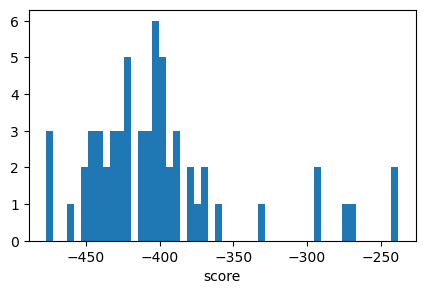

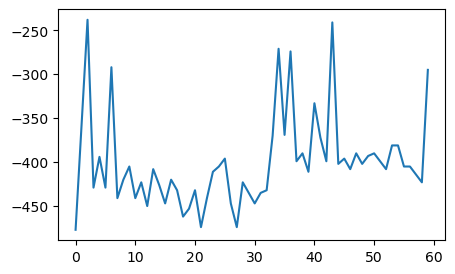

In [13]:

# distribution of scores (baseline set up)
plt.figure(figsize=(5,3))
plt.hist(episode.score, bins=50)
plt.xlabel('score')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(episode.score)
plt.show()

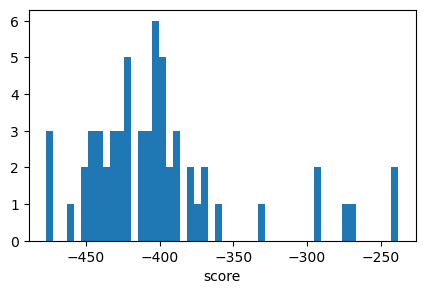

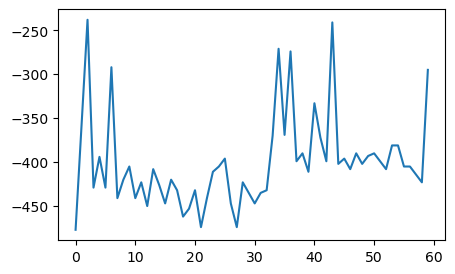

In [14]:

# distribution of scores (baseline set up)
plt.figure(figsize=(5,3))
plt.hist(episode.score, bins=50)
plt.xlabel('score')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(episode.score)
plt.show()

In [ ]:
# print(test.prog)
# print(test.actions)
# print(test.states)
# print(test.rewards)
# print(test.on_break)


In [ ]:
#  simple episode
# prog = []
# actions = []
# states = []
# rewards = []
# on_break = []
# on_break2 = []
# time_horizon = 480

# # get initial state/ set reward to 0
# s0 = mdp.get_state_ix()
# # s0 = mdp.get_state()
# r = 0
# agent = Agent()
# for i in range(time_horizon):
# #     a = fake_agent(s0, r)
# #     a = agent(s0, r)
    
#     a = agent.choose_action(s0)
#     s1, r = mdp(a)
#     s1 = mdp.get_state_ix()
#     agent.update(s0, s1, r)

#     # Q update
# #     break
    
#     s0 = s1

    
#     p_ = [self.states[k].progress for k in range(4)]
    
#     prog.append(p_)
#     actions.append(a)
#     states.append(self.current_state_ix)
#     rewards.append(r)
#     on_break.append(self.on_break)
#     on_break2.append(self.task_timer.on_break)
    
    
#     active_states = get_active_states(self.states,True)
#     if len(active_states) == 1:
#         break


# print(f'a:\t{a}')
# print(print_progress(self.states))

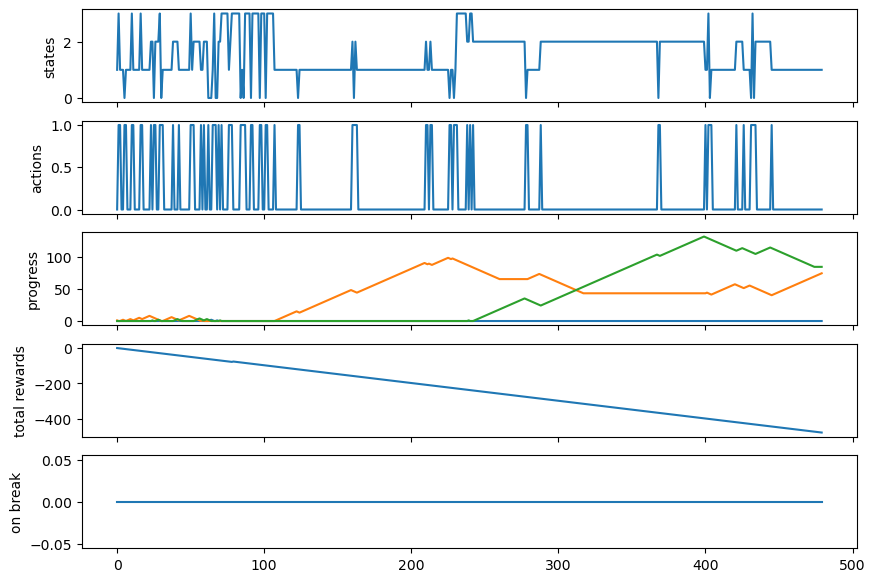

In [15]:

f, axs = plt.subplots(5,1, figsize=(10,7), sharex=True)

# index the episode you want to visualize
ep = 0

axs[0].plot(episode.states[ep])
axs[0].set_ylabel('states')
axs[1].plot(episode.actions[ep])
axs[1].set_ylabel('actions')
axs[2].plot(np.array(episode.prog[ep])[:,:-1])
axs[2].set_ylabel('progress')
axs[3].plot(np.cumsum(episode.rewards[ep]))
axs[3].set_ylabel('total rewards')
axs[4].plot(episode.on_break[ep])
axs[4].set_ylabel('on break')

# axs[3].set_yscale('log')

plt.show()

In [ ]:
agent.Qp